# Advanced Lane Detection Using Computer Vision

Identifying lanes on the road is a common task performed by all human drivers to ensure their vehicles are within lane constraints when driving, so as to make sure traffic is smooth and minimize chances of collisions with other cars in nearby lanes.

Similarly, it is a critical task for an autonomous vehicle to perform. It turns out that recognising lane markings on roads is possible using well known computer vision techniques. We will cover how to use various techniques to identify and draw the inside road lanes, lane curvature, and even estimate the vehicle position relative to the lane.

This is project 4 of Term 1 of the Udacity Self Driving Car Engineer Nanodegree.

# Calibration And Undistortion

## Camera Calibration

The first step we will take is to find the calibration matrix, along with distortion coefficient for the camera that was used to take pictures of the road. This is necessary because the convex shape of camera lenses curves light rays as the enter the pinhole, therefore causing distortions to the real image. Therefore lines that are straight in the real world may not be anymore on our photos. 

To compute the camera the transformation matrix and distortion coefficients, we use a multiple pictures of a _chessboard_ on a flat surface taken **by the same camera**. OpenCV has a convenient method called [findChessboardCorners](http://docs.opencv.org/2.4/modules/calib3d/doc/camera_calibration_and_3d_reconstruction.html#cv2.findChessboardCorners) that will identify the points where black and white squares intersect and reverse engineer the distorsion matrix this way. 

In [1]:
# Main imports
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from importlib import reload
import utils; reload(utils)
from utils import *

In [3]:
calibration_dir = "camera_cal"
test_imgs_dir = "test_images"
output_imgs_dir = "output_images"
output_videos_dir = "output_videos"

### Finding Chessboard Corners

We must determine the number of inner corners horizontally and vertically for our sample chessboard pictures.

In [4]:
# Let's get all our calibration image paths
cal_imgs_paths = glob.glob(calibration_dir + "/*.jpg")

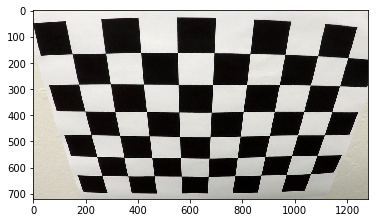

In [5]:
# Let's the first chessboard image to see what it looks like
cal_img_path = cal_imgs_paths[11]
cal_img = load_image(cal_img_path)
plt.imshow(cal_img)

Our chessboard has *9* inner corners in the x direction, and *6* in the y direction. We will use these as parameters to *findChessboardCorners()*.

In [6]:
cx = 9
cy = 6

We submit grayscale images to _findChessboardCorners_ so we must therefore define a utility method for this purpose.

In [7]:
def findChessboardCorners(img, nx, ny):
    """
    Finds the chessboard corners of the supplied image (must be grayscale)
    nx and ny parameters respectively indicate the number of inner corners in the x and y directions
    """
    return cv2.findChessboardCorners(img, (nx, ny), None)        

In [8]:
def showChessboardCorners(img, nx, ny, ret, corners):
    """
    Draws the chessboard corners of a given image
    nx and ny parameters respectively indicate the number of inner corners in the x and y directions
    ret and corners should represent the results from cv2.findChessboardCorners()
    """
    c_img = cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
    plt.axis('off')
    plt.imshow(img)

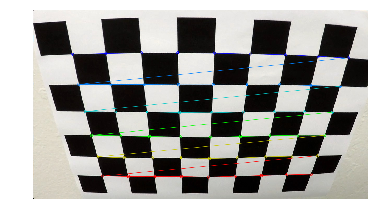

In [9]:
ret, corners = findChessboardCorners(to_grayscale(cal_img), cx, cy)
showChessboardCorners(cal_img, cx, cy, ret, corners)

We can see that corners are very well identified. Next we identify image and object points to calibrate the camera.

### Image Undistortion

#### Identifying Image And Object Points

We find the mappings for coordinates of the images in 2D space (i.e. *image points*) to those of the undistorted image in the real-world (i.e. *object points*)

In [10]:
def findImgObjPoints(imgs_paths, nx, ny):
    """
    Returns the objects and image points computed for a set of chessboard pictures taken from the same camera
    nx and ny parameters respectively indicate the number of inner corners in the x and y directions
    """
    objpts = []
    imgpts = []
    
    # Pre-compute what our object points in the real world should be (the z dimension is 0 as we assume a flat surface)
    objp = np.zeros((nx * ny, 3), np.float32)
    objp[:, :2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)
    
    for img_path in imgs_paths:
        img = load_image(img_path)
        gray = to_grayscale(img)
        ret, corners = findChessboardCorners(gray, nx, ny)
        
        if ret:
            # Found the corners of an image
            imgpts.append(corners)
            # Add the same object point since they don't change in the real world
            objpts.append(objp)
    
    return objpts, imgpts

In [11]:
opts, ipts = findImgObjPoints(cal_imgs_paths, cx, cy)

#### Finding Calibration Matrix

In [12]:
def undistort_image(img, objpts, imgpts):
    """
    Returns an undistorted image
    The desired object and image points must also be supplied to this function
    """
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpts, imgpts, to_grayscale(img).shape[::-1], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

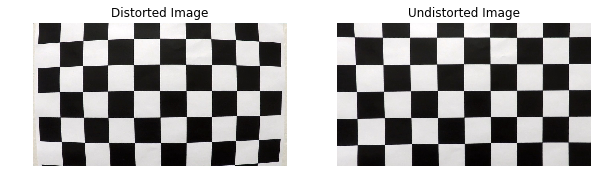

In [13]:
cal_img_example = load_image(cal_imgs_paths[0])
cal_img_undist = undistort_image(cal_img_example, opts, ipts)
fig, ax = plt.subplots(1, 2, figsize=(10,7))
ax[0].imshow(cal_img_example)
ax[0].axis("off")
ax[0].set_title("Distorted Image")

ax[1].imshow(cal_img_undist)
ax[1].axis("off")
ax[1].set_title("Undistorted Image")

plt.show()

We can see that the undistortion step indeed works well. Let's apply the undistortion step to our test images.

#### Undistorting Test Images

In [14]:
test_imgs_paths = glob.glob(test_imgs_dir + "/*.jpg")

In [15]:
test_img_names = np.asarray(list(map(lambda img_path: img_path.split("/")[-1].split(".")[0], test_imgs_paths)))
undist_test_img_names = np.asarray(list(map(lambda img_name: "{0}{1}".format("undistorted_", img_name), test_img_names)))

In [16]:
test_imgs = np.asarray(list(map(lambda img_path: load_image(img_path), test_imgs_paths)))
undist_test_imgs = np.asarray(list(map(lambda img: undistort_image(img, opts, ipts), test_imgs)))

In [17]:
test_img_and_undist = np.asarray(list(zip(test_imgs, undist_test_imgs)))
test_img_and_undist_names = np.asarray(list(zip(test_img_names, undist_test_img_names)))

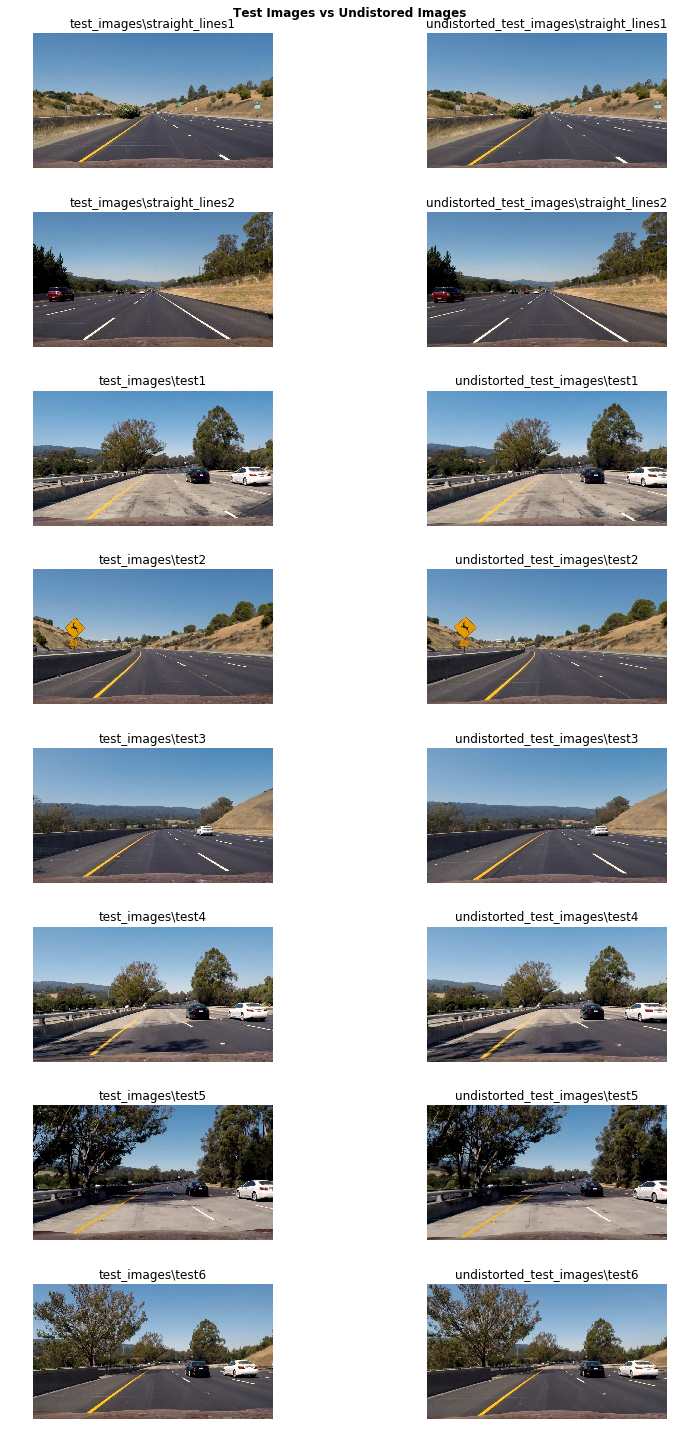

In [18]:
show_image_list(test_img_and_undist, test_img_and_undist_names, "Test Images vs Undistored Images", fig_size=(12, 20), cols=2, show_ticks=False)

The sample above shows original next to undistored images. We can see that on the undistorted images, the front of the car, especially at the sides, is less visible.

## Thresholding

We apply color and edge  thresholding in this section to better detect the lines, and make it easier to find the polynomial that best describes our left and right lanes later. 

We start with first exploring which color spaces we should adopt to increase our chances of detecting the lanes and facilitating the task of the gradient thresholding step.

In [19]:
def threshold_img(img, channel, thres=(0, 255)):
    """
    Applies a threshold mask to the input image
    """
    img_ch = img[:,:,channel]
    if thres is None:  
        return img_ch
    
    mask_ch = np.zeros_like(img_ch)
    mask_ch[ (thres[0] <= img_ch) & (thres[1] >= img_ch) ] = 1
    return mask_ch

In [121]:
test_img_path = test_imgs_paths[4]
test_img = load_image(test_img_path)
undistorted_test_img = undistort_image(test_img, opts, ipts)

### Color Thresholding

We experiment with different color spaces and try out some thresolding values to identify the best parameters and most suitable color space and channel to pick.

In [21]:
rgb_comp = np.asarray([[threshold_img(undistorted_test_img, 0, thres=None), threshold_img(undistorted_test_img, 1, thres=None), threshold_img(undistorted_test_img, 2, thres=None)]])
rgb_lbs = np.asarray([["Red Channel", "Green Channel", "Blue Channel"]])

In [22]:
hls_test_img = to_hls(undistorted_test_img)
hls_comp = np.asarray([[threshold_img(hls_test_img, 0, thres=None), threshold_img(hls_test_img, 1, thres=None), threshold_img(hls_test_img, 2, thres=None)]])
hls_lbs = np.asarray([["Hue Channel", "Lightness Channel", "Saturation Channel"]])

In [23]:
hsv_test_img = to_hsv(undistorted_test_img)
hsv_comp = np.asarray([[threshold_img(hsv_test_img, 0, thres=None), threshold_img(hsv_test_img, 1, thres=None), threshold_img(hsv_test_img, 2, thres=None)]])
hsv_lbs = np.asarray([["Hue Channel", "Saturation Channel", "Value Channel"]])

In [24]:
lab_test_img = to_lab(undistorted_test_img)
lab_comp = np.asarray([[threshold_img(lab_test_img, 0, thres=None), threshold_img(lab_test_img, 1, thres=None), threshold_img(lab_test_img, 2, thres=None)]])
lab_lbs = np.asarray([["Lightness Channel", "Green-Red (A) Channel", "Blue-Yellow (B) Channel"]])

In [25]:
color_spaces_comps = np.concatenate((rgb_comp, hls_comp, hsv_comp, lab_comp))
color_spaces_lbs = np.concatenate((rgb_lbs, hls_lbs, hsv_lbs, lab_lbs))

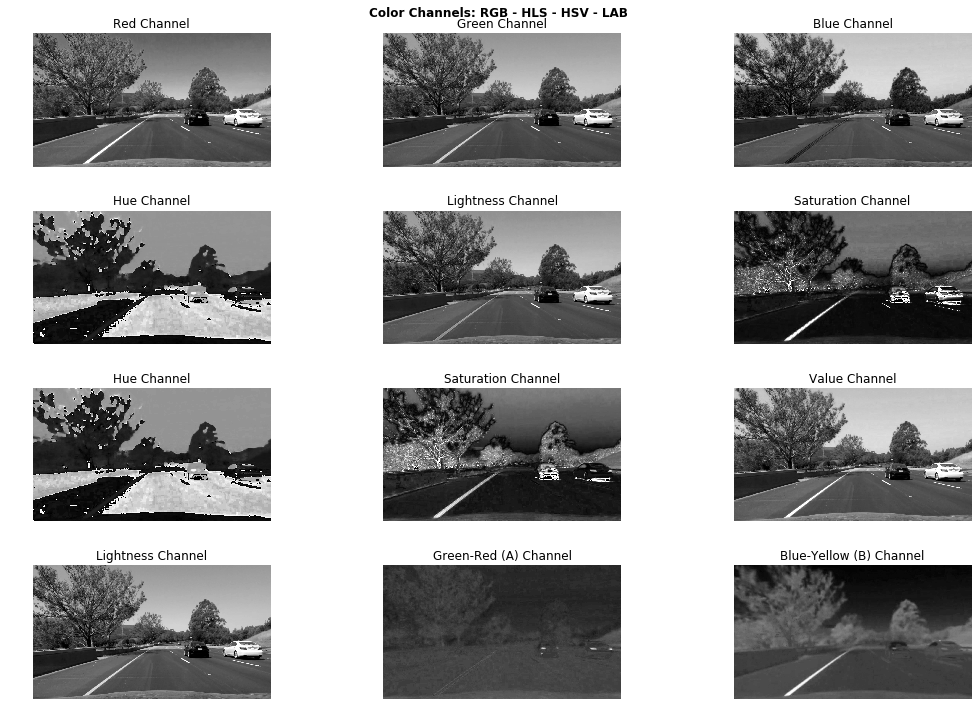

In [26]:
show_image_list(color_spaces_comps, color_spaces_lbs, "Color Channels: RGB - HLS - HSV - LAB", cols=3, fig_size=(15, 10), show_ticks=False)

On the RGB components, we see that the blue channel is worst at identifying yellow lines, while the red channel seems to give best results.

For HLS and HSV, the hue channel produces an extremely noisy output, while the saturation channel of HLS seems to give the strong results; better than HSV's saturation channel. conversely, HSV's value channel is giving a very clear grayscale-ish image, especially on the yellow line, much better than HLS' lightness channel.

Lastly, LAB's A channel is not doing a great job, while it's B channel is strong at identifying the yellow line. But it is the lightness channel that shines (no pun intended) at identify both yellow and white lines.

At this stage, we are faced with various choices that have pros and cons. Our goal here is to find the right thresholds on a given color channel to highlight yellow and white lines of the lane. There are actually many ways we could achieve this result, but **we choose to use HLS because we already know how to set thresholds for yellow and white lane lines from [Project 1](https://github.com/kenshiro-o/CarND-LaneLines-P1)** .

In [27]:
def compute_hls_white_yellow_binary(rgb_img):
    """
    Returns a binary thresholded image produced retaining only white and yellow elements on the picture
    The provided image should be in RGB format
    """
    hls_img = to_hls(rgb_img)
    
    # Compute a binary thresholded image where yellow is isolated from HLS components
    img_hls_yellow_bin = np.zeros_like(hls_img[:,:,0])
    img_hls_yellow_bin[((hls_img[:,:,0] >= 15) & (hls_img[:,:,0] <= 35))
                 & ((hls_img[:,:,1] >= 30) & (hls_img[:,:,1] <= 204))
                 & ((hls_img[:,:,2] >= 115) & (hls_img[:,:,2] <= 255))                
                ] = 1
    
    # Compute a binary thresholded image where white is isolated from HLS components
    img_hls_white_bin = np.zeros_like(hls_img[:,:,0])
    img_hls_white_bin[((hls_img[:,:,0] >= 0) & (hls_img[:,:,0] <= 255))
                 & ((hls_img[:,:,1] >= 200) & (hls_img[:,:,1] <= 255))
                 & ((hls_img[:,:,2] >= 0) & (hls_img[:,:,2] <= 255))                
                ] = 1
    
    # Now combine both
    img_hls_white_yellow_bin = np.zeros_like(hls_img[:,:,0])
    img_hls_white_yellow_bin[(img_hls_yellow_bin == 1) | (img_hls_white_bin == 1)] = 1

    return img_hls_white_yellow_bin

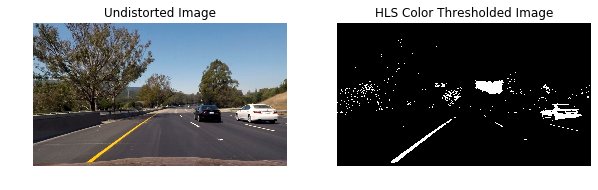

In [28]:
undistorted_yellow_white_hls_img_bin = compute_hls_white_yellow_binary(undistorted_test_img)

fig, ax = plt.subplots(1, 2, figsize=(10,7))
ax[0].imshow(undistorted_test_img)
ax[0].axis("off")
ax[0].set_title("Undistorted Image")

ax[1].imshow(undistorted_yellow_white_hls_img_bin, cmap='gray')
ax[1].axis("off")
ax[1].set_title("HLS Color Thresholded Image")

plt.show()

As you can see above, our HLS color thresholding achieve great results on the image. The thresholding somewhat struggles a little with the shadow of the tree on the yellow line further up ahead. We believe gradient thresholding can help in this case.

### Gradient Thresholding Via Sobel

We use the [Sobel](https://en.wikipedia.org/wiki/Sobel_operator) operator to identify _gradients_, that is change in _color intensity_ in the image. Higher values would denote strong gradients, and therefore sharp changes in color.

We have decided to use LAB's L channel as our single-channel image to serve as input to the sobel functions below.

In [29]:
# L channel is index 0 of the color components
undist_test_img_gray = to_lab(undistorted_test_img)[:,:,0]

#### Sobel In X or Y Directions

In [30]:
def abs_sobel(gray_img, x_dir=True, kernel_size=3, thres=(0, 255)):
    """
    Applies the sobel operator to a grayscale-like (i.e. single channel) image in either horizontal or vertical direction
    The function also computes the asbolute value of the resulting matrix and applies a binary threshold
    """
    sob = sobel(gray_img)# if x_dir else sobel(gray_img, False)
    #sobel = cv2.Sobel(gray_img, cv2.CV_64F, 1, 0, ksize=kernel_size) if x_dir else cv2.Sobel(gray_img, cv2.CV_64F, 0, 1, ksize=kernel_size) 
    sobel_abs = np.absolute(sob)
    sobel_scaled = np.uint8(255 * sob / np.max(sobel_abs))
    
    gradient_mask = np.zeros_like(sobel_scaled)
    gradient_mask[(thres[0] <= sobel_scaled) & (sobel_scaled <= thres[1])] = 1
    return gradient_mask

In [31]:
sobx_3x3_thres = np.asarray([[abs_sobel(undist_test_img_gray, thres=(20, 120)), abs_sobel(undist_test_img_gray, thres=(50, 150)), abs_sobel(undist_test_img_gray, thres=(80, 200))]])
sobx_7x7_thres = np.asarray([[abs_sobel(undist_test_img_gray, kernel_size=7, thres=(20, 120)), abs_sobel(undist_test_img_gray, kernel_size=7, thres=(50, 150)), abs_sobel(undist_test_img_gray, kernel_size=7, thres=(80, 200))]])
sobx_11x11_thres = np.asarray([[abs_sobel(undist_test_img_gray, kernel_size=11, thres=(20, 120)), abs_sobel(undist_test_img_gray, kernel_size=11, thres=(50, 150)), abs_sobel(undist_test_img_gray, kernel_size=11, thres=(80, 200))]])
sobx_15x15_thres = np.asarray([[abs_sobel(undist_test_img_gray, kernel_size=15, thres=(20, 120)), abs_sobel(undist_test_img_gray, kernel_size=15, thres=(50, 150)), abs_sobel(undist_test_img_gray, kernel_size=15, thres=(80, 200))]])

sobx_3x3_thres_lbs = np.asarray([["3x3 - Threshold (20,120)", "3x3 - Threshold (50,150)", "3x3 - Threshold (80,200)"]])
sobx_7x7_thres_lbs = np.asarray([["7x7 - Threshold (20,120)", "7x7 - Threshold (50,150)", "7x7 - Threshold (80,200)"]])
sobx_11x11_thres_lbs = np.asarray([["11x11 - Threshold (20,120)", "11x11 - Threshold (50,150)", "11x11 - Threshold (80,200)"]])
sobx_15x15_thres_lbs = np.asarray([["15x15 - Threshold (20,120)", "15x15 - Threshold (50,150)", "15x15 - Threshold (80,200)"]])


In [32]:
sobx_thres = np.concatenate((sobx_3x3_thres, sobx_7x7_thres, sobx_11x11_thres, sobx_15x15_thres))
sobx_thres_lbs = np.concatenate((sobx_3x3_thres_lbs, sobx_7x7_thres_lbs, sobx_11x11_thres_lbs, sobx_15x15_thres_lbs))

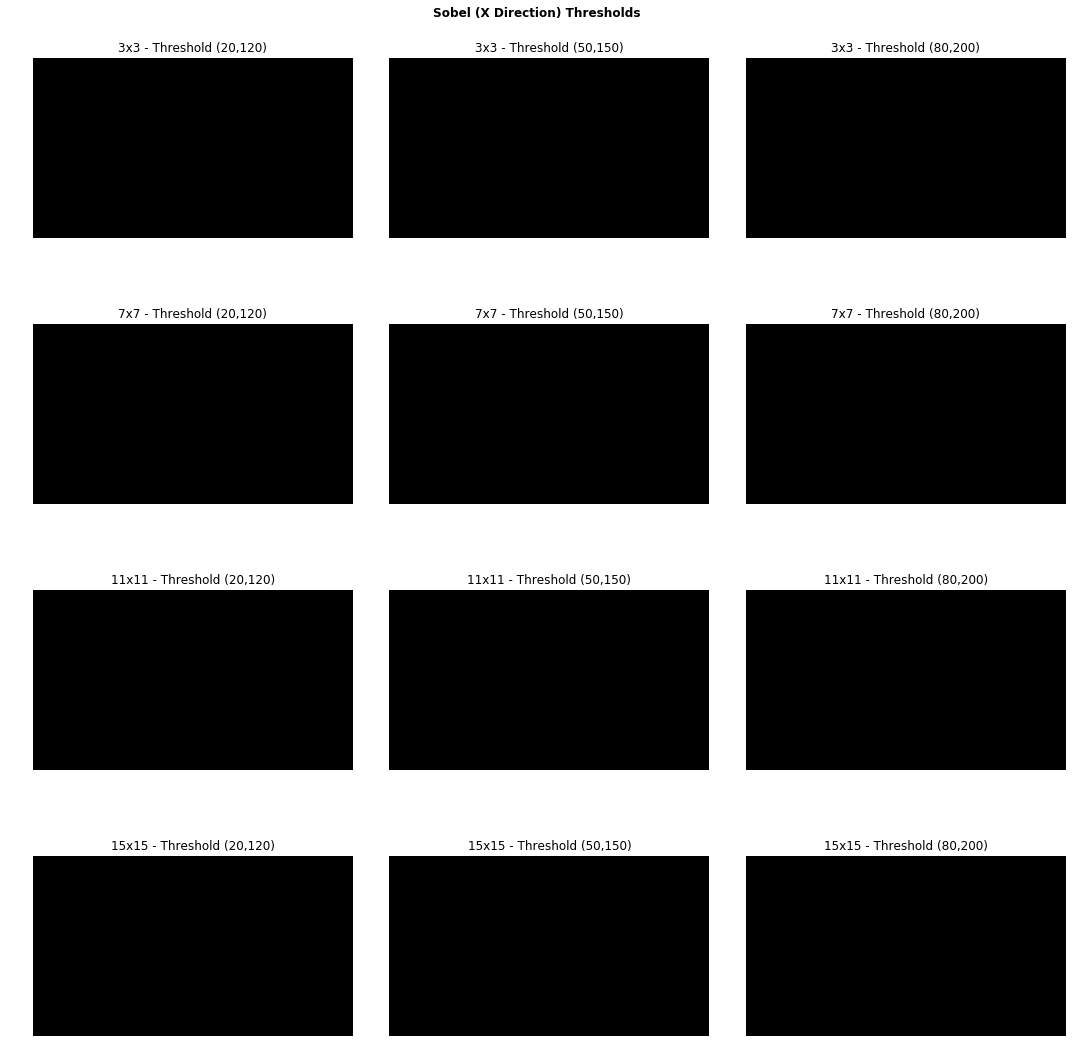

In [33]:
show_image_list(sobx_thres, sobx_thres_lbs, "Sobel (X Direction) Thresholds", cols=3, show_ticks=False)

We obtain the "best" results for Sobel in the X direction with thresholds values between in the interval _[20,120]_, using a kernel size of 15 (lines are very crisp).

In [34]:
# Saving our best sobel results
sobx_best = abs_sobel(undist_test_img_gray, kernel_size=15, thres=(20, 120))

In [35]:
soby_3x3_thres = np.asarray([[abs_sobel(undist_test_img_gray, x_dir=False, thres=(20, 120)), abs_sobel(undist_test_img_gray, x_dir=False, thres=(50, 150)), abs_sobel(undist_test_img_gray, x_dir=False, thres=(80, 200))]])
soby_7x7_thres = np.asarray([[abs_sobel(undist_test_img_gray, x_dir=False, kernel_size=7, thres=(20, 120)), abs_sobel(undist_test_img_gray, x_dir=False, kernel_size=7, thres=(50, 150)), abs_sobel(undist_test_img_gray, x_dir=False, kernel_size=7, thres=(80, 200))]])
soby_11x11_thres = np.asarray([[abs_sobel(undist_test_img_gray, x_dir=False, kernel_size=11, thres=(20, 120)), abs_sobel(undist_test_img_gray, x_dir=False, kernel_size=11, thres=(50, 150)), abs_sobel(undist_test_img_gray, x_dir=False, kernel_size=11, thres=(80, 200))]])
soby_15x15_thres = np.asarray([[abs_sobel(undist_test_img_gray, x_dir=False, kernel_size=15, thres=(20, 120)), abs_sobel(undist_test_img_gray, x_dir=False, kernel_size=15, thres=(50, 150)), abs_sobel(undist_test_img_gray, x_dir=False, kernel_size=15, thres=(80, 200))]])

soby_3x3_thres_lbs = np.asarray([["3x3 - Threshold (20,120)", "3x3 - Threshold (50,150)", "3x3 - Threshold (80,200)"]])
soby_7x7_thres_lbs = np.asarray([["7x7 - Threshold (20,120)", "7x7 - Threshold (50,150)", "7x7 - Threshold (80,200)"]])
soby_11x11_thres_lbs = np.asarray([["11x11 - Threshold (20,120)", "11x11 - Threshold (50,150)", "11x11 - Threshold (80,200)"]])
soby_15x15_thres_lbs = np.asarray([["15x15 - Threshold (20,120)", "15x15 - Threshold (50,150)", "15x15 - Threshold (80,200)"]])


In [36]:
soby_thres = np.concatenate((soby_3x3_thres, soby_7x7_thres, soby_11x11_thres, soby_15x15_thres))
soby_thres_lbs = np.concatenate((soby_3x3_thres_lbs, soby_7x7_thres_lbs, soby_11x11_thres_lbs, soby_15x15_thres_lbs))

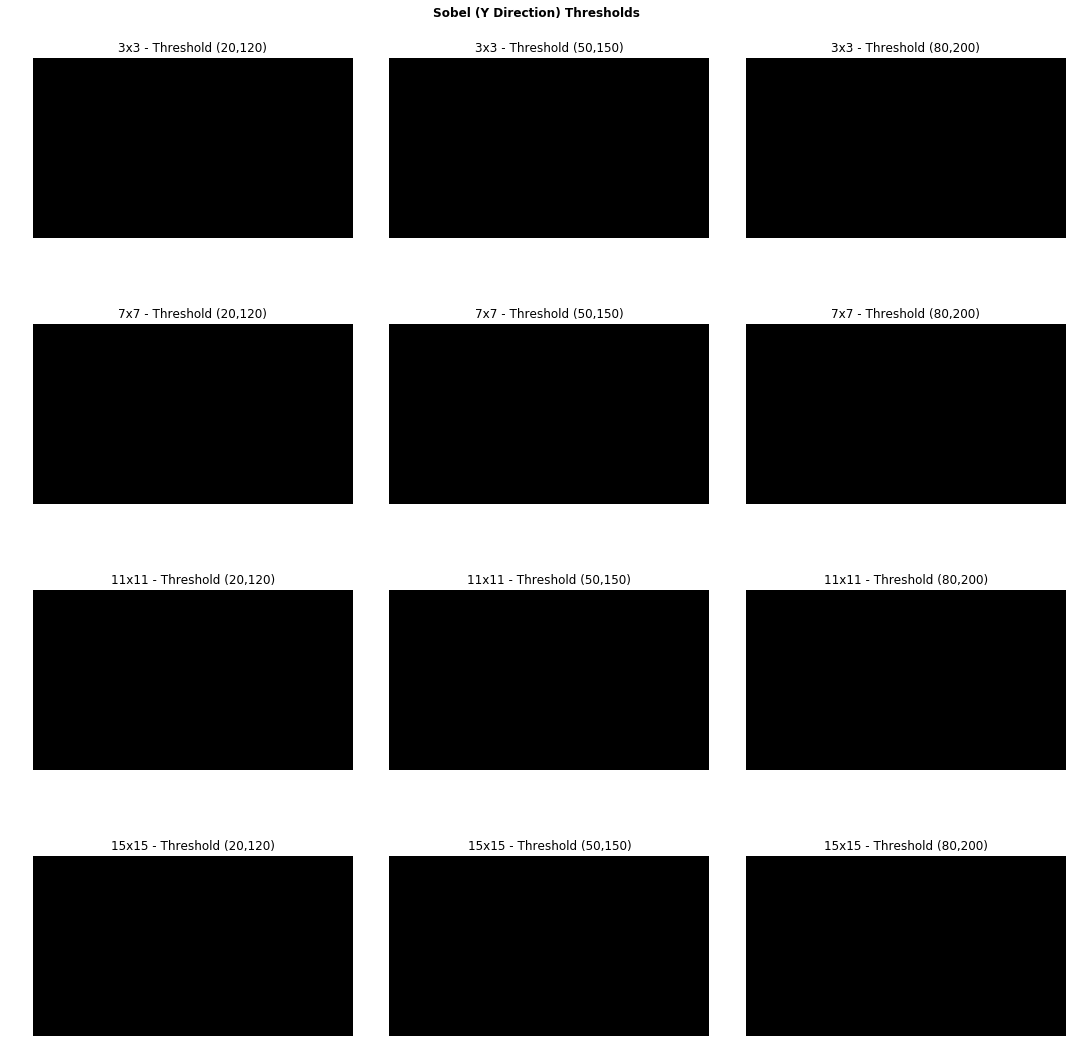

In [37]:
show_image_list(soby_thres, soby_thres_lbs, "Sobel (Y Direction) Thresholds", cols=3, show_ticks=False)

In the Y direction, our best Sobel configuration is with thresholds in the interval _[20,120]_ and kernel size 15.

In [38]:
# Saving our best sobel y result
soby_best = abs_sobel(undist_test_img_gray, x_dir=False, kernel_size=15, thres=(20, 120))

#### Sobel Magnitude in X and Y Directions

In [39]:
def mag_sobel(gray_img, kernel_size=3, thres=(0, 255)):
    """
    Computes sobel matrix in both x and y directions, merges them by computing the magnitude in both directions
    and applies a threshold value to only set pixels within the specified range
    """
    sx = cv2.Sobel(gray_img, cv2.CV_64F, 1, 0, ksize=kernel_size)
    sy = cv2.Sobel(gray_img, cv2.CV_64F, 0, 1, ksize=kernel_size)
    
    sxy = np.sqrt(np.square(sx) + np.square(sy))
    scaled_sxy = np.uint8(255 * sxy / np.max(sxy))
    
    sxy_binary = np.zeros_like(scaled_sxy)
    sxy_binary[(scaled_sxy >= thres[0]) & (scaled_sxy <= thres[1])] = 1
    
    return sxy_binary

In [40]:
sobxy_3x3_thres = np.asarray([[mag_sobel(undist_test_img_gray, kernel_size=3, thres=(20, 80)), mag_sobel(undist_test_img_gray, kernel_size=3, thres=(50, 150)), mag_sobel(undist_test_img_gray, kernel_size=3, thres=(80, 200))]])
sobxy_7x7_thres = np.asarray([[mag_sobel(undist_test_img_gray, kernel_size=7, thres=(20, 80)), mag_sobel(undist_test_img_gray, kernel_size=7, thres=(50, 150)), mag_sobel(undist_test_img_gray, kernel_size=7, thres=(80, 200))]])
sobxy_11x11_thres = np.asarray([[mag_sobel(undist_test_img_gray, kernel_size=11, thres=(20, 80)), mag_sobel(undist_test_img_gray, kernel_size=11, thres=(50, 150)), mag_sobel(undist_test_img_gray, kernel_size=11, thres=(80, 200))]])
sobxy_15x15_thres = np.asarray([[mag_sobel(undist_test_img_gray, kernel_size=15, thres=(20, 80)), mag_sobel(undist_test_img_gray, kernel_size=15, thres=(50, 150)), mag_sobel(undist_test_img_gray, kernel_size=15, thres=(80, 200))]])

sobxy_3x3_thres_lbs = np.asarray([["3x3 - Threshold (20,80)", "3x3 - Threshold (50,150)", "3x3 - Threshold (80,200)"]])
sobxy_7x7_thres_lbs = np.asarray([["7x7 - Threshold (20,80)", "7x7 - Threshold (50,150)", "7x7 - Threshold (80,200)"]])
sobxy_11x11_thres_lbs = np.asarray([["11x11 - Threshold (20,80)", "11x11 - Threshold (50,150)", "11x11 - Threshold (80,200)"]])
sobxy_15x15_thres_lbs = np.asarray([["15x15 - Threshold (20,80)", "15x15 - Threshold (50,150)", "15x15 - Threshold (80,200)"]])


In [41]:
sobxy_thres = np.concatenate((sobxy_3x3_thres, sobxy_7x7_thres, sobxy_11x11_thres, sobxy_15x15_thres))
sobxy_thres_lbs = np.concatenate((sobxy_3x3_thres_lbs, sobxy_7x7_thres_lbs, sobxy_11x11_thres_lbs, sobxy_15x15_thres_lbs))


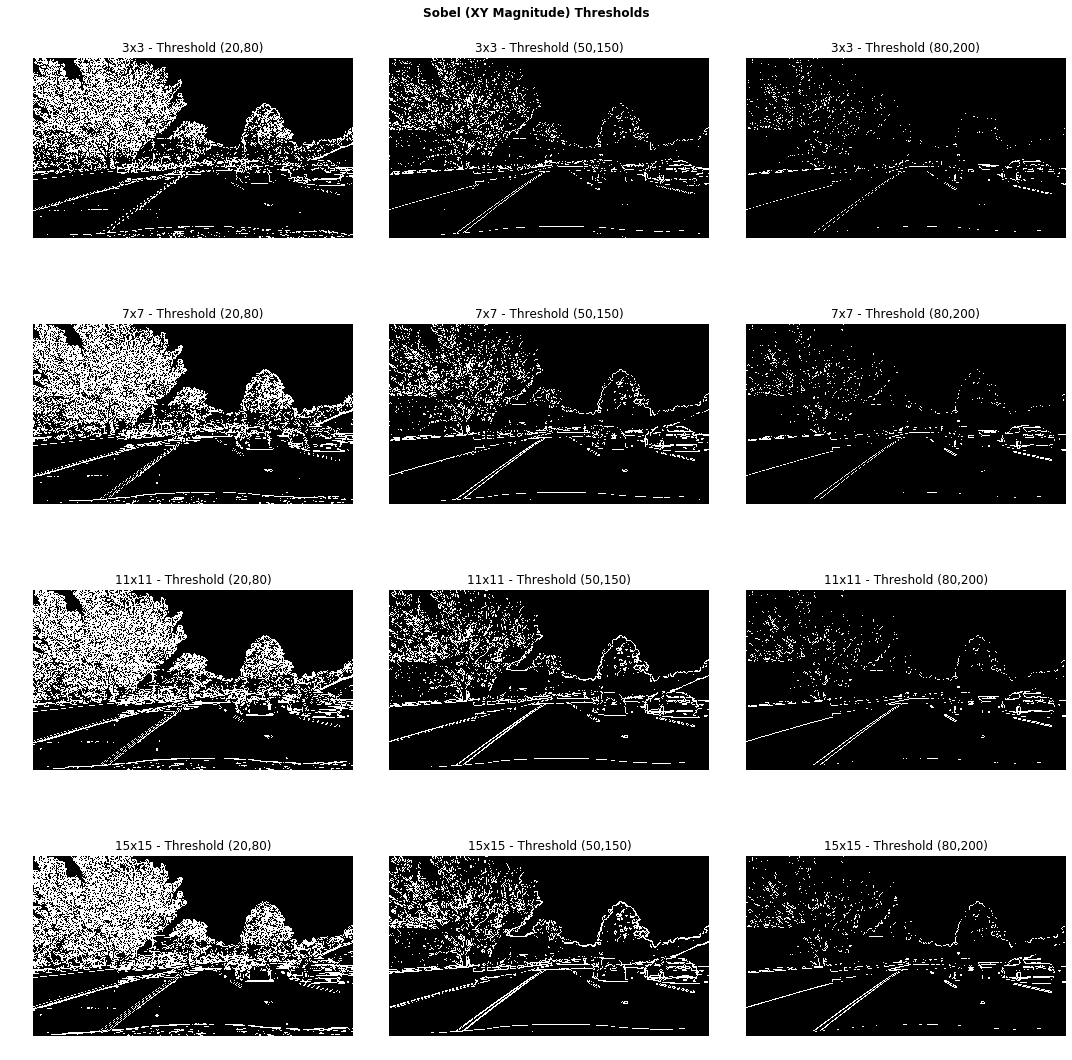

In [42]:
show_image_list(sobxy_thres, sobxy_thres_lbs, "Sobel (XY Magnitude) Thresholds", cols=3, show_ticks=False)

Since we plan to combine this Sobel result, we believe we get enough information for interval _[80, 200]_ and kernel size 15.

In [43]:
# Saving our best Sobel XY magnitude results
sobxy_best = mag_sobel(undist_test_img_gray, kernel_size=15, thres=(80, 200))

#### Sobel With Gradient Direction

This Sobel operation is extremely noisy and it becomes quite hard to decipher the result if we do not combine it with our previous sobel operations and produce a binary output.

In [44]:
def dir_sobel(gray_img, kernel_size=3, thres=(0, np.pi/2)):
    """
    Computes sobel matrix in both x and y directions, gets their absolute values to find the direction of the gradient
    and applies a threshold value to only set pixels within the specified range
    """
    sx_abs = np.absolute(cv2.Sobel(gray_img, cv2.CV_64F, 1, 0, ksize=kernel_size))
    sy_abs = np.absolute(cv2.Sobel(gray_img, cv2.CV_64F, 0, 1, ksize=kernel_size))
    
    dir_sxy = np.arctan2(sx_abs, sy_abs)

    binary_output = np.zeros_like(dir_sxy)
    binary_output[(dir_sxy >= thres[0]) & (dir_sxy <= thres[1])] = 1
    
    return binary_output

In [45]:
def combined_sobels(sx_binary, sy_binary, sxy_magnitude_binary, gray_img, kernel_size=3, angle_thres=(0, np.pi/2)):
    sxy_direction_binary = dir_sobel(gray_img, kernel_size=kernel_size, thres=angle_thres)
    
    combined = np.zeros_like(sxy_direction_binary)
    # Sobel X returned the best output so we keep all of its results. We perform a binary and on all the other sobels    
    combined[(sx_binary == 1) | ((sy_binary == 1) & (sxy_magnitude_binary == 1) & (sxy_direction_binary == 1))] = 1
    
    return combined

In [46]:
cb = combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray)

In [47]:
sobxy_combined_dir_3x3_thres = np.asarray([[combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=3, angle_thres=(0, np.pi/4)),
                                            combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=3, angle_thres=(np.pi/4, np.pi/2)),
                                            combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=3, angle_thres=(np.pi/3, np.pi/2))
                                           ]])

sobxy_combined_dir_7x7_thres = np.asarray([[combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=7, angle_thres=(0, np.pi/4)),
                                            combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=7, angle_thres=(np.pi/4, np.pi/2)),
                                            combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=7, angle_thres=(np.pi/3, np.pi/2))
                                           ]])

sobxy_combined_dir_11x11_thres = np.asarray([[combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=11, angle_thres=(0, np.pi/4)),
                                            combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=11, angle_thres=(np.pi/4, np.pi/2)),
                                            combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=11, angle_thres=(np.pi/3, np.pi/2))
                                           ]])

sobxy_combined_dir_15x15_thres = np.asarray([[combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=15, angle_thres=(0, np.pi/4)),
                                            combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=15, angle_thres=(np.pi/4, np.pi/2)),
                                            combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=15, angle_thres=(np.pi/3, np.pi/2))
                                           ]])


sobxy_combined_dir_3x3_thres_lbs = np.asarray([["3x3 - Combined (0, pi/4)", "3x3 - Combined (pi/4, pi/2)", "3x3 - Combined (pi/3, pi/2)"]])
sobxy_combined_dir_7x7_thres_lbs = np.asarray([["7x7 - Combined (0, pi/4)", "7x7 - Combined (pi/4, pi/2)", "7x7 - Combined (pi/3, pi/2)"]])
sobxy_combined_dir_11x11_thres_lbs = np.asarray([["11x11 - Combined (0, pi/4)", "11x11 - Combined (pi/4, pi/2)", "11x11 - Combined (pi/3, pi/2)"]])
sobxy_combined_dir_15x15_thres_lbs = np.asarray([["15x15 - Combined (0, pi/4)", "15x15 - Combined (pi/4, pi/2)", "15x15 - Combined (pi/3, pi/2)"]])

In [48]:
sobxy_combined_dir_thres = np.concatenate((sobxy_combined_dir_3x3_thres, sobxy_combined_dir_7x7_thres, sobxy_combined_dir_11x11_thres, sobxy_combined_dir_15x15_thres))
sobxy_combined_dir_thres_lbs = np.concatenate((sobxy_combined_dir_3x3_thres_lbs, sobxy_combined_dir_7x7_thres_lbs, sobxy_combined_dir_11x11_thres_lbs, sobxy_combined_dir_15x15_thres_lbs))

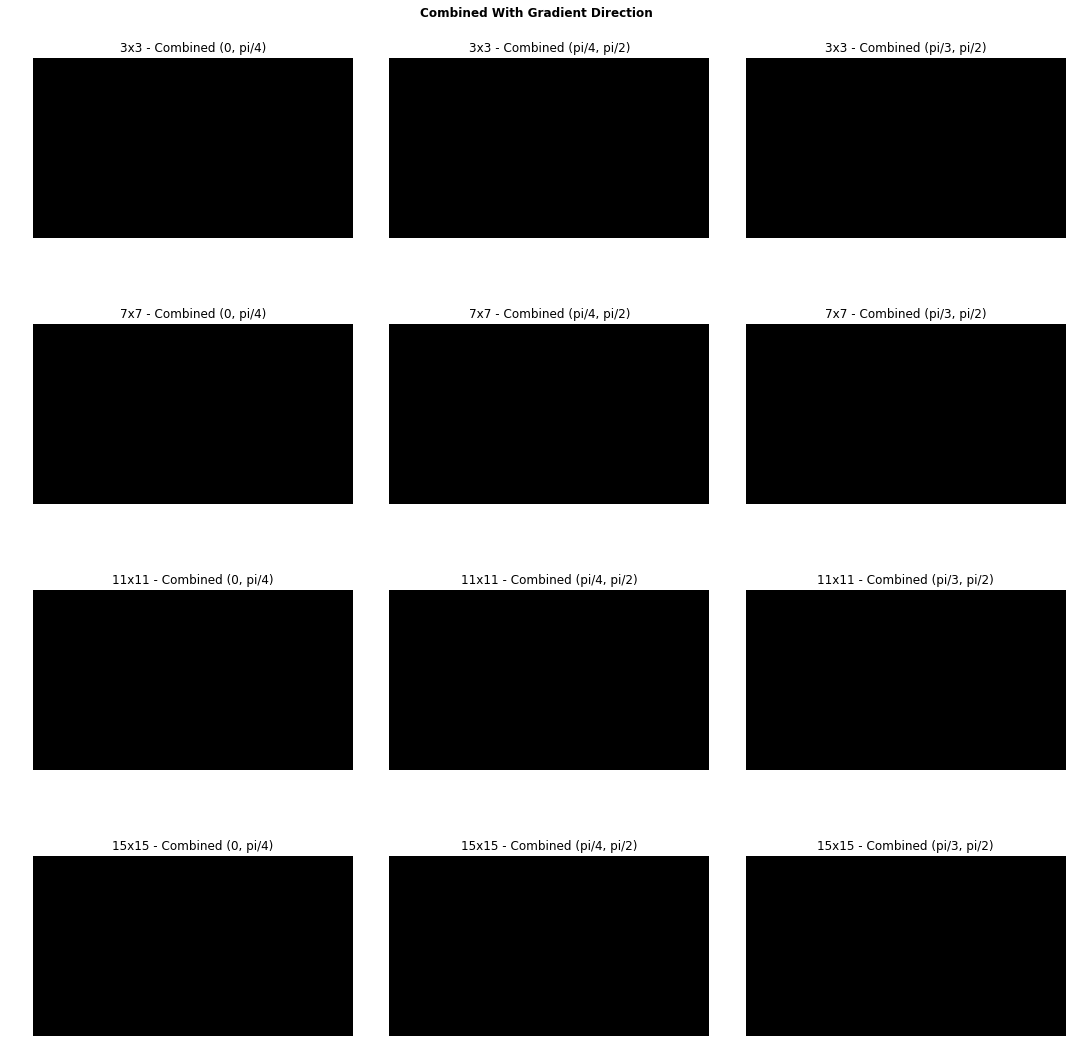

In [49]:
show_image_list(sobxy_combined_dir_thres, sobxy_combined_dir_thres_lbs, "Combined With Gradient Direction", cols=3, show_ticks=False)

Interestingly, the kernel size does not seem to affect the direction sobel operation so much. It's also hard to determine which one is the "best" result out of all our visualisations. Since we want to retain only information about lane lines, we are inclined to elect interval _[pi/4, pi/2]_ as our best configuration as it gives us the most room for manoeuvre. Kernel size of 15x15 produces the least noise.

In [50]:
sobel_combined_best = combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=15, angle_thres=(np.pi/4, np.pi/2))                                                                            

The resulting image from combined variant of sobel operations shows promise. We should next combine it with the results we obtained from our HLS' color thresholding method.

### Combining Color And Gradient (Sobel) Thresholds

In [51]:
color_binary = np.dstack((np.zeros_like(sobel_combined_best), sobel_combined_best, undistorted_yellow_white_hls_img_bin)) * 255
color_binary = color_binary.astype(np.uint8)

In [52]:
combined_binary = np.zeros_like(undistorted_yellow_white_hls_img_bin)
combined_binary[(sobel_combined_best == 1) | (undistorted_yellow_white_hls_img_bin == 1)] = 1

In [53]:
combined_binaries = [[color_binary, combined_binary]]
combined_binaries_lbs = np.asarray([["Stacked Thresholds", "Combined Color And Gradient Thresholds"]])

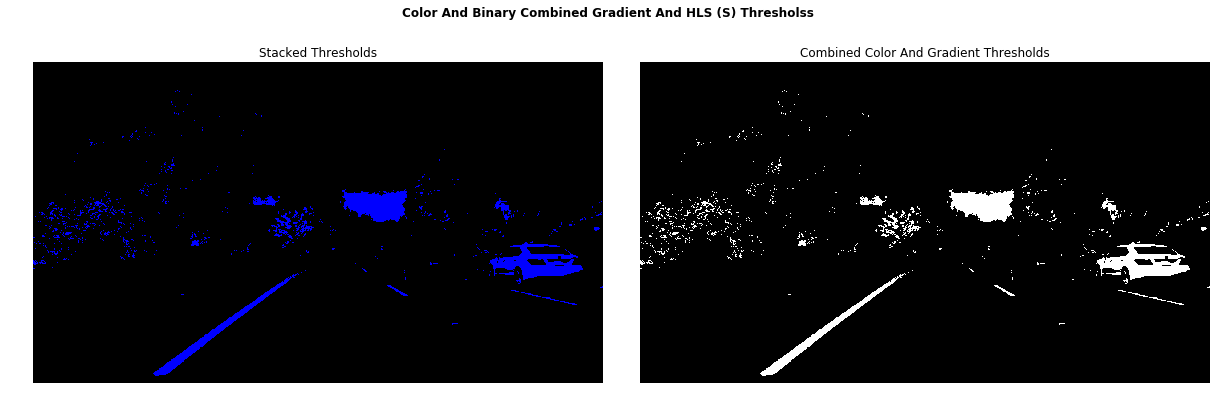

In [54]:
show_image_list(combined_binaries, combined_binaries_lbs, "Color And Binary Combined Gradient And HLS (S) Thresholss", cols=2, fig_size=(17, 6), show_ticks=False)

The results are very encouraging and it seems we have found the right parameters to detect lanes in a robust manner. We turn next to applying a perspective transform to our image and produce a _bird's eye view_ of the lane.

## Perspective Transform

We now need to define a trapezoidal region in the 2D image that will go through a perspective transform to convert into a bird's eye view.

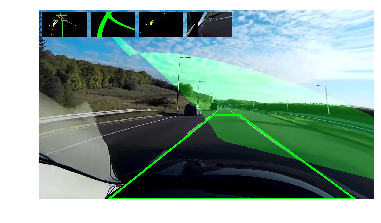

In [153]:
copy_combined = plt.imread('test_images/lane_Trim_Moment.jpg')
plt.imshow(copy_combined)
(bottom_px, right_px) = (copy_combined.shape[0] - 1, copy_combined.shape[1] - 1) 
pts = np.array([[400,bottom_px],[1000,600],[1150,600], [1810, bottom_px]], np.int32)
cv2.polylines(copy_combined,[pts],True,(0,255,0), 10)
plt.axis('off')
plt.imshow(copy_combined)

In [116]:
def compute_perspective_transform_matrices(src, dst):
    """
    Returns the tuple (M, M_inv) where M represents the matrix to use for perspective transform
    and M_inv is the matrix used to revert the transformed image back to the original one
    """
    M = cv2.getPerspectiveTransform(src, dst)
    M_inv = cv2.getPerspectiveTransform(dst, src)
    
    return (M, M_inv)

In [117]:
def perspective_transform(img, src, dst):   
    """
    Applies a perspective 
    """
    M = cv2.getPerspectiveTransform(src, dst)
    img_size = (img.shape[1], img.shape[0])
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    return warped

In [118]:
src_pts = pts.astype(np.float32)
dst_pts = np.array([[200, bottom_px], [200, 0], [1000, 0], [1000, bottom_px]], np.float32)

In [122]:
test_img_persp_tr = perspective_transform(undistorted_test_img, src_pts, dst_pts)

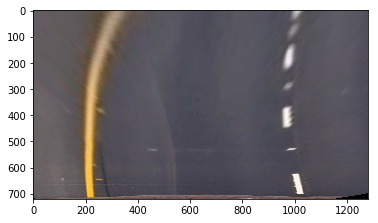

In [123]:
plt.imshow(test_img_persp_tr)

Here the lane is curved, and our perspective transform takes this into account too.

In [61]:
test_imgs_pers_tr = np.asarray(list(map(lambda img: perspective_transform(img, src_pts, dst_pts), undist_test_imgs))) 

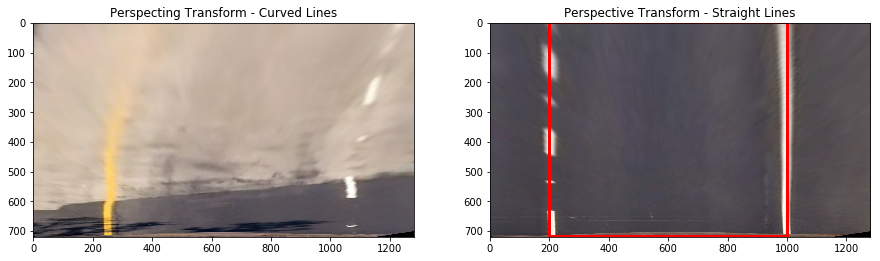

In [62]:
test_persp_img = np.copy(test_imgs_pers_tr[1])
dst = dst_pts.astype(np.int32)
cv2.polylines(test_persp_img,[dst],True,(255,0,0), 10)

fig, ax = plt.subplots(1, 2, figsize=(15,10))
ax[0].imshow(test_imgs_pers_tr[5])
ax[0].set_title("Perspecting Transform - Curved Lines")

ax[1].imshow(test_persp_img)
ax[1].set_title("Perspective Transform - Straight Lines")

plt.show()

We can see that our perspective transform keeps straight lines straight, which is a required sanity check. The curved lines however are not perfect on the example above, but they should not cause unsurmountable problems for our algorithm either. 

In [63]:
test_undist_imgs_and_p_tr = np.asarray(list(zip(undist_test_imgs, test_imgs_pers_tr)))
test_undist_imgs_and_p_tr_names = np.asarray(list(zip(undist_test_img_names, undist_test_img_names)))

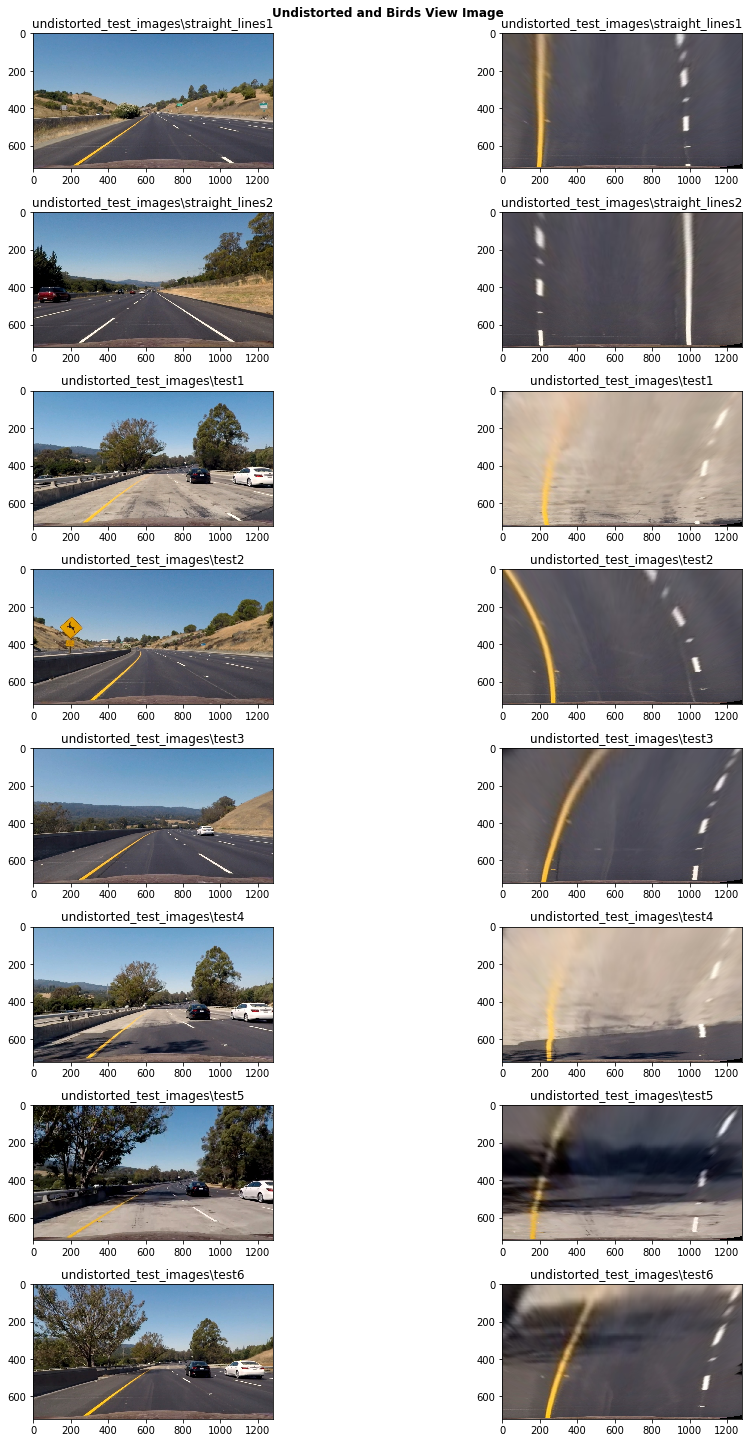

In [64]:
show_image_list(test_undist_imgs_and_p_tr, test_undist_imgs_and_p_tr_names, "Undistorted and Birds View Image", fig_size=(15, 20))

At this stage it is fitting to start definining a pipeline of operations to perform and visualise perspective transform on thresholding binary images.

### Putting It All Together

In [65]:
def get_combined_binary_thresholded_img(undist_img):
    """
    Applies a combination of binary Sobel and color thresholding to an undistorted image
    Those binary images are then combined to produce the returned binary image
    """
    undist_img_gray = to_lab(undist_img)[:,:,0]
    sx = abs_sobel(undist_img_gray, kernel_size=15, thres=(20, 120))
    sy = abs_sobel(undist_img_gray, x_dir=False, kernel_size=15, thres=(20, 120))
    sxy = mag_sobel(undist_img_gray, kernel_size=15, thres=(80, 200))
    sxy_combined_dir = combined_sobels(sx, sy, sxy, undist_img_gray, kernel_size=15, angle_thres=(np.pi/4, np.pi/2))   
    
    hls_w_y_thres = compute_hls_white_yellow_binary(undist_img)
    
    combined_binary = np.zeros_like(hls_w_y_thres)
    combined_binary[(sxy_combined_dir == 1) | (hls_w_y_thres == 1)] = 1
        
    return combined_binary

In [66]:
test_imgs_combined_binary_thres = np.asarray(list(map(lambda img: get_combined_binary_thresholded_img(img), undist_test_imgs)))

In [67]:
test_imgs_psp_tr = np.asarray(list(map(lambda img: perspective_transform(img, src_pts, dst_pts), undist_test_imgs))) 

In [68]:
test_imgs_combined_binary_psp_tr = np.asarray(list(map(lambda img: perspective_transform(img, src_pts, dst_pts), test_imgs_combined_binary_thres))) 

In [69]:
test_imgs_combined_binary_and_psp_tr = np.asarray(list(zip(test_imgs_psp_tr[:,:,:,0],test_imgs_combined_binary_thres, test_imgs_combined_binary_psp_tr)))
test_imgs_combined_binary_and_psp_tr_names = np.asarray(list(zip(undist_test_img_names,undist_test_img_names, undist_test_img_names)))

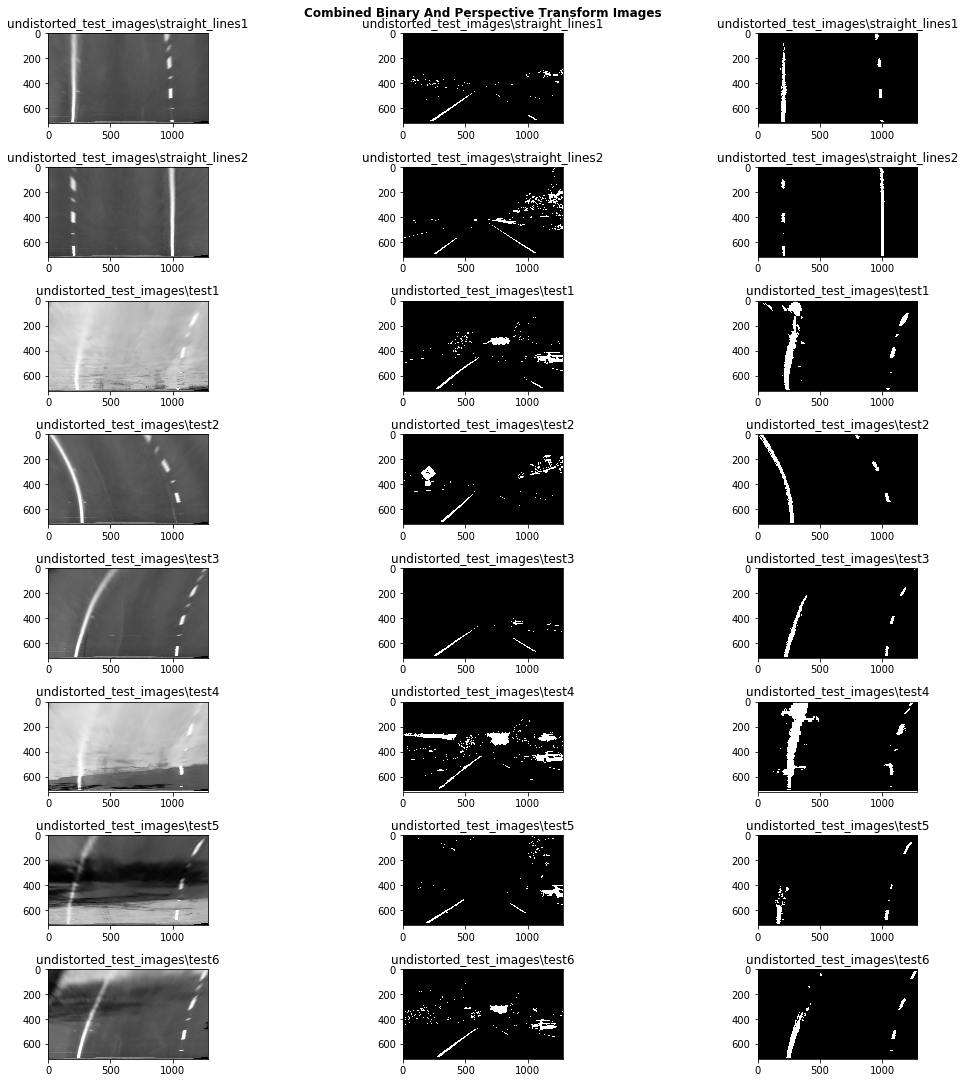

In [70]:
show_image_list(test_imgs_combined_binary_and_psp_tr, test_imgs_combined_binary_and_psp_tr_names, "Combined Binary And Perspective Transform Images", cols=3, fig_size=(15, 15))

The perspective transform, then application of color and gradient thresholding enable us to clearly identify the position of the lanes on the bird's eye view image. However, we also notice some small dots and other visual artifacts. We must build a robust lane finder in order not to be caught by these glitches.

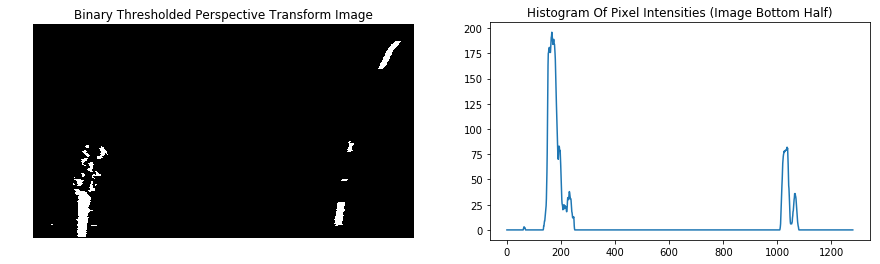

In [71]:
img_example = test_imgs_combined_binary_and_psp_tr[6][2]
histogram = np.sum(img_example[img_example.shape[0]//2:,:], axis=0)

fig, ax = plt.subplots(1, 2, figsize=(15,4))
ax[0].imshow(img_example, cmap='gray')
ax[0].axis("off")
ax[0].set_title("Binary Thresholded Perspective Transform Image")

ax[1].plot(histogram)
ax[1].set_title("Histogram Of Pixel Intensities (Image Bottom Half)")

plt.show()

# Pipeline Definition

Let's now define our full pipeline for lane detection on video frames. We will use Python classes to encapsulate a information and use it across frames. 

In [72]:
from collections import deque

def create_queue(length = 10):
    return deque(maxlen=length)

In [73]:
class LaneLine:
    def __init__(self):
        
        self.polynomial_coeff = None
        self.line_fit_x = None
        self.non_zero_x = []
        self.non_zero_y = []
        self.windows = []

In [74]:
import math

class LaneLineHistory:
    def __init__(self, queue_depth=2, test_points=[50, 300, 500, 700], poly_max_deviation_distance=150):
        self.lane_lines = create_queue(queue_depth)
        self.smoothed_poly = None
        self.test_points = test_points
        self.poly_max_deviation_distance = poly_max_deviation_distance
    
    def append(self, lane_line, force=False):
        if len(self.lane_lines) == 0 or force:
            self.lane_lines.append(lane_line)
            self.get_smoothed_polynomial()
            return True
        
        test_y_smooth = np.asarray(list(map(lambda x: self.smoothed_poly[0] * x**2 + self.smoothed_poly[1] * x + self.smoothed_poly[2], self.test_points)))
        test_y_new = np.asarray(list(map(lambda x: lane_line.polynomial_coeff[0] * x**2 + lane_line.polynomial_coeff[1] * x + lane_line.polynomial_coeff[2], self.test_points)))
        
        dist = np.absolute(test_y_smooth - test_y_new)
        
        #dist = np.absolute(self.smoothed_poly - lane_line.polynomial_coeff)
        #dist_max = np.absolute(self.smoothed_poly * self.poly_max_deviation_distance)
        max_dist = dist[np.argmax(dist)]
        
        if max_dist > self.poly_max_deviation_distance:
            print("**** MAX DISTANCE BREACHED ****")
            print("y_smooth={0} - y_new={1} - distance={2} - max-distance={3}".format(test_y_smooth, test_y_new, max_dist, self.poly_max_deviation_distance))
            return False
        
        self.lane_lines.append(lane_line)
        self.get_smoothed_polynomial()
        
        return True
    
    def get_smoothed_polynomial(self):
        all_coeffs = np.asarray(list(map(lambda lane_line: lane_line.polynomial_coeff, self.lane_lines)))
        self.smoothed_poly = np.mean(all_coeffs, axis=0)
        
        return self.smoothed_poly
                                
        

In [75]:
class AdvancedLaneDetectorWithMemory:
    """
    The AdvancedLaneDetectorWithMemory is a class that can detect lines on the road
    """
    def __init__(self, objpts, imgpts, psp_src, psp_dst, sliding_windows_per_line, 
                 sliding_window_half_width, sliding_window_recenter_thres, 
                 small_img_size=(256, 144), small_img_x_offset=20, small_img_y_offset=10,
                 img_dimensions=(720, 1280), lane_width_px=800, 
                 lane_center_px_psp=600, real_world_lane_size_meters=(32, 3.7)):
        self.objpts = objpts
        self.imgpts = imgpts
        (self.M_psp, self.M_inv_psp) = compute_perspective_transform_matrices(psp_src, psp_dst)

        self.sliding_windows_per_line = sliding_windows_per_line
        self.sliding_window_half_width = sliding_window_half_width
        self.sliding_window_recenter_thres = sliding_window_recenter_thres
        
        self.small_img_size = small_img_size
        self.small_img_x_offset = small_img_x_offset
        self.small_img_y_offset = small_img_y_offset
        
        self.img_dimensions = img_dimensions
        self.lane_width_px = lane_width_px
        self.lane_center_px_psp = lane_center_px_psp 
        self.real_world_lane_size_meters = real_world_lane_size_meters

        # We can pre-compute some data here
        self.ym_per_px = self.real_world_lane_size_meters[0] / self.img_dimensions[0]
        self.xm_per_px = self.real_world_lane_size_meters[1] / self.lane_width_px
        self.ploty = np.linspace(0, self.img_dimensions[0] - 1, self.img_dimensions[0])
        
        self.previous_left_lane_line = None
        self.previous_right_lane_line = None
        
        self.previous_left_lane_lines = LaneLineHistory()
        self.previous_right_lane_lines = LaneLineHistory()
        
        self.total_img_count = 0
        
    
    def process_image(self, img):
        """
        Attempts to find lane lines on the given image and returns an image with lane area colored in green
        as well as small intermediate images overlaid on top to understand how the algorithm is performing
        """
        # First step - undistort the image using the instance's object and image points
        undist_img = undistort_image(img, self.objpts, self.imgpts)
        
        # Produce binary thresholded image from color and gradients
        thres_img = get_combined_binary_thresholded_img(undist_img)
        
        # Create the undistorted and binary perspective transforms
        img_size = (undist_img.shape[1], undist_img.shape[0])
        undist_img_psp = cv2.warpPerspective(undist_img, self.M_psp, img_size, flags=cv2.INTER_LINEAR)
        thres_img_psp = cv2.warpPerspective(thres_img, self.M_psp, img_size, flags=cv2.INTER_LINEAR)
        
        ll, rl = self.compute_lane_lines(thres_img_psp)
        lcr, rcr, lco = self.compute_lane_curvature(ll, rl)

        drawn_lines = self.draw_lane_lines(thres_img_psp, ll, rl)        
        #plt.imshow(drawn_lines)
        
        drawn_lines_regions = self.draw_lane_lines_regions(thres_img_psp, ll, rl)
        #plt.imshow(drawn_lines_regions)
        
        drawn_lane_area = self.draw_lane_area(thres_img_psp, undist_img, ll, rl)        
        #plt.imshow(drawn_lane_area)
        
        drawn_hotspots = self.draw_lines_hotspots(thres_img_psp, ll, rl)
        
        combined_lane_img = self.combine_images(drawn_lane_area, drawn_lines, drawn_lines_regions, drawn_hotspots, undist_img_psp)
        final_img = self.draw_lane_curvature_text(combined_lane_img, lcr, rcr, lco)
        
        self.total_img_count += 1
        self.previous_left_lane_line = ll
        self.previous_right_lane_line = rl
        
        return final_img
    
    def draw_lane_curvature_text(self, img, left_curvature_meters, right_curvature_meters, center_offset_meters):
        """
        Returns an image with curvature information inscribed
        """
        
        offset_y = self.small_img_size[1] * 1 + self.small_img_y_offset * 5
        offset_x = self.small_img_x_offset
        
        template = "{0:17}{1:17}{2:17}"
        txt_header = template.format("Left Curvature", "Right Curvature", "Center Alignment") 
        print(txt_header)
        txt_values = template.format("{:.4f}m".format(left_curvature_meters), 
                                     "{:.4f}m".format(right_curvature_meters),
                                     "{:.4f}m Right".format(center_offset_meters))
        if center_offset_meters < 0.0:
            txt_values = template.format("{:.4f}m".format(left_curvature_meters), 
                                     "{:.4f}m".format(right_curvature_meters),
                                     "{:.4f}m Left".format(math.fabs(center_offset_meters)))
            
        
        print(txt_values)
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(img, txt_header, (offset_x, offset_y), font, 1, (255,255,255), 1, cv2.LINE_AA)
        cv2.putText(img, txt_values, (offset_x, offset_y + self.small_img_y_offset * 5), font, 1, (255,255,255), 2, cv2.LINE_AA)
        
        return img
    
    def combine_images(self, lane_area_img, lines_img, lines_regions_img, lane_hotspots_img, psp_color_img):        
        """
        Returns a new image made up of the lane area image, and the remaining lane images are overlaid as
        small images in a row at the top of the the new image
        """
        small_lines = cv2.resize(lines_img, self.small_img_size)
        small_region = cv2.resize(lines_regions_img, self.small_img_size)
        small_hotspots = cv2.resize(lane_hotspots_img, self.small_img_size)
        small_color_psp = cv2.resize(psp_color_img, self.small_img_size)
                
        lane_area_img[self.small_img_y_offset: self.small_img_y_offset + self.small_img_size[1], self.small_img_x_offset: self.small_img_x_offset + self.small_img_size[0]] = small_lines
        
        start_offset_y = self.small_img_y_offset 
        start_offset_x = 2 * self.small_img_x_offset + self.small_img_size[0]
        lane_area_img[start_offset_y: start_offset_y + self.small_img_size[1], start_offset_x: start_offset_x + self.small_img_size[0]] = small_region
        
        start_offset_y = self.small_img_y_offset 
        start_offset_x = 3 * self.small_img_x_offset + 2 * self.small_img_size[0]
        lane_area_img[start_offset_y: start_offset_y + self.small_img_size[1], start_offset_x: start_offset_x + self.small_img_size[0]] = small_hotspots

        start_offset_y = self.small_img_y_offset 
        start_offset_x = 4 * self.small_img_x_offset + 3 * self.small_img_size[0]
        lane_area_img[start_offset_y: start_offset_y + self.small_img_size[1], start_offset_x: start_offset_x + self.small_img_size[0]] = small_color_psp
        
        
        return lane_area_img
    
        
    def draw_lane_area(self, warped_img, undist_img, left_line, right_line):
        """
        Returns an image where the inside of the lane has been colored in bright green
        """
        # Create an image to draw the lines on
        warp_zero = np.zeros_like(warped_img).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

        ploty = np.linspace(0, warped_img.shape[0] - 1, warped_img.shape[0])
        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_line.line_fit_x, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_line.line_fit_x, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, self.M_inv_psp, (undist_img.shape[1], undist_img.shape[0])) 
        # Combine the result with the original image
        result = cv2.addWeighted(undist_img, 1, newwarp, 0.3, 0)
        
        return result
        
        
    def draw_lane_lines(self, warped_img, left_line, right_line):
        """
        Returns an image where the computed lane lines have been drawn on top of the original warped binary image
        """
        # Create an output image with 3 colors (RGB) from the binary warped image to draw on and  visualize the result
        out_img = np.dstack((warped_img, warped_img, warped_img))*255
        
        # Now draw the lines
        ploty = np.linspace(0, warped_img.shape[0] - 1, warped_img.shape[0])
        pts_left = np.dstack((left_line.line_fit_x, ploty)).astype(np.int32)
        pts_right = np.dstack((right_line.line_fit_x, ploty)).astype(np.int32)

        cv2.polylines(out_img, pts_left, False,  (255, 140,0), 5)
        cv2.polylines(out_img, pts_right, False, (255, 140,0), 5)
        
        for low_pt, high_pt in left_line.windows:
            cv2.rectangle(out_img, low_pt, high_pt, (0, 255, 0), 3)

        for low_pt, high_pt in right_line.windows:            
            cv2.rectangle(out_img, low_pt, high_pt, (0, 255, 0), 3)           
        
        return out_img    
    
    def draw_lane_lines_regions(self, warped_img, left_line, right_line):
        """
        Returns an image where the computed left and right lane areas have been drawn on top of the original warped binary image
        """
        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        margin = self.sliding_window_half_width
        ploty = np.linspace(0, warped_img.shape[0] - 1, warped_img.shape[0])
        
        left_line_window1 = np.array([np.transpose(np.vstack([left_line.line_fit_x - margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_line.line_fit_x + margin, 
                                      ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        
        right_line_window1 = np.array([np.transpose(np.vstack([right_line.line_fit_x - margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_line.line_fit_x + margin, 
                                      ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Create RGB image from binary warped image
        region_img = np.dstack((warped_img, warped_img, warped_img)) * 255

        # Draw the lane onto the warped blank image
        cv2.fillPoly(region_img, np.int_([left_line_pts]), (0, 255, 0))
        cv2.fillPoly(region_img, np.int_([right_line_pts]), (0, 255, 0))
        
        return region_img


    def draw_lines_hotspots(self, warped_img, left_line, right_line):
        """
        Returns a RGB image where the portions of the lane lines that were
        identified by our pipeline are colored in yellow (left) and blue (right)
        """
        out_img = np.dstack((warped_img, warped_img, warped_img))*255
        
        out_img[left_line.non_zero_y, left_line.non_zero_x] = [255, 255, 0]
        out_img[right_line.non_zero_y, right_line.non_zero_x] = [0, 0, 255]
        
        return out_img

    def compute_lane_curvature(self, left_line, right_line):
        """
        Returns the triple (left_curvature, right_curvature, lane_center_offset), which are all in meters
        """        
        ploty = self.ploty
        y_eval = np.max(ploty)
        # Define conversions in x and y from pixels space to meters
        
        leftx = left_line.line_fit_x
        rightx = right_line.line_fit_x
        
        # Fit new polynomials: find x for y in real-world space
        left_fit_cr = np.polyfit(ploty * self.ym_per_px, leftx * self.xm_per_px, 2)
        right_fit_cr = np.polyfit(ploty * self.ym_per_px, rightx * self.xm_per_px, 2)
        
        # Now calculate the radii of the curvature
        left_curverad = ((1 + (2 * left_fit_cr[0] * y_eval * self.ym_per_px + left_fit_cr[1])**2)**1.5) / np.absolute(2 * left_fit_cr[0])
        right_curverad = ((1 + (2 *right_fit_cr[0] * y_eval * self.ym_per_px + right_fit_cr[1])**2)**1.5) / np.absolute(2 * right_fit_cr[0])
        
        # Use our computed polynomial to determine the car's center position in image space, then
        left_fit = left_line.polynomial_coeff
        right_fit = right_line.polynomial_coeff
        
        center_offset_img_space = (((left_fit[0] * y_eval**2 + left_fit[1] * y_eval + left_fit[2]) + 
                   (right_fit[0] * y_eval**2 + right_fit[1] * y_eval + right_fit[2])) / 2) - self.lane_center_px_psp
        center_offset_real_world_m = center_offset_img_space * self.xm_per_px
        
        # Now our radius of curvature is in meters        
        return left_curverad, right_curverad, center_offset_real_world_m
        
        
        
    def compute_lane_lines(self, warped_img):
        """
        Returns the tuple (left_lane_line, right_lane_line) which represents respectively the LaneLine instances for
        the computed left and right lanes, for the supplied binary warped image
        """

        # Take a histogram of the bottom half of the image, summing pixel values column wise 
        histogram = np.sum(warped_img[warped_img.shape[0]//2:,:], axis=0)
        
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines 
        midpoint = np.int(histogram.shape[0]//2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint # don't forget to offset by midpoint!
        

        # Set height of windows
        window_height = np.int(warped_img.shape[0]//self.sliding_windows_per_line)
        # Identify the x and y positions of all nonzero pixels in the image
        # NOTE: nonzero returns a tuple of arrays in y and x directions
        nonzero = warped_img.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        total_non_zeros = len(nonzeroy)
        non_zero_found_pct = 0.0
        
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base    


        # Set the width of the windows +/- margin
        margin = self.sliding_window_half_width
        # Set minimum number of pixels found to recenter window
        minpix = self.sliding_window_recenter_thres
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []
        
        # Our lane line objects we store the result of this computation
        left_line = LaneLine()
        right_line = LaneLine()
                        
        if self.previous_left_lane_line is not None and self.previous_right_lane_line is not None:
            # We have already computed the lane lines polynomials from a previous image
            left_lane_inds = ((nonzerox > (self.previous_left_lane_line.polynomial_coeff[0] * (nonzeroy**2) 
                                           + self.previous_left_lane_line.polynomial_coeff[1] * nonzeroy 
                                           + self.previous_left_lane_line.polynomial_coeff[2] - margin)) 
                              & (nonzerox < (self.previous_left_lane_line.polynomial_coeff[0] * (nonzeroy**2) 
                                            + self.previous_left_lane_line.polynomial_coeff[1] * nonzeroy 
                                            + self.previous_left_lane_line.polynomial_coeff[2] + margin))) 

            right_lane_inds = ((nonzerox > (self.previous_right_lane_line.polynomial_coeff[0] * (nonzeroy**2) 
                                           + self.previous_right_lane_line.polynomial_coeff[1] * nonzeroy 
                                           + self.previous_right_lane_line.polynomial_coeff[2] - margin)) 
                              & (nonzerox < (self.previous_right_lane_line.polynomial_coeff[0] * (nonzeroy**2) 
                                            + self.previous_right_lane_line.polynomial_coeff[1] * nonzeroy 
                                            + self.previous_right_lane_line.polynomial_coeff[2] + margin))) 
            
            non_zero_found_left = np.sum(left_lane_inds)
            non_zero_found_right = np.sum(right_lane_inds)
            non_zero_found_pct = (non_zero_found_left + non_zero_found_right) / total_non_zeros
           
            print("[Previous lane] Found pct={0}".format(non_zero_found_pct))
            #print(left_lane_inds)
        
        if non_zero_found_pct < 0.85:
            print("Non zeros found below thresholds, begining sliding window - pct={0}".format(non_zero_found_pct))
            left_lane_inds = []
            right_lane_inds = []

            # Step through the windows one by one
            for window in range(self.sliding_windows_per_line):
                # Identify window boundaries in x and y (and right and left)
                # We are moving our windows from the bottom to the top of the screen (highest to lowest y value)
                win_y_low = warped_img.shape[0] - (window + 1)* window_height
                win_y_high = warped_img.shape[0] - window * window_height

                # Defining our window's coverage in the horizontal (i.e. x) direction 
                # Notice that the window's width is twice the margin
                win_xleft_low = leftx_current - margin
                win_xleft_high = leftx_current + margin
                win_xright_low = rightx_current - margin
                win_xright_high = rightx_current + margin

                left_line.windows.append([(win_xleft_low,win_y_low),(win_xleft_high,win_y_high)])
                right_line.windows.append([(win_xright_low,win_y_low),(win_xright_high,win_y_high)])

                # Super crytic and hard to understand...
                # Basically nonzerox and nonzeroy have the same size and any nonzero pixel is identified by
                # (nonzeroy[i],nonzerox[i]), therefore we just return the i indices within the window that are nonzero
                # and can then index into nonzeroy and nonzerox to find the ACTUAL pixel coordinates that are not zero
                good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
                good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
                            
                # Append these indices to the lists
                left_lane_inds.append(good_left_inds)
                right_lane_inds.append(good_right_inds)

                # If you found > minpix pixels, recenter next window on their mean position
                if len(good_left_inds) > minpix:
                    leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
                if len(good_right_inds) > minpix:        
                    rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

            # Concatenate the arrays of indices since we now have a list of multiple arrays (e.g. ([1,3,6],[8,5,2]))
            # We want to create a single array with elements from all those lists (e.g. [1,3,6,8,5,2])
            # These are the indices that are non zero in our sliding windows
            left_lane_inds = np.concatenate(left_lane_inds)
            right_lane_inds = np.concatenate(right_lane_inds)
            
            non_zero_found_left = np.sum(left_lane_inds)
            non_zero_found_right = np.sum(right_lane_inds)
            non_zero_found_pct = (non_zero_found_left + non_zero_found_right) / total_non_zeros
           
            print("[Sliding windows] Found pct={0}".format(non_zero_found_pct))
            
    
        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 
        
        #print("[LEFT] Number of hot pixels={0}".format(len(leftx)))
        #print("[RIGHT] Number of hot pixels={0}".format(len(rightx)))
        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        #print("Poly left {0}".format(left_fit))
        #print("Poly right {0}".format(right_fit))
        left_line.polynomial_coeff = left_fit
        right_line.polynomial_coeff = right_fit
        
        if not self.previous_left_lane_lines.append(left_line):
            left_fit = self.previous_left_lane_lines.get_smoothed_polynomial()
            left_line.polynomial_coeff = left_fit
            self.previous_left_lane_lines.append(left_line, force=True)
            print("**** REVISED Poly left {0}".format(left_fit))            
        #else:
            #left_fit = self.previous_left_lane_lines.get_smoothed_polynomial()
            #left_line.polynomial_coeff = left_fit


        if not self.previous_right_lane_lines.append(right_line):
            right_fit = self.previous_right_lane_lines.get_smoothed_polynomial()
            right_line.polynomial_coeff = right_fit
            self.previous_right_lane_lines.append(right_line, force=True)
            print("**** REVISED Poly right {0}".format(right_fit))
        #else:
            #right_fit = self.previous_right_lane_lines.get_smoothed_polynomial()
            #right_line.polynomial_coeff = right_fit


    
        # Generate x and y values for plotting
        ploty = np.linspace(0, warped_img.shape[0] - 1, warped_img.shape[0] )
        left_fitx = left_fit[0] * ploty**2 + left_fit[1] * ploty + left_fit[2]
        right_fitx = right_fit[0] * ploty**2 + right_fit[1] * ploty + right_fit[2]
        
        
        left_line.polynomial_coeff = left_fit
        left_line.line_fit_x = left_fitx
        left_line.non_zero_x = leftx  
        left_line.non_zero_y = lefty

        right_line.polynomial_coeff = right_fit
        right_line.line_fit_x = right_fitx
        right_line.non_zero_x = rightx
        right_line.non_zero_y = righty

        
        return (left_line, right_line)

In [76]:
ld = AdvancedLaneDetectorWithMemory(opts, ipts, src_pts, dst_pts, 20, 100, 50)

In [77]:
proc_img = ld.process_image(test_img)

Non zeros found below thresholds, begining sliding window - pct=0.0
[Sliding windows] Found pct=10819.0
Left Curvature   Right Curvature  Center Alignment 
938.3232m        775.0917m        0.2269m Right    


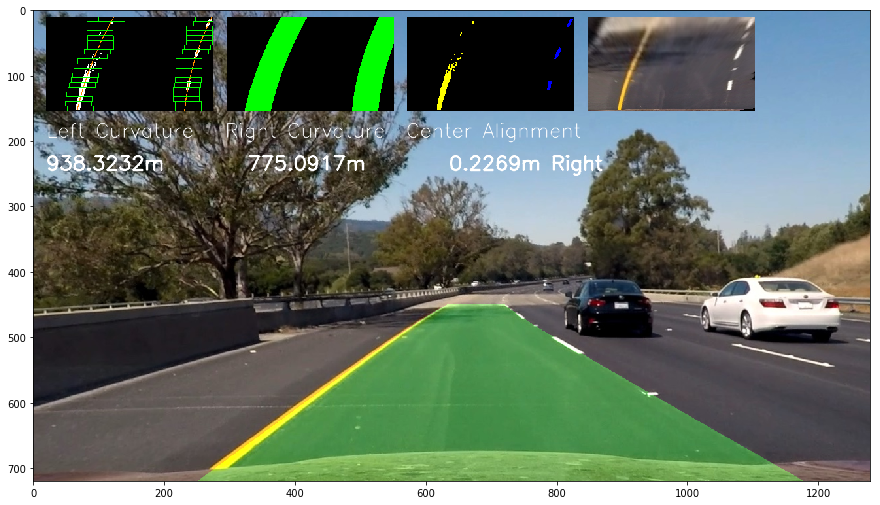

In [78]:
plt.figure(figsize=(15,10))
plt.imshow(proc_img)

In [79]:
#(720, 1280, 3)

# Normal video

In [80]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


In [81]:
project_video_path = "project_video.mp4"
challenge_video_path = "challenge_video.mp4"
project_video_output_path = 'output_videos/lanes_project_video.mp4'
project_video_sample_path = 'project_video_sample.mp4'
challenge_video_sample_path = 'challenge_video_sample.mp4'

project_video_sample_output_path = 'output_videos/lanes_project_video_sample.mp4'
challenge_video_sample_output_path = 'output_videos/lanes_challenge_video_sample.mp4'

In [82]:
from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip
ffmpeg_extract_subclip(project_video_path, 22, 27, targetname=project_video_sample_path)

Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful


In [83]:
detector = AdvancedLaneDetectorWithMemory(opts, ipts, src_pts, dst_pts, 20, 50, 10)

clip1 = VideoFileClip(project_video_sample_path)
project_video_clip = clip1.fl_image(detector.process_image) #NOTE: this function expects color images!!
%time project_video_clip.write_videofile(project_video_sample_output_path, audio=False)

Non zeros found below thresholds, begining sliding window - pct=0.0
[Sliding windows] Found pct=10770.5
Left Curvature   Right Curvature  Center Alignment 
60749.1295m      1288.9199m       0.0943m Right    
Moviepy - Building video output_videos/lanes_project_video_sample.mp4.
Moviepy - Writing video output_videos/lanes_project_video_sample.mp4



t:   0%|                                                                             | 0/125 [00:00<?, ?it/s, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
60749.1295m      1288.9199m       0.0943m Right    


t:   2%|█                                                                    | 2/125 [00:01<01:34,  1.31it/s, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
60749.1295m      1288.9199m       0.0943m Right    


t:   2%|█▋                                                                   | 3/125 [00:03<02:00,  1.01it/s, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
60749.1295m      1288.9199m       0.0943m Right    


t:   3%|██▏                                                                  | 4/125 [00:04<02:19,  1.16s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
60749.1295m      1288.9199m       0.0943m Right    


t:   4%|██▊                                                                  | 5/125 [00:06<02:32,  1.27s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
60749.1295m      1288.9199m       0.0943m Right    


t:   5%|███▎                                                                 | 6/125 [00:07<02:39,  1.34s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
60749.1295m      1288.9199m       0.0943m Right    


t:   6%|███▊                                                                 | 7/125 [00:09<02:45,  1.40s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
60749.1295m      1288.9199m       0.0943m Right    


t:   6%|████▍                                                                | 8/125 [00:10<02:47,  1.43s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
60749.1295m      1288.9199m       0.0943m Right    


t:   7%|████▉                                                                | 9/125 [00:12<02:47,  1.45s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
60749.1295m      1288.9199m       0.0943m Right    


t:   8%|█████▍                                                              | 10/125 [00:13<02:49,  1.47s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
60749.1295m      1288.9199m       0.0943m Right    


t:   9%|█████▉                                                              | 11/125 [00:15<02:49,  1.49s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
60749.1295m      1288.9199m       0.0943m Right    


t:  10%|██████▌                                                             | 12/125 [00:16<02:50,  1.50s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
60749.1295m      1288.9199m       0.0943m Right    


t:  10%|███████                                                             | 13/125 [00:18<02:48,  1.51s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
60749.1295m      1288.9199m       0.0943m Right    


t:  11%|███████▌                                                            | 14/125 [00:19<02:47,  1.51s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
60749.1295m      1288.9199m       0.0943m Right    


t:  12%|████████▏                                                           | 15/125 [00:21<02:46,  1.51s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
60749.1295m      1288.9199m       0.0943m Right    


t:  13%|████████▋                                                           | 16/125 [00:22<02:44,  1.51s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
60749.1295m      1288.9199m       0.0943m Right    


t:  14%|█████████▏                                                          | 17/125 [00:24<02:44,  1.52s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
60749.1295m      1288.9199m       0.0943m Right    


t:  14%|█████████▊                                                          | 18/125 [00:25<02:43,  1.53s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
60749.1295m      1288.9199m       0.0943m Right    


t:  15%|██████████▎                                                         | 19/125 [00:27<02:40,  1.52s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
60749.1295m      1288.9199m       0.0943m Right    


t:  16%|██████████▉                                                         | 20/125 [00:28<02:40,  1.53s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
60749.1295m      1288.9199m       0.0943m Right    


t:  17%|███████████▍                                                        | 21/125 [00:30<02:38,  1.52s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
60749.1295m      1288.9199m       0.0943m Right    


t:  18%|███████████▉                                                        | 22/125 [00:31<02:36,  1.51s/it, now=None]

[Previous lane] Found pct=0.9996128157971155
Left Curvature   Right Curvature  Center Alignment 
12246.7608m      1273.4474m       0.1035m Right    


t:  18%|████████████▌                                                       | 23/125 [00:33<02:33,  1.50s/it, now=None]

[Previous lane] Found pct=0.999800369316764
Left Curvature   Right Curvature  Center Alignment 
8622.0394m       1269.4106m       0.1056m Right    


t:  19%|█████████████                                                       | 24/125 [00:34<02:32,  1.51s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
4839.5792m       1204.1247m       0.1180m Right    


t:  20%|█████████████▌                                                      | 25/125 [00:36<02:31,  1.51s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
3327.3243m       1216.2587m       0.1261m Right    


t:  21%|██████████████▏                                                     | 26/125 [00:37<02:28,  1.50s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
3124.0314m       1764.8156m       0.1406m Right    


t:  22%|██████████████▋                                                     | 27/125 [00:39<02:26,  1.50s/it, now=None]

[Previous lane] Found pct=0.9996813866054929
Left Curvature   Right Curvature  Center Alignment 
1310.4948m       2294.4675m       0.2022m Right    


t:  22%|███████████████▏                                                    | 28/125 [00:40<02:24,  1.49s/it, now=None]

[Previous lane] Found pct=0.9997382027619609
Left Curvature   Right Curvature  Center Alignment 
1412.2094m       1390.0851m       0.2073m Right    


t:  23%|███████████████▊                                                    | 29/125 [00:42<02:22,  1.48s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
3659.1545m       1295.0233m       0.1917m Right    


t:  24%|████████████████▎                                                   | 30/125 [00:43<02:19,  1.47s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
2885.5394m       1530.7494m       0.1852m Right    


t:  25%|████████████████▊                                                   | 31/125 [00:45<02:19,  1.49s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
9142.5600m       1177.5249m       0.1900m Right    


t:  26%|█████████████████▍                                                  | 32/125 [00:46<02:18,  1.49s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
3178.5328m       1315.0609m       0.1723m Right    


t:  26%|█████████████████▉                                                  | 33/125 [00:48<02:15,  1.48s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
29628.5730m      1394.8368m       0.1571m Right    


t:  27%|██████████████████▍                                                 | 34/125 [00:49<02:15,  1.48s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
2264.5418m       1420.2821m       0.1450m Right    


t:  28%|███████████████████                                                 | 35/125 [00:51<02:14,  1.49s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
7126.9237m       1447.9116m       0.1346m Right    


t:  29%|███████████████████▌                                                | 36/125 [00:52<02:11,  1.48s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
2980.5907m       1262.2898m       0.1425m Right    


t:  30%|████████████████████▏                                               | 37/125 [00:54<02:14,  1.53s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
3404.4530m       1149.9098m       0.1356m Right    


t:  30%|████████████████████▋                                               | 38/125 [00:56<02:17,  1.58s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
2329.1917m       1052.6774m       0.1354m Right    


t:  31%|█████████████████████▏                                              | 39/125 [00:57<02:21,  1.65s/it, now=None]

[Previous lane] Found pct=0.9999121882683526
Left Curvature   Right Curvature  Center Alignment 
3418.6620m       575.6789m        0.1708m Right    


t:  32%|█████████████████████▊                                              | 40/125 [00:59<02:22,  1.68s/it, now=None]

[Previous lane] Found pct=0.9996656916005014
Left Curvature   Right Curvature  Center Alignment 
2032.0520m       644.1408m        0.1597m Right    


t:  33%|██████████████████████▎                                             | 41/125 [01:01<02:17,  1.64s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
1168.4100m       626.4996m        0.1409m Right    


t:  34%|██████████████████████▊                                             | 42/125 [01:02<02:12,  1.59s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
1048.1207m       764.5008m        0.1182m Right    


t:  34%|███████████████████████▍                                            | 43/125 [01:04<02:07,  1.55s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
953.1498m        1058.8219m       0.0927m Right    


t:  35%|███████████████████████▉                                            | 44/125 [01:05<02:05,  1.55s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
821.2456m        1056.9110m       0.0823m Right    


t:  36%|████████████████████████▍                                           | 45/125 [01:07<02:02,  1.53s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
734.2881m        1344.0318m       0.0752m Right    


t:  37%|█████████████████████████                                           | 46/125 [01:08<01:59,  1.52s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
1223.7661m       1348.9810m       0.0787m Right    


t:  38%|█████████████████████████▌                                          | 47/125 [01:10<01:58,  1.52s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
2305.2193m       1214.4061m       0.0812m Right    


t:  38%|██████████████████████████                                          | 48/125 [01:11<01:56,  1.52s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
1873.1470m       1231.5219m       0.0733m Right    


t:  39%|██████████████████████████▋                                         | 49/125 [01:13<01:59,  1.57s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
4314.9884m       1176.7670m       0.0688m Right    


t:  40%|███████████████████████████▏                                        | 50/125 [01:15<02:03,  1.65s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
6899.9065m       1069.3059m       0.0708m Right    


t:  41%|███████████████████████████▋                                        | 51/125 [01:16<01:58,  1.60s/it, now=None]

[Previous lane] Found pct=0.9999268845507056
Left Curvature   Right Curvature  Center Alignment 
1434.0442m       825.2333m        0.0998m Right    


t:  42%|████████████████████████████▎                                       | 52/125 [01:18<01:56,  1.59s/it, now=None]

[Previous lane] Found pct=0.9997798972853998
Left Curvature   Right Curvature  Center Alignment 
1193.2717m       672.3154m        0.1171m Right    


t:  42%|████████████████████████████▊                                       | 53/125 [01:19<01:52,  1.56s/it, now=None]

[Previous lane] Found pct=0.9997749774977498
Left Curvature   Right Curvature  Center Alignment 
1620.2356m       810.3863m        0.0849m Right    


t:  43%|█████████████████████████████▍                                      | 54/125 [01:21<01:48,  1.53s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
1171.5034m       721.6548m        0.0855m Right    


t:  44%|█████████████████████████████▉                                      | 55/125 [01:22<01:45,  1.51s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
854.0021m        542.0933m        0.0852m Right    


t:  45%|██████████████████████████████▍                                     | 56/125 [01:24<01:45,  1.52s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
984.6924m        431.6528m        0.0706m Right    


t:  46%|███████████████████████████████                                     | 57/125 [01:25<01:42,  1.51s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
1355.3732m       415.0525m        0.0519m Right    


t:  46%|███████████████████████████████▌                                    | 58/125 [01:27<01:41,  1.52s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
782.2108m        432.1095m        0.0342m Right    


t:  47%|████████████████████████████████                                    | 59/125 [01:28<01:40,  1.52s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
1100.8936m       433.1090m        0.0152m Right    


t:  48%|████████████████████████████████▋                                   | 60/125 [01:30<01:40,  1.55s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
21967.4845m      436.9220m        0.0001m Left     


t:  49%|█████████████████████████████████▏                                  | 61/125 [01:31<01:39,  1.55s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
2539.2962m       437.3072m        0.0128m Left     


t:  50%|█████████████████████████████████▋                                  | 62/125 [01:33<01:36,  1.53s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
2812.0843m       424.4023m        0.0128m Left     


t:  50%|██████████████████████████████████▎                                 | 63/125 [01:34<01:33,  1.51s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
3550.0373m       384.2212m        0.0102m Left     


t:  51%|██████████████████████████████████▊                                 | 64/125 [01:36<01:32,  1.51s/it, now=None]

[Previous lane] Found pct=0.9956475583864118
Left Curvature   Right Curvature  Center Alignment 
632.6906m        447.3735m        0.0424m Left     


t:  52%|███████████████████████████████████▎                                | 65/125 [01:37<01:30,  1.51s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
487.6354m        393.1346m        0.0329m Left     


t:  53%|███████████████████████████████████▉                                | 66/125 [01:39<01:28,  1.49s/it, now=None]

[Previous lane] Found pct=1.0
**** MAX DISTANCE BREACHED ****
y_smooth=[280.9840031  200.81209254 171.57577051 173.36274307] - y_new=[487.92928473 269.34816415 181.94871266 172.29632335] - distance=206.94528162352714 - max-distance=150
**** REVISED Poly left [ 3.87791182e-04 -4.56414556e-01  3.02835253e+02]
Left Curvature   Right Curvature  Center Alignment 
550.7666m        469.9823m        0.0591m Left     


t:  54%|████████████████████████████████████▍                               | 67/125 [01:40<01:27,  1.50s/it, now=None]

[Previous lane] Found pct=0.9988296108456062
**** MAX DISTANCE BREACHED ****
y_smooth=[286.75591413 201.70346853 170.82303102 172.97505481] - y_new=[500.54107664 279.57157041 187.76551899 171.48795962] - distance=213.7851625060149 - max-distance=150
**** REVISED Poly left [ 4.12905766e-04 -4.84726801e-01  3.09959990e+02]
Left Curvature   Right Curvature  Center Alignment 
517.2805m        600.5425m        0.0961m Left     


t:  54%|████████████████████████████████████▉                               | 68/125 [01:42<01:24,  1.49s/it, now=None]

[Previous lane] Found pct=0.9962227602905569
**** MAX DISTANCE BREACHED ****
y_smooth=[283.86995862 201.25778054 171.19940077 173.16889894] - y_new=[554.47851344 298.56706456 191.23098206 170.46652319] - distance=270.60855481825183 - max-distance=150
**** REVISED Poly left [ 4.00348474e-04 -4.70570678e-01  3.06397621e+02]
Left Curvature   Right Curvature  Center Alignment 
533.4983m        574.0027m        0.0907m Left     


t:  55%|█████████████████████████████████████▌                              | 69/125 [01:43<01:23,  1.49s/it, now=None]

[Previous lane] Found pct=0.9826921174957967
**** MAX DISTANCE BREACHED ****
y_smooth=[285.31293638 201.48062454 171.01121589 173.07197687] - y_new=[481.99850955 289.52021162 200.95260231 170.53168549] - distance=196.68557317135264 - max-distance=150
**** REVISED Poly left [ 4.06627120e-04 -4.77648739e-01  3.08178806e+02]
Left Curvature   Right Curvature  Center Alignment 
525.2642m        504.8659m        0.0893m Left     


t:  56%|██████████████████████████████████████                              | 70/125 [01:45<01:22,  1.51s/it, now=None]

[Previous lane] Found pct=0.988859827569505
Left Curvature   Right Curvature  Center Alignment 
496.5837m        612.9608m        0.1174m Left     


t:  57%|██████████████████████████████████████▌                             | 71/125 [01:46<01:21,  1.51s/it, now=None]

[Previous lane] Found pct=0.9999048796727861
Left Curvature   Right Curvature  Center Alignment 
1061.6698m       677.8065m        0.1294m Left     


t:  58%|███████████████████████████████████████▏                            | 72/125 [01:48<01:19,  1.50s/it, now=None]

[Previous lane] Found pct=0.9999080544317764
Left Curvature   Right Curvature  Center Alignment 
1939.0971m       726.5204m        0.1264m Left     


t:  58%|███████████████████████████████████████▋                            | 73/125 [01:49<01:18,  1.51s/it, now=None]

[Previous lane] Found pct=0.9980102330869812
Left Curvature   Right Curvature  Center Alignment 
656.2311m        845.8397m        0.1072m Left     


t:  59%|████████████████████████████████████████▎                           | 74/125 [01:51<01:17,  1.51s/it, now=None]

[Previous lane] Found pct=0.99972444199504
Left Curvature   Right Curvature  Center Alignment 
988.1556m        830.9667m        0.0992m Left     


t:  60%|████████████████████████████████████████▊                           | 75/125 [01:52<01:15,  1.51s/it, now=None]

[Previous lane] Found pct=0.9726242049958521
Left Curvature   Right Curvature  Center Alignment 
510.8278m        735.0935m        0.0709m Left     


t:  61%|█████████████████████████████████████████▎                          | 76/125 [01:54<01:14,  1.52s/it, now=None]

[Previous lane] Found pct=0.9993682880606444
**** MAX DISTANCE BREACHED ****
y_smooth=[435.09347363 304.28797492 228.19501528 177.48111281] - y_new=[651.76776251 380.24475162 248.31518144 192.19791217] - distance=216.67428887470084 - max-distance=150
**** REVISED Poly left [ 3.17238215e-04 -6.34255370e-01  4.66013147e+02]
Left Curvature   Right Curvature  Center Alignment 
673.4903m        605.1896m        0.0779m Left     


t:  62%|█████████████████████████████████████████▉                          | 77/125 [01:55<01:12,  1.51s/it, now=None]

[Previous lane] Found pct=0.9721896162528216
**** MAX DISTANCE BREACHED ****
y_smooth=[461.46030748 316.65755262 233.91282058 180.58806352] - y_new=[658.83249408 383.86792278 250.37486595 193.75167597] - distance=197.37218659157026 - max-distance=150
**** REVISED Poly left [ 3.67749687e-04 -7.07923410e-01  4.95937104e+02]
Left Curvature   Right Curvature  Center Alignment 
580.9880m        537.6439m        0.0637m Left     


t:  62%|██████████████████████████████████████████▍                         | 78/125 [01:57<01:10,  1.50s/it, now=None]

[Previous lane] Found pct=0.9465553636538092
**** MAX DISTANCE BREACHED ****
y_smooth=[448.27689056 310.47276377 231.05391793 179.03458816] - y_new=[686.41729546 405.67614997 265.12867045 199.28824592] - distance=238.14040489931045 - max-distance=150
**** REVISED Poly left [ 3.42493951e-04 -6.71089390e-01  4.80975125e+02]
Left Curvature   Right Curvature  Center Alignment 
623.8286m        498.1003m        0.0659m Left     


t:  63%|██████████████████████████████████████████▉                         | 79/125 [01:58<01:09,  1.51s/it, now=None]

[Previous lane] Found pct=0.9494177922682813
**** MAX DISTANCE BREACHED ****
y_smooth=[454.86859902 313.5651582  232.48336925 179.81132584] - y_new=[632.45551352 390.2100829  263.38105615 196.07853407] - distance=177.58691450350932 - max-distance=150
**** REVISED Poly left [ 3.55121819e-04 -6.89506400e-01  4.88456114e+02]
Left Curvature   Right Curvature  Center Alignment 
601.6466m        374.8754m        0.0018m Right    


t:  64%|███████████████████████████████████████████▌                        | 80/125 [02:00<01:07,  1.50s/it, now=None]

[Previous lane] Found pct=0.9915845155085357
Left Curvature   Right Curvature  Center Alignment 
324.3921m        462.2647m        0.0313m Right    


t:  65%|████████████████████████████████████████████                        | 81/125 [02:01<01:05,  1.50s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
358.0519m        578.6418m        0.0140m Right    


t:  66%|████████████████████████████████████████████▌                       | 82/125 [02:03<01:04,  1.50s/it, now=None]

[Previous lane] Found pct=0.9947006194081212
Left Curvature   Right Curvature  Center Alignment 
411.2344m        727.2064m        0.0013m Left     


t:  66%|█████████████████████████████████████████████▏                      | 83/125 [02:04<01:02,  1.50s/it, now=None]

[Previous lane] Found pct=0.9999331997327989
Left Curvature   Right Curvature  Center Alignment 
393.3165m        679.3139m        0.0057m Left     


t:  67%|█████████████████████████████████████████████▋                      | 84/125 [02:06<01:01,  1.49s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
353.3950m        560.9017m        0.0022m Right    


t:  68%|██████████████████████████████████████████████▏                     | 85/125 [02:07<00:59,  1.50s/it, now=None]

[Previous lane] Found pct=0.9992597079211253
Left Curvature   Right Curvature  Center Alignment 
395.4729m        510.4619m        0.0006m Left     


t:  69%|██████████████████████████████████████████████▊                     | 86/125 [02:10<01:05,  1.68s/it, now=None]

[Previous lane] Found pct=0.9962523848460071
Left Curvature   Right Curvature  Center Alignment 
354.8709m        426.1940m        0.0112m Right    


t:  70%|███████████████████████████████████████████████▎                    | 87/125 [02:11<01:02,  1.64s/it, now=None]

[Previous lane] Found pct=0.9971553778734528
Left Curvature   Right Curvature  Center Alignment 
400.5537m        356.0848m        0.0227m Right    


t:  70%|███████████████████████████████████████████████▊                    | 88/125 [02:13<00:58,  1.58s/it, now=None]

[Previous lane] Found pct=0.9998577423714347
Left Curvature   Right Curvature  Center Alignment 
363.0578m        369.4365m        0.0336m Right    


t:  71%|████████████████████████████████████████████████▍                   | 89/125 [02:14<00:56,  1.56s/it, now=None]

[Previous lane] Found pct=0.9999303281543928
Left Curvature   Right Curvature  Center Alignment 
434.6371m        388.6717m        0.0438m Right    


t:  72%|████████████████████████████████████████████████▉                   | 90/125 [02:16<00:54,  1.55s/it, now=None]

[Previous lane] Found pct=0.9989566351483534
Left Curvature   Right Curvature  Center Alignment 
460.6151m        450.0953m        0.0571m Right    


t:  73%|█████████████████████████████████████████████████▌                  | 91/125 [02:17<00:51,  1.52s/it, now=None]

[Previous lane] Found pct=0.9940073243813118
Left Curvature   Right Curvature  Center Alignment 
580.2609m        573.8540m        0.0589m Right    


t:  74%|██████████████████████████████████████████████████                  | 92/125 [02:19<00:49,  1.51s/it, now=None]

[Previous lane] Found pct=0.9998893315626384
Left Curvature   Right Curvature  Center Alignment 
1102.8538m       538.8281m        0.0672m Right    


t:  74%|██████████████████████████████████████████████████▌                 | 93/125 [02:20<00:48,  1.52s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
1112.7898m       538.6808m        0.0729m Right    


t:  75%|███████████████████████████████████████████████████▏                | 94/125 [02:22<00:47,  1.52s/it, now=None]

[Previous lane] Found pct=0.9998944089541207
Left Curvature   Right Curvature  Center Alignment 
1276.7152m       492.5705m        0.0845m Right    


t:  76%|███████████████████████████████████████████████████▋                | 95/125 [02:23<00:45,  1.51s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
1154.3523m       465.8243m        0.0953m Right    


t:  77%|████████████████████████████████████████████████████▏               | 96/125 [02:25<00:44,  1.54s/it, now=None]

[Previous lane] Found pct=0.9998809452943628
Left Curvature   Right Curvature  Center Alignment 
1056.0819m       449.0304m        0.1026m Right    


t:  78%|████████████████████████████████████████████████████▊               | 97/125 [02:26<00:42,  1.51s/it, now=None]

[Previous lane] Found pct=0.9998805684939687
Left Curvature   Right Curvature  Center Alignment 
1118.0445m       445.3595m        0.1056m Right    


t:  78%|█████████████████████████████████████████████████████▎              | 98/125 [02:28<00:40,  1.52s/it, now=None]

[Previous lane] Found pct=0.9998917162966974
Left Curvature   Right Curvature  Center Alignment 
1147.7319m       470.5303m        0.1073m Right    


t:  79%|█████████████████████████████████████████████████████▊              | 99/125 [02:29<00:39,  1.52s/it, now=None]

[Previous lane] Found pct=0.9998914695029303
Left Curvature   Right Curvature  Center Alignment 
1564.3391m       484.1597m        0.1064m Right    


t:  80%|█████████████████████████████████████████████████████▌             | 100/125 [02:31<00:38,  1.53s/it, now=None]

[Previous lane] Found pct=0.9998975724674792
Left Curvature   Right Curvature  Center Alignment 
1679.5993m       508.1112m        0.1103m Right    


t:  81%|██████████████████████████████████████████████████████▏            | 101/125 [02:32<00:36,  1.52s/it, now=None]

[Previous lane] Found pct=0.9998511609446319
Left Curvature   Right Curvature  Center Alignment 
1827.4022m       516.9175m        0.1147m Right    


t:  82%|██████████████████████████████████████████████████████▋            | 102/125 [02:34<00:35,  1.53s/it, now=None]

[Previous lane] Found pct=0.9997524997524998
Left Curvature   Right Curvature  Center Alignment 
1240.1686m       525.6984m        0.1191m Right    


t:  82%|███████████████████████████████████████████████████████▏           | 103/125 [02:35<00:33,  1.52s/it, now=None]

[Previous lane] Found pct=0.9997393253740681
Left Curvature   Right Curvature  Center Alignment 
1428.5714m       527.4994m        0.1221m Right    


t:  83%|███████████████████████████████████████████████████████▋           | 104/125 [02:37<00:31,  1.51s/it, now=None]

[Previous lane] Found pct=0.9998951507208388
Left Curvature   Right Curvature  Center Alignment 
1005.3267m       562.3870m        0.1253m Right    


t:  84%|████████████████████████████████████████████████████████▎          | 105/125 [02:38<00:30,  1.52s/it, now=None]

[Previous lane] Found pct=0.9998377413597274
Left Curvature   Right Curvature  Center Alignment 
827.9759m        541.9091m        0.1406m Right    


t:  85%|████████████████████████████████████████████████████████▊          | 106/125 [02:40<00:28,  1.52s/it, now=None]

[Previous lane] Found pct=0.9998344644926337
Left Curvature   Right Curvature  Center Alignment 
709.8800m        580.9574m        0.1459m Right    


t:  86%|█████████████████████████████████████████████████████████▎         | 107/125 [02:41<00:27,  1.51s/it, now=None]

[Previous lane] Found pct=0.9998906087622381
Left Curvature   Right Curvature  Center Alignment 
583.1046m        566.5237m        0.1576m Right    


t:  86%|█████████████████████████████████████████████████████████▉         | 108/125 [02:43<00:25,  1.52s/it, now=None]

[Previous lane] Found pct=0.9998283163557286
Left Curvature   Right Curvature  Center Alignment 
538.0974m        581.7982m        0.1598m Right    


t:  87%|██████████████████████████████████████████████████████████▍        | 109/125 [02:44<00:24,  1.52s/it, now=None]

[Previous lane] Found pct=0.99983015342807
Left Curvature   Right Curvature  Center Alignment 
503.1499m        642.2455m        0.1547m Right    


t:  88%|██████████████████████████████████████████████████████████▉        | 110/125 [02:46<00:22,  1.50s/it, now=None]

[Previous lane] Found pct=0.9998866341684616
Left Curvature   Right Curvature  Center Alignment 
482.2678m        639.3282m        0.1540m Right    


t:  89%|███████████████████████████████████████████████████████████▍       | 111/125 [02:47<00:21,  1.51s/it, now=None]

[Previous lane] Found pct=0.9998988877654196
Left Curvature   Right Curvature  Center Alignment 
488.6672m        666.7488m        0.1546m Right    


t:  90%|████████████████████████████████████████████████████████████       | 112/125 [02:49<00:19,  1.50s/it, now=None]

[Previous lane] Found pct=0.9998931509776685
Left Curvature   Right Curvature  Center Alignment 
476.8098m        663.0903m        0.1600m Right    


t:  90%|████████████████████████████████████████████████████████████▌      | 113/125 [02:50<00:18,  1.51s/it, now=None]

[Previous lane] Found pct=0.999738753330895
Left Curvature   Right Curvature  Center Alignment 
469.7169m        678.3652m        0.1608m Right    


t:  91%|█████████████████████████████████████████████████████████████      | 114/125 [02:52<00:16,  1.51s/it, now=None]

[Previous lane] Found pct=0.9996817651426753
Left Curvature   Right Curvature  Center Alignment 
478.2354m        651.0391m        0.1637m Right    


t:  92%|█████████████████████████████████████████████████████████████▋     | 115/125 [02:53<00:15,  1.50s/it, now=None]

[Previous lane] Found pct=0.999504159550438
Left Curvature   Right Curvature  Center Alignment 
489.5524m        612.0454m        0.1697m Right    


t:  93%|██████████████████████████████████████████████████████████████▏    | 116/125 [02:55<00:13,  1.49s/it, now=None]

[Previous lane] Found pct=0.9999432624113476
Left Curvature   Right Curvature  Center Alignment 
544.6804m        579.4981m        0.1683m Right    


t:  94%|██████████████████████████████████████████████████████████████▋    | 117/125 [02:56<00:11,  1.50s/it, now=None]

[Previous lane] Found pct=0.9998810373542708
Left Curvature   Right Curvature  Center Alignment 
527.2965m        566.1099m        0.1778m Right    


t:  94%|███████████████████████████████████████████████████████████████▏   | 118/125 [02:58<00:10,  1.49s/it, now=None]

[Previous lane] Found pct=0.9998902606310014
Left Curvature   Right Curvature  Center Alignment 
587.5916m        559.2813m        0.1823m Right    


t:  95%|███████████████████████████████████████████████████████████████▊   | 119/125 [02:59<00:08,  1.48s/it, now=None]

[Previous lane] Found pct=0.9998917748917749
Left Curvature   Right Curvature  Center Alignment 
640.8629m        606.6985m        0.1784m Right    


t:  96%|████████████████████████████████████████████████████████████████▎  | 120/125 [03:01<00:07,  1.50s/it, now=None]

[Previous lane] Found pct=0.9999468396151188
Left Curvature   Right Curvature  Center Alignment 
715.2411m        566.7222m        0.1786m Right    


t:  97%|████████████████████████████████████████████████████████████████▊  | 121/125 [03:02<00:05,  1.49s/it, now=None]

[Previous lane] Found pct=0.999946606866357
Left Curvature   Right Curvature  Center Alignment 
688.6067m        617.4703m        0.1785m Right    


t:  98%|█████████████████████████████████████████████████████████████████▍ | 122/125 [03:04<00:04,  1.49s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
701.2255m        604.1077m        0.1767m Right    


t:  98%|█████████████████████████████████████████████████████████████████▉ | 123/125 [03:05<00:02,  1.49s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
828.8956m        601.0955m        0.1719m Right    


t:  99%|██████████████████████████████████████████████████████████████████▍| 124/125 [03:07<00:01,  1.48s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
774.9265m        617.3698m        0.1762m Right    


t: 100%|███████████████████████████████████████████████████████████████████| 125/125 [03:08<00:00,  1.48s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
891.0017m        584.6527m        0.1762m Right    


Moviepy - Done !
Moviepy - video ready output_videos/lanes_project_video_sample.mp4
Wall time: 3min 12s


In [84]:
HTML("""
<video width="900" height="600" controls>
  <source src="{0}">
</video>
""".format(project_video_sample_output_path))

In [85]:
detector = AdvancedLaneDetectorWithMemory(opts, ipts, src_pts, dst_pts, 20, 50, 10)

video_clip_1 = VideoFileClip(project_video_path)
project_video_clip = video_clip_1.fl_image(detector.process_image) #NOTE: this function expects color images!!
%time project_video_clip.write_videofile(project_video_output_path, audio=False)

Non zeros found below thresholds, begining sliding window - pct=0.0
[Sliding windows] Found pct=15194.215096774193
Left Curvature   Right Curvature  Center Alignment 
402.5579m        482.7519m        0.3291m Right    
Moviepy - Building video output_videos/lanes_project_video.mp4.
Moviepy - Writing video output_videos/lanes_project_video.mp4



t:   0%|                                                                            | 0/1260 [00:00<?, ?it/s, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
402.5483m        531.7506m        0.3349m Right    


t:   0%|                                                                    | 2/1260 [00:01<15:54,  1.32it/s, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
392.5207m        511.7343m        0.3339m Right    


t:   0%|▏                                                                   | 3/1260 [00:03<20:46,  1.01it/s, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
401.3125m        490.9014m        0.3365m Right    


t:   0%|▏                                                                   | 4/1260 [00:04<23:58,  1.15s/it, now=None]

[Previous lane] Found pct=0.9999669191835655
Left Curvature   Right Curvature  Center Alignment 
397.4593m        472.0782m        0.3400m Right    


t:   0%|▎                                                                   | 5/1260 [00:06<26:06,  1.25s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
397.2986m        470.1462m        0.3425m Right    


t:   0%|▎                                                                   | 6/1260 [00:07<27:50,  1.33s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
420.6955m        521.4819m        0.3538m Right    


t:   1%|▍                                                                   | 7/1260 [00:09<29:01,  1.39s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
444.6182m        519.3024m        0.3606m Right    


t:   1%|▍                                                                   | 8/1260 [00:10<29:56,  1.43s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
442.4970m        637.7677m        0.3863m Right    


t:   1%|▍                                                                   | 9/1260 [00:12<30:41,  1.47s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
459.4698m        625.0295m        0.3829m Right    


t:   1%|▌                                                                  | 10/1260 [00:13<30:51,  1.48s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
454.8161m        624.7581m        0.3783m Right    


t:   1%|▌                                                                  | 11/1260 [00:15<32:11,  1.55s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
465.1374m        601.5937m        0.3756m Right    


t:   1%|▋                                                                  | 12/1260 [00:16<31:49,  1.53s/it, now=None]

[Previous lane] Found pct=0.9991077250420399
Left Curvature   Right Curvature  Center Alignment 
513.1685m        663.4953m        0.3771m Right    


t:   1%|▋                                                                  | 13/1260 [00:18<31:34,  1.52s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
516.5792m        618.5229m        0.3718m Right    


t:   1%|▋                                                                  | 14/1260 [00:19<31:24,  1.51s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
521.4556m        661.9432m        0.3714m Right    


t:   1%|▊                                                                  | 15/1260 [00:21<31:31,  1.52s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
508.6408m        596.3826m        0.3632m Right    


t:   1%|▊                                                                  | 16/1260 [00:22<31:12,  1.51s/it, now=None]

[Previous lane] Found pct=0.9998478161619236
Left Curvature   Right Curvature  Center Alignment 
489.8668m        590.0991m        0.3501m Right    


t:   1%|▉                                                                  | 17/1260 [00:24<31:25,  1.52s/it, now=None]

[Previous lane] Found pct=0.9998451173236274
Left Curvature   Right Curvature  Center Alignment 
466.6378m        482.2095m        0.3337m Right    


t:   1%|▉                                                                  | 18/1260 [00:25<31:22,  1.52s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
449.6411m        482.0471m        0.3260m Right    


t:   2%|█                                                                  | 19/1260 [00:27<31:05,  1.50s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
481.4313m        502.4311m        0.3249m Right    


t:   2%|█                                                                  | 20/1260 [00:29<31:48,  1.54s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
512.2674m        492.0990m        0.3150m Right    


t:   2%|█                                                                  | 21/1260 [00:30<33:27,  1.62s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
539.7512m        437.8137m        0.2901m Right    


t:   2%|█▏                                                                 | 22/1260 [00:32<33:10,  1.61s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
546.7911m        455.5880m        0.2900m Right    


t:   2%|█▏                                                                 | 23/1260 [00:34<32:58,  1.60s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
562.0615m        469.9719m        0.2858m Right    


t:   2%|█▎                                                                 | 24/1260 [00:35<32:15,  1.57s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
502.3893m        477.1668m        0.2833m Right    


t:   2%|█▎                                                                 | 25/1260 [00:36<31:45,  1.54s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
472.5675m        475.3794m        0.2789m Right    


t:   2%|█▍                                                                 | 26/1260 [00:38<31:38,  1.54s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
489.4952m        481.6516m        0.2770m Right    


t:   2%|█▍                                                                 | 27/1260 [00:39<31:14,  1.52s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
458.6736m        475.4582m        0.2733m Right    


t:   2%|█▍                                                                 | 28/1260 [00:41<31:02,  1.51s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
458.5558m        500.6708m        0.2747m Right    


t:   2%|█▌                                                                 | 29/1260 [00:43<31:29,  1.53s/it, now=None]

[Previous lane] Found pct=0.9995708614955476
Left Curvature   Right Curvature  Center Alignment 
428.5398m        497.9520m        0.2726m Right    


t:   2%|█▌                                                                 | 30/1260 [00:44<31:20,  1.53s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
390.6646m        475.6097m        0.2651m Right    


t:   2%|█▋                                                                 | 31/1260 [00:46<30:51,  1.51s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
359.3698m        461.3724m        0.2669m Right    


t:   3%|█▋                                                                 | 32/1260 [00:47<31:03,  1.52s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
331.6799m        414.8962m        0.2605m Right    


t:   3%|█▊                                                                 | 33/1260 [00:49<30:48,  1.51s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
334.4804m        429.3019m        0.2628m Right    


t:   3%|█▊                                                                 | 34/1260 [00:50<30:35,  1.50s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
320.8603m        443.7556m        0.2696m Right    


t:   3%|█▊                                                                 | 35/1260 [00:52<30:29,  1.49s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
317.9776m        419.1919m        0.2695m Right    


t:   3%|█▉                                                                 | 36/1260 [00:53<30:41,  1.50s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
315.1506m        384.3001m        0.2697m Right    


t:   3%|█▉                                                                 | 37/1260 [00:55<30:23,  1.49s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
307.5107m        362.8185m        0.2649m Right    


t:   3%|██                                                                 | 38/1260 [00:56<30:32,  1.50s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
291.8490m        383.4752m        0.2734m Right    


t:   3%|██                                                                 | 39/1260 [00:57<30:16,  1.49s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
282.0735m        351.4980m        0.2683m Right    


t:   3%|██▏                                                                | 40/1260 [00:59<30:19,  1.49s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
302.5130m        369.4739m        0.2770m Right    


t:   3%|██▏                                                                | 41/1260 [01:01<30:27,  1.50s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
299.8205m        355.8618m        0.2810m Right    


t:   3%|██▏                                                                | 42/1260 [01:02<30:17,  1.49s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
302.3756m        365.7857m        0.2887m Right    


t:   3%|██▎                                                                | 43/1260 [01:03<30:14,  1.49s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
313.4479m        389.0334m        0.2988m Right    


t:   3%|██▎                                                                | 44/1260 [01:05<30:51,  1.52s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
340.2819m        392.3227m        0.3037m Right    


t:   4%|██▍                                                                | 45/1260 [01:07<30:30,  1.51s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
361.4339m        391.7985m        0.3124m Right    


t:   4%|██▍                                                                | 46/1260 [01:08<30:24,  1.50s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
360.4506m        385.0526m        0.3026m Right    


t:   4%|██▍                                                                | 47/1260 [01:10<30:28,  1.51s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
387.5490m        398.4610m        0.3083m Right    


t:   4%|██▌                                                                | 48/1260 [01:11<30:03,  1.49s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
391.5081m        408.2885m        0.3153m Right    


t:   4%|██▌                                                                | 49/1260 [01:13<30:23,  1.51s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
420.5574m        427.7506m        0.3181m Right    


t:   4%|██▋                                                                | 50/1260 [01:14<30:27,  1.51s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
446.4686m        424.0601m        0.3252m Right    


t:   4%|██▋                                                                | 51/1260 [01:16<30:24,  1.51s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
468.3560m        417.1007m        0.3232m Right    


t:   4%|██▊                                                                | 52/1260 [01:17<30:14,  1.50s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
464.3171m        409.4630m        0.3196m Right    


t:   4%|██▊                                                                | 53/1260 [01:19<30:30,  1.52s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
474.6695m        419.6135m        0.3161m Right    


t:   4%|██▊                                                                | 54/1260 [01:20<30:13,  1.50s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
484.8611m        416.8945m        0.3128m Right    


t:   4%|██▉                                                                | 55/1260 [01:22<29:57,  1.49s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
506.7522m        419.8404m        0.3114m Right    


t:   4%|██▉                                                                | 56/1260 [01:23<30:09,  1.50s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
519.9599m        439.7923m        0.3092m Right    


t:   5%|███                                                                | 57/1260 [01:25<30:07,  1.50s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
512.5989m        449.9585m        0.3086m Right    


t:   5%|███                                                                | 58/1260 [01:26<29:59,  1.50s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
515.7048m        515.8000m        0.3130m Right    


t:   5%|███▏                                                               | 59/1260 [01:28<30:09,  1.51s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
499.4887m        558.2557m        0.3179m Right    


t:   5%|███▏                                                               | 60/1260 [01:29<29:59,  1.50s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
480.9168m        503.5818m        0.2933m Right    


t:   5%|███▏                                                               | 61/1260 [01:31<29:56,  1.50s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
469.0285m        522.2572m        0.2866m Right    


t:   5%|███▎                                                               | 62/1260 [01:32<30:13,  1.51s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
451.8822m        491.4076m        0.2736m Right    


t:   5%|███▎                                                               | 63/1260 [01:34<30:10,  1.51s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
461.4261m        535.7042m        0.2682m Right    


t:   5%|███▍                                                               | 64/1260 [01:35<29:58,  1.50s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
450.6268m        508.6375m        0.2580m Right    


t:   5%|███▍                                                               | 65/1260 [01:37<30:10,  1.51s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
460.2944m        527.4266m        0.2498m Right    


t:   5%|███▌                                                               | 66/1260 [01:38<30:07,  1.51s/it, now=None]

[Previous lane] Found pct=0.9998730642294998
Left Curvature   Right Curvature  Center Alignment 
458.2113m        492.1976m        0.2406m Right    


t:   5%|███▌                                                               | 67/1260 [01:40<29:48,  1.50s/it, now=None]

[Previous lane] Found pct=0.9998367413574956
Left Curvature   Right Curvature  Center Alignment 
473.3366m        440.1493m        0.2306m Right    


t:   5%|███▌                                                               | 68/1260 [01:41<29:57,  1.51s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
469.6103m        491.6085m        0.2241m Right    


t:   5%|███▋                                                               | 69/1260 [01:43<30:20,  1.53s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
456.3439m        449.0188m        0.2150m Right    


t:   6%|███▋                                                               | 70/1260 [01:44<30:08,  1.52s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
479.6227m        433.1418m        0.2017m Right    


t:   6%|███▊                                                               | 71/1260 [01:46<30:03,  1.52s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
474.5947m        373.0923m        0.1748m Right    


t:   6%|███▊                                                               | 72/1260 [01:47<29:46,  1.50s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
503.7243m        365.0750m        0.1725m Right    


t:   6%|███▉                                                               | 73/1260 [01:49<30:01,  1.52s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
529.9400m        400.5724m        0.1818m Right    


t:   6%|███▉                                                               | 74/1260 [01:50<30:07,  1.52s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
553.1859m        386.0303m        0.1785m Right    


t:   6%|███▉                                                               | 75/1260 [01:52<29:43,  1.51s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
582.5071m        407.7246m        0.1815m Right    


t:   6%|████                                                               | 76/1260 [01:53<29:31,  1.50s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
587.6315m        392.8022m        0.1784m Right    


t:   6%|████                                                               | 77/1260 [01:55<29:45,  1.51s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
670.2155m        403.6844m        0.1793m Right    


t:   6%|████▏                                                              | 78/1260 [01:56<29:29,  1.50s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
693.8901m        419.0437m        0.1814m Right    


t:   6%|████▏                                                              | 79/1260 [01:58<29:20,  1.49s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
707.7534m        424.6886m        0.1767m Right    


t:   6%|████▎                                                              | 80/1260 [01:59<29:32,  1.50s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
685.6382m        442.8806m        0.1697m Right    


t:   6%|████▎                                                              | 81/1260 [02:01<29:29,  1.50s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
635.6913m        438.0926m        0.1601m Right    


t:   7%|████▎                                                              | 82/1260 [02:02<29:13,  1.49s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
603.0216m        456.7863m        0.1515m Right    


t:   7%|████▍                                                              | 83/1260 [02:04<29:15,  1.49s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
591.3905m        456.5610m        0.1488m Right    


t:   7%|████▍                                                              | 84/1260 [02:05<29:30,  1.51s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
649.0096m        502.8319m        0.1518m Right    


t:   7%|████▌                                                              | 85/1260 [02:07<29:29,  1.51s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
602.2630m        513.7919m        0.1504m Right    


t:   7%|████▌                                                              | 86/1260 [02:08<29:21,  1.50s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
577.8703m        528.9840m        0.1489m Right    


t:   7%|████▋                                                              | 87/1260 [02:10<29:29,  1.51s/it, now=None]

[Previous lane] Found pct=0.9999235152395886
Left Curvature   Right Curvature  Center Alignment 
480.7268m        520.7619m        0.1438m Right    


t:   7%|████▋                                                              | 88/1260 [02:11<29:23,  1.50s/it, now=None]

[Previous lane] Found pct=0.9999209486166007
Left Curvature   Right Curvature  Center Alignment 
452.7626m        494.2309m        0.1373m Right    


t:   7%|████▋                                                              | 89/1260 [02:13<29:13,  1.50s/it, now=None]

[Previous lane] Found pct=0.999920575036734
Left Curvature   Right Curvature  Center Alignment 
417.8676m        478.9059m        0.1321m Right    


t:   7%|████▊                                                              | 90/1260 [02:14<29:15,  1.50s/it, now=None]

[Previous lane] Found pct=0.9995505617977528
Left Curvature   Right Curvature  Center Alignment 
381.4331m        447.7131m        0.1305m Right    


t:   7%|████▊                                                              | 91/1260 [02:16<29:12,  1.50s/it, now=None]

[Previous lane] Found pct=0.9997658171031576
Left Curvature   Right Curvature  Center Alignment 
385.8114m        484.2711m        0.1345m Right    


t:   7%|████▉                                                              | 92/1260 [02:17<28:54,  1.48s/it, now=None]

[Previous lane] Found pct=0.9991820518812806
Left Curvature   Right Curvature  Center Alignment 
392.4422m        457.1239m        0.1352m Right    


t:   7%|████▉                                                              | 93/1260 [02:19<29:28,  1.52s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
379.5472m        463.6042m        0.1350m Right    


t:   7%|████▉                                                              | 94/1260 [02:20<29:10,  1.50s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
376.9252m        449.5411m        0.1360m Right    


t:   8%|█████                                                              | 95/1260 [02:22<28:55,  1.49s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
392.6429m        452.5934m        0.1318m Right    


t:   8%|█████                                                              | 96/1260 [02:23<28:56,  1.49s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
388.2679m        437.1028m        0.1177m Right    


t:   8%|█████▏                                                             | 97/1260 [02:25<28:33,  1.47s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
386.4853m        404.8193m        0.1151m Right    


t:   8%|█████▏                                                             | 98/1260 [02:26<28:34,  1.48s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
406.2418m        405.2968m        0.1183m Right    


t:   8%|█████▎                                                             | 99/1260 [02:28<28:49,  1.49s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
389.5723m        408.0983m        0.1242m Right    


t:   8%|█████▏                                                            | 100/1260 [02:29<28:52,  1.49s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
407.9500m        437.1818m        0.1350m Right    


t:   8%|█████▎                                                            | 101/1260 [02:31<31:44,  1.64s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
386.7517m        414.9899m        0.1351m Right    


t:   8%|█████▎                                                            | 102/1260 [02:33<30:37,  1.59s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
382.4694m        408.5092m        0.1365m Right    


t:   8%|█████▍                                                            | 103/1260 [02:34<30:17,  1.57s/it, now=None]

[Previous lane] Found pct=0.9999612312940994
Left Curvature   Right Curvature  Center Alignment 
378.9803m        415.1417m        0.1443m Right    


t:   8%|█████▍                                                            | 104/1260 [02:36<29:58,  1.56s/it, now=None]

[Previous lane] Found pct=0.9996956207434463
Left Curvature   Right Curvature  Center Alignment 
367.7374m        423.0449m        0.1500m Right    


t:   8%|█████▌                                                            | 105/1260 [02:37<29:34,  1.54s/it, now=None]

[Previous lane] Found pct=0.9998510242085661
Left Curvature   Right Curvature  Center Alignment 
384.1535m        449.3338m        0.1591m Right    


t:   8%|█████▌                                                            | 106/1260 [02:39<29:24,  1.53s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
397.9479m        459.4422m        0.1674m Right    


t:   8%|█████▌                                                            | 107/1260 [02:40<29:12,  1.52s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
408.9917m        496.1986m        0.1784m Right    


t:   9%|█████▋                                                            | 108/1260 [02:42<28:57,  1.51s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
373.4710m        408.5056m        0.1723m Right    


t:   9%|█████▋                                                            | 109/1260 [02:43<29:10,  1.52s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
370.7527m        355.3489m        0.1520m Right    


t:   9%|█████▊                                                            | 110/1260 [02:45<29:19,  1.53s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
365.7613m        708.6129m        0.2183m Right    


t:   9%|█████▊                                                            | 111/1260 [02:46<29:12,  1.53s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
359.1614m        367.0727m        0.1724m Right    


t:   9%|█████▊                                                            | 112/1260 [02:48<29:00,  1.52s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
390.0032m        378.1610m        0.1802m Right    


t:   9%|█████▉                                                            | 113/1260 [02:49<29:12,  1.53s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
363.2596m        371.7669m        0.1905m Right    


t:   9%|█████▉                                                            | 114/1260 [02:51<29:01,  1.52s/it, now=None]

[Previous lane] Found pct=0.9998875772906127
Left Curvature   Right Curvature  Center Alignment 
354.9725m        361.4170m        0.1940m Right    


t:   9%|██████                                                            | 115/1260 [02:52<28:48,  1.51s/it, now=None]

[Previous lane] Found pct=0.9999623196051095
Left Curvature   Right Curvature  Center Alignment 
337.2514m        333.8860m        0.1983m Right    


t:   9%|██████                                                            | 116/1260 [02:54<28:51,  1.51s/it, now=None]

[Previous lane] Found pct=0.9998104768402699
Left Curvature   Right Curvature  Center Alignment 
338.6208m        347.1076m        0.2060m Right    


t:   9%|██████▏                                                           | 117/1260 [02:55<28:36,  1.50s/it, now=None]

[Previous lane] Found pct=0.9998103474434835
Left Curvature   Right Curvature  Center Alignment 
340.9641m        351.3961m        0.2138m Right    


t:   9%|██████▏                                                           | 118/1260 [02:57<28:22,  1.49s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
335.0867m        350.7266m        0.2171m Right    


t:   9%|██████▏                                                           | 119/1260 [02:58<28:32,  1.50s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
337.6186m        338.9671m        0.2225m Right    


t:  10%|██████▎                                                           | 120/1260 [03:00<28:18,  1.49s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
329.4692m        326.6032m        0.2294m Right    


t:  10%|██████▎                                                           | 121/1260 [03:01<28:16,  1.49s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
337.8758m        352.0174m        0.2444m Right    


t:  10%|██████▍                                                           | 122/1260 [03:03<28:32,  1.50s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
338.4384m        341.9459m        0.2494m Right    


t:  10%|██████▍                                                           | 123/1260 [03:04<28:26,  1.50s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
330.0052m        337.2058m        0.2497m Right    


t:  10%|██████▍                                                           | 124/1260 [03:06<28:21,  1.50s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
332.0995m        333.3817m        0.2564m Right    


t:  10%|██████▌                                                           | 125/1260 [03:07<28:30,  1.51s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
332.0729m        345.1906m        0.2666m Right    


t:  10%|██████▌                                                           | 126/1260 [03:09<28:28,  1.51s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
363.3200m        372.7814m        0.2758m Right    


t:  10%|██████▋                                                           | 127/1260 [03:10<28:13,  1.49s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
368.4298m        360.4947m        0.2814m Right    


t:  10%|██████▋                                                           | 128/1260 [03:12<28:17,  1.50s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
387.6908m        371.7854m        0.2879m Right    


t:  10%|██████▊                                                           | 129/1260 [03:13<28:24,  1.51s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
364.6356m        355.1695m        0.2893m Right    


t:  10%|██████▊                                                           | 130/1260 [03:15<28:11,  1.50s/it, now=None]

[Previous lane] Found pct=0.9998866941118707
Left Curvature   Right Curvature  Center Alignment 
383.2191m        365.8161m        0.2892m Right    


t:  10%|██████▊                                                           | 131/1260 [03:16<28:06,  1.49s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
387.3298m        381.1201m        0.2945m Right    


t:  10%|██████▉                                                           | 132/1260 [03:18<28:26,  1.51s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
371.7544m        393.5717m        0.2977m Right    


t:  11%|██████▉                                                           | 133/1260 [03:19<28:25,  1.51s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
377.4724m        391.9689m        0.3047m Right    


t:  11%|███████                                                           | 134/1260 [03:21<28:26,  1.52s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
377.6670m        456.9603m        0.3247m Right    


t:  11%|███████                                                           | 135/1260 [03:22<28:12,  1.50s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
408.6560m        447.5152m        0.3240m Right    


t:  11%|███████                                                           | 136/1260 [03:24<28:09,  1.50s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
413.5853m        501.2329m        0.3347m Right    


t:  11%|███████▏                                                          | 137/1260 [03:25<28:17,  1.51s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
425.8335m        500.7958m        0.3286m Right    


t:  11%|███████▏                                                          | 138/1260 [03:27<28:04,  1.50s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
453.9382m        535.3915m        0.3332m Right    


t:  11%|███████▎                                                          | 139/1260 [03:28<27:56,  1.50s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
476.7210m        536.3894m        0.3306m Right    


t:  11%|███████▎                                                          | 140/1260 [03:30<27:46,  1.49s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
479.7154m        565.9627m        0.3278m Right    


t:  11%|███████▍                                                          | 141/1260 [03:31<27:54,  1.50s/it, now=None]

[Previous lane] Found pct=0.9999658318242389
Left Curvature   Right Curvature  Center Alignment 
468.8312m        546.3411m        0.3212m Right    


t:  11%|███████▍                                                          | 142/1260 [03:33<27:50,  1.49s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
501.1355m        556.1399m        0.3219m Right    


t:  11%|███████▍                                                          | 143/1260 [03:34<27:43,  1.49s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
465.5906m        491.7644m        0.3100m Right    


t:  11%|███████▌                                                          | 144/1260 [03:36<27:49,  1.50s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
457.9676m        482.6293m        0.3011m Right    


t:  12%|███████▌                                                          | 145/1260 [03:37<27:50,  1.50s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
449.7784m        482.2035m        0.2985m Right    


t:  12%|███████▋                                                          | 146/1260 [03:39<27:47,  1.50s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
421.5106m        440.9817m        0.2851m Right    


t:  12%|███████▋                                                          | 147/1260 [03:40<27:51,  1.50s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
426.7927m        411.5909m        0.2733m Right    


t:  12%|███████▊                                                          | 148/1260 [03:42<27:31,  1.49s/it, now=None]

[Previous lane] Found pct=0.9999634315804871
Left Curvature   Right Curvature  Center Alignment 
395.7688m        375.8382m        0.2735m Right    


t:  12%|███████▊                                                          | 149/1260 [03:43<28:01,  1.51s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
390.5148m        415.9502m        0.2877m Right    


t:  12%|███████▊                                                          | 150/1260 [03:45<27:58,  1.51s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
412.3465m        424.3678m        0.2875m Right    


t:  12%|███████▉                                                          | 151/1260 [03:46<27:53,  1.51s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
424.4989m        416.0372m        0.2827m Right    


t:  12%|███████▉                                                          | 152/1260 [03:48<27:43,  1.50s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
442.1194m        427.5288m        0.2825m Right    


t:  12%|████████                                                          | 153/1260 [03:49<27:51,  1.51s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
434.3707m        435.3322m        0.2824m Right    


t:  12%|████████                                                          | 154/1260 [03:51<27:36,  1.50s/it, now=None]

[Previous lane] Found pct=0.9999641641282924
Left Curvature   Right Curvature  Center Alignment 
453.2535m        450.4922m        0.2850m Right    


t:  12%|████████                                                          | 155/1260 [03:52<27:28,  1.49s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
442.7338m        452.3001m        0.2817m Right    


t:  12%|████████▏                                                         | 156/1260 [03:54<27:40,  1.50s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
444.2113m        455.0214m        0.2769m Right    


t:  12%|████████▏                                                         | 157/1260 [03:55<27:30,  1.50s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
435.5019m        460.9881m        0.2736m Right    


t:  13%|████████▎                                                         | 158/1260 [03:57<27:26,  1.49s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
410.7255m        426.2185m        0.2627m Right    


t:  13%|████████▎                                                         | 159/1260 [03:58<27:22,  1.49s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
428.7974m        597.8391m        0.2891m Right    


t:  13%|████████▍                                                         | 160/1260 [04:00<27:10,  1.48s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
404.2087m        451.9027m        0.2614m Right    


t:  13%|████████▍                                                         | 161/1260 [04:01<27:13,  1.49s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
400.5472m        471.1509m        0.2594m Right    


t:  13%|████████▍                                                         | 162/1260 [04:03<27:28,  1.50s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
407.3233m        473.1802m        0.2560m Right    


t:  13%|████████▌                                                         | 163/1260 [04:04<27:16,  1.49s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
418.3707m        478.6029m        0.2562m Right    


t:  13%|████████▌                                                         | 164/1260 [04:06<27:14,  1.49s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
401.4275m        482.6039m        0.2549m Right    


t:  13%|████████▋                                                         | 165/1260 [04:07<27:26,  1.50s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
385.9925m        439.1726m        0.2463m Right    


t:  13%|████████▋                                                         | 166/1260 [04:09<27:21,  1.50s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
378.5084m        503.3486m        0.2466m Right    


t:  13%|████████▋                                                         | 167/1260 [04:10<27:14,  1.50s/it, now=None]

[Previous lane] Found pct=0.9999226664604439
Left Curvature   Right Curvature  Center Alignment 
361.4082m        487.0297m        0.2427m Right    


t:  13%|████████▊                                                         | 168/1260 [04:12<27:12,  1.49s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
397.3920m        516.9270m        0.2471m Right    


t:  13%|████████▊                                                         | 169/1260 [04:13<27:19,  1.50s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
397.7734m        551.0882m        0.2438m Right    


t:  13%|████████▉                                                         | 170/1260 [04:15<28:10,  1.55s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
431.0205m        542.5707m        0.2381m Right    


t:  14%|████████▉                                                         | 171/1260 [04:16<28:00,  1.54s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
447.2148m        503.5130m        0.2273m Right    


t:  14%|█████████                                                         | 172/1260 [04:18<27:52,  1.54s/it, now=None]

[Previous lane] Found pct=0.9960502692998204
Left Curvature   Right Curvature  Center Alignment 
440.8258m        373.9952m        0.1923m Right    


t:  14%|█████████                                                         | 173/1260 [04:19<27:31,  1.52s/it, now=None]

[Previous lane] Found pct=0.9956903306691741
Left Curvature   Right Curvature  Center Alignment 
412.3438m        258.7574m        0.1458m Right    


t:  14%|█████████                                                         | 174/1260 [04:21<27:18,  1.51s/it, now=None]

[Previous lane] Found pct=0.9999603017070265
Left Curvature   Right Curvature  Center Alignment 
379.0450m        235.6766m        0.1400m Right    


t:  14%|█████████▏                                                        | 175/1260 [04:23<28:34,  1.58s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
370.0702m        229.7380m        0.1439m Right    


t:  14%|█████████▏                                                        | 176/1260 [04:24<28:44,  1.59s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
359.1385m        221.2217m        0.1423m Right    


t:  14%|█████████▎                                                        | 177/1260 [04:26<29:03,  1.61s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
392.6170m        236.4624m        0.1535m Right    


t:  14%|█████████▎                                                        | 178/1260 [04:28<29:58,  1.66s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
395.5852m        244.7822m        0.1654m Right    


t:  14%|█████████▍                                                        | 179/1260 [04:29<30:00,  1.67s/it, now=None]

[Previous lane] Found pct=0.9994050216175479
Left Curvature   Right Curvature  Center Alignment 
388.0627m        243.1735m        0.1758m Right    


t:  14%|█████████▍                                                        | 180/1260 [04:31<30:36,  1.70s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
369.8055m        254.8958m        0.1808m Right    


t:  14%|█████████▍                                                        | 181/1260 [04:33<29:24,  1.64s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
335.1780m        246.6454m        0.1816m Right    


t:  14%|█████████▌                                                        | 182/1260 [04:34<29:09,  1.62s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
342.7052m        257.9531m        0.1842m Right    


t:  15%|█████████▌                                                        | 183/1260 [04:36<28:25,  1.58s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
322.3576m        263.2077m        0.1864m Right    


t:  15%|█████████▋                                                        | 184/1260 [04:37<27:45,  1.55s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
299.5317m        329.3965m        0.2190m Right    


t:  15%|█████████▋                                                        | 185/1260 [04:39<27:34,  1.54s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
279.1624m        314.1793m        0.2112m Right    


t:  15%|█████████▋                                                        | 186/1260 [04:40<27:23,  1.53s/it, now=None]

[Previous lane] Found pct=0.9999126904439691
Left Curvature   Right Curvature  Center Alignment 
254.3695m        288.5550m        0.2031m Right    


t:  15%|█████████▊                                                        | 187/1260 [04:42<27:07,  1.52s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
255.5130m        293.7410m        0.2078m Right    


t:  15%|█████████▊                                                        | 188/1260 [04:43<27:12,  1.52s/it, now=None]

[Previous lane] Found pct=0.9996132525460873
Left Curvature   Right Curvature  Center Alignment 
250.0820m        303.6017m        0.2163m Right    


t:  15%|█████████▉                                                        | 189/1260 [04:45<27:12,  1.52s/it, now=None]

[Previous lane] Found pct=0.99943953438241
Left Curvature   Right Curvature  Center Alignment 
254.7923m        311.0671m        0.2176m Right    


t:  15%|█████████▉                                                        | 190/1260 [04:46<26:53,  1.51s/it, now=None]

[Previous lane] Found pct=0.9990252998262491
Left Curvature   Right Curvature  Center Alignment 
254.8907m        321.6740m        0.2259m Right    


t:  15%|██████████                                                        | 191/1260 [04:48<26:41,  1.50s/it, now=None]

[Previous lane] Found pct=0.9987558987558988
Left Curvature   Right Curvature  Center Alignment 
252.1880m        328.8295m        0.2303m Right    


t:  15%|██████████                                                        | 192/1260 [04:49<26:45,  1.50s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
260.1070m        340.6064m        0.2383m Right    


t:  15%|██████████                                                        | 193/1260 [04:51<26:34,  1.49s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
259.0836m        344.9333m        0.2480m Right    


t:  15%|██████████▏                                                       | 194/1260 [04:52<26:23,  1.49s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
278.7435m        348.8517m        0.2544m Right    


t:  15%|██████████▏                                                       | 195/1260 [04:54<26:35,  1.50s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
279.4037m        360.8642m        0.2572m Right    


t:  16%|██████████▎                                                       | 196/1260 [04:55<26:23,  1.49s/it, now=None]

[Previous lane] Found pct=0.9997094953519257
Left Curvature   Right Curvature  Center Alignment 
321.8714m        314.2914m        0.2299m Right    


t:  16%|██████████▎                                                       | 197/1260 [04:57<26:23,  1.49s/it, now=None]

[Previous lane] Found pct=0.9983818770226537
Left Curvature   Right Curvature  Center Alignment 
359.1346m        390.2116m        0.2464m Right    


t:  16%|██████████▎                                                       | 198/1260 [04:58<26:35,  1.50s/it, now=None]

[Previous lane] Found pct=0.9982172039815778
Left Curvature   Right Curvature  Center Alignment 
422.9748m        397.3698m        0.2435m Right    


t:  16%|██████████▍                                                       | 199/1260 [05:00<26:25,  1.49s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
515.7672m        416.2501m        0.2490m Right    


t:  16%|██████████▍                                                       | 200/1260 [05:01<26:17,  1.49s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
485.5573m        444.4158m        0.2526m Right    


t:  16%|██████████▌                                                       | 201/1260 [05:03<26:26,  1.50s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
516.4048m        460.1494m        0.2478m Right    


t:  16%|██████████▌                                                       | 202/1260 [05:04<26:21,  1.49s/it, now=None]

[Previous lane] Found pct=0.9999675314133576
Left Curvature   Right Curvature  Center Alignment 
476.7168m        434.8982m        0.2396m Right    


t:  16%|██████████▋                                                       | 203/1260 [05:06<26:13,  1.49s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
442.8241m        415.8470m        0.2300m Right    


t:  16%|██████████▋                                                       | 204/1260 [05:07<26:13,  1.49s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
434.4157m        423.6391m        0.2255m Right    


t:  16%|██████████▋                                                       | 205/1260 [05:09<26:17,  1.50s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
397.1847m        390.0418m        0.2186m Right    


t:  16%|██████████▊                                                       | 206/1260 [05:10<26:11,  1.49s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
377.8883m        400.7787m        0.2197m Right    


t:  16%|██████████▊                                                       | 207/1260 [05:12<26:22,  1.50s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
335.5904m        362.8196m        0.2162m Right    


t:  17%|██████████▉                                                       | 208/1260 [05:13<26:22,  1.50s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
313.4377m        404.7606m        0.2282m Right    


t:  17%|██████████▉                                                       | 209/1260 [05:15<27:26,  1.57s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
336.4512m        447.6873m        0.2406m Right    


t:  17%|███████████                                                       | 210/1260 [05:16<27:25,  1.57s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
345.5802m        456.8281m        0.2376m Right    


t:  17%|███████████                                                       | 211/1260 [05:18<26:53,  1.54s/it, now=None]

[Previous lane] Found pct=0.9999263839811543
Left Curvature   Right Curvature  Center Alignment 
380.6510m        485.5845m        0.2416m Right    


t:  17%|███████████                                                       | 212/1260 [05:19<26:31,  1.52s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
357.4318m        494.2685m        0.2410m Right    


t:  17%|███████████▏                                                      | 213/1260 [05:21<26:44,  1.53s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
364.5164m        511.9488m        0.2378m Right    


t:  17%|███████████▏                                                      | 214/1260 [05:22<26:33,  1.52s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
346.1969m        475.5408m        0.2273m Right    


t:  17%|███████████▎                                                      | 215/1260 [05:24<26:27,  1.52s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
350.9707m        462.5575m        0.2181m Right    


t:  17%|███████████▎                                                      | 216/1260 [05:25<26:20,  1.51s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
349.1030m        464.3746m        0.2110m Right    


t:  17%|███████████▎                                                      | 217/1260 [05:27<26:04,  1.50s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
356.4479m        466.2615m        0.2059m Right    


t:  17%|███████████▍                                                      | 218/1260 [05:28<25:55,  1.49s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
381.0020m        494.6673m        0.2031m Right    


t:  17%|███████████▍                                                      | 219/1260 [05:30<25:51,  1.49s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
362.3200m        455.6432m        0.1969m Right    


t:  17%|███████████▌                                                      | 220/1260 [05:31<25:46,  1.49s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
396.6593m        473.3488m        0.1931m Right    


t:  18%|███████████▌                                                      | 221/1260 [05:33<25:54,  1.50s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
432.8617m        494.2408m        0.2002m Right    


t:  18%|███████████▋                                                      | 222/1260 [05:34<26:00,  1.50s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
454.8722m        508.4127m        0.2000m Right    


t:  18%|███████████▋                                                      | 223/1260 [05:36<25:50,  1.49s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
482.5867m        520.0689m        0.2009m Right    


t:  18%|███████████▋                                                      | 224/1260 [05:37<26:07,  1.51s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
455.7197m        486.8365m        0.1941m Right    


t:  18%|███████████▊                                                      | 225/1260 [05:39<26:41,  1.55s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
467.3128m        476.1377m        0.1855m Right    


t:  18%|███████████▊                                                      | 226/1260 [05:41<26:27,  1.54s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
451.9634m        470.7518m        0.1792m Right    


t:  18%|███████████▉                                                      | 227/1260 [05:42<26:33,  1.54s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
470.2590m        483.8584m        0.1727m Right    


t:  18%|███████████▉                                                      | 228/1260 [05:44<26:26,  1.54s/it, now=None]

[Previous lane] Found pct=0.9999634529639646
Left Curvature   Right Curvature  Center Alignment 
471.0411m        501.4197m        0.1670m Right    


t:  18%|███████████▉                                                      | 229/1260 [05:45<26:07,  1.52s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
469.6946m        530.2898m        0.1569m Right    


t:  18%|████████████                                                      | 230/1260 [05:47<25:59,  1.51s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
496.7231m        523.6194m        0.1472m Right    


t:  18%|████████████                                                      | 231/1260 [05:48<26:05,  1.52s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
483.5762m        498.8219m        0.1378m Right    


t:  18%|████████████▏                                                     | 232/1260 [05:50<25:46,  1.50s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
524.6305m        517.2473m        0.1310m Right    


t:  18%|████████████▏                                                     | 233/1260 [05:51<25:36,  1.50s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
518.7243m        560.0199m        0.1312m Right    


t:  19%|████████████▎                                                     | 234/1260 [05:53<25:33,  1.49s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
514.6952m        564.0301m        0.1219m Right    


t:  19%|████████████▎                                                     | 235/1260 [05:54<25:39,  1.50s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
490.4982m        355.8064m        0.0785m Right    


t:  19%|████████████▎                                                     | 236/1260 [05:56<25:20,  1.48s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
448.8773m        322.8089m        0.0713m Right    


t:  19%|████████████▍                                                     | 237/1260 [05:57<25:18,  1.48s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
445.5559m        306.0812m        0.0617m Right    


t:  19%|████████████▍                                                     | 238/1260 [05:59<25:48,  1.52s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
427.7961m        303.8275m        0.0637m Right    


t:  19%|████████████▌                                                     | 239/1260 [06:00<25:29,  1.50s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
412.2821m        309.5778m        0.0603m Right    


t:  19%|████████████▌                                                     | 240/1260 [06:02<25:26,  1.50s/it, now=None]

[Previous lane] Found pct=0.9998787143723469
Left Curvature   Right Curvature  Center Alignment 
408.7962m        319.3177m        0.0641m Right    


t:  19%|████████████▌                                                     | 241/1260 [06:03<25:31,  1.50s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
417.6810m        320.1399m        0.0623m Right    


t:  19%|████████████▋                                                     | 242/1260 [06:05<25:19,  1.49s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
439.3963m        353.7859m        0.0653m Right    


t:  19%|████████████▋                                                     | 243/1260 [06:06<25:22,  1.50s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
403.1777m        337.8494m        0.0620m Right    


t:  19%|████████████▊                                                     | 244/1260 [06:08<25:09,  1.49s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
406.5805m        339.8890m        0.0561m Right    


t:  19%|████████████▊                                                     | 245/1260 [06:09<25:06,  1.48s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
405.1412m        434.1057m        0.0794m Right    


t:  20%|████████████▉                                                     | 246/1260 [06:11<25:07,  1.49s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
386.7512m        425.0385m        0.0683m Right    


t:  20%|████████████▉                                                     | 247/1260 [06:12<25:20,  1.50s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
395.0586m        348.9913m        0.0448m Right    


t:  20%|████████████▉                                                     | 248/1260 [06:14<25:15,  1.50s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
380.8290m        339.5478m        0.0440m Right    


t:  20%|█████████████                                                     | 249/1260 [06:15<25:13,  1.50s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
388.5944m        345.4288m        0.0410m Right    


t:  20%|█████████████                                                     | 250/1260 [06:17<25:16,  1.50s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
382.9466m        351.1438m        0.0398m Right    


t:  20%|█████████████▏                                                    | 251/1260 [06:18<25:14,  1.50s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
407.8963m        364.5327m        0.0420m Right    


t:  20%|█████████████▏                                                    | 252/1260 [06:19<24:58,  1.49s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
422.4260m        393.0650m        0.0453m Right    


t:  20%|█████████████▎                                                    | 253/1260 [06:21<25:04,  1.49s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
417.3436m        404.6945m        0.0413m Right    


t:  20%|█████████████▎                                                    | 254/1260 [06:22<24:58,  1.49s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
454.8343m        372.5116m        0.0419m Right    


t:  20%|█████████████▎                                                    | 255/1260 [06:24<24:53,  1.49s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
429.1169m        376.8590m        0.0443m Right    


t:  20%|█████████████▍                                                    | 256/1260 [06:25<24:55,  1.49s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
432.9382m        369.5638m        0.0397m Right    


t:  20%|█████████████▍                                                    | 257/1260 [06:27<24:50,  1.49s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
418.8347m        331.5055m        0.0233m Right    


t:  20%|█████████████▌                                                    | 258/1260 [06:28<24:41,  1.48s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
422.8176m        323.9780m        0.0200m Right    


t:  21%|█████████████▌                                                    | 259/1260 [06:30<25:18,  1.52s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
412.6398m        332.4412m        0.0250m Right    


t:  21%|█████████████▌                                                    | 260/1260 [06:32<26:01,  1.56s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
420.1262m        348.7202m        0.0396m Right    


t:  21%|█████████████▋                                                    | 261/1260 [06:33<26:08,  1.57s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
450.8620m        361.1846m        0.0438m Right    


t:  21%|█████████████▋                                                    | 262/1260 [06:35<25:34,  1.54s/it, now=None]

[Previous lane] Found pct=0.9999592767551718
Left Curvature   Right Curvature  Center Alignment 
453.5517m        349.7053m        0.0489m Right    


t:  21%|█████████████▊                                                    | 263/1260 [06:36<25:08,  1.51s/it, now=None]

[Previous lane] Found pct=0.9999609329218268
Left Curvature   Right Curvature  Center Alignment 
463.6306m        367.6772m        0.0556m Right    


t:  21%|█████████████▊                                                    | 264/1260 [06:38<24:52,  1.50s/it, now=None]

[Previous lane] Found pct=0.9999246448890396
Left Curvature   Right Curvature  Center Alignment 
471.2130m        389.5227m        0.0607m Right    


t:  21%|█████████████▉                                                    | 265/1260 [06:39<25:30,  1.54s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
478.7526m        387.7595m        0.0605m Right    


t:  21%|█████████████▉                                                    | 266/1260 [06:41<25:07,  1.52s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
501.4452m        407.3423m        0.0652m Right    


t:  21%|█████████████▉                                                    | 267/1260 [06:42<25:04,  1.52s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
487.4625m        401.8077m        0.0687m Right    


t:  21%|██████████████                                                    | 268/1260 [06:44<25:14,  1.53s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
503.5634m        419.0100m        0.0705m Right    


t:  21%|██████████████                                                    | 269/1260 [06:45<25:01,  1.51s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
506.2192m        435.5692m        0.0717m Right    


t:  21%|██████████████▏                                                   | 270/1260 [06:47<24:44,  1.50s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
513.4983m        434.7559m        0.0743m Right    


t:  22%|██████████████▏                                                   | 271/1260 [06:48<24:55,  1.51s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
511.1185m        465.1304m        0.0831m Right    


t:  22%|██████████████▏                                                   | 272/1260 [06:50<24:41,  1.50s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
487.8423m        459.7472m        0.0912m Right    


t:  22%|██████████████▎                                                   | 273/1260 [06:51<24:31,  1.49s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
496.4913m        464.4054m        0.0942m Right    


t:  22%|██████████████▎                                                   | 274/1260 [06:53<24:32,  1.49s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
504.5307m        457.1132m        0.1000m Right    


t:  22%|██████████████▍                                                   | 275/1260 [06:54<24:32,  1.50s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
520.6234m        465.7362m        0.1034m Right    


t:  22%|██████████████▍                                                   | 276/1260 [06:56<24:24,  1.49s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
543.1406m        490.4521m        0.1121m Right    


t:  22%|██████████████▌                                                   | 277/1260 [06:57<24:34,  1.50s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
555.0503m        505.2776m        0.1111m Right    


t:  22%|██████████████▌                                                   | 278/1260 [06:59<24:25,  1.49s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
600.4582m        530.0051m        0.1173m Right    


t:  22%|██████████████▌                                                   | 279/1260 [07:00<24:20,  1.49s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
604.8211m        504.3178m        0.1202m Right    


t:  22%|██████████████▋                                                   | 280/1260 [07:02<24:20,  1.49s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
629.3243m        535.9063m        0.1237m Right    


t:  22%|██████████████▋                                                   | 281/1260 [07:03<24:29,  1.50s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
667.0456m        557.0722m        0.1373m Right    


t:  22%|██████████████▊                                                   | 282/1260 [07:05<24:27,  1.50s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
626.2252m        604.2908m        0.1401m Right    


t:  22%|██████████████▊                                                   | 283/1260 [07:06<24:19,  1.49s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
687.0826m        587.2926m        0.1462m Right    


t:  23%|██████████████▉                                                   | 284/1260 [07:08<24:29,  1.51s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
680.6256m        576.5523m        0.1525m Right    


t:  23%|██████████████▉                                                   | 285/1260 [07:09<24:23,  1.50s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
729.8680m        612.2762m        0.1613m Right    


t:  23%|██████████████▉                                                   | 286/1260 [07:11<24:22,  1.50s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
767.2123m        649.2744m        0.1692m Right    


t:  23%|███████████████                                                   | 287/1260 [07:12<24:27,  1.51s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
760.5562m        642.4226m        0.1688m Right    


t:  23%|███████████████                                                   | 288/1260 [07:14<24:24,  1.51s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
786.2567m        681.9660m        0.1742m Right    


t:  23%|███████████████▏                                                  | 289/1260 [07:15<24:32,  1.52s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
770.7999m        582.8636m        0.1746m Right    


t:  23%|███████████████▏                                                  | 290/1260 [07:17<24:31,  1.52s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
840.6948m        613.3817m        0.1799m Right    


t:  23%|███████████████▏                                                  | 291/1260 [07:18<24:22,  1.51s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
791.5142m        600.8396m        0.1835m Right    


t:  23%|███████████████▎                                                  | 292/1260 [07:20<24:05,  1.49s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
822.3455m        628.9483m        0.1884m Right    


t:  23%|███████████████▎                                                  | 293/1260 [07:21<24:13,  1.50s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
864.2197m        647.7013m        0.1947m Right    


t:  23%|███████████████▍                                                  | 294/1260 [07:23<24:12,  1.50s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
943.7020m        575.6099m        0.1906m Right    


t:  23%|███████████████▍                                                  | 295/1260 [07:24<24:05,  1.50s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
934.1712m        653.0462m        0.2020m Right    


t:  23%|███████████████▌                                                  | 296/1260 [07:26<23:58,  1.49s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
944.1759m        665.1886m        0.2052m Right    


t:  24%|███████████████▌                                                  | 297/1260 [07:27<23:54,  1.49s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
967.5300m        690.2038m        0.2041m Right    


t:  24%|███████████████▌                                                  | 298/1260 [07:29<23:57,  1.49s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
972.6657m        656.9363m        0.2005m Right    


t:  24%|███████████████▋                                                  | 299/1260 [07:30<24:02,  1.50s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
1025.9001m       664.7999m        0.2011m Right    


t:  24%|███████████████▋                                                  | 300/1260 [07:32<23:58,  1.50s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
1153.0356m       735.3854m        0.2058m Right    


t:  24%|███████████████▊                                                  | 301/1260 [07:33<23:56,  1.50s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
1200.7373m       780.6672m        0.2065m Right    


t:  24%|███████████████▊                                                  | 302/1260 [07:35<23:56,  1.50s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
1221.5455m       898.6929m        0.2073m Right    


t:  24%|███████████████▊                                                  | 303/1260 [07:36<23:49,  1.49s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
1116.2368m       1072.2479m       0.2077m Right    


t:  24%|███████████████▉                                                  | 304/1260 [07:38<23:39,  1.48s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
1254.0953m       1326.4414m       0.2120m Right    


t:  24%|███████████████▉                                                  | 305/1260 [07:39<23:55,  1.50s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
1287.3904m       6644.4519m       0.2563m Right    


t:  24%|████████████████                                                  | 306/1260 [07:41<24:02,  1.51s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
1400.2214m       4850.1201m       0.2483m Right    


t:  24%|████████████████                                                  | 307/1260 [07:42<24:29,  1.54s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
1519.0013m       3063.5248m       0.2403m Right    


t:  24%|████████████████▏                                                 | 308/1260 [07:44<24:25,  1.54s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
1276.2440m       3762.9066m       0.2422m Right    


t:  25%|████████████████▏                                                 | 309/1260 [07:45<24:09,  1.52s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
1460.2032m       4568.5447m       0.2404m Right    


t:  25%|████████████████▏                                                 | 310/1260 [07:47<23:47,  1.50s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
1538.1436m       4554.0260m       0.2391m Right    


t:  25%|████████████████▎                                                 | 311/1260 [07:48<23:57,  1.51s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
1528.2849m       1867.7650m       0.2251m Right    


t:  25%|████████████████▎                                                 | 312/1260 [07:50<23:53,  1.51s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
2061.2249m       1725.7248m       0.2254m Right    


t:  25%|████████████████▍                                                 | 313/1260 [07:51<23:41,  1.50s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
1752.9582m       1869.5338m       0.2219m Right    


t:  25%|████████████████▍                                                 | 314/1260 [07:53<23:40,  1.50s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
3163.9102m       1980.1624m       0.2254m Right    


t:  25%|████████████████▌                                                 | 315/1260 [07:54<23:47,  1.51s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
2836.2155m       1634.7167m       0.2223m Right    


t:  25%|████████████████▌                                                 | 316/1260 [07:56<23:28,  1.49s/it, now=None]

[Previous lane] Found pct=0.9994906188980389
Left Curvature   Right Curvature  Center Alignment 
3537.5698m       1599.1738m       0.2207m Right    


t:  25%|████████████████▌                                                 | 317/1260 [07:57<23:21,  1.49s/it, now=None]

[Previous lane] Found pct=0.9990626018910987
Left Curvature   Right Curvature  Center Alignment 
3705.0187m       1215.9039m       0.2023m Right    


t:  25%|████████████████▋                                                 | 318/1260 [07:59<23:36,  1.50s/it, now=None]

[Previous lane] Found pct=0.9991092636579573
Left Curvature   Right Curvature  Center Alignment 
4381.5276m       1098.8145m       0.2004m Right    


t:  25%|████████████████▋                                                 | 319/1260 [08:00<23:29,  1.50s/it, now=None]

[Previous lane] Found pct=0.9993720170811354
Left Curvature   Right Curvature  Center Alignment 
7057.4205m       1218.1827m       0.2078m Right    


t:  25%|████████████████▊                                                 | 320/1260 [08:02<23:18,  1.49s/it, now=None]

[Previous lane] Found pct=0.9989176083474044
Left Curvature   Right Curvature  Center Alignment 
11109.3746m      1065.8478m       0.2081m Right    


t:  25%|████████████████▊                                                 | 321/1260 [08:03<23:33,  1.50s/it, now=None]

[Previous lane] Found pct=0.9997534820658203
Left Curvature   Right Curvature  Center Alignment 
274965.1951m     1201.9543m       0.2168m Right    


t:  26%|████████████████▊                                                 | 322/1260 [08:05<23:38,  1.51s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
407320.0369m     1163.7159m       0.2173m Right    


t:  26%|████████████████▉                                                 | 323/1260 [08:06<23:32,  1.51s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
45005.2490m      1260.5886m       0.2194m Right    


t:  26%|████████████████▉                                                 | 324/1260 [08:08<23:34,  1.51s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
44944.7139m      1217.7495m       0.2182m Right    


t:  26%|█████████████████                                                 | 325/1260 [08:09<23:29,  1.51s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
28320.1324m      1434.7404m       0.2206m Right    


t:  26%|█████████████████                                                 | 326/1260 [08:11<23:15,  1.49s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
21082.1307m      1317.0175m       0.2191m Right    


t:  26%|█████████████████▏                                                | 327/1260 [08:12<23:35,  1.52s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
7866.6434m       1611.1229m       0.2178m Right    


t:  26%|█████████████████▏                                                | 328/1260 [08:14<23:25,  1.51s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
10620.9303m      1439.8784m       0.2158m Right    


t:  26%|█████████████████▏                                                | 329/1260 [08:15<23:13,  1.50s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
6503.8832m       3460.4805m       0.2456m Right    


t:  26%|█████████████████▎                                                | 330/1260 [08:17<23:12,  1.50s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
15373.6906m      2220.1371m       0.2382m Right    


t:  26%|█████████████████▎                                                | 331/1260 [08:18<23:16,  1.50s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
7148.8039m       4750.6496m       0.2421m Right    


t:  26%|█████████████████▍                                                | 332/1260 [08:20<23:09,  1.50s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
6295.5326m       2439.8586m       0.2320m Right    


t:  26%|█████████████████▍                                                | 333/1260 [08:21<23:07,  1.50s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
3884.1157m       2327.8139m       0.2205m Right    


t:  27%|█████████████████▍                                                | 334/1260 [08:23<22:57,  1.49s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
3469.4435m       4811.8527m       0.2276m Right    


t:  27%|█████████████████▌                                                | 335/1260 [08:24<22:54,  1.49s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
5097.8788m       3189.7697m       0.2264m Right    


t:  27%|█████████████████▌                                                | 336/1260 [08:26<23:02,  1.50s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
3881.2964m       3787.8195m       0.2309m Right    


t:  27%|█████████████████▋                                                | 337/1260 [08:27<22:47,  1.48s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
3452.9631m       3145.0528m       0.2291m Right    


t:  27%|█████████████████▋                                                | 338/1260 [08:29<22:49,  1.49s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
7414.7403m       3602.9117m       0.2333m Right    


t:  27%|█████████████████▊                                                | 339/1260 [08:31<24:20,  1.59s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
7637.9695m       3051.7325m       0.2315m Right    


t:  27%|█████████████████▊                                                | 340/1260 [08:32<24:04,  1.57s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
9524.3147m       4338.4711m       0.2333m Right    


t:  27%|█████████████████▊                                                | 341/1260 [08:34<23:52,  1.56s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
16789.1995m      5206.5593m       0.2431m Right    


t:  27%|█████████████████▉                                                | 342/1260 [08:35<23:42,  1.55s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
60733.1728m      7886.0150m       0.2479m Right    


t:  27%|█████████████████▉                                                | 343/1260 [08:37<23:25,  1.53s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
95621.9343m      198718.9040m     0.2486m Right    


t:  27%|██████████████████                                                | 344/1260 [08:38<23:17,  1.53s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
13397.3410m      5678.2079m       0.2427m Right    


t:  27%|██████████████████                                                | 345/1260 [08:40<23:22,  1.53s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
22374.8281m      5773.6389m       0.2406m Right    


t:  27%|██████████████████                                                | 346/1260 [08:41<23:01,  1.51s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
22937.1029m      4734.8125m       0.2372m Right    


t:  28%|██████████████████▏                                               | 347/1260 [08:43<23:48,  1.56s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
9900.9137m       2905.1774m       0.2328m Right    


t:  28%|██████████████████▏                                               | 348/1260 [08:44<23:28,  1.54s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
7714.4081m       2224.1227m       0.2320m Right    


t:  28%|██████████████████▎                                               | 349/1260 [08:46<23:06,  1.52s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
4033.2580m       2909.5926m       0.2323m Right    


t:  28%|██████████████████▎                                               | 350/1260 [08:47<22:56,  1.51s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
2491.1688m       2420.8233m       0.2276m Right    


t:  28%|██████████████████▍                                               | 351/1260 [08:49<23:07,  1.53s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
2921.0561m       2533.9284m       0.2271m Right    


t:  28%|██████████████████▍                                               | 352/1260 [08:50<22:43,  1.50s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
2203.7235m       2519.4463m       0.2233m Right    


t:  28%|██████████████████▍                                               | 353/1260 [08:52<22:31,  1.49s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
1453.0658m       2753.4444m       0.2189m Right    


t:  28%|██████████████████▌                                               | 354/1260 [08:53<22:43,  1.50s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
1289.8802m       2517.4319m       0.2144m Right    


t:  28%|██████████████████▌                                               | 355/1260 [08:55<22:32,  1.49s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
1103.1005m       4079.9845m       0.2165m Right    


t:  28%|██████████████████▋                                               | 356/1260 [08:56<22:20,  1.48s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
1118.9311m       1643.5812m       0.2027m Right    


t:  28%|██████████████████▋                                               | 357/1260 [08:58<22:34,  1.50s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
1265.2561m       2516.4349m       0.2171m Right    


t:  28%|██████████████████▊                                               | 358/1260 [08:59<22:23,  1.49s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
1217.2678m       1885.9009m       0.2151m Right    


t:  28%|██████████████████▊                                               | 359/1260 [09:01<22:15,  1.48s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
1280.1727m       1879.4163m       0.2227m Right    


t:  29%|██████████████████▊                                               | 360/1260 [09:02<22:17,  1.49s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
2815.3666m       1822.0998m       0.2334m Right    


t:  29%|██████████████████▉                                               | 361/1260 [09:04<22:18,  1.49s/it, now=None]

[Previous lane] Found pct=0.9999170227772477
Left Curvature   Right Curvature  Center Alignment 
12938.4748m      2117.6155m       0.2421m Right    


t:  29%|██████████████████▉                                               | 362/1260 [09:05<22:26,  1.50s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
74067.8784m      2085.8380m       0.2409m Right    


t:  29%|███████████████████                                               | 363/1260 [09:07<22:32,  1.51s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
4191.6759m       2957.4195m       0.2534m Right    


t:  29%|███████████████████                                               | 364/1260 [09:08<22:28,  1.50s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
2493.9711m       2691.2637m       0.2582m Right    


t:  29%|███████████████████                                               | 365/1260 [09:10<22:14,  1.49s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
1536.0741m       21118.9426m      0.2847m Right    


t:  29%|███████████████████▏                                              | 366/1260 [09:11<22:24,  1.50s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
1712.0539m       100443.5408m     0.2832m Right    


t:  29%|███████████████████▏                                              | 367/1260 [09:13<22:28,  1.51s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
1584.8774m       3212691.2916m    0.2760m Right    


t:  29%|███████████████████▎                                              | 368/1260 [09:14<22:20,  1.50s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
1346.1624m       1277603.7396m    0.2735m Right    


t:  29%|███████████████████▎                                              | 369/1260 [09:16<23:13,  1.56s/it, now=None]

[Previous lane] Found pct=0.9999523559959979
Left Curvature   Right Curvature  Center Alignment 
1009.7183m       4901.5995m       0.2626m Right    


t:  29%|███████████████████▍                                              | 370/1260 [09:18<23:37,  1.59s/it, now=None]

[Previous lane] Found pct=0.9993708430702858
Left Curvature   Right Curvature  Center Alignment 
1026.7561m       3845.9137m       0.2566m Right    


t:  29%|███████████████████▍                                              | 371/1260 [09:19<23:19,  1.57s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
1308.4236m       7491.0717m       0.2500m Right    


t:  30%|███████████████████▍                                              | 372/1260 [09:21<23:03,  1.56s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
1340.4364m       5432.7839m       0.2399m Right    


t:  30%|███████████████████▌                                              | 373/1260 [09:22<22:41,  1.54s/it, now=None]

[Previous lane] Found pct=0.9997517378351539
Left Curvature   Right Curvature  Center Alignment 
1809.3934m       6474.6449m       0.2322m Right    


t:  30%|███████████████████▌                                              | 374/1260 [09:24<22:17,  1.51s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
2766.1564m       9461.9002m       0.2152m Right    


t:  30%|███████████████████▋                                              | 375/1260 [09:25<22:30,  1.53s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
9846.8690m       9336.8053m       0.2064m Right    


t:  30%|███████████████████▋                                              | 376/1260 [09:27<22:16,  1.51s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
25331.3469m      362307.9156m     0.1992m Right    


t:  30%|███████████████████▋                                              | 377/1260 [09:28<22:04,  1.50s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
7316.2733m       11495.9590m      0.2028m Right    


t:  30%|███████████████████▊                                              | 378/1260 [09:30<22:03,  1.50s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
3227.8680m       6711.9372m       0.1877m Right    


t:  30%|███████████████████▊                                              | 379/1260 [09:31<21:54,  1.49s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
2318.5767m       5828.2980m       0.2009m Right    


t:  30%|███████████████████▉                                              | 380/1260 [09:33<21:54,  1.49s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
1687.6147m       157224.8386m     0.1958m Right    


t:  30%|███████████████████▉                                              | 381/1260 [09:34<21:59,  1.50s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
1905.5412m       726325.7041m     0.2008m Right    


t:  30%|████████████████████                                              | 382/1260 [09:36<21:44,  1.49s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
2441.2194m       11401.3825m      0.1972m Right    


t:  30%|████████████████████                                              | 383/1260 [09:37<21:40,  1.48s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
1697.6503m       17757.2934m      0.2000m Right    


t:  30%|████████████████████                                              | 384/1260 [09:39<22:42,  1.56s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
2150.0433m       47504.4008m      0.2045m Right    


t:  31%|████████████████████▏                                             | 385/1260 [09:40<22:11,  1.52s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
2051.9297m       27927.4159m      0.2077m Right    


t:  31%|████████████████████▏                                             | 386/1260 [09:42<21:52,  1.50s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
2134.8444m       66363.5292m      0.2075m Right    


t:  31%|████████████████████▎                                             | 387/1260 [09:43<22:23,  1.54s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
2569.5485m       34884.8748m      0.2110m Right    


t:  31%|████████████████████▎                                             | 388/1260 [09:45<22:00,  1.51s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
2743.4427m       36804.0712m      0.2155m Right    


t:  31%|████████████████████▍                                             | 389/1260 [09:46<21:59,  1.51s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
3021.6711m       15642.6302m      0.2189m Right    


t:  31%|████████████████████▍                                             | 390/1260 [09:48<21:52,  1.51s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
2770.5455m       4017.9417m       0.2279m Right    


t:  31%|████████████████████▍                                             | 391/1260 [09:49<21:45,  1.50s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
2501.7940m       4209.4474m       0.2232m Right    


t:  31%|████████████████████▌                                             | 392/1260 [09:51<21:41,  1.50s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
2938.5833m       3127.9729m       0.2240m Right    


t:  31%|████████████████████▌                                             | 393/1260 [09:52<21:37,  1.50s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
2296.8544m       3098.9539m       0.2194m Right    


t:  31%|████████████████████▋                                             | 394/1260 [09:54<21:35,  1.50s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
2760.1517m       4634.8724m       0.2113m Right    


t:  31%|████████████████████▋                                             | 395/1260 [09:55<21:30,  1.49s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
2357.0415m       5267.4450m       0.2043m Right    


t:  31%|████████████████████▋                                             | 396/1260 [09:57<21:25,  1.49s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
3404.6471m       7204.5064m       0.2005m Right    


t:  32%|████████████████████▊                                             | 397/1260 [09:58<21:40,  1.51s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
2738.8237m       3452.2988m       0.2009m Right    


t:  32%|████████████████████▊                                             | 398/1260 [10:00<21:25,  1.49s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
2217.3879m       3910.2348m       0.1930m Right    


t:  32%|████████████████████▉                                             | 399/1260 [10:01<21:17,  1.48s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
2469.7259m       4086.1215m       0.1901m Right    


t:  32%|████████████████████▉                                             | 400/1260 [10:03<21:29,  1.50s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
2971.8222m       3562.8252m       0.1913m Right    


t:  32%|█████████████████████                                             | 401/1260 [10:04<21:28,  1.50s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
5300.5253m       18430.7075m      0.1806m Right    


t:  32%|█████████████████████                                             | 402/1260 [10:06<21:16,  1.49s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
4224.9728m       30120.4956m      0.1785m Right    


t:  32%|█████████████████████                                             | 403/1260 [10:07<21:19,  1.49s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
5719.3601m       29301.7635m      0.1802m Right    


t:  32%|█████████████████████▏                                            | 404/1260 [10:09<21:19,  1.50s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
10603.9731m      14258.9769m      0.1729m Right    


t:  32%|█████████████████████▏                                            | 405/1260 [10:10<21:12,  1.49s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
7743.0911m       7439.4935m       0.1795m Right    


t:  32%|█████████████████████▎                                            | 406/1260 [10:12<21:20,  1.50s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
171895.2656m     8906.0958m       0.1762m Right    


t:  32%|█████████████████████▎                                            | 407/1260 [10:13<21:24,  1.51s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
629066.6887m     8546.9832m       0.1730m Right    


t:  32%|█████████████████████▎                                            | 408/1260 [10:15<21:50,  1.54s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
38327.2024m      20291.2304m      0.1657m Right    


t:  32%|█████████████████████▍                                            | 409/1260 [10:16<21:33,  1.52s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
17283.7219m      9911.5951m       0.1656m Right    


t:  33%|█████████████████████▍                                            | 410/1260 [10:18<21:59,  1.55s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
4585.5645m       11372.4932m      0.1511m Right    


t:  33%|█████████████████████▌                                            | 411/1260 [10:20<23:07,  1.63s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
5440.4857m       10889.7667m      0.1454m Right    


t:  33%|█████████████████████▌                                            | 412/1260 [10:22<23:55,  1.69s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
4788.3742m       11118.8707m      0.1420m Right    


t:  33%|█████████████████████▋                                            | 413/1260 [10:23<23:46,  1.68s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
4215.2025m       19036.1724m      0.1359m Right    


t:  33%|█████████████████████▋                                            | 414/1260 [10:25<23:13,  1.65s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
3551.0903m       17140.7657m      0.1281m Right    


t:  33%|█████████████████████▋                                            | 415/1260 [10:26<22:28,  1.60s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
3080.6461m       6859.1576m       0.1321m Right    


t:  33%|█████████████████████▊                                            | 416/1260 [10:28<22:03,  1.57s/it, now=None]

[Previous lane] Found pct=0.9997291716036426
Left Curvature   Right Curvature  Center Alignment 
2471.4608m       9433.7658m       0.1218m Right    


t:  33%|█████████████████████▊                                            | 417/1260 [10:29<21:55,  1.56s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
1922.8463m       6100.7941m       0.1190m Right    


t:  33%|█████████████████████▉                                            | 418/1260 [10:31<22:54,  1.63s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
1793.0577m       4282.2946m       0.1163m Right    


t:  33%|█████████████████████▉                                            | 419/1260 [10:33<22:34,  1.61s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
2611.7249m       5673.2739m       0.1191m Right    


t:  33%|██████████████████████                                            | 420/1260 [10:34<22:19,  1.59s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
1901.9796m       5465.0743m       0.1138m Right    


t:  33%|██████████████████████                                            | 421/1260 [10:36<22:29,  1.61s/it, now=None]

[Previous lane] Found pct=0.9999657944244912
Left Curvature   Right Curvature  Center Alignment 
2237.5153m       7143.1975m       0.1133m Right    


t:  33%|██████████████████████                                            | 422/1260 [10:37<21:57,  1.57s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
1942.5434m       26315.5649m      0.1064m Right    


t:  34%|██████████████████████▏                                           | 423/1260 [10:39<21:40,  1.55s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
1839.5951m       20916.9487m      0.1000m Right    


t:  34%|██████████████████████▏                                           | 424/1260 [10:40<21:32,  1.55s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
2142.3276m       50124.6476m      0.0949m Right    


t:  34%|██████████████████████▎                                           | 425/1260 [10:42<21:34,  1.55s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
1852.3830m       8820.3721m       0.0809m Right    


t:  34%|██████████████████████▎                                           | 426/1260 [10:43<21:14,  1.53s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
2103.0575m       4381.2209m       0.0732m Right    


t:  34%|██████████████████████▎                                           | 427/1260 [10:45<21:15,  1.53s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
2040.8660m       5070.5053m       0.0748m Right    


t:  34%|██████████████████████▍                                           | 428/1260 [10:46<20:58,  1.51s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
2006.0800m       9414.8846m       0.0744m Right    


t:  34%|██████████████████████▍                                           | 429/1260 [10:48<20:48,  1.50s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
2076.1685m       16631.7881m      0.0732m Right    


t:  34%|██████████████████████▌                                           | 430/1260 [10:50<20:58,  1.52s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
3186.1077m       6990.7166m       0.0671m Right    


t:  34%|██████████████████████▌                                           | 431/1260 [10:51<20:45,  1.50s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
2062.3788m       14170.1126m      0.0633m Right    


t:  34%|██████████████████████▋                                           | 432/1260 [10:52<20:35,  1.49s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
4072.7451m       7830.7439m       0.0671m Right    


t:  34%|██████████████████████▋                                           | 433/1260 [10:54<20:38,  1.50s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
7706.4565m       9266.3650m       0.0669m Right    


t:  34%|██████████████████████▋                                           | 434/1260 [10:55<20:36,  1.50s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
5534.6337m       6448.6720m       0.0605m Right    


t:  35%|██████████████████████▊                                           | 435/1260 [10:57<20:33,  1.50s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
14105.5145m      8468.9129m       0.0611m Right    


t:  35%|██████████████████████▊                                           | 436/1260 [10:58<20:38,  1.50s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
39384.5218m      3672.3564m       0.0559m Right    


t:  35%|██████████████████████▉                                           | 437/1260 [11:00<20:44,  1.51s/it, now=None]

[Previous lane] Found pct=0.9998769886829588
Left Curvature   Right Curvature  Center Alignment 
19355.9280m      2994.1848m       0.0498m Right    


t:  35%|██████████████████████▉                                           | 438/1260 [11:01<20:37,  1.51s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
15004.3793m      3131.0645m       0.0479m Right    


t:  35%|██████████████████████▉                                           | 439/1260 [11:03<20:33,  1.50s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
3397.4133m       3031.2888m       0.0524m Right    


t:  35%|███████████████████████                                           | 440/1260 [11:05<20:52,  1.53s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
5588.7490m       3443.8757m       0.0499m Right    


t:  35%|███████████████████████                                           | 441/1260 [11:06<20:37,  1.51s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
3058.9437m       3379.6020m       0.0525m Right    


t:  35%|███████████████████████▏                                          | 442/1260 [11:08<20:27,  1.50s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
4306.8160m       2971.1082m       0.0445m Right    


t:  35%|███████████████████████▏                                          | 443/1260 [11:09<20:40,  1.52s/it, now=None]

[Previous lane] Found pct=0.9995804137120798
Left Curvature   Right Curvature  Center Alignment 
3986.4755m       3004.5272m       0.0408m Right    


t:  35%|███████████████████████▎                                          | 444/1260 [11:11<20:31,  1.51s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
2182.0735m       2949.1948m       0.0405m Right    


t:  35%|███████████████████████▎                                          | 445/1260 [11:12<20:37,  1.52s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
2832.6724m       3094.2966m       0.0324m Right    


t:  35%|███████████████████████▎                                          | 446/1260 [11:14<20:50,  1.54s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
2599.1942m       2612.0838m       0.0281m Right    


t:  35%|███████████████████████▍                                          | 447/1260 [11:15<20:41,  1.53s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
2484.7713m       2948.4763m       0.0259m Right    


t:  36%|███████████████████████▍                                          | 448/1260 [11:17<20:21,  1.50s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
3590.5943m       2751.9279m       0.0196m Right    


t:  36%|███████████████████████▌                                          | 449/1260 [11:18<20:27,  1.51s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
2476.2725m       6015.6532m       0.0306m Right    


t:  36%|███████████████████████▌                                          | 450/1260 [11:20<20:11,  1.50s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
3981.2309m       5170.4736m       0.0229m Right    


t:  36%|███████████████████████▌                                          | 451/1260 [11:21<20:02,  1.49s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
9865.9311m       6927.2041m       0.0181m Right    


t:  36%|███████████████████████▋                                          | 452/1260 [11:23<20:06,  1.49s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
37975.5394m      5109.9524m       0.0110m Right    


t:  36%|███████████████████████▋                                          | 453/1260 [11:24<19:58,  1.48s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
57165.9652m      5538.9735m       0.0115m Right    


t:  36%|███████████████████████▊                                          | 454/1260 [11:26<19:51,  1.48s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
10816.2030m      6375.4627m       0.0142m Right    


t:  36%|███████████████████████▊                                          | 455/1260 [11:27<20:20,  1.52s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
3750.3423m       4581.7108m       0.0111m Right    


t:  36%|███████████████████████▉                                          | 456/1260 [11:29<20:14,  1.51s/it, now=None]

[Previous lane] Found pct=0.9998758586443764
Left Curvature   Right Curvature  Center Alignment 
4861.0462m       5548.6251m       0.0156m Right    


t:  36%|███████████████████████▉                                          | 457/1260 [11:30<20:00,  1.49s/it, now=None]

[Previous lane] Found pct=0.9994499915383314
Left Curvature   Right Curvature  Center Alignment 
5646.4461m       9431.2194m       0.0222m Right    


t:  36%|███████████████████████▉                                          | 458/1260 [11:32<19:59,  1.50s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
3670.1160m       149514.1505m     0.0254m Right    


t:  36%|████████████████████████                                          | 459/1260 [11:33<20:08,  1.51s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
2210.4261m       5277.5980m       0.0270m Right    


t:  37%|████████████████████████                                          | 460/1260 [11:35<20:01,  1.50s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
2036.4106m       3331.9985m       0.0298m Right    


t:  37%|████████████████████████▏                                         | 461/1260 [11:36<20:00,  1.50s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
1791.2851m       1672.3677m       0.0596m Right    


t:  37%|████████████████████████▏                                         | 462/1260 [11:38<19:53,  1.50s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
1745.3222m       1940.6832m       0.0506m Right    


t:  37%|████████████████████████▎                                         | 463/1260 [11:39<19:55,  1.50s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
2019.5437m       2211.0153m       0.0502m Right    


t:  37%|████████████████████████▎                                         | 464/1260 [11:41<19:59,  1.51s/it, now=None]

[Previous lane] Found pct=0.9977747084100675
Left Curvature   Right Curvature  Center Alignment 
1507.0154m       1680.3720m       0.0490m Right    


t:  37%|████████████████████████▎                                         | 465/1260 [11:42<20:05,  1.52s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
1390.1269m       1663.2839m       0.0452m Right    


t:  37%|████████████████████████▍                                         | 466/1260 [11:44<19:55,  1.51s/it, now=None]

[Previous lane] Found pct=0.9999622712695718
Left Curvature   Right Curvature  Center Alignment 
1797.9146m       1511.9847m       0.0508m Right    


t:  37%|████████████████████████▍                                         | 467/1260 [11:45<19:55,  1.51s/it, now=None]

[Previous lane] Found pct=0.9998920746843184
Left Curvature   Right Curvature  Center Alignment 
1895.5564m       1759.3244m       0.0465m Right    


t:  37%|████████████████████████▌                                         | 468/1260 [11:47<19:57,  1.51s/it, now=None]

[Previous lane] Found pct=0.9996379173003114
Left Curvature   Right Curvature  Center Alignment 
2185.0319m       1854.6016m       0.0481m Right    


t:  37%|████████████████████████▌                                         | 469/1260 [11:48<19:59,  1.52s/it, now=None]

[Previous lane] Found pct=0.9994709927702345
Left Curvature   Right Curvature  Center Alignment 
2199.3500m       1877.5469m       0.0473m Right    


t:  37%|████████████████████████▌                                         | 470/1260 [11:50<19:59,  1.52s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
2568.7075m       1999.7549m       0.0463m Right    


t:  37%|████████████████████████▋                                         | 471/1260 [11:51<19:53,  1.51s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
2171.9148m       3379.1329m       0.0417m Right    


t:  37%|████████████████████████▋                                         | 472/1260 [11:53<19:45,  1.50s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
2917.1158m       4410.9914m       0.0407m Right    


t:  38%|████████████████████████▊                                         | 473/1260 [11:54<19:41,  1.50s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
4004.6944m       18360.9341m      0.0238m Right    


t:  38%|████████████████████████▊                                         | 474/1260 [11:56<19:51,  1.52s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
3351.4179m       12265.4252m      0.0253m Right    


t:  38%|████████████████████████▉                                         | 475/1260 [11:57<19:43,  1.51s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
4137.0445m       365437.5114m     0.0320m Right    


t:  38%|████████████████████████▉                                         | 476/1260 [11:59<19:45,  1.51s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
15717.8368m      87626.3965m      0.0427m Right    


t:  38%|████████████████████████▉                                         | 477/1260 [12:00<19:54,  1.52s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
77526.7539m      23437.1373m      0.0494m Right    


t:  38%|█████████████████████████                                         | 478/1260 [12:02<19:44,  1.51s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
11180.1219m      17908.9428m      0.0473m Right    


t:  38%|█████████████████████████                                         | 479/1260 [12:03<19:40,  1.51s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
16334.5087m      8984.4899m       0.0514m Right    


t:  38%|█████████████████████████▏                                        | 480/1260 [12:05<19:47,  1.52s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
17215.8988m      10234.5044m      0.0553m Right    


t:  38%|█████████████████████████▏                                        | 481/1260 [12:06<19:36,  1.51s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
56745.8373m      13115.2167m      0.0558m Right    


t:  38%|█████████████████████████▏                                        | 482/1260 [12:08<19:34,  1.51s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
81960.6522m      7376.6625m       0.0524m Right    


t:  38%|█████████████████████████▎                                        | 483/1260 [12:09<19:46,  1.53s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
10390.7347m      7826.3609m       0.0487m Right    


t:  38%|█████████████████████████▎                                        | 484/1260 [12:11<19:33,  1.51s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
14002.9831m      7986.0180m       0.0506m Right    


t:  38%|█████████████████████████▍                                        | 485/1260 [12:12<19:39,  1.52s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
6507.5142m       4373.5397m       0.0711m Right    


t:  39%|█████████████████████████▍                                        | 486/1260 [12:14<19:48,  1.53s/it, now=None]

[Previous lane] Found pct=0.9983310867193016
Left Curvature   Right Curvature  Center Alignment 
6067.4782m       3034.1908m       0.0456m Right    


t:  39%|█████████████████████████▌                                        | 487/1260 [12:16<19:34,  1.52s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
7103.3024m       3446.1006m       0.0530m Right    


t:  39%|█████████████████████████▌                                        | 488/1260 [12:17<19:29,  1.51s/it, now=None]

[Previous lane] Found pct=0.9977300338896349
Left Curvature   Right Curvature  Center Alignment 
9364.4770m       4035.2098m       0.0602m Right    


t:  39%|█████████████████████████▌                                        | 489/1260 [12:19<19:27,  1.51s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
4833.3747m       4867.1542m       0.0606m Right    


t:  39%|█████████████████████████▋                                        | 490/1260 [12:20<19:17,  1.50s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
4396.2755m       4660.6520m       0.0611m Right    


t:  39%|█████████████████████████▋                                        | 491/1260 [12:22<19:24,  1.51s/it, now=None]

[Previous lane] Found pct=0.9999655837004405
Left Curvature   Right Curvature  Center Alignment 
5759.2376m       3605.2785m       0.0644m Right    


t:  39%|█████████████████████████▊                                        | 492/1260 [12:23<19:22,  1.51s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
5439.5946m       3409.8247m       0.0663m Right    


t:  39%|█████████████████████████▊                                        | 493/1260 [12:25<19:12,  1.50s/it, now=None]

[Previous lane] Found pct=0.9999369542603158
Left Curvature   Right Curvature  Center Alignment 
6975.2742m       4746.8755m       0.0690m Right    


t:  39%|█████████████████████████▉                                        | 494/1260 [12:26<19:02,  1.49s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
4833.5656m       4187.2029m       0.0668m Right    


t:  39%|█████████████████████████▉                                        | 495/1260 [12:28<19:17,  1.51s/it, now=None]

[Previous lane] Found pct=0.999418942475305
Left Curvature   Right Curvature  Center Alignment 
4519.9210m       4018.4552m       0.0674m Right    


t:  39%|█████████████████████████▉                                        | 496/1260 [12:29<19:12,  1.51s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
4373.8099m       3876.8264m       0.0649m Right    


t:  39%|██████████████████████████                                        | 497/1260 [12:31<20:23,  1.60s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
3390.6948m       17606.7761m      0.0781m Right    


t:  40%|██████████████████████████                                        | 498/1260 [12:33<20:25,  1.61s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
2944.4500m       18036.0736m      0.0799m Right    


t:  40%|██████████████████████████▏                                       | 499/1260 [12:34<20:21,  1.60s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
2932.1423m       24331.7832m      0.0759m Right    


t:  40%|██████████████████████████▏                                       | 500/1260 [12:36<19:58,  1.58s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
3127.4922m       186241.9553m     0.0760m Right    


t:  40%|██████████████████████████▏                                       | 501/1260 [12:37<19:47,  1.56s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
3172.1979m       13497.0931m      0.0813m Right    


t:  40%|██████████████████████████▎                                       | 502/1260 [12:39<20:05,  1.59s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
3198.7809m       162632.8429m     0.0830m Right    


t:  40%|██████████████████████████▎                                       | 503/1260 [12:41<21:00,  1.66s/it, now=None]

[Previous lane] Found pct=0.9998579787536216
Left Curvature   Right Curvature  Center Alignment 
3199.7616m       15040.0307m      0.0888m Right    


t:  40%|██████████████████████████▍                                       | 504/1260 [12:43<21:54,  1.74s/it, now=None]

[Previous lane] Found pct=0.9999441730635031
Left Curvature   Right Curvature  Center Alignment 
3319.0190m       32670.6357m      0.0884m Right    


t:  40%|██████████████████████████▍                                       | 505/1260 [12:44<22:17,  1.77s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
2548.8450m       19034.3971m      0.0869m Right    


t:  40%|██████████████████████████▌                                       | 506/1260 [12:46<21:50,  1.74s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
2943.8994m       14905.9800m      0.0873m Right    


t:  40%|██████████████████████████▌                                       | 507/1260 [12:48<21:19,  1.70s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
2332.3561m       7615.1009m       0.0881m Right    


t:  40%|██████████████████████████▌                                       | 508/1260 [12:49<20:37,  1.65s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
2457.3550m       17262.0268m      0.0850m Right    


t:  40%|██████████████████████████▋                                       | 509/1260 [12:51<19:50,  1.59s/it, now=None]

[Previous lane] Found pct=0.9998595456301134
Left Curvature   Right Curvature  Center Alignment 
1382.3919m       1362.9303m       0.1138m Right    


t:  40%|██████████████████████████▋                                       | 510/1260 [12:52<19:20,  1.55s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
1243.4722m       3853.4356m       0.0615m Right    


t:  41%|██████████████████████████▊                                       | 511/1260 [12:55<23:47,  1.91s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
1675.6256m       2635.0136m       0.0577m Right    


t:  41%|██████████████████████████▊                                       | 512/1260 [12:57<23:28,  1.88s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
1426.0310m       3388.1507m       0.0632m Right    


t:  41%|██████████████████████████▊                                       | 513/1260 [12:58<22:32,  1.81s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
1705.4077m       3318.7107m       0.0624m Right    


t:  41%|██████████████████████████▉                                       | 514/1260 [13:00<23:11,  1.87s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
1761.6928m       3330.6699m       0.0620m Right    


t:  41%|██████████████████████████▉                                       | 515/1260 [13:02<21:45,  1.75s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
1178.4146m       2869.9130m       0.0616m Right    


t:  41%|███████████████████████████                                       | 516/1260 [13:03<20:46,  1.68s/it, now=None]

[Previous lane] Found pct=0.9997252531595887
Left Curvature   Right Curvature  Center Alignment 
1116.9921m       2688.5062m       0.0610m Right    


t:  41%|███████████████████████████                                       | 517/1260 [13:05<19:59,  1.61s/it, now=None]

[Previous lane] Found pct=0.9959237501498621
Left Curvature   Right Curvature  Center Alignment 
2220.9073m       3224.9921m       0.0702m Right    


t:  41%|███████████████████████████▏                                      | 518/1260 [13:06<19:20,  1.56s/it, now=None]

[Previous lane] Found pct=0.9981695896475395
Left Curvature   Right Curvature  Center Alignment 
1734.6425m       2969.7840m       0.0672m Right    


t:  41%|███████████████████████████▏                                      | 519/1260 [13:08<19:05,  1.55s/it, now=None]

[Previous lane] Found pct=0.9916191610652599
Left Curvature   Right Curvature  Center Alignment 
14729.5825m      3064.9781m       0.0786m Right    


t:  41%|███████████████████████████▏                                      | 520/1260 [13:09<19:06,  1.55s/it, now=None]

[Previous lane] Found pct=0.9947474557989026
Left Curvature   Right Curvature  Center Alignment 
1558.9371m       2064.0167m       0.0651m Right    


t:  41%|███████████████████████████▎                                      | 521/1260 [13:11<18:47,  1.53s/it, now=None]

[Previous lane] Found pct=0.9996135452393604
Left Curvature   Right Curvature  Center Alignment 
2688.9358m       1901.0216m       0.0663m Right    


t:  41%|███████████████████████████▎                                      | 522/1260 [13:12<18:49,  1.53s/it, now=None]

[Previous lane] Found pct=0.9980799527372981
Left Curvature   Right Curvature  Center Alignment 
12807.0740m      2731.6000m       0.0872m Right    


t:  42%|███████████████████████████▍                                      | 523/1260 [13:14<19:15,  1.57s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
3341.7086m       2054.7158m       0.0857m Right    


t:  42%|███████████████████████████▍                                      | 524/1260 [13:16<19:49,  1.62s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
4217.1715m       3028.9693m       0.0848m Right    


t:  42%|███████████████████████████▌                                      | 525/1260 [13:17<19:10,  1.57s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
1861.1169m       2281.6598m       0.0774m Right    


t:  42%|███████████████████████████▌                                      | 526/1260 [13:19<18:56,  1.55s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
1549.8647m       2992.1368m       0.0754m Right    


t:  42%|███████████████████████████▌                                      | 527/1260 [13:20<18:35,  1.52s/it, now=None]

[Previous lane] Found pct=0.9998932479316787
Left Curvature   Right Curvature  Center Alignment 
1726.1734m       2399.1050m       0.0737m Right    


t:  42%|███████████████████████████▋                                      | 528/1260 [13:22<18:13,  1.49s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
5730.3426m       2720.5223m       0.0790m Right    


t:  42%|███████████████████████████▋                                      | 529/1260 [13:23<17:56,  1.47s/it, now=None]

[Previous lane] Found pct=0.9996365713099008
Left Curvature   Right Curvature  Center Alignment 
5391.3085m       2849.7015m       0.0816m Right    


t:  42%|███████████████████████████▊                                      | 530/1260 [13:24<17:58,  1.48s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
5650.1207m       15701.7508m      0.0838m Right    


t:  42%|███████████████████████████▊                                      | 531/1260 [13:26<18:03,  1.49s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
4735.9228m       4006.0305m       0.0885m Right    


t:  42%|███████████████████████████▊                                      | 532/1260 [13:27<18:07,  1.49s/it, now=None]

[Previous lane] Found pct=0.9987815009692605
Left Curvature   Right Curvature  Center Alignment 
2165.9648m       2762.2184m       0.0885m Right    


t:  42%|███████████████████████████▉                                      | 533/1260 [13:29<18:10,  1.50s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
1772.6907m       903.8723m        0.1451m Right    


t:  42%|███████████████████████████▉                                      | 534/1260 [13:31<18:56,  1.57s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
1963.9817m       943.2037m        0.1418m Right    


t:  42%|████████████████████████████                                      | 535/1260 [13:32<18:33,  1.54s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
2033.2505m       1048.3374m       0.1360m Right    


t:  43%|████████████████████████████                                      | 536/1260 [13:34<18:20,  1.52s/it, now=None]

[Previous lane] Found pct=0.9999290251605806
Left Curvature   Right Curvature  Center Alignment 
4073.6229m       1134.0621m       0.1407m Right    


t:  43%|████████████████████████████▏                                     | 537/1260 [13:35<18:14,  1.51s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
2980.8742m       1015.7584m       0.1388m Right    


t:  43%|████████████████████████████▏                                     | 538/1260 [13:37<17:53,  1.49s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
30021.8222m      1240.5309m       0.1403m Right    


t:  43%|████████████████████████████▏                                     | 539/1260 [13:38<17:43,  1.48s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
7365.7910m       1127.1210m       0.1346m Right    


t:  43%|████████████████████████████▎                                     | 540/1260 [13:39<17:44,  1.48s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
3005.1335m       2723.8047m       0.1233m Right    


t:  43%|████████████████████████████▎                                     | 541/1260 [13:41<17:34,  1.47s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
2507.2137m       7802.5937m       0.1050m Right    


t:  43%|████████████████████████████▍                                     | 542/1260 [13:42<17:36,  1.47s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
2507.0680m       5030.1923m       0.1031m Right    


t:  43%|████████████████████████████▍                                     | 543/1260 [13:44<17:49,  1.49s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
3459.5507m       4346.7026m       0.1027m Right    


t:  43%|████████████████████████████▍                                     | 544/1260 [13:46<19:08,  1.60s/it, now=None]

[Previous lane] Found pct=0.9999411937665392
Left Curvature   Right Curvature  Center Alignment 
4122.5072m       7004.9041m       0.0989m Right    


t:  43%|████████████████████████████▌                                     | 545/1260 [13:47<19:05,  1.60s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
5797.8769m       10794.3506m      0.0814m Right    


t:  43%|████████████████████████████▌                                     | 546/1260 [13:49<18:46,  1.58s/it, now=None]

[Previous lane] Found pct=0.9988133732830995
Left Curvature   Right Curvature  Center Alignment 
17565.7063m      18130.5088m      0.0891m Right    


t:  43%|████████████████████████████▋                                     | 547/1260 [13:50<18:20,  1.54s/it, now=None]

[Previous lane] Found pct=0.9977032880774486
Left Curvature   Right Curvature  Center Alignment 
17174.4601m      395871.1417m     0.0936m Right    


t:  43%|████████████████████████████▋                                     | 548/1260 [13:52<18:12,  1.53s/it, now=None]

[Previous lane] Found pct=0.9971038359976149
Left Curvature   Right Curvature  Center Alignment 
9314.5290m       26095.3092m      0.0972m Right    


t:  44%|████████████████████████████▊                                     | 549/1260 [13:53<17:59,  1.52s/it, now=None]

[Previous lane] Found pct=0.9981302839800563
Left Curvature   Right Curvature  Center Alignment 
7382.2743m       6686.0204m       0.0975m Right    


t:  44%|████████████████████████████▊                                     | 550/1260 [13:55<17:49,  1.51s/it, now=None]

[Previous lane] Found pct=0.9834571985876892
Left Curvature   Right Curvature  Center Alignment 
3468.2402m       13826.0955m      0.0924m Right    


t:  44%|████████████████████████████▊                                     | 551/1260 [13:56<18:00,  1.52s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
4012.7578m       13943.3048m      0.0950m Right    


t:  44%|████████████████████████████▉                                     | 552/1260 [13:58<17:50,  1.51s/it, now=None]

[Previous lane] Found pct=0.9965429093122338
Left Curvature   Right Curvature  Center Alignment 
7066.7579m       11759.5681m      0.0945m Right    


t:  44%|████████████████████████████▉                                     | 553/1260 [13:59<17:54,  1.52s/it, now=None]

[Previous lane] Found pct=0.998413771583108
Left Curvature   Right Curvature  Center Alignment 
2175.5790m       11610.9172m      0.0935m Right    


t:  44%|█████████████████████████████                                     | 554/1260 [14:01<17:49,  1.51s/it, now=None]

[Previous lane] Found pct=0.9931122035546431
Left Curvature   Right Curvature  Center Alignment 
2967.3817m       21963.2418m      0.0961m Right    


t:  44%|█████████████████████████████                                     | 555/1260 [14:03<18:19,  1.56s/it, now=None]

[Previous lane] Found pct=0.9951099482962686
Left Curvature   Right Curvature  Center Alignment 
3922.3276m       3394.9925m       0.0924m Right    


t:  44%|█████████████████████████████                                     | 556/1260 [14:04<18:47,  1.60s/it, now=None]

[Previous lane] Found pct=0.9964606849052994
Left Curvature   Right Curvature  Center Alignment 
6409.0275m       118211.5005m     0.1099m Right    


t:  44%|█████████████████████████████▏                                    | 557/1260 [14:06<18:38,  1.59s/it, now=None]

[Previous lane] Found pct=0.9968283644376189
Left Curvature   Right Curvature  Center Alignment 
1814.4372m       4067.2379m       0.1086m Right    


t:  44%|█████████████████████████████▏                                    | 558/1260 [14:07<18:14,  1.56s/it, now=None]

[Previous lane] Found pct=0.9960936195786452
Left Curvature   Right Curvature  Center Alignment 
1257.6245m       2950.0793m       0.1046m Right    


t:  44%|█████████████████████████████▎                                    | 559/1260 [14:09<17:53,  1.53s/it, now=None]

[Previous lane] Found pct=0.9822560606543277
Left Curvature   Right Curvature  Center Alignment 
1727.6590m       9742.3935m       0.0993m Right    


t:  44%|█████████████████████████████▎                                    | 560/1260 [14:10<17:40,  1.51s/it, now=None]

[Previous lane] Found pct=0.7688225345541494
Non zeros found below thresholds, begining sliding window - pct=0.7688225345541494
[Sliding windows] Found pct=17063.680177290487
Left Curvature   Right Curvature  Center Alignment 
2343.7890m       3360.4251m       0.1239m Right    


t:  45%|█████████████████████████████▍                                    | 561/1260 [14:12<17:37,  1.51s/it, now=None]

[Previous lane] Found pct=0.9975915646018739
Left Curvature   Right Curvature  Center Alignment 
2895.1939m       3124.8988m       0.1109m Right    


t:  45%|█████████████████████████████▍                                    | 562/1260 [14:13<17:29,  1.50s/it, now=None]

[Previous lane] Found pct=0.9931512737484598
Left Curvature   Right Curvature  Center Alignment 
2575.1471m       1869.3833m       0.1199m Right    


t:  45%|█████████████████████████████▍                                    | 563/1260 [14:15<17:20,  1.49s/it, now=None]

[Previous lane] Found pct=0.7983469985840824
Non zeros found below thresholds, begining sliding window - pct=0.7983469985840824
[Sliding windows] Found pct=15069.564292535151
Left Curvature   Right Curvature  Center Alignment 
2624.6428m       5396.1657m       0.1047m Right    


t:  45%|█████████████████████████████▌                                    | 564/1260 [14:16<17:50,  1.54s/it, now=None]

[Previous lane] Found pct=0.9055750210671043
Left Curvature   Right Curvature  Center Alignment 
1639.7828m       1655.6217m       0.0955m Right    


t:  45%|█████████████████████████████▌                                    | 565/1260 [14:18<18:49,  1.63s/it, now=None]

[Previous lane] Found pct=0.9305473518409135
Left Curvature   Right Curvature  Center Alignment 
1981.4895m       1197.4446m       0.1187m Right    


t:  45%|█████████████████████████████▋                                    | 566/1260 [14:20<18:34,  1.61s/it, now=None]

[Previous lane] Found pct=0.8650961441659116
Left Curvature   Right Curvature  Center Alignment 
5454.3019m       2183.4528m       0.1018m Right    


t:  45%|█████████████████████████████▋                                    | 567/1260 [14:22<20:11,  1.75s/it, now=None]

[Previous lane] Found pct=0.9500233535730966
Left Curvature   Right Curvature  Center Alignment 
2458.9241m       1556.9025m       0.0639m Right    


t:  45%|█████████████████████████████▊                                    | 568/1260 [14:24<23:01,  2.00s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
2232.5205m       1073.3675m       0.0702m Right    


t:  45%|█████████████████████████████▊                                    | 569/1260 [14:26<22:14,  1.93s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
2916.7834m       997.5346m        0.0753m Right    


t:  45%|█████████████████████████████▊                                    | 570/1260 [14:28<20:51,  1.81s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
5632.5942m       1183.6709m       0.0910m Right    


t:  45%|█████████████████████████████▉                                    | 571/1260 [14:29<19:53,  1.73s/it, now=None]

[Previous lane] Found pct=0.993083279175564
Left Curvature   Right Curvature  Center Alignment 
60749.1295m      1179.2097m       0.0924m Right    


t:  45%|█████████████████████████████▉                                    | 572/1260 [14:31<19:57,  1.74s/it, now=None]

[Previous lane] Found pct=0.9996128157971155
Left Curvature   Right Curvature  Center Alignment 
12246.7608m      1273.4474m       0.1035m Right    


t:  45%|██████████████████████████████                                    | 573/1260 [14:33<20:07,  1.76s/it, now=None]

[Previous lane] Found pct=0.999800369316764
Left Curvature   Right Curvature  Center Alignment 
8622.0394m       1269.4106m       0.1056m Right    


t:  46%|██████████████████████████████                                    | 574/1260 [14:34<19:32,  1.71s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
4839.5792m       1204.1247m       0.1180m Right    


t:  46%|██████████████████████████████                                    | 575/1260 [14:36<18:52,  1.65s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
3327.3243m       1216.2587m       0.1261m Right    


t:  46%|██████████████████████████████▏                                   | 576/1260 [14:38<18:24,  1.61s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
3124.0314m       1764.8156m       0.1406m Right    


t:  46%|██████████████████████████████▏                                   | 577/1260 [14:39<18:18,  1.61s/it, now=None]

[Previous lane] Found pct=0.9996813866054929
Left Curvature   Right Curvature  Center Alignment 
1310.4948m       2294.4675m       0.2022m Right    


t:  46%|██████████████████████████████▎                                   | 578/1260 [14:41<17:37,  1.55s/it, now=None]

[Previous lane] Found pct=0.9997382027619609
Left Curvature   Right Curvature  Center Alignment 
1412.2094m       1390.0851m       0.2073m Right    


t:  46%|██████████████████████████████▎                                   | 579/1260 [14:42<17:19,  1.53s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
3659.1545m       1295.0233m       0.1917m Right    


t:  46%|██████████████████████████████▍                                   | 580/1260 [14:43<17:09,  1.51s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
2885.5394m       1530.7494m       0.1852m Right    


t:  46%|██████████████████████████████▍                                   | 581/1260 [14:45<17:09,  1.52s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
9142.5600m       1177.5249m       0.1900m Right    


t:  46%|██████████████████████████████▍                                   | 582/1260 [14:47<17:47,  1.58s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
3178.5328m       1315.0609m       0.1723m Right    


t:  46%|██████████████████████████████▌                                   | 583/1260 [14:48<17:46,  1.58s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
29628.5730m      1394.8368m       0.1571m Right    


t:  46%|██████████████████████████████▌                                   | 584/1260 [14:50<17:25,  1.55s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
2264.5418m       1420.2821m       0.1450m Right    


t:  46%|██████████████████████████████▋                                   | 585/1260 [14:51<17:11,  1.53s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
7126.9237m       1447.9116m       0.1346m Right    


t:  47%|██████████████████████████████▋                                   | 586/1260 [14:53<17:00,  1.51s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
2980.5907m       1262.2898m       0.1425m Right    


t:  47%|██████████████████████████████▋                                   | 587/1260 [14:54<16:55,  1.51s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
3404.4530m       1149.9098m       0.1356m Right    


t:  47%|██████████████████████████████▊                                   | 588/1260 [14:56<17:21,  1.55s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
2329.1917m       1052.6774m       0.1354m Right    


t:  47%|██████████████████████████████▊                                   | 589/1260 [14:58<17:48,  1.59s/it, now=None]

[Previous lane] Found pct=0.9999121882683526
Left Curvature   Right Curvature  Center Alignment 
3418.6620m       575.6789m        0.1708m Right    


t:  47%|██████████████████████████████▉                                   | 590/1260 [14:59<17:50,  1.60s/it, now=None]

[Previous lane] Found pct=0.9996656916005014
Left Curvature   Right Curvature  Center Alignment 
2032.0520m       644.1408m        0.1597m Right    


t:  47%|██████████████████████████████▉                                   | 591/1260 [15:01<18:06,  1.62s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
1168.4100m       626.4996m        0.1409m Right    


t:  47%|███████████████████████████████                                   | 592/1260 [15:03<18:24,  1.65s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
1048.1207m       764.5008m        0.1182m Right    


t:  47%|███████████████████████████████                                   | 593/1260 [15:04<17:59,  1.62s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
953.1498m        1058.8219m       0.0927m Right    


t:  47%|███████████████████████████████                                   | 594/1260 [15:06<18:36,  1.68s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
821.2456m        1056.9110m       0.0823m Right    


t:  47%|███████████████████████████████▏                                  | 595/1260 [15:07<17:56,  1.62s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
734.2881m        1344.0318m       0.0752m Right    


t:  47%|███████████████████████████████▏                                  | 596/1260 [15:09<17:34,  1.59s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
1223.7661m       1348.9810m       0.0787m Right    


t:  47%|███████████████████████████████▎                                  | 597/1260 [15:11<18:05,  1.64s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
2305.2193m       1214.4061m       0.0812m Right    


t:  47%|███████████████████████████████▎                                  | 598/1260 [15:12<17:58,  1.63s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
1873.1470m       1231.5219m       0.0733m Right    


t:  48%|███████████████████████████████▍                                  | 599/1260 [15:14<17:44,  1.61s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
4314.9884m       1176.7670m       0.0688m Right    


t:  48%|███████████████████████████████▍                                  | 600/1260 [15:15<17:41,  1.61s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
6899.9065m       1069.3059m       0.0708m Right    


t:  48%|███████████████████████████████▍                                  | 601/1260 [15:17<17:25,  1.59s/it, now=None]

[Previous lane] Found pct=0.9999268845507056
Left Curvature   Right Curvature  Center Alignment 
1434.0442m       825.2333m        0.0998m Right    


t:  48%|███████████████████████████████▌                                  | 602/1260 [15:19<17:10,  1.57s/it, now=None]

[Previous lane] Found pct=0.9997798972853998
Left Curvature   Right Curvature  Center Alignment 
1193.2717m       672.3154m        0.1171m Right    


t:  48%|███████████████████████████████▌                                  | 603/1260 [15:20<16:56,  1.55s/it, now=None]

[Previous lane] Found pct=0.9997749774977498
Left Curvature   Right Curvature  Center Alignment 
1620.2356m       810.3863m        0.0849m Right    


t:  48%|███████████████████████████████▋                                  | 604/1260 [15:22<17:01,  1.56s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
1171.5034m       721.6548m        0.0855m Right    


t:  48%|███████████████████████████████▋                                  | 605/1260 [15:23<16:42,  1.53s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
854.0021m        542.0933m        0.0852m Right    


t:  48%|███████████████████████████████▋                                  | 606/1260 [15:25<16:36,  1.52s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
984.6924m        431.6528m        0.0706m Right    


t:  48%|███████████████████████████████▊                                  | 607/1260 [15:26<16:29,  1.52s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
1355.3732m       415.0525m        0.0519m Right    


t:  48%|███████████████████████████████▊                                  | 608/1260 [15:28<16:33,  1.52s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
782.2108m        432.1095m        0.0342m Right    


t:  48%|███████████████████████████████▉                                  | 609/1260 [15:29<16:47,  1.55s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
1100.8936m       433.1090m        0.0152m Right    


t:  48%|███████████████████████████████▉                                  | 610/1260 [15:31<17:10,  1.59s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
21967.4845m      436.9220m        0.0001m Left     


t:  48%|████████████████████████████████                                  | 611/1260 [15:33<17:21,  1.61s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
2539.2962m       437.3072m        0.0128m Left     


t:  49%|████████████████████████████████                                  | 612/1260 [15:34<18:16,  1.69s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
2812.0843m       424.4023m        0.0128m Left     


t:  49%|████████████████████████████████                                  | 613/1260 [15:36<17:52,  1.66s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
3550.0373m       384.2212m        0.0102m Left     


t:  49%|████████████████████████████████▏                                 | 614/1260 [15:38<17:39,  1.64s/it, now=None]

[Previous lane] Found pct=0.9956475583864118
Left Curvature   Right Curvature  Center Alignment 
632.6906m        447.3735m        0.0424m Left     


t:  49%|████████████████████████████████▏                                 | 615/1260 [15:39<17:17,  1.61s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
487.6354m        393.1346m        0.0329m Left     


t:  49%|████████████████████████████████▎                                 | 616/1260 [15:41<17:07,  1.60s/it, now=None]

[Previous lane] Found pct=1.0
**** MAX DISTANCE BREACHED ****
y_smooth=[280.9840031  200.81209254 171.57577051 173.36274307] - y_new=[487.92928473 269.34816415 181.94871266 172.29632335] - distance=206.94528162352714 - max-distance=150
**** REVISED Poly left [ 3.87791182e-04 -4.56414556e-01  3.02835253e+02]
Left Curvature   Right Curvature  Center Alignment 
550.7666m        469.9823m        0.0591m Left     


t:  49%|████████████████████████████████▎                                 | 617/1260 [15:43<17:45,  1.66s/it, now=None]

[Previous lane] Found pct=0.9988296108456062
**** MAX DISTANCE BREACHED ****
y_smooth=[286.75591413 201.70346853 170.82303102 172.97505481] - y_new=[500.54107664 279.57157041 187.76551899 171.48795962] - distance=213.7851625060149 - max-distance=150
**** REVISED Poly left [ 4.12905766e-04 -4.84726801e-01  3.09959990e+02]
Left Curvature   Right Curvature  Center Alignment 
517.2805m        600.5425m        0.0961m Left     


t:  49%|████████████████████████████████▎                                 | 618/1260 [15:44<17:57,  1.68s/it, now=None]

[Previous lane] Found pct=0.9962227602905569
**** MAX DISTANCE BREACHED ****
y_smooth=[283.86995862 201.25778054 171.19940077 173.16889894] - y_new=[554.47851344 298.56706456 191.23098206 170.46652319] - distance=270.60855481825183 - max-distance=150
**** REVISED Poly left [ 4.00348474e-04 -4.70570678e-01  3.06397621e+02]
Left Curvature   Right Curvature  Center Alignment 
533.4983m        574.0027m        0.0907m Left     


t:  49%|████████████████████████████████▍                                 | 619/1260 [15:46<17:48,  1.67s/it, now=None]

[Previous lane] Found pct=0.9826921174957967
**** MAX DISTANCE BREACHED ****
y_smooth=[285.31293638 201.48062454 171.01121589 173.07197687] - y_new=[481.99850955 289.52021162 200.95260231 170.53168549] - distance=196.68557317135264 - max-distance=150
**** REVISED Poly left [ 4.06627120e-04 -4.77648739e-01  3.08178806e+02]
Left Curvature   Right Curvature  Center Alignment 
525.2642m        504.8659m        0.0893m Left     


t:  49%|████████████████████████████████▍                                 | 620/1260 [15:48<18:02,  1.69s/it, now=None]

[Previous lane] Found pct=0.988859827569505
Left Curvature   Right Curvature  Center Alignment 
496.5837m        612.9608m        0.1174m Left     


t:  49%|████████████████████████████████▌                                 | 621/1260 [15:49<17:28,  1.64s/it, now=None]

[Previous lane] Found pct=0.9999048796727861
Left Curvature   Right Curvature  Center Alignment 
1061.6698m       677.8065m        0.1294m Left     


t:  49%|████████████████████████████████▌                                 | 622/1260 [15:51<16:57,  1.59s/it, now=None]

[Previous lane] Found pct=0.9999080544317764
Left Curvature   Right Curvature  Center Alignment 
1939.0971m       726.5204m        0.1264m Left     


t:  49%|████████████████████████████████▋                                 | 623/1260 [15:52<16:42,  1.57s/it, now=None]

[Previous lane] Found pct=0.9980102330869812
Left Curvature   Right Curvature  Center Alignment 
656.2311m        845.8397m        0.1072m Left     


t:  50%|████████████████████████████████▋                                 | 624/1260 [15:54<16:27,  1.55s/it, now=None]

[Previous lane] Found pct=0.99972444199504
Left Curvature   Right Curvature  Center Alignment 
988.1556m        830.9667m        0.0992m Left     


t:  50%|████████████████████████████████▋                                 | 625/1260 [15:55<16:45,  1.58s/it, now=None]

[Previous lane] Found pct=0.9726242049958521
Left Curvature   Right Curvature  Center Alignment 
510.8278m        735.0935m        0.0709m Left     


t:  50%|████████████████████████████████▊                                 | 626/1260 [15:57<16:56,  1.60s/it, now=None]

[Previous lane] Found pct=0.9993682880606444
**** MAX DISTANCE BREACHED ****
y_smooth=[435.09347363 304.28797492 228.19501528 177.48111281] - y_new=[651.76776251 380.24475162 248.31518144 192.19791217] - distance=216.67428887470084 - max-distance=150
**** REVISED Poly left [ 3.17238215e-04 -6.34255370e-01  4.66013147e+02]
Left Curvature   Right Curvature  Center Alignment 
673.4903m        605.1896m        0.0779m Left     


t:  50%|████████████████████████████████▊                                 | 627/1260 [15:59<17:05,  1.62s/it, now=None]

[Previous lane] Found pct=0.9721896162528216
**** MAX DISTANCE BREACHED ****
y_smooth=[461.46030748 316.65755262 233.91282058 180.58806352] - y_new=[658.83249408 383.86792278 250.37486595 193.75167597] - distance=197.37218659157026 - max-distance=150
**** REVISED Poly left [ 3.67749687e-04 -7.07923410e-01  4.95937104e+02]
Left Curvature   Right Curvature  Center Alignment 
580.9880m        537.6439m        0.0637m Left     


t:  50%|████████████████████████████████▉                                 | 628/1260 [16:00<17:41,  1.68s/it, now=None]

[Previous lane] Found pct=0.9465553636538092
**** MAX DISTANCE BREACHED ****
y_smooth=[448.27689056 310.47276377 231.05391793 179.03458816] - y_new=[686.41729546 405.67614997 265.12867045 199.28824592] - distance=238.14040489931045 - max-distance=150
**** REVISED Poly left [ 3.42493951e-04 -6.71089390e-01  4.80975125e+02]
Left Curvature   Right Curvature  Center Alignment 
623.8286m        498.1003m        0.0659m Left     


t:  50%|████████████████████████████████▉                                 | 629/1260 [16:02<17:56,  1.71s/it, now=None]

[Previous lane] Found pct=0.9494177922682813
**** MAX DISTANCE BREACHED ****
y_smooth=[454.86859902 313.5651582  232.48336925 179.81132584] - y_new=[632.45551352 390.2100829  263.38105615 196.07853407] - distance=177.58691450350932 - max-distance=150
**** REVISED Poly left [ 3.55121819e-04 -6.89506400e-01  4.88456114e+02]
Left Curvature   Right Curvature  Center Alignment 
601.6466m        374.8754m        0.0018m Right    


t:  50%|█████████████████████████████████                                 | 630/1260 [16:04<17:16,  1.65s/it, now=None]

[Previous lane] Found pct=0.9915845155085357
Left Curvature   Right Curvature  Center Alignment 
324.3921m        462.2647m        0.0313m Right    


t:  50%|█████████████████████████████████                                 | 631/1260 [16:05<16:41,  1.59s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
358.0519m        578.6418m        0.0140m Right    


t:  50%|█████████████████████████████████                                 | 632/1260 [16:07<16:24,  1.57s/it, now=None]

[Previous lane] Found pct=0.9947006194081212
Left Curvature   Right Curvature  Center Alignment 
411.2344m        727.2064m        0.0013m Left     


t:  50%|█████████████████████████████████▏                                | 633/1260 [16:08<16:57,  1.62s/it, now=None]

[Previous lane] Found pct=0.9999331997327989
Left Curvature   Right Curvature  Center Alignment 
393.3165m        679.3139m        0.0057m Left     


t:  50%|█████████████████████████████████▏                                | 634/1260 [16:10<16:35,  1.59s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
353.3950m        560.9017m        0.0022m Right    


t:  50%|█████████████████████████████████▎                                | 635/1260 [16:11<16:17,  1.56s/it, now=None]

[Previous lane] Found pct=0.9992597079211253
Left Curvature   Right Curvature  Center Alignment 
395.4729m        510.4619m        0.0006m Left     


t:  50%|█████████████████████████████████▎                                | 636/1260 [16:13<16:02,  1.54s/it, now=None]

[Previous lane] Found pct=0.9962523848460071
Left Curvature   Right Curvature  Center Alignment 
354.8709m        426.1940m        0.0112m Right    


t:  51%|█████████████████████████████████▎                                | 637/1260 [16:15<15:57,  1.54s/it, now=None]

[Previous lane] Found pct=0.9971553778734528
Left Curvature   Right Curvature  Center Alignment 
400.5537m        356.0848m        0.0227m Right    


t:  51%|█████████████████████████████████▍                                | 638/1260 [16:16<15:56,  1.54s/it, now=None]

[Previous lane] Found pct=0.9998577423714347
Left Curvature   Right Curvature  Center Alignment 
363.0578m        369.4365m        0.0336m Right    


t:  51%|█████████████████████████████████▍                                | 639/1260 [16:18<16:01,  1.55s/it, now=None]

[Previous lane] Found pct=0.9999303281543928
Left Curvature   Right Curvature  Center Alignment 
434.6371m        388.6717m        0.0438m Right    


t:  51%|█████████████████████████████████▌                                | 640/1260 [16:19<16:19,  1.58s/it, now=None]

[Previous lane] Found pct=0.9989566351483534
Left Curvature   Right Curvature  Center Alignment 
460.6151m        450.0953m        0.0571m Right    


t:  51%|█████████████████████████████████▌                                | 641/1260 [16:21<17:07,  1.66s/it, now=None]

[Previous lane] Found pct=0.9940073243813118
Left Curvature   Right Curvature  Center Alignment 
580.2609m        573.8540m        0.0589m Right    


t:  51%|█████████████████████████████████▋                                | 642/1260 [16:23<16:49,  1.63s/it, now=None]

[Previous lane] Found pct=0.9998893315626384
Left Curvature   Right Curvature  Center Alignment 
1102.8538m       538.8281m        0.0672m Right    


t:  51%|█████████████████████████████████▋                                | 643/1260 [16:24<16:46,  1.63s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
1112.7898m       538.6808m        0.0729m Right    


t:  51%|█████████████████████████████████▋                                | 644/1260 [16:26<16:55,  1.65s/it, now=None]

[Previous lane] Found pct=0.9998944089541207
Left Curvature   Right Curvature  Center Alignment 
1276.7152m       492.5705m        0.0845m Right    


t:  51%|█████████████████████████████████▊                                | 645/1260 [16:27<16:26,  1.60s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
1154.3523m       465.8243m        0.0953m Right    


t:  51%|█████████████████████████████████▊                                | 646/1260 [16:29<16:10,  1.58s/it, now=None]

[Previous lane] Found pct=0.9998809452943628
Left Curvature   Right Curvature  Center Alignment 
1056.0819m       449.0304m        0.1026m Right    


t:  51%|█████████████████████████████████▉                                | 647/1260 [16:31<16:29,  1.61s/it, now=None]

[Previous lane] Found pct=0.9998805684939687
Left Curvature   Right Curvature  Center Alignment 
1118.0445m       445.3595m        0.1056m Right    


t:  51%|█████████████████████████████████▉                                | 648/1260 [16:33<17:17,  1.70s/it, now=None]

[Previous lane] Found pct=0.9998917162966974
Left Curvature   Right Curvature  Center Alignment 
1147.7319m       470.5303m        0.1073m Right    


t:  52%|█████████████████████████████████▉                                | 649/1260 [16:34<16:51,  1.65s/it, now=None]

[Previous lane] Found pct=0.9998914695029303
Left Curvature   Right Curvature  Center Alignment 
1564.3391m       484.1597m        0.1064m Right    


t:  52%|██████████████████████████████████                                | 650/1260 [16:36<16:19,  1.61s/it, now=None]

[Previous lane] Found pct=0.9998975724674792
Left Curvature   Right Curvature  Center Alignment 
1679.5993m       508.1112m        0.1103m Right    


t:  52%|██████████████████████████████████                                | 651/1260 [16:37<15:58,  1.57s/it, now=None]

[Previous lane] Found pct=0.9998511609446319
Left Curvature   Right Curvature  Center Alignment 
1827.4022m       516.9175m        0.1147m Right    


t:  52%|██████████████████████████████████▏                               | 652/1260 [16:39<15:41,  1.55s/it, now=None]

[Previous lane] Found pct=0.9997524997524998
Left Curvature   Right Curvature  Center Alignment 
1240.1686m       525.6984m        0.1191m Right    


t:  52%|██████████████████████████████████▏                               | 653/1260 [16:40<15:46,  1.56s/it, now=None]

[Previous lane] Found pct=0.9997393253740681
Left Curvature   Right Curvature  Center Alignment 
1428.5714m       527.4994m        0.1221m Right    


t:  52%|██████████████████████████████████▎                               | 654/1260 [16:42<16:18,  1.61s/it, now=None]

[Previous lane] Found pct=0.9998951507208388
Left Curvature   Right Curvature  Center Alignment 
1005.3267m       562.3870m        0.1253m Right    


t:  52%|██████████████████████████████████▎                               | 655/1260 [16:43<15:53,  1.58s/it, now=None]

[Previous lane] Found pct=0.9998377413597274
Left Curvature   Right Curvature  Center Alignment 
827.9759m        541.9091m        0.1406m Right    


t:  52%|██████████████████████████████████▎                               | 656/1260 [16:45<15:46,  1.57s/it, now=None]

[Previous lane] Found pct=0.9998344644926337
Left Curvature   Right Curvature  Center Alignment 
709.8800m        580.9574m        0.1459m Right    


t:  52%|██████████████████████████████████▍                               | 657/1260 [16:47<15:49,  1.58s/it, now=None]

[Previous lane] Found pct=0.9998906087622381
Left Curvature   Right Curvature  Center Alignment 
583.1046m        566.5237m        0.1576m Right    


t:  52%|██████████████████████████████████▍                               | 658/1260 [16:48<15:28,  1.54s/it, now=None]

[Previous lane] Found pct=0.9998283163557286
Left Curvature   Right Curvature  Center Alignment 
538.0974m        581.7982m        0.1598m Right    


t:  52%|██████████████████████████████████▌                               | 659/1260 [16:50<15:22,  1.54s/it, now=None]

[Previous lane] Found pct=0.99983015342807
Left Curvature   Right Curvature  Center Alignment 
503.1499m        642.2455m        0.1547m Right    


t:  52%|██████████████████████████████████▌                               | 660/1260 [16:51<15:04,  1.51s/it, now=None]

[Previous lane] Found pct=0.9998866341684616
Left Curvature   Right Curvature  Center Alignment 
482.2678m        639.3282m        0.1540m Right    


t:  52%|██████████████████████████████████▌                               | 661/1260 [16:53<15:52,  1.59s/it, now=None]

[Previous lane] Found pct=0.9998988877654196
Left Curvature   Right Curvature  Center Alignment 
488.6672m        666.7488m        0.1546m Right    


t:  53%|██████████████████████████████████▋                               | 662/1260 [16:54<15:43,  1.58s/it, now=None]

[Previous lane] Found pct=0.9998931509776685
Left Curvature   Right Curvature  Center Alignment 
476.8098m        663.0903m        0.1600m Right    


t:  53%|██████████████████████████████████▋                               | 663/1260 [16:56<15:39,  1.57s/it, now=None]

[Previous lane] Found pct=0.999738753330895
Left Curvature   Right Curvature  Center Alignment 
469.7169m        678.3652m        0.1608m Right    


t:  53%|██████████████████████████████████▊                               | 664/1260 [16:57<15:23,  1.55s/it, now=None]

[Previous lane] Found pct=0.9996817651426753
Left Curvature   Right Curvature  Center Alignment 
478.2354m        651.0391m        0.1637m Right    


t:  53%|██████████████████████████████████▊                               | 665/1260 [16:59<15:18,  1.54s/it, now=None]

[Previous lane] Found pct=0.999504159550438
Left Curvature   Right Curvature  Center Alignment 
489.5524m        612.0454m        0.1697m Right    


t:  53%|██████████████████████████████████▉                               | 666/1260 [17:00<14:58,  1.51s/it, now=None]

[Previous lane] Found pct=0.9999432624113476
Left Curvature   Right Curvature  Center Alignment 
544.6804m        579.4981m        0.1683m Right    


t:  53%|██████████████████████████████████▉                               | 667/1260 [17:02<14:54,  1.51s/it, now=None]

[Previous lane] Found pct=0.9998810373542708
Left Curvature   Right Curvature  Center Alignment 
527.2965m        566.1099m        0.1778m Right    


t:  53%|██████████████████████████████████▉                               | 668/1260 [17:04<15:17,  1.55s/it, now=None]

[Previous lane] Found pct=0.9998902606310014
Left Curvature   Right Curvature  Center Alignment 
587.5916m        559.2813m        0.1823m Right    


t:  53%|███████████████████████████████████                               | 669/1260 [17:05<15:14,  1.55s/it, now=None]

[Previous lane] Found pct=0.9998917748917749
Left Curvature   Right Curvature  Center Alignment 
640.8629m        606.6985m        0.1784m Right    


t:  53%|███████████████████████████████████                               | 670/1260 [17:07<15:31,  1.58s/it, now=None]

[Previous lane] Found pct=0.9999468396151188
Left Curvature   Right Curvature  Center Alignment 
715.2411m        566.7222m        0.1786m Right    


t:  53%|███████████████████████████████████▏                              | 671/1260 [17:08<16:01,  1.63s/it, now=None]

[Previous lane] Found pct=0.999946606866357
Left Curvature   Right Curvature  Center Alignment 
688.6067m        617.4703m        0.1785m Right    


t:  53%|███████████████████████████████████▏                              | 672/1260 [17:10<15:48,  1.61s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
701.2255m        604.1077m        0.1767m Right    


t:  53%|███████████████████████████████████▎                              | 673/1260 [17:12<16:02,  1.64s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
828.8956m        601.0955m        0.1719m Right    


t:  53%|███████████████████████████████████▎                              | 674/1260 [17:13<15:37,  1.60s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
774.9265m        617.3698m        0.1762m Right    


t:  54%|███████████████████████████████████▎                              | 675/1260 [17:15<15:19,  1.57s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
891.0017m        584.6527m        0.1762m Right    


t:  54%|███████████████████████████████████▍                              | 676/1260 [17:16<15:27,  1.59s/it, now=None]

[Previous lane] Found pct=0.9998982084690554
Left Curvature   Right Curvature  Center Alignment 
840.2286m        545.7487m        0.1820m Right    


t:  54%|███████████████████████████████████▍                              | 677/1260 [17:18<15:19,  1.58s/it, now=None]

[Previous lane] Found pct=0.9998404170434597
Left Curvature   Right Curvature  Center Alignment 
835.7413m        532.9116m        0.1870m Right    


t:  54%|███████████████████████████████████▌                              | 678/1260 [17:19<15:10,  1.56s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
893.2575m        554.0146m        0.1896m Right    


t:  54%|███████████████████████████████████▌                              | 679/1260 [17:21<15:04,  1.56s/it, now=None]

[Previous lane] Found pct=0.9999448640899818
Left Curvature   Right Curvature  Center Alignment 
999.8919m        508.0984m        0.2032m Right    


t:  54%|███████████████████████████████████▌                              | 680/1260 [17:23<15:03,  1.56s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
963.5020m        533.5559m        0.1997m Right    


t:  54%|███████████████████████████████████▋                              | 681/1260 [17:24<15:13,  1.58s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
925.8683m        528.0390m        0.2014m Right    


t:  54%|███████████████████████████████████▋                              | 682/1260 [17:26<15:31,  1.61s/it, now=None]

[Previous lane] Found pct=0.9999478487614081
Left Curvature   Right Curvature  Center Alignment 
977.5270m        559.3446m        0.1963m Right    


t:  54%|███████████████████████████████████▊                              | 683/1260 [17:27<15:11,  1.58s/it, now=None]

[Previous lane] Found pct=0.9999462452292641
Left Curvature   Right Curvature  Center Alignment 
1011.2200m       539.5832m        0.2027m Right    


t:  54%|███████████████████████████████████▊                              | 684/1260 [17:29<15:21,  1.60s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
922.3808m        578.6013m        0.1976m Right    


t:  54%|███████████████████████████████████▉                              | 685/1260 [17:31<15:17,  1.59s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
908.0485m        568.8468m        0.2013m Right    


t:  54%|███████████████████████████████████▉                              | 686/1260 [17:32<14:54,  1.56s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
953.9327m        532.8675m        0.2041m Right    


t:  55%|███████████████████████████████████▉                              | 687/1260 [17:34<14:58,  1.57s/it, now=None]

[Previous lane] Found pct=0.9998913692900984
Left Curvature   Right Curvature  Center Alignment 
876.5674m        535.8713m        0.2022m Right    


t:  55%|████████████████████████████████████                              | 688/1260 [17:35<15:02,  1.58s/it, now=None]

[Previous lane] Found pct=0.999898549254337
Left Curvature   Right Curvature  Center Alignment 
849.8951m        538.6262m        0.2039m Right    


t:  55%|████████████████████████████████████                              | 689/1260 [17:37<14:57,  1.57s/it, now=None]

[Previous lane] Found pct=0.9996500699860028
Left Curvature   Right Curvature  Center Alignment 
858.4070m        580.7064m        0.2047m Right    


t:  55%|████████████████████████████████████▏                             | 690/1260 [17:38<14:48,  1.56s/it, now=None]

[Previous lane] Found pct=0.9991829230926361
Left Curvature   Right Curvature  Center Alignment 
843.6379m        555.7489m        0.2074m Right    


t:  55%|████████████████████████████████████▏                             | 691/1260 [17:40<14:36,  1.54s/it, now=None]

[Previous lane] Found pct=0.9985438843141193
Left Curvature   Right Curvature  Center Alignment 
622.7233m        557.9683m        0.2119m Right    


t:  55%|████████████████████████████████████▏                             | 692/1260 [17:41<14:21,  1.52s/it, now=None]

[Previous lane] Found pct=0.9999458815889165
Left Curvature   Right Curvature  Center Alignment 
627.5034m        492.3986m        0.2249m Right    


t:  55%|████████████████████████████████████▎                             | 693/1260 [17:43<14:27,  1.53s/it, now=None]

[Previous lane] Found pct=0.9999469524163175
Left Curvature   Right Curvature  Center Alignment 
553.7237m        513.0348m        0.2205m Right    


t:  55%|████████████████████████████████████▎                             | 694/1260 [17:45<14:43,  1.56s/it, now=None]

[Previous lane] Found pct=0.9999479410692904
Left Curvature   Right Curvature  Center Alignment 
534.5850m        543.7065m        0.2123m Right    


t:  55%|████████████████████████████████████▍                             | 695/1260 [17:46<14:25,  1.53s/it, now=None]

[Previous lane] Found pct=0.999898472003655
Left Curvature   Right Curvature  Center Alignment 
510.0744m        557.3305m        0.2106m Right    


t:  55%|████████████████████████████████████▍                             | 696/1260 [17:48<14:42,  1.57s/it, now=None]

[Previous lane] Found pct=0.9998997242416646
Left Curvature   Right Curvature  Center Alignment 
477.5255m        526.1983m        0.2131m Right    


t:  55%|████████████████████████████████████▌                             | 697/1260 [17:49<15:26,  1.65s/it, now=None]

[Previous lane] Found pct=0.9994805734469147
Left Curvature   Right Curvature  Center Alignment 
414.2452m        515.1915m        0.2121m Right    


t:  55%|████████████████████████████████████▌                             | 698/1260 [17:51<15:41,  1.68s/it, now=None]

[Previous lane] Found pct=0.9993539008237764
Left Curvature   Right Curvature  Center Alignment 
430.6111m        498.1350m        0.2100m Right    


t:  55%|████████████████████████████████████▌                             | 699/1260 [17:53<15:44,  1.68s/it, now=None]

[Previous lane] Found pct=0.9995382721116356
Left Curvature   Right Curvature  Center Alignment 
447.7276m        474.3238m        0.2095m Right    


t:  56%|████████████████████████████████████▋                             | 700/1260 [17:54<15:11,  1.63s/it, now=None]

[Previous lane] Found pct=0.9996934865900383
Left Curvature   Right Curvature  Center Alignment 
411.3592m        457.0412m        0.2060m Right    


t:  56%|████████████████████████████████████▋                             | 701/1260 [17:56<14:44,  1.58s/it, now=None]

[Previous lane] Found pct=0.9997386030949393
Left Curvature   Right Curvature  Center Alignment 
433.8796m        461.7658m        0.2009m Right    


t:  56%|████████████████████████████████████▊                             | 702/1260 [17:57<14:17,  1.54s/it, now=None]

[Previous lane] Found pct=0.9996331044604014
Left Curvature   Right Curvature  Center Alignment 
446.5468m        460.3409m        0.2009m Right    


t:  56%|████████████████████████████████████▊                             | 703/1260 [17:59<14:02,  1.51s/it, now=None]

[Previous lane] Found pct=0.9998956703182055
Left Curvature   Right Curvature  Center Alignment 
492.4385m        442.8881m        0.2031m Right    


t:  56%|████████████████████████████████████▉                             | 704/1260 [18:00<13:54,  1.50s/it, now=None]

[Previous lane] Found pct=0.9998995176848875
Left Curvature   Right Curvature  Center Alignment 
508.1218m        407.2368m        0.2156m Right    


t:  56%|████████████████████████████████████▉                             | 705/1260 [18:02<14:00,  1.51s/it, now=None]

[Previous lane] Found pct=0.99989897459211
Left Curvature   Right Curvature  Center Alignment 
523.0125m        414.3439m        0.2037m Right    


t:  56%|████████████████████████████████████▉                             | 706/1260 [18:03<13:57,  1.51s/it, now=None]

[Previous lane] Found pct=0.9998966675277706
Left Curvature   Right Curvature  Center Alignment 
543.0896m        435.9137m        0.1938m Right    


t:  56%|█████████████████████████████████████                             | 707/1260 [18:05<13:51,  1.50s/it, now=None]

[Previous lane] Found pct=0.9999011124845488
Left Curvature   Right Curvature  Center Alignment 
591.9705m        423.3381m        0.1904m Right    


t:  56%|█████████████████████████████████████                             | 708/1260 [18:06<13:49,  1.50s/it, now=None]

[Previous lane] Found pct=0.9998519322836977
Left Curvature   Right Curvature  Center Alignment 
581.2147m        434.2365m        0.1820m Right    


t:  56%|█████████████████████████████████████▏                            | 709/1260 [18:08<13:41,  1.49s/it, now=None]

[Previous lane] Found pct=0.9998519103564024
Left Curvature   Right Curvature  Center Alignment 
589.5515m        427.9460m        0.1766m Right    


t:  56%|█████████████████████████████████████▏                            | 710/1260 [18:09<13:31,  1.48s/it, now=None]

[Previous lane] Found pct=0.9998508723964806
Left Curvature   Right Curvature  Center Alignment 
599.8811m        435.6453m        0.1710m Right    


t:  56%|█████████████████████████████████████▏                            | 711/1260 [18:11<13:29,  1.47s/it, now=None]

[Previous lane] Found pct=0.9998532002348797
Left Curvature   Right Curvature  Center Alignment 
625.0463m        425.3330m        0.1733m Right    


t:  57%|█████████████████████████████████████▎                            | 712/1260 [18:12<13:29,  1.48s/it, now=None]

[Previous lane] Found pct=0.9998595834308448
Left Curvature   Right Curvature  Center Alignment 
624.8679m        439.4169m        0.1690m Right    


t:  57%|█████████████████████████████████████▎                            | 713/1260 [18:14<13:28,  1.48s/it, now=None]

[Previous lane] Found pct=0.9996273176185596
Left Curvature   Right Curvature  Center Alignment 
659.7456m        471.1981m        0.1631m Right    


t:  57%|█████████████████████████████████████▍                            | 714/1260 [18:15<13:24,  1.47s/it, now=None]

[Previous lane] Found pct=0.9988808058198098
Left Curvature   Right Curvature  Center Alignment 
661.3506m        449.4593m        0.1666m Right    


t:  57%|█████████████████████████████████████▍                            | 715/1260 [18:17<13:21,  1.47s/it, now=None]

[Previous lane] Found pct=0.9998433256736996
Left Curvature   Right Curvature  Center Alignment 
668.3031m        449.9898m        0.1627m Right    


t:  57%|█████████████████████████████████████▌                            | 716/1260 [18:18<13:19,  1.47s/it, now=None]

[Previous lane] Found pct=0.9998383010833828
Left Curvature   Right Curvature  Center Alignment 
664.4179m        424.6699m        0.1785m Right    


t:  57%|█████████████████████████████████████▌                            | 717/1260 [18:19<13:17,  1.47s/it, now=None]

[Previous lane] Found pct=0.9998441234542242
Left Curvature   Right Curvature  Center Alignment 
677.0866m        475.6695m        0.1692m Right    


t:  57%|█████████████████████████████████████▌                            | 718/1260 [18:21<13:17,  1.47s/it, now=None]

[Previous lane] Found pct=0.9998437255821222
Left Curvature   Right Curvature  Center Alignment 
755.3437m        472.5672m        0.1759m Right    


t:  57%|█████████████████████████████████████▋                            | 719/1260 [18:22<13:09,  1.46s/it, now=None]

[Previous lane] Found pct=0.9998972250770812
Left Curvature   Right Curvature  Center Alignment 
786.4098m        503.6282m        0.1712m Right    


t:  57%|█████████████████████████████████████▋                            | 720/1260 [18:24<13:11,  1.47s/it, now=None]

[Previous lane] Found pct=0.9998992138681717
Left Curvature   Right Curvature  Center Alignment 
804.9495m        492.4448m        0.1739m Right    


t:  57%|█████████████████████████████████████▊                            | 721/1260 [18:25<13:23,  1.49s/it, now=None]

[Previous lane] Found pct=0.9999047573693985
Left Curvature   Right Curvature  Center Alignment 
747.9503m        509.8466m        0.1772m Right    


t:  57%|█████████████████████████████████████▊                            | 722/1260 [18:27<13:25,  1.50s/it, now=None]

[Previous lane] Found pct=0.999905691516952
Left Curvature   Right Curvature  Center Alignment 
740.6673m        544.5925m        0.1754m Right    


t:  57%|█████████████████████████████████████▊                            | 723/1260 [18:28<13:22,  1.50s/it, now=None]

[Previous lane] Found pct=0.9999063889538966
Left Curvature   Right Curvature  Center Alignment 
728.6566m        528.1567m        0.1860m Right    


t:  57%|█████████████████████████████████████▉                            | 724/1260 [18:30<13:29,  1.51s/it, now=None]

[Previous lane] Found pct=0.9999532863082169
Left Curvature   Right Curvature  Center Alignment 
785.4740m        541.0536m        0.1867m Right    


t:  58%|█████████████████████████████████████▉                            | 725/1260 [18:32<14:05,  1.58s/it, now=None]

[Previous lane] Found pct=0.9999057670561629
Left Curvature   Right Curvature  Center Alignment 
687.6058m        552.6713m        0.1948m Right    


t:  58%|██████████████████████████████████████                            | 726/1260 [18:33<14:28,  1.63s/it, now=None]

[Previous lane] Found pct=0.9997113580603262
Left Curvature   Right Curvature  Center Alignment 
709.3020m        576.7414m        0.1974m Right    


t:  58%|██████████████████████████████████████                            | 727/1260 [18:35<13:58,  1.57s/it, now=None]

[Previous lane] Found pct=0.9999031007751938
Left Curvature   Right Curvature  Center Alignment 
673.4995m        551.2093m        0.2019m Right    


t:  58%|██████████████████████████████████████▏                           | 728/1260 [18:36<13:49,  1.56s/it, now=None]

[Previous lane] Found pct=0.9999480465502909
Left Curvature   Right Curvature  Center Alignment 
688.5928m        511.6711m        0.2170m Right    


t:  58%|██████████████████████████████████████▏                           | 729/1260 [18:38<13:39,  1.54s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
667.3387m        512.3921m        0.2194m Right    


t:  58%|██████████████████████████████████████▏                           | 730/1260 [18:39<13:30,  1.53s/it, now=None]

[Previous lane] Found pct=0.9999523605354675
Left Curvature   Right Curvature  Center Alignment 
683.2478m        500.2856m        0.2294m Right    


t:  58%|██████████████████████████████████████▎                           | 731/1260 [18:41<13:21,  1.52s/it, now=None]

[Previous lane] Found pct=0.9999503722084367
Left Curvature   Right Curvature  Center Alignment 
560.2995m        501.5591m        0.2350m Right    


t:  58%|██████████████████████████████████████▎                           | 732/1260 [18:42<13:25,  1.53s/it, now=None]

[Previous lane] Found pct=0.9999465897559152
Left Curvature   Right Curvature  Center Alignment 
505.1101m        475.2920m        0.2398m Right    


t:  58%|██████████████████████████████████████▍                           | 733/1260 [18:44<13:14,  1.51s/it, now=None]

[Previous lane] Found pct=0.9998857665067398
Left Curvature   Right Curvature  Center Alignment 
523.1804m        472.1640m        0.2407m Right    


t:  58%|██████████████████████████████████████▍                           | 734/1260 [18:45<13:20,  1.52s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
484.3845m        463.4128m        0.2416m Right    


t:  58%|██████████████████████████████████████▌                           | 735/1260 [18:47<13:19,  1.52s/it, now=None]

[Previous lane] Found pct=0.9999453013893447
Left Curvature   Right Curvature  Center Alignment 
490.5900m        494.1772m        0.2429m Right    


t:  58%|██████████████████████████████████████▌                           | 736/1260 [18:49<13:22,  1.53s/it, now=None]

[Previous lane] Found pct=0.9991867852604829
Left Curvature   Right Curvature  Center Alignment 
453.2256m        474.7190m        0.2502m Right    


t:  58%|██████████████████████████████████████▌                           | 737/1260 [18:50<13:15,  1.52s/it, now=None]

[Previous lane] Found pct=0.9991196322018977
Left Curvature   Right Curvature  Center Alignment 
495.2180m        468.4636m        0.2486m Right    


t:  59%|██████████████████████████████████████▋                           | 738/1260 [18:52<13:11,  1.52s/it, now=None]

[Previous lane] Found pct=0.9982939434994229
Left Curvature   Right Curvature  Center Alignment 
514.0526m        436.8679m        0.2544m Right    


t:  59%|██████████████████████████████████████▋                           | 739/1260 [18:53<13:00,  1.50s/it, now=None]

[Previous lane] Found pct=0.9991782651122182
Left Curvature   Right Curvature  Center Alignment 
516.6136m        457.3648m        0.2611m Right    


t:  59%|██████████████████████████████████████▊                           | 740/1260 [18:54<12:53,  1.49s/it, now=None]

[Previous lane] Found pct=0.9999491895737005
Left Curvature   Right Curvature  Center Alignment 
492.5951m        368.7925m        0.2943m Right    


t:  59%|██████████████████████████████████████▊                           | 741/1260 [18:56<12:48,  1.48s/it, now=None]

[Previous lane] Found pct=0.9998980268189466
Left Curvature   Right Curvature  Center Alignment 
534.7635m        365.5601m        0.2923m Right    


t:  59%|██████████████████████████████████████▊                           | 742/1260 [18:57<12:51,  1.49s/it, now=None]

[Previous lane] Found pct=0.9998483546479301
Left Curvature   Right Curvature  Center Alignment 
525.3398m        370.6458m        0.2869m Right    


t:  59%|██████████████████████████████████████▉                           | 743/1260 [18:59<12:47,  1.49s/it, now=None]

[Previous lane] Found pct=0.9998444790046657
Left Curvature   Right Curvature  Center Alignment 
547.8255m        383.2714m        0.2831m Right    


t:  59%|██████████████████████████████████████▉                           | 744/1260 [19:00<12:38,  1.47s/it, now=None]

[Previous lane] Found pct=0.9998992341797662
Left Curvature   Right Curvature  Center Alignment 
578.1021m        385.1165m        0.2804m Right    


t:  59%|███████████████████████████████████████                           | 745/1260 [19:02<12:44,  1.48s/it, now=None]

[Previous lane] Found pct=0.9999005766553987
Left Curvature   Right Curvature  Center Alignment 
614.7826m        392.9448m        0.2823m Right    


t:  59%|███████████████████████████████████████                           | 746/1260 [19:03<12:40,  1.48s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
646.7828m        408.9273m        0.2800m Right    


t:  59%|███████████████████████████████████████▏                          | 747/1260 [19:05<12:35,  1.47s/it, now=None]

[Previous lane] Found pct=0.9997303249584251
Left Curvature   Right Curvature  Center Alignment 
699.8198m        435.2030m        0.2861m Right    


t:  59%|███████████████████████████████████████▏                          | 748/1260 [19:06<12:51,  1.51s/it, now=None]

[Previous lane] Found pct=0.9990720692854933
Left Curvature   Right Curvature  Center Alignment 
712.8320m        441.9964m        0.2925m Right    


t:  59%|███████████████████████████████████████▏                          | 749/1260 [19:08<12:45,  1.50s/it, now=None]

[Previous lane] Found pct=0.9982363315696648
Left Curvature   Right Curvature  Center Alignment 
726.0881m        446.9412m        0.2978m Right    


t:  60%|███████████████████████████████████████▎                          | 750/1260 [19:09<12:45,  1.50s/it, now=None]

[Previous lane] Found pct=0.997887125551695
Left Curvature   Right Curvature  Center Alignment 
756.5932m        445.7796m        0.3042m Right    


t:  60%|███████████████████████████████████████▎                          | 751/1260 [19:11<12:49,  1.51s/it, now=None]

[Previous lane] Found pct=0.9984971308862374
Left Curvature   Right Curvature  Center Alignment 
735.8407m        455.3895m        0.3092m Right    


t:  60%|███████████████████████████████████████▍                          | 752/1260 [19:12<12:48,  1.51s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
753.0263m        399.5627m        0.3340m Right    


t:  60%|███████████████████████████████████████▍                          | 753/1260 [19:14<12:44,  1.51s/it, now=None]

[Previous lane] Found pct=0.999906402096593
Left Curvature   Right Curvature  Center Alignment 
831.0289m        505.1367m        0.3157m Right    


t:  60%|███████████████████████████████████████▍                          | 754/1260 [19:15<12:52,  1.53s/it, now=None]

[Previous lane] Found pct=0.9999526313296386
Left Curvature   Right Curvature  Center Alignment 
752.1762m        515.3019m        0.3234m Right    


t:  60%|███████████████████████████████████████▌                          | 755/1260 [19:17<13:08,  1.56s/it, now=None]

[Previous lane] Found pct=0.9998149690073087
Left Curvature   Right Curvature  Center Alignment 
765.5269m        478.1784m        0.3378m Right    


t:  60%|███████████████████████████████████████▌                          | 756/1260 [19:19<13:10,  1.57s/it, now=None]

[Previous lane] Found pct=0.9998638158790685
Left Curvature   Right Curvature  Center Alignment 
738.2260m        506.2809m        0.3478m Right    


t:  60%|███████████████████████████████████████▋                          | 757/1260 [19:20<13:10,  1.57s/it, now=None]

[Previous lane] Found pct=0.9996420261320924
Left Curvature   Right Curvature  Center Alignment 
712.1041m        579.8636m        0.3508m Right    


t:  60%|███████████████████████████████████████▋                          | 758/1260 [19:22<12:51,  1.54s/it, now=None]

[Previous lane] Found pct=0.9996861971578428
Left Curvature   Right Curvature  Center Alignment 
795.8548m        568.6645m        0.3571m Right    


t:  60%|███████████████████████████████████████▊                          | 759/1260 [19:23<12:45,  1.53s/it, now=None]

[Previous lane] Found pct=0.9992268510096416
Left Curvature   Right Curvature  Center Alignment 
759.0929m        576.5794m        0.3700m Right    


t:  60%|███████████████████████████████████████▊                          | 760/1260 [19:25<12:41,  1.52s/it, now=None]

[Previous lane] Found pct=0.998103220114689
Left Curvature   Right Curvature  Center Alignment 
739.0545m        556.0150m        0.3788m Right    


t:  60%|███████████████████████████████████████▊                          | 761/1260 [19:26<12:37,  1.52s/it, now=None]

[Previous lane] Found pct=0.9980681419037584
Left Curvature   Right Curvature  Center Alignment 
610.4408m        555.8599m        0.3866m Right    


t:  60%|███████████████████████████████████████▉                          | 762/1260 [19:28<12:29,  1.51s/it, now=None]

[Previous lane] Found pct=0.9985969219976323
Left Curvature   Right Curvature  Center Alignment 
643.1185m        573.6939m        0.3927m Right    


t:  61%|███████████████████████████████████████▉                          | 763/1260 [19:29<12:30,  1.51s/it, now=None]

[Previous lane] Found pct=0.9998208447171586
Left Curvature   Right Curvature  Center Alignment 
622.0800m        582.0118m        0.3973m Right    


t:  61%|████████████████████████████████████████                          | 764/1260 [19:31<12:21,  1.50s/it, now=None]

[Previous lane] Found pct=0.9999557208643287
Left Curvature   Right Curvature  Center Alignment 
615.5576m        509.9948m        0.4177m Right    


t:  61%|████████████████████████████████████████                          | 765/1260 [19:32<12:23,  1.50s/it, now=None]

[Previous lane] Found pct=0.9999116685805141
Left Curvature   Right Curvature  Center Alignment 
638.5553m        600.9215m        0.4041m Right    


t:  61%|████████████████████████████████████████                          | 766/1260 [19:34<12:46,  1.55s/it, now=None]

[Previous lane] Found pct=0.9999128046387932
Left Curvature   Right Curvature  Center Alignment 
556.2141m        824.1310m        0.3926m Right    


t:  61%|████████████████████████████████████████▏                         | 767/1260 [19:35<12:35,  1.53s/it, now=None]

[Previous lane] Found pct=0.9998723730111461
Left Curvature   Right Curvature  Center Alignment 
507.4142m        746.2912m        0.4066m Right    


t:  61%|████████████████████████████████████████▏                         | 768/1260 [19:37<12:23,  1.51s/it, now=None]

[Previous lane] Found pct=0.9999175665649987
Left Curvature   Right Curvature  Center Alignment 
470.1720m        736.7466m        0.4096m Right    


t:  61%|████████████████████████████████████████▎                         | 769/1260 [19:38<12:26,  1.52s/it, now=None]

[Previous lane] Found pct=0.9999188081029513
Left Curvature   Right Curvature  Center Alignment 
428.7396m        670.9404m        0.4201m Right    


t:  61%|████████████████████████████████████████▎                         | 770/1260 [19:40<12:19,  1.51s/it, now=None]

[Previous lane] Found pct=0.999747591603214
Left Curvature   Right Curvature  Center Alignment 
438.9830m        672.8074m        0.4264m Right    


t:  61%|████████████████████████████████████████▍                         | 771/1260 [19:41<12:16,  1.51s/it, now=None]

[Previous lane] Found pct=0.9992461995895976
Left Curvature   Right Curvature  Center Alignment 
443.0665m        688.8100m        0.4316m Right    


t:  61%|████████████████████████████████████████▍                         | 772/1260 [19:43<12:28,  1.53s/it, now=None]

[Previous lane] Found pct=0.9994473829636062
Left Curvature   Right Curvature  Center Alignment 
468.8780m        715.6801m        0.4359m Right    


t:  61%|████████████████████████████████████████▍                         | 773/1260 [19:44<12:18,  1.52s/it, now=None]

[Previous lane] Found pct=0.9992838956078931
Left Curvature   Right Curvature  Center Alignment 
497.1850m        716.7415m        0.4321m Right    


t:  61%|████████████████████████████████████████▌                         | 774/1260 [19:46<12:09,  1.50s/it, now=None]

[Previous lane] Found pct=0.9987020599564562
Left Curvature   Right Curvature  Center Alignment 
512.1041m        708.7308m        0.4366m Right    


t:  62%|████████████████████████████████████████▌                         | 775/1260 [19:47<12:12,  1.51s/it, now=None]

[Previous lane] Found pct=0.9988366581929424
Left Curvature   Right Curvature  Center Alignment 
524.3523m        690.4517m        0.4391m Right    


t:  62%|████████████████████████████████████████▋                         | 776/1260 [19:49<12:01,  1.49s/it, now=None]

[Previous lane] Found pct=0.999911902035063
Left Curvature   Right Curvature  Center Alignment 
528.3592m        608.3710m        0.4481m Right    


t:  62%|████████████████████████████████████████▋                         | 777/1260 [19:50<12:03,  1.50s/it, now=None]

[Previous lane] Found pct=0.999869915878935
Left Curvature   Right Curvature  Center Alignment 
544.1003m        523.0860m        0.4624m Right    


t:  62%|████████████████████████████████████████▊                         | 778/1260 [19:52<12:02,  1.50s/it, now=None]

[Previous lane] Found pct=0.9998732412219546
Left Curvature   Right Curvature  Center Alignment 
504.3899m        455.6235m        0.4670m Right    


t:  62%|████████████████████████████████████████▊                         | 779/1260 [19:53<12:04,  1.51s/it, now=None]

[Previous lane] Found pct=0.9998686169746869
Left Curvature   Right Curvature  Center Alignment 
564.7178m        440.0382m        0.4662m Right    


t:  62%|████████████████████████████████████████▊                         | 780/1260 [19:55<11:59,  1.50s/it, now=None]

[Previous lane] Found pct=0.9999120724522993
Left Curvature   Right Curvature  Center Alignment 
618.2041m        485.1781m        0.4571m Right    


t:  62%|████████████████████████████████████████▉                         | 781/1260 [19:56<12:06,  1.52s/it, now=None]

[Previous lane] Found pct=0.9998745819397993
Left Curvature   Right Curvature  Center Alignment 
680.5522m        491.0653m        0.4586m Right    


t:  62%|████████████████████████████████████████▉                         | 782/1260 [19:58<12:01,  1.51s/it, now=None]

[Previous lane] Found pct=0.9998767815336592
Left Curvature   Right Curvature  Center Alignment 
692.2504m        507.5223m        0.4562m Right    


t:  62%|█████████████████████████████████████████                         | 783/1260 [19:59<11:59,  1.51s/it, now=None]

[Previous lane] Found pct=0.9999212008983097
Left Curvature   Right Curvature  Center Alignment 
703.0755m        512.6657m        0.4486m Right    


t:  62%|█████████████████████████████████████████                         | 784/1260 [20:01<11:59,  1.51s/it, now=None]

[Previous lane] Found pct=0.999960224334752
Left Curvature   Right Curvature  Center Alignment 
770.0758m        509.9952m        0.4475m Right    


t:  62%|█████████████████████████████████████████                         | 785/1260 [20:03<11:57,  1.51s/it, now=None]

[Previous lane] Found pct=0.9998806492679821
Left Curvature   Right Curvature  Center Alignment 
774.1938m        607.5018m        0.4429m Right    


t:  62%|█████████████████████████████████████████▏                        | 786/1260 [20:04<11:58,  1.52s/it, now=None]

[Previous lane] Found pct=0.9997002269710077
Left Curvature   Right Curvature  Center Alignment 
724.1921m        628.6991m        0.4466m Right    


t:  62%|█████████████████████████████████████████▏                        | 787/1260 [20:06<12:01,  1.53s/it, now=None]

[Previous lane] Found pct=0.9999196464443552
Left Curvature   Right Curvature  Center Alignment 
762.9924m        617.2467m        0.4434m Right    


t:  63%|█████████████████████████████████████████▎                        | 788/1260 [20:07<11:57,  1.52s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
770.3053m        670.5854m        0.4322m Right    


t:  63%|█████████████████████████████████████████▎                        | 789/1260 [20:09<11:54,  1.52s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
751.9170m        636.9638m        0.4371m Right    


t:  63%|█████████████████████████████████████████▍                        | 790/1260 [20:10<11:49,  1.51s/it, now=None]

[Previous lane] Found pct=0.9999593330622204
Left Curvature   Right Curvature  Center Alignment 
817.1020m        669.3793m        0.4281m Right    


t:  63%|█████████████████████████████████████████▍                        | 791/1260 [20:12<11:52,  1.52s/it, now=None]

[Previous lane] Found pct=0.9999590365394069
Left Curvature   Right Curvature  Center Alignment 
833.8645m        646.6690m        0.4371m Right    


t:  63%|█████████████████████████████████████████▍                        | 792/1260 [20:13<11:42,  1.50s/it, now=None]

[Previous lane] Found pct=0.9999600846206044
Left Curvature   Right Curvature  Center Alignment 
923.2850m        673.8255m        0.4325m Right    


t:  63%|█████████████████████████████████████████▌                        | 793/1260 [20:15<12:11,  1.57s/it, now=None]

[Previous lane] Found pct=0.9993243243243243
Left Curvature   Right Curvature  Center Alignment 
948.1213m        717.0748m        0.4264m Right    


t:  63%|█████████████████████████████████████████▌                        | 794/1260 [20:16<11:59,  1.54s/it, now=None]

[Previous lane] Found pct=0.9996345177664975
Left Curvature   Right Curvature  Center Alignment 
1111.1853m       679.0123m        0.4262m Right    


t:  63%|█████████████████████████████████████████▋                        | 795/1260 [20:18<11:48,  1.52s/it, now=None]

[Previous lane] Found pct=0.9988899395633762
Left Curvature   Right Curvature  Center Alignment 
1217.1395m       807.6986m        0.4178m Right    


t:  63%|█████████████████████████████████████████▋                        | 796/1260 [20:19<11:48,  1.53s/it, now=None]

[Previous lane] Found pct=0.9986962190352021
Left Curvature   Right Curvature  Center Alignment 
1310.6694m       814.3371m        0.4211m Right    


t:  63%|█████████████████████████████████████████▋                        | 797/1260 [20:21<11:38,  1.51s/it, now=None]

[Previous lane] Found pct=0.9983793201247924
Left Curvature   Right Curvature  Center Alignment 
1226.6499m       821.2533m        0.4225m Right    


t:  63%|█████████████████████████████████████████▊                        | 798/1260 [20:22<11:36,  1.51s/it, now=None]

[Previous lane] Found pct=0.9983967771109101
Left Curvature   Right Curvature  Center Alignment 
1211.4289m       868.4433m        0.4220m Right    


t:  63%|█████████████████████████████████████████▊                        | 799/1260 [20:24<11:44,  1.53s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
1314.2184m       985.9059m        0.4198m Right    


t:  63%|█████████████████████████████████████████▉                        | 800/1260 [20:25<11:33,  1.51s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
1665.6592m       1151.7910m       0.4075m Right    


t:  64%|█████████████████████████████████████████▉                        | 801/1260 [20:27<11:26,  1.50s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
1530.6160m       1122.6530m       0.4141m Right    


t:  64%|██████████████████████████████████████████                        | 802/1260 [20:28<11:31,  1.51s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
1395.4571m       1077.0702m       0.4179m Right    


t:  64%|██████████████████████████████████████████                        | 803/1260 [20:30<11:29,  1.51s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
1310.6873m       1049.2375m       0.4185m Right    


t:  64%|██████████████████████████████████████████                        | 804/1260 [20:32<12:31,  1.65s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
1369.5066m       1061.2302m       0.4168m Right    


t:  64%|██████████████████████████████████████████▏                       | 805/1260 [20:34<12:39,  1.67s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
1187.1016m       812.7657m        0.4259m Right    


t:  64%|██████████████████████████████████████████▏                       | 806/1260 [20:35<12:14,  1.62s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
1139.0326m       707.2871m        0.4262m Right    


t:  64%|██████████████████████████████████████████▎                       | 807/1260 [20:37<11:58,  1.59s/it, now=None]

[Previous lane] Found pct=0.9999164159144099
Left Curvature   Right Curvature  Center Alignment 
880.7160m        654.7700m        0.4315m Right    


t:  64%|██████████████████████████████████████████▎                       | 808/1260 [20:38<11:38,  1.54s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
849.2953m        594.9353m        0.4326m Right    


t:  64%|██████████████████████████████████████████▍                       | 809/1260 [20:39<11:24,  1.52s/it, now=None]

[Previous lane] Found pct=0.9997508926347256
Left Curvature   Right Curvature  Center Alignment 
649.8804m        607.9359m        0.4411m Right    


t:  64%|██████████████████████████████████████████▍                       | 810/1260 [20:41<11:21,  1.51s/it, now=None]

[Previous lane] Found pct=0.999789145194619
Left Curvature   Right Curvature  Center Alignment 
634.3630m        634.7830m        0.4397m Right    


t:  64%|██████████████████████████████████████████▍                       | 811/1260 [20:42<11:21,  1.52s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
549.2131m        557.6483m        0.4601m Right    


t:  64%|██████████████████████████████████████████▌                       | 812/1260 [20:44<11:12,  1.50s/it, now=None]

[Previous lane] Found pct=0.999806058725418
Left Curvature   Right Curvature  Center Alignment 
603.6125m        453.8340m        0.4926m Right    


t:  65%|██████████████████████████████████████████▌                       | 813/1260 [20:46<11:19,  1.52s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
607.9116m        457.5097m        0.4774m Right    


t:  65%|██████████████████████████████████████████▋                       | 814/1260 [20:47<11:09,  1.50s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
618.9840m        459.9866m        0.4604m Right    


t:  65%|██████████████████████████████████████████▋                       | 815/1260 [20:48<11:07,  1.50s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
587.5463m        461.8921m        0.4393m Right    


t:  65%|██████████████████████████████████████████▋                       | 816/1260 [20:50<11:29,  1.55s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
570.4990m        433.2605m        0.4221m Right    


t:  65%|██████████████████████████████████████████▊                       | 817/1260 [20:52<11:32,  1.56s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
521.8035m        410.3772m        0.4041m Right    


t:  65%|██████████████████████████████████████████▊                       | 818/1260 [20:53<11:24,  1.55s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
575.9100m        404.7139m        0.3902m Right    


t:  65%|██████████████████████████████████████████▉                       | 819/1260 [20:55<11:21,  1.54s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
589.9803m        415.9591m        0.3809m Right    


t:  65%|██████████████████████████████████████████▉                       | 820/1260 [20:56<11:20,  1.55s/it, now=None]

[Previous lane] Found pct=0.9999613720642769
Left Curvature   Right Curvature  Center Alignment 
569.5184m        422.7984m        0.3653m Right    


t:  65%|███████████████████████████████████████████                       | 821/1260 [20:58<11:33,  1.58s/it, now=None]

[Previous lane] Found pct=0.9999259807549963
Left Curvature   Right Curvature  Center Alignment 
635.5811m        432.1723m        0.3539m Right    


t:  65%|███████████████████████████████████████████                       | 822/1260 [21:00<11:27,  1.57s/it, now=None]

[Previous lane] Found pct=0.9975086453724017
Left Curvature   Right Curvature  Center Alignment 
687.7159m        448.4411m        0.3396m Right    


t:  65%|███████████████████████████████████████████                       | 823/1260 [21:01<11:16,  1.55s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
818.8338m        459.1255m        0.3212m Right    


t:  65%|███████████████████████████████████████████▏                      | 824/1260 [21:03<11:10,  1.54s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
908.6472m        458.8984m        0.3051m Right    


t:  65%|███████████████████████████████████████████▏                      | 825/1260 [21:04<11:02,  1.52s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
851.7052m        448.8806m        0.2907m Right    


t:  66%|███████████████████████████████████████████▎                      | 826/1260 [21:06<10:56,  1.51s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
756.8390m        421.6388m        0.2858m Right    


t:  66%|███████████████████████████████████████████▎                      | 827/1260 [21:07<10:54,  1.51s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
819.3102m        440.7264m        0.2704m Right    


t:  66%|███████████████████████████████████████████▎                      | 828/1260 [21:09<10:57,  1.52s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
856.2497m        437.8547m        0.2609m Right    


t:  66%|███████████████████████████████████████████▍                      | 829/1260 [21:10<10:50,  1.51s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
876.8767m        439.4824m        0.2552m Right    


t:  66%|███████████████████████████████████████████▍                      | 830/1260 [21:12<11:36,  1.62s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
858.6738m        442.9110m        0.2483m Right    


t:  66%|███████████████████████████████████████████▌                      | 831/1260 [21:13<11:27,  1.60s/it, now=None]

[Previous lane] Found pct=0.9995308651628289
Left Curvature   Right Curvature  Center Alignment 
798.1513m        442.8258m        0.2459m Right    


t:  66%|███████████████████████████████████████████▌                      | 832/1260 [21:15<11:37,  1.63s/it, now=None]

[Previous lane] Found pct=0.9995922361768064
Left Curvature   Right Curvature  Center Alignment 
754.3913m        449.4569m        0.2412m Right    


t:  66%|███████████████████████████████████████████▋                      | 833/1260 [21:17<11:29,  1.61s/it, now=None]

[Previous lane] Found pct=0.9996257640650339
Left Curvature   Right Curvature  Center Alignment 
795.7598m        467.8710m        0.2322m Right    


t:  66%|███████████████████████████████████████████▋                      | 834/1260 [21:18<11:17,  1.59s/it, now=None]

[Previous lane] Found pct=0.9989811720596625
Left Curvature   Right Curvature  Center Alignment 
738.6643m        474.5373m        0.2298m Right    


t:  66%|███████████████████████████████████████████▋                      | 835/1260 [21:20<11:11,  1.58s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
654.2729m        513.4343m        0.2123m Right    


t:  66%|███████████████████████████████████████████▊                      | 836/1260 [21:21<10:53,  1.54s/it, now=None]

[Previous lane] Found pct=0.9983963075960259
Left Curvature   Right Curvature  Center Alignment 
658.3991m        497.2434m        0.2167m Right    


t:  66%|███████████████████████████████████████████▊                      | 837/1260 [21:23<10:43,  1.52s/it, now=None]

[Previous lane] Found pct=0.9988251707173801
Left Curvature   Right Curvature  Center Alignment 
616.5964m        551.8732m        0.2038m Right    


t:  67%|███████████████████████████████████████████▉                      | 838/1260 [21:24<10:42,  1.52s/it, now=None]

[Previous lane] Found pct=0.9983857660436919
Left Curvature   Right Curvature  Center Alignment 
562.6359m        543.4843m        0.1937m Right    


t:  67%|███████████████████████████████████████████▉                      | 839/1260 [21:26<10:39,  1.52s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
520.3794m        512.5748m        0.1902m Right    


t:  67%|████████████████████████████████████████████                      | 840/1260 [21:27<10:32,  1.51s/it, now=None]

[Previous lane] Found pct=0.9993923145665773
Left Curvature   Right Curvature  Center Alignment 
487.3760m        536.1679m        0.1727m Right    


t:  67%|████████████████████████████████████████████                      | 841/1260 [21:29<10:35,  1.52s/it, now=None]

[Previous lane] Found pct=0.9999258847507875
Left Curvature   Right Curvature  Center Alignment 
517.1425m        532.5941m        0.1676m Right    


t:  67%|████████████████████████████████████████████                      | 842/1260 [21:30<10:29,  1.51s/it, now=None]

[Previous lane] Found pct=0.9987866676182999
Left Curvature   Right Curvature  Center Alignment 
513.2419m        559.6581m        0.1595m Right    


t:  67%|████████████████████████████████████████████▏                     | 843/1260 [21:32<10:22,  1.49s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
528.5952m        569.4754m        0.1453m Right    


t:  67%|████████████████████████████████████████████▏                     | 844/1260 [21:33<10:23,  1.50s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
507.6803m        582.0899m        0.1396m Right    


t:  67%|████████████████████████████████████████████▎                     | 845/1260 [21:35<10:18,  1.49s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
508.9532m        584.3985m        0.1265m Right    


t:  67%|████████████████████████████████████████████▎                     | 846/1260 [21:36<10:17,  1.49s/it, now=None]

[Previous lane] Found pct=0.9977626909427557
Left Curvature   Right Curvature  Center Alignment 
507.5264m        546.1317m        0.1197m Right    


t:  67%|████████████████████████████████████████████▎                     | 847/1260 [21:38<10:21,  1.51s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
524.3555m        463.3919m        0.1301m Right    


t:  67%|████████████████████████████████████████████▍                     | 848/1260 [21:39<10:20,  1.51s/it, now=None]

[Previous lane] Found pct=0.995631681802506
Left Curvature   Right Curvature  Center Alignment 
605.4052m        463.9209m        0.1205m Right    


t:  67%|████████████████████████████████████████████▍                     | 849/1260 [21:41<10:15,  1.50s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
602.5742m        744.2182m        0.0815m Right    


t:  67%|████████████████████████████████████████████▌                     | 850/1260 [21:42<10:21,  1.52s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
650.6045m        739.8776m        0.0745m Right    


t:  68%|████████████████████████████████████████████▌                     | 851/1260 [21:44<10:20,  1.52s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
779.5754m        704.9830m        0.0720m Right    


t:  68%|████████████████████████████████████████████▋                     | 852/1260 [21:45<10:11,  1.50s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
814.6830m        680.3764m        0.0757m Right    


t:  68%|████████████████████████████████████████████▋                     | 853/1260 [21:47<10:10,  1.50s/it, now=None]

[Previous lane] Found pct=0.9993455735320851
Left Curvature   Right Curvature  Center Alignment 
825.1137m        638.3242m        0.0769m Right    


t:  68%|████████████████████████████████████████████▋                     | 854/1260 [21:48<10:18,  1.52s/it, now=None]

[Previous lane] Found pct=0.9995685470822997
Left Curvature   Right Curvature  Center Alignment 
875.0305m        643.2654m        0.0795m Right    


t:  68%|████████████████████████████████████████████▊                     | 855/1260 [21:50<10:28,  1.55s/it, now=None]

[Previous lane] Found pct=0.9991462720546386
Left Curvature   Right Curvature  Center Alignment 
888.6365m        710.8919m        0.0772m Right    


t:  68%|████████████████████████████████████████████▊                     | 856/1260 [21:52<10:56,  1.62s/it, now=None]

[Previous lane] Found pct=0.9990317114500121
Left Curvature   Right Curvature  Center Alignment 
951.0394m        660.0362m        0.0797m Right    


t:  68%|████████████████████████████████████████████▉                     | 857/1260 [21:53<10:55,  1.63s/it, now=None]

[Previous lane] Found pct=0.9989573221155574
Left Curvature   Right Curvature  Center Alignment 
1005.0016m       657.3354m        0.0822m Right    


t:  68%|████████████████████████████████████████████▉                     | 858/1260 [21:56<11:54,  1.78s/it, now=None]

[Previous lane] Found pct=0.9999619308664535
Left Curvature   Right Curvature  Center Alignment 
985.7506m        614.3139m        0.0811m Right    


t:  68%|████████████████████████████████████████████▉                     | 859/1260 [21:57<11:56,  1.79s/it, now=None]

[Previous lane] Found pct=0.9999207292905271
Left Curvature   Right Curvature  Center Alignment 
936.7516m        427.4451m        0.1192m Right    


t:  68%|█████████████████████████████████████████████                     | 860/1260 [21:59<11:31,  1.73s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
961.3531m        520.2576m        0.0936m Right    


t:  68%|█████████████████████████████████████████████                     | 861/1260 [22:01<12:20,  1.86s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
944.9163m        504.2147m        0.0947m Right    


t:  68%|█████████████████████████████████████████████▏                    | 862/1260 [22:03<12:45,  1.92s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
1047.3701m       521.7274m        0.0913m Right    


t:  68%|█████████████████████████████████████████████▏                    | 863/1260 [22:05<12:25,  1.88s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
1045.2873m       530.7342m        0.0875m Right    


t:  69%|█████████████████████████████████████████████▎                    | 864/1260 [22:07<12:13,  1.85s/it, now=None]

[Previous lane] Found pct=0.9998661401512616
Left Curvature   Right Curvature  Center Alignment 
1042.8918m       560.1808m        0.0915m Right    


t:  69%|█████████████████████████████████████████████▎                    | 865/1260 [22:09<12:07,  1.84s/it, now=None]

[Previous lane] Found pct=0.9998303762255317
Left Curvature   Right Curvature  Center Alignment 
928.9417m        586.2450m        0.0934m Right    


t:  69%|█████████████████████████████████████████████▎                    | 866/1260 [22:10<11:20,  1.73s/it, now=None]

[Previous lane] Found pct=0.9975994738572838
Left Curvature   Right Curvature  Center Alignment 
877.6430m        538.8930m        0.0955m Right    


t:  69%|█████████████████████████████████████████████▍                    | 867/1260 [22:12<10:54,  1.67s/it, now=None]

[Previous lane] Found pct=0.9976801732137334
Left Curvature   Right Curvature  Center Alignment 
877.3984m        573.1740m        0.0961m Right    


t:  69%|█████████████████████████████████████████████▍                    | 868/1260 [22:13<11:05,  1.70s/it, now=None]

[Previous lane] Found pct=0.9991531165311653
Left Curvature   Right Curvature  Center Alignment 
823.6332m        549.0459m        0.0952m Right    


t:  69%|█████████████████████████████████████████████▌                    | 869/1260 [22:15<11:01,  1.69s/it, now=None]

[Previous lane] Found pct=0.9980039244874485
Left Curvature   Right Curvature  Center Alignment 
809.9316m        521.7897m        0.0954m Right    


t:  69%|█████████████████████████████████████████████▌                    | 870/1260 [22:17<11:38,  1.79s/it, now=None]

[Previous lane] Found pct=0.9999665372774729
Left Curvature   Right Curvature  Center Alignment 
903.0387m        504.0564m        0.0940m Right    


t:  69%|█████████████████████████████████████████████▌                    | 871/1260 [22:19<11:52,  1.83s/it, now=None]

[Previous lane] Found pct=0.9987082189568868
Left Curvature   Right Curvature  Center Alignment 
849.6916m        512.5935m        0.0917m Right    


t:  69%|█████████████████████████████████████████████▋                    | 872/1260 [22:21<11:24,  1.77s/it, now=None]

[Previous lane] Found pct=0.9986988083824133
Left Curvature   Right Curvature  Center Alignment 
900.1362m        497.2266m        0.0989m Right    


t:  69%|█████████████████████████████████████████████▋                    | 873/1260 [22:22<11:07,  1.73s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
931.1659m        538.0425m        0.0860m Right    


t:  69%|█████████████████████████████████████████████▊                    | 874/1260 [22:24<10:59,  1.71s/it, now=None]

[Previous lane] Found pct=0.9899980062470924
Left Curvature   Right Curvature  Center Alignment 
935.7202m        542.7154m        0.0881m Right    


t:  69%|█████████████████████████████████████████████▊                    | 875/1260 [22:26<10:49,  1.69s/it, now=None]

[Previous lane] Found pct=0.9991884434345074
Left Curvature   Right Curvature  Center Alignment 
1251.1996m       1189.8658m       0.0529m Right    


t:  70%|█████████████████████████████████████████████▉                    | 876/1260 [22:27<10:58,  1.72s/it, now=None]

[Previous lane] Found pct=0.9988254245251359
Left Curvature   Right Curvature  Center Alignment 
856.5013m        914.1600m        0.0759m Right    


t:  70%|█████████████████████████████████████████████▉                    | 877/1260 [22:29<10:46,  1.69s/it, now=None]

[Previous lane] Found pct=0.9951097930338213
Left Curvature   Right Curvature  Center Alignment 
729.7375m        950.3119m        0.0880m Right    


t:  70%|█████████████████████████████████████████████▉                    | 878/1260 [22:31<11:01,  1.73s/it, now=None]

[Previous lane] Found pct=0.9993122646143769
Left Curvature   Right Curvature  Center Alignment 
670.8478m        918.0059m        0.0932m Right    


t:  70%|██████████████████████████████████████████████                    | 879/1260 [22:33<11:06,  1.75s/it, now=None]

[Previous lane] Found pct=0.9950991103480568
Left Curvature   Right Curvature  Center Alignment 
598.1385m        808.0653m        0.1017m Right    


t:  70%|██████████████████████████████████████████████                    | 880/1260 [22:34<11:08,  1.76s/it, now=None]

[Previous lane] Found pct=0.9992812101806776
Left Curvature   Right Curvature  Center Alignment 
638.1811m        793.1929m        0.1023m Right    


t:  70%|██████████████████████████████████████████████▏                   | 881/1260 [22:36<10:53,  1.72s/it, now=None]

[Previous lane] Found pct=0.998703888334995
Left Curvature   Right Curvature  Center Alignment 
712.2208m        793.4914m        0.1028m Right    


t:  70%|██████████████████████████████████████████████▏                   | 882/1260 [22:38<10:48,  1.72s/it, now=None]

[Previous lane] Found pct=0.9966921119592875
Left Curvature   Right Curvature  Center Alignment 
794.1739m        582.1385m        0.1300m Right    


t:  70%|██████████████████████████████████████████████▎                   | 883/1260 [22:39<10:43,  1.71s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
860.8324m        599.1984m        0.1124m Right    


t:  70%|██████████████████████████████████████████████▎                   | 884/1260 [22:41<10:45,  1.72s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
916.9297m        567.5005m        0.1124m Right    


t:  70%|██████████████████████████████████████████████▎                   | 885/1260 [22:43<10:59,  1.76s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
1011.1635m       865.3191m        0.0831m Right    


t:  70%|██████████████████████████████████████████████▍                   | 886/1260 [22:45<11:08,  1.79s/it, now=None]

[Previous lane] Found pct=0.9983501900867944
Left Curvature   Right Curvature  Center Alignment 
850.1109m        698.4488m        0.0948m Right    


t:  70%|██████████████████████████████████████████████▍                   | 887/1260 [22:47<11:08,  1.79s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
1013.7256m       734.6665m        0.0942m Right    


t:  70%|██████████████████████████████████████████████▌                   | 888/1260 [22:48<11:03,  1.78s/it, now=None]

[Previous lane] Found pct=0.9991039117697742
Left Curvature   Right Curvature  Center Alignment 
1108.7226m       689.7348m        0.0922m Right    


t:  71%|██████████████████████████████████████████████▌                   | 889/1260 [22:50<10:56,  1.77s/it, now=None]

[Previous lane] Found pct=0.9991366210802597
Left Curvature   Right Curvature  Center Alignment 
1348.5121m       703.1723m        0.0920m Right    


t:  71%|██████████████████████████████████████████████▌                   | 890/1260 [22:52<10:52,  1.76s/it, now=None]

[Previous lane] Found pct=0.997527596893826
Left Curvature   Right Curvature  Center Alignment 
1520.2572m       702.8707m        0.0944m Right    


t:  71%|██████████████████████████████████████████████▋                   | 891/1260 [22:54<10:37,  1.73s/it, now=None]

[Previous lane] Found pct=0.9983699268130406
Left Curvature   Right Curvature  Center Alignment 
1440.6050m       722.6576m        0.1011m Right    


t:  71%|██████████████████████████████████████████████▋                   | 892/1260 [22:55<10:53,  1.78s/it, now=None]

[Previous lane] Found pct=0.9978029522828699
Left Curvature   Right Curvature  Center Alignment 
1579.1474m       755.9659m        0.1066m Right    


t:  71%|██████████████████████████████████████████████▊                   | 893/1260 [22:57<10:50,  1.77s/it, now=None]

[Previous lane] Found pct=0.9982408612743201
Left Curvature   Right Curvature  Center Alignment 
1844.0401m       696.1740m        0.1087m Right    


t:  71%|██████████████████████████████████████████████▊                   | 894/1260 [22:59<11:19,  1.86s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
1745.1741m       538.2929m        0.1367m Right    


t:  71%|██████████████████████████████████████████████▉                   | 895/1260 [23:01<11:09,  1.83s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
1733.9872m       515.4721m        0.1401m Right    


t:  71%|██████████████████████████████████████████████▉                   | 896/1260 [23:03<11:11,  1.84s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
1602.2577m       674.1635m        0.1283m Right    


t:  71%|██████████████████████████████████████████████▉                   | 897/1260 [23:04<10:31,  1.74s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
1739.3662m       647.5023m        0.1392m Right    


t:  71%|███████████████████████████████████████████████                   | 898/1260 [23:06<10:21,  1.72s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
1884.7375m       638.5576m        0.1398m Right    


t:  71%|███████████████████████████████████████████████                   | 899/1260 [23:08<11:11,  1.86s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
1675.3446m       647.5690m        0.1423m Right    


t:  71%|███████████████████████████████████████████████▏                  | 900/1260 [23:10<11:35,  1.93s/it, now=None]

[Previous lane] Found pct=0.9997711146715496
Left Curvature   Right Curvature  Center Alignment 
1564.5332m       602.7065m        0.1477m Right    


t:  72%|███████████████████████████████████████████████▏                  | 901/1260 [23:13<12:16,  2.05s/it, now=None]

[Previous lane] Found pct=0.9992405732021395
Left Curvature   Right Curvature  Center Alignment 
1189.2605m       599.7939m        0.1551m Right    


t:  72%|███████████████████████████████████████████████▏                  | 902/1260 [23:15<12:45,  2.14s/it, now=None]

[Previous lane] Found pct=0.9995986487842403
Left Curvature   Right Curvature  Center Alignment 
1236.1451m       593.4887m        0.1574m Right    


t:  72%|███████████████████████████████████████████████▎                  | 903/1260 [23:17<12:04,  2.03s/it, now=None]

[Previous lane] Found pct=0.9993959123401684
Left Curvature   Right Curvature  Center Alignment 
1217.7406m       598.9389m        0.1605m Right    


t:  72%|███████████████████████████████████████████████▎                  | 904/1260 [23:19<12:12,  2.06s/it, now=None]

[Previous lane] Found pct=0.9984330823994277
Left Curvature   Right Curvature  Center Alignment 
1202.9142m       569.9602m        0.1681m Right    


t:  72%|███████████████████████████████████████████████▍                  | 905/1260 [23:21<12:09,  2.05s/it, now=None]

[Previous lane] Found pct=0.9977970535591354
Left Curvature   Right Curvature  Center Alignment 
1130.6463m       559.6555m        0.1718m Right    


t:  72%|███████████████████████████████████████████████▍                  | 906/1260 [23:23<11:25,  1.94s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
995.7644m        420.2152m        0.2086m Right    


t:  72%|███████████████████████████████████████████████▌                  | 907/1260 [23:24<11:10,  1.90s/it, now=None]

[Previous lane] Found pct=0.9986485573349551
Left Curvature   Right Curvature  Center Alignment 
912.1169m        419.6944m        0.2057m Right    


t:  72%|███████████████████████████████████████████████▌                  | 908/1260 [23:26<10:29,  1.79s/it, now=None]

[Previous lane] Found pct=0.988071367884452
Left Curvature   Right Curvature  Center Alignment 
852.1333m        515.4778m        0.1726m Right    


t:  72%|███████████████████████████████████████████████▌                  | 909/1260 [23:27<10:01,  1.71s/it, now=None]

[Previous lane] Found pct=0.9966730986758933
Left Curvature   Right Curvature  Center Alignment 
820.5720m        542.5466m        0.1629m Right    


t:  72%|███████████████████████████████████████████████▋                  | 910/1260 [23:29<10:05,  1.73s/it, now=None]

[Previous lane] Found pct=0.9933609413002038
Left Curvature   Right Curvature  Center Alignment 
719.4366m        496.3553m        0.1617m Right    


t:  72%|███████████████████████████████████████████████▋                  | 911/1260 [23:31<09:40,  1.66s/it, now=None]

[Previous lane] Found pct=0.9996641703328072
Left Curvature   Right Curvature  Center Alignment 
760.5186m        500.0430m        0.1576m Right    


t:  72%|███████████████████████████████████████████████▊                  | 912/1260 [23:32<09:35,  1.65s/it, now=None]

[Previous lane] Found pct=0.9963549562917325
Left Curvature   Right Curvature  Center Alignment 
689.6086m        517.4871m        0.1556m Right    


t:  72%|███████████████████████████████████████████████▊                  | 913/1260 [23:34<09:41,  1.68s/it, now=None]

[Previous lane] Found pct=0.9964111255109162
Left Curvature   Right Curvature  Center Alignment 
668.0850m        497.0514m        0.1491m Right    


t:  73%|███████████████████████████████████████████████▉                  | 914/1260 [23:36<09:33,  1.66s/it, now=None]

[Previous lane] Found pct=0.9979143583393079
Left Curvature   Right Curvature  Center Alignment 
614.9080m        508.6564m        0.1492m Right    


t:  73%|███████████████████████████████████████████████▉                  | 915/1260 [23:37<09:20,  1.62s/it, now=None]

[Previous lane] Found pct=0.9941053665725162
Left Curvature   Right Curvature  Center Alignment 
605.5254m        509.1263m        0.1453m Right    


t:  73%|███████████████████████████████████████████████▉                  | 916/1260 [23:39<09:21,  1.63s/it, now=None]

[Previous lane] Found pct=0.998031429250246
Left Curvature   Right Curvature  Center Alignment 
688.8115m        503.0116m        0.1406m Right    


t:  73%|████████████████████████████████████████████████                  | 917/1260 [23:41<09:28,  1.66s/it, now=None]

[Previous lane] Found pct=0.9986008649198678
Left Curvature   Right Curvature  Center Alignment 
628.4668m        523.5889m        0.1365m Right    


t:  73%|████████████████████████████████████████████████                  | 918/1260 [23:42<09:23,  1.65s/it, now=None]

[Previous lane] Found pct=0.9956687898089172
Left Curvature   Right Curvature  Center Alignment 
588.7871m        537.2349m        0.1267m Right    


t:  73%|████████████████████████████████████████████████▏                 | 919/1260 [23:44<09:07,  1.61s/it, now=None]

[Previous lane] Found pct=0.9979392234470577
Left Curvature   Right Curvature  Center Alignment 
628.4587m        537.6453m        0.1184m Right    


t:  73%|████████████████████████████████████████████████▏                 | 920/1260 [23:45<08:50,  1.56s/it, now=None]

[Previous lane] Found pct=0.9961652377240842
Left Curvature   Right Curvature  Center Alignment 
729.5169m        756.2085m        0.0881m Right    


t:  73%|████████████████████████████████████████████████▏                 | 921/1260 [23:47<08:38,  1.53s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
993.0492m        716.0414m        0.0841m Right    


t:  73%|████████████████████████████████████████████████▎                 | 922/1260 [23:48<08:41,  1.54s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
895.9883m        713.5015m        0.0804m Right    


t:  73%|████████████████████████████████████████████████▎                 | 923/1260 [23:50<08:44,  1.56s/it, now=None]

[Previous lane] Found pct=0.9983592834421564
Left Curvature   Right Curvature  Center Alignment 
816.3986m        694.2604m        0.0838m Right    


t:  73%|████████████████████████████████████████████████▍                 | 924/1260 [23:52<09:09,  1.64s/it, now=None]

[Previous lane] Found pct=0.999289532444685
Left Curvature   Right Curvature  Center Alignment 
806.7471m        717.5410m        0.0830m Right    


t:  73%|████████████████████████████████████████████████▍                 | 925/1260 [23:53<09:15,  1.66s/it, now=None]

[Previous lane] Found pct=0.9928864665911665
Left Curvature   Right Curvature  Center Alignment 
900.4462m        662.5848m        0.0779m Right    


t:  73%|████████████████████████████████████████████████▌                 | 926/1260 [23:55<09:17,  1.67s/it, now=None]

[Previous lane] Found pct=0.9987958025116119
Left Curvature   Right Curvature  Center Alignment 
660.5631m        672.6048m        0.0859m Right    


t:  74%|████████████████████████████████████████████████▌                 | 927/1260 [23:57<09:06,  1.64s/it, now=None]

[Previous lane] Found pct=0.9968665281836425
Left Curvature   Right Curvature  Center Alignment 
695.4149m        669.8526m        0.0857m Right    


t:  74%|████████████████████████████████████████████████▌                 | 928/1260 [23:58<08:57,  1.62s/it, now=None]

[Previous lane] Found pct=0.9990124432154849
Left Curvature   Right Curvature  Center Alignment 
759.6759m        703.1209m        0.0829m Right    


t:  74%|████████████████████████████████████████████████▋                 | 929/1260 [24:00<09:15,  1.68s/it, now=None]

[Previous lane] Found pct=0.996841503981721
Left Curvature   Right Curvature  Center Alignment 
840.9674m        652.7586m        0.0888m Right    


t:  74%|████████████████████████████████████████████████▋                 | 930/1260 [24:02<09:10,  1.67s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
878.1900m        489.4392m        0.1134m Right    


t:  74%|████████████████████████████████████████████████▊                 | 931/1260 [24:04<09:32,  1.74s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
1120.8287m       453.8966m        0.1146m Right    


t:  74%|████████████████████████████████████████████████▊                 | 932/1260 [24:05<09:32,  1.74s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
1224.9633m       450.0299m        0.1168m Right    


t:  74%|████████████████████████████████████████████████▊                 | 933/1260 [24:07<09:35,  1.76s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
1230.3141m       425.2990m        0.1223m Right    


t:  74%|████████████████████████████████████████████████▉                 | 934/1260 [24:09<09:39,  1.78s/it, now=None]

[Previous lane] Found pct=0.9999323318446339
Left Curvature   Right Curvature  Center Alignment 
1655.8238m       452.0132m        0.1204m Right    


t:  74%|████████████████████████████████████████████████▉                 | 935/1260 [24:11<09:30,  1.76s/it, now=None]

[Previous lane] Found pct=0.9876170443750848
Left Curvature   Right Curvature  Center Alignment 
1728.7095m       430.6864m        0.1215m Right    


t:  74%|█████████████████████████████████████████████████                 | 936/1260 [24:12<09:30,  1.76s/it, now=None]

[Previous lane] Found pct=0.9994927168635408
Left Curvature   Right Curvature  Center Alignment 
1621.0589m       429.7791m        0.1269m Right    


t:  74%|█████████████████████████████████████████████████                 | 937/1260 [24:14<09:21,  1.74s/it, now=None]

[Previous lane] Found pct=0.9964736700698549
Left Curvature   Right Curvature  Center Alignment 
694.0312m        429.6124m        0.1443m Right    


t:  74%|█████████████████████████████████████████████████▏                | 938/1260 [24:16<09:18,  1.73s/it, now=None]

[Previous lane] Found pct=0.9993658845909955
Left Curvature   Right Curvature  Center Alignment 
784.0046m        420.0704m        0.1432m Right    


t:  75%|█████████████████████████████████████████████████▏                | 939/1260 [24:18<09:18,  1.74s/it, now=None]

[Previous lane] Found pct=0.9995651386120674
Left Curvature   Right Curvature  Center Alignment 
721.2038m        422.5780m        0.1447m Right    


t:  75%|█████████████████████████████████████████████████▏                | 940/1260 [24:19<09:14,  1.73s/it, now=None]

[Previous lane] Found pct=0.9962695345320114
Left Curvature   Right Curvature  Center Alignment 
659.0498m        409.1670m        0.1423m Right    


t:  75%|█████████████████████████████████████████████████▎                | 941/1260 [24:21<08:47,  1.65s/it, now=None]

[Previous lane] Found pct=0.9975056379416387
Left Curvature   Right Curvature  Center Alignment 
609.3516m        541.8444m        0.1184m Right    


t:  75%|█████████████████████████████████████████████████▎                | 942/1260 [24:23<09:05,  1.72s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
629.2727m        611.8557m        0.1057m Right    


t:  75%|█████████████████████████████████████████████████▍                | 943/1260 [24:24<09:03,  1.72s/it, now=None]

[Previous lane] Found pct=0.9994065489073518
Left Curvature   Right Curvature  Center Alignment 
576.4703m        560.3669m        0.1161m Right    


t:  75%|█████████████████████████████████████████████████▍                | 944/1260 [24:26<08:42,  1.65s/it, now=None]

[Previous lane] Found pct=0.9938619408857692
Left Curvature   Right Curvature  Center Alignment 
615.0952m        634.7203m        0.1068m Right    


t:  75%|█████████████████████████████████████████████████▌                | 945/1260 [24:27<08:22,  1.60s/it, now=None]

[Previous lane] Found pct=0.9999345892203035
Left Curvature   Right Curvature  Center Alignment 
564.1330m        587.2976m        0.1119m Right    


t:  75%|█████████████████████████████████████████████████▌                | 946/1260 [24:29<08:15,  1.58s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
583.8916m        591.8895m        0.1175m Right    


t:  75%|█████████████████████████████████████████████████▌                | 947/1260 [24:31<08:32,  1.64s/it, now=None]

[Previous lane] Found pct=0.9916909666698022
Left Curvature   Right Curvature  Center Alignment 
642.8580m        596.0677m        0.1162m Right    


t:  75%|█████████████████████████████████████████████████▋                | 948/1260 [24:32<08:36,  1.66s/it, now=None]

[Previous lane] Found pct=0.9964864777745543
Left Curvature   Right Curvature  Center Alignment 
595.6130m        574.1821m        0.1226m Right    


t:  75%|█████████████████████████████████████████████████▋                | 949/1260 [24:34<08:35,  1.66s/it, now=None]

[Previous lane] Found pct=0.9931645806673117
Left Curvature   Right Curvature  Center Alignment 
671.9652m        618.0151m        0.1212m Right    


t:  75%|█████████████████████████████████████████████████▊                | 950/1260 [24:35<08:12,  1.59s/it, now=None]

[Previous lane] Found pct=0.9995342916576112
Left Curvature   Right Curvature  Center Alignment 
736.8824m        625.2396m        0.1154m Right    


t:  75%|█████████████████████████████████████████████████▊                | 951/1260 [24:37<07:57,  1.55s/it, now=None]

[Previous lane] Found pct=0.9993612264452252
Left Curvature   Right Curvature  Center Alignment 
771.5550m        629.8588m        0.1152m Right    


t:  76%|█████████████████████████████████████████████████▊                | 952/1260 [24:38<07:46,  1.52s/it, now=None]

[Previous lane] Found pct=0.9912482155049345
Left Curvature   Right Curvature  Center Alignment 
714.5625m        653.6672m        0.1193m Right    


t:  76%|█████████████████████████████████████████████████▉                | 953/1260 [24:40<07:40,  1.50s/it, now=None]

[Previous lane] Found pct=0.9973877222947855
Left Curvature   Right Curvature  Center Alignment 
1343.1468m       583.5279m        0.1161m Right    


t:  76%|█████████████████████████████████████████████████▉                | 954/1260 [24:41<07:30,  1.47s/it, now=None]

[Previous lane] Found pct=0.9996037380708649
Left Curvature   Right Curvature  Center Alignment 
1672.6788m       672.6511m        0.1080m Right    


t:  76%|██████████████████████████████████████████████████                | 955/1260 [24:43<07:39,  1.51s/it, now=None]

[Previous lane] Found pct=0.9978376186775687
Left Curvature   Right Curvature  Center Alignment 
1171.6007m       1145.2020m       0.0903m Right    


t:  76%|██████████████████████████████████████████████████                | 956/1260 [24:44<07:41,  1.52s/it, now=None]

[Previous lane] Found pct=0.9988603791829264
Left Curvature   Right Curvature  Center Alignment 
1311.9691m       982.2098m        0.1026m Right    


t:  76%|██████████████████████████████████████████████████▏               | 957/1260 [24:46<07:36,  1.51s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
1882.1899m       1028.1756m       0.1078m Right    


t:  76%|██████████████████████████████████████████████████▏               | 958/1260 [24:47<07:27,  1.48s/it, now=None]

[Previous lane] Found pct=0.9970272852744453
Left Curvature   Right Curvature  Center Alignment 
2525.4173m       911.0020m        0.1184m Right    


t:  76%|██████████████████████████████████████████████████▏               | 959/1260 [24:49<07:28,  1.49s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
3685.0692m       940.9911m        0.1319m Right    


t:  76%|██████████████████████████████████████████████████▎               | 960/1260 [24:50<07:21,  1.47s/it, now=None]

[Previous lane] Found pct=0.995760645282311
Left Curvature   Right Curvature  Center Alignment 
2759.7520m       891.5842m        0.1442m Right    


t:  76%|██████████████████████████████████████████████████▎               | 961/1260 [24:52<07:18,  1.47s/it, now=None]

[Previous lane] Found pct=0.9991288287974353
Left Curvature   Right Curvature  Center Alignment 
3633.2092m       839.1503m        0.1568m Right    


t:  76%|██████████████████████████████████████████████████▍               | 962/1260 [24:53<07:45,  1.56s/it, now=None]

[Previous lane] Found pct=0.999406814221629
Left Curvature   Right Curvature  Center Alignment 
3690.7754m       861.1727m        0.1699m Right    


t:  76%|██████████████████████████████████████████████████▍               | 963/1260 [24:55<07:45,  1.57s/it, now=None]

[Previous lane] Found pct=0.9955675227837614
Left Curvature   Right Curvature  Center Alignment 
3582.9124m       787.0226m        0.1851m Right    


t:  77%|██████████████████████████████████████████████████▍               | 964/1260 [24:57<07:50,  1.59s/it, now=None]

[Previous lane] Found pct=0.9956594323873121
Left Curvature   Right Curvature  Center Alignment 
3917.1841m       784.9335m        0.2050m Right    


t:  77%|██████████████████████████████████████████████████▌               | 965/1260 [24:58<07:51,  1.60s/it, now=None]

[Previous lane] Found pct=0.9922778137427171
Left Curvature   Right Curvature  Center Alignment 
4987.0318m       915.8662m        0.2018m Right    


t:  77%|██████████████████████████████████████████████████▌               | 966/1260 [25:00<07:55,  1.62s/it, now=None]

[Previous lane] Found pct=0.9913605845181674
Left Curvature   Right Curvature  Center Alignment 
5484.7335m       884.4004m        0.2079m Right    


t:  77%|██████████████████████████████████████████████████▋               | 967/1260 [25:02<08:09,  1.67s/it, now=None]

[Previous lane] Found pct=0.9999055400746233
Left Curvature   Right Curvature  Center Alignment 
23003.2070m      855.2921m        0.2141m Right    


t:  77%|██████████████████████████████████████████████████▋               | 968/1260 [25:04<08:49,  1.81s/it, now=None]

[Previous lane] Found pct=0.9858497046297569
Left Curvature   Right Curvature  Center Alignment 
5482.1542m       841.7692m        0.2183m Right    


t:  77%|██████████████████████████████████████████████████▊               | 969/1260 [25:06<09:09,  1.89s/it, now=None]

[Previous lane] Found pct=0.999729461628641
Left Curvature   Right Curvature  Center Alignment 
8556.1867m       912.4979m        0.2265m Right    


t:  77%|██████████████████████████████████████████████████▊               | 970/1260 [25:07<08:35,  1.78s/it, now=None]

[Previous lane] Found pct=0.9999534190422955
Left Curvature   Right Curvature  Center Alignment 
104681.0399m     967.5492m        0.2298m Right    


t:  77%|██████████████████████████████████████████████████▊               | 971/1260 [25:09<08:11,  1.70s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
5092.8299m       959.1317m        0.2363m Right    


t:  77%|██████████████████████████████████████████████████▉               | 972/1260 [25:10<07:56,  1.65s/it, now=None]

[Previous lane] Found pct=0.9996646063916439
Left Curvature   Right Curvature  Center Alignment 
4335.5846m       919.8736m        0.2524m Right    


t:  77%|██████████████████████████████████████████████████▉               | 973/1260 [25:12<07:37,  1.59s/it, now=None]

[Previous lane] Found pct=0.9994445631275368
Left Curvature   Right Curvature  Center Alignment 
2261.7430m       961.4063m        0.2548m Right    


t:  77%|███████████████████████████████████████████████████               | 974/1260 [25:14<08:06,  1.70s/it, now=None]

[Previous lane] Found pct=0.9988283538371412
Left Curvature   Right Curvature  Center Alignment 
66161.6774m      1061.1179m       0.2498m Right    


t:  77%|███████████████████████████████████████████████████               | 975/1260 [25:16<08:03,  1.69s/it, now=None]

[Previous lane] Found pct=0.9877878723853792
Left Curvature   Right Curvature  Center Alignment 
67167.7522m      1057.3749m       0.2529m Right    


t:  77%|███████████████████████████████████████████████████               | 976/1260 [25:17<07:56,  1.68s/it, now=None]

[Previous lane] Found pct=0.9995177976503594
Left Curvature   Right Curvature  Center Alignment 
22773.9969m      783.2629m        0.2726m Right    


t:  78%|███████████████████████████████████████████████████▏              | 977/1260 [25:19<08:04,  1.71s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
13265.4582m      669.6915m        0.2937m Right    


t:  78%|███████████████████████████████████████████████████▏              | 978/1260 [25:21<08:00,  1.70s/it, now=None]

[Previous lane] Found pct=0.9970530843056827
Left Curvature   Right Curvature  Center Alignment 
1926.2393m       493.9477m        0.3229m Right    


t:  78%|███████████████████████████████████████████████████▎              | 979/1260 [25:22<07:58,  1.70s/it, now=None]

[Previous lane] Found pct=0.9891780565437184
Left Curvature   Right Curvature  Center Alignment 
3230.3719m       475.8800m        0.3249m Right    


t:  78%|███████████████████████████████████████████████████▎              | 980/1260 [25:24<07:57,  1.70s/it, now=None]

[Previous lane] Found pct=0.9923160590856461
Left Curvature   Right Curvature  Center Alignment 
1703.3320m       467.3246m        0.3257m Right    


t:  78%|███████████████████████████████████████████████████▍              | 981/1260 [25:26<07:43,  1.66s/it, now=None]

[Previous lane] Found pct=0.9946514313499057
Left Curvature   Right Curvature  Center Alignment 
3761.9284m       473.4471m        0.3181m Right    


t:  78%|███████████████████████████████████████████████████▍              | 982/1260 [25:27<07:33,  1.63s/it, now=None]

[Previous lane] Found pct=0.9989044430919051
Left Curvature   Right Curvature  Center Alignment 
2600.2731m       504.5587m        0.3180m Right    


t:  78%|███████████████████████████████████████████████████▍              | 983/1260 [25:30<08:25,  1.83s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
1806.5705m       503.7851m        0.3202m Right    


t:  78%|███████████████████████████████████████████████████▌              | 984/1260 [25:32<08:59,  1.95s/it, now=None]

[Previous lane] Found pct=0.9879310344827587
Left Curvature   Right Curvature  Center Alignment 
1498.6029m       509.2193m        0.3245m Right    


t:  78%|███████████████████████████████████████████████████▌              | 985/1260 [25:34<09:20,  2.04s/it, now=None]

[Previous lane] Found pct=0.998154207567749
Left Curvature   Right Curvature  Center Alignment 
1759.9847m       513.0769m        0.3156m Right    


t:  78%|███████████████████████████████████████████████████▋              | 986/1260 [25:36<09:09,  2.01s/it, now=None]

[Previous lane] Found pct=0.9976255759391696
Left Curvature   Right Curvature  Center Alignment 
1393.7163m       523.0944m        0.3177m Right    


t:  78%|███████████████████████████████████████████████████▋              | 987/1260 [25:38<08:50,  1.94s/it, now=None]

[Previous lane] Found pct=0.9971499821873887
Left Curvature   Right Curvature  Center Alignment 
955.1035m        504.2804m        0.3184m Right    


t:  78%|███████████████████████████████████████████████████▊              | 988/1260 [25:39<08:30,  1.88s/it, now=None]

[Previous lane] Found pct=0.9986224280438478
Left Curvature   Right Curvature  Center Alignment 
848.2844m        411.7323m        0.3345m Right    


t:  78%|███████████████████████████████████████████████████▊              | 989/1260 [25:41<08:31,  1.89s/it, now=None]

[Previous lane] Found pct=0.9880838323353294
Left Curvature   Right Curvature  Center Alignment 
1129.2619m       388.5889m        0.3309m Right    


t:  79%|███████████████████████████████████████████████████▊              | 990/1260 [25:43<08:21,  1.86s/it, now=None]

[Previous lane] Found pct=0.9946981813873585
Left Curvature   Right Curvature  Center Alignment 
1591.7274m       486.7713m        0.2906m Right    


t:  79%|███████████████████████████████████████████████████▉              | 991/1260 [25:45<07:57,  1.77s/it, now=None]

[Previous lane] Found pct=0.9152784807341064
Left Curvature   Right Curvature  Center Alignment 
709.5943m        558.1040m        0.2822m Right    


t:  79%|███████████████████████████████████████████████████▉              | 992/1260 [25:46<07:45,  1.74s/it, now=None]

[Previous lane] Found pct=0.9923356527157545
Left Curvature   Right Curvature  Center Alignment 
554.6752m        498.5219m        0.2944m Right    


t:  79%|████████████████████████████████████████████████████              | 993/1260 [25:48<07:38,  1.72s/it, now=None]

[Previous lane] Found pct=0.9836742237555446
Left Curvature   Right Curvature  Center Alignment 
526.2022m        560.2300m        0.2712m Right    


t:  79%|████████████████████████████████████████████████████              | 994/1260 [25:50<07:30,  1.69s/it, now=None]

[Previous lane] Found pct=0.9742158374485195
Left Curvature   Right Curvature  Center Alignment 
660.9941m        530.5859m        0.2492m Right    


t:  79%|████████████████████████████████████████████████████              | 995/1260 [25:51<07:24,  1.68s/it, now=None]

[Previous lane] Found pct=0.978134230390548
Left Curvature   Right Curvature  Center Alignment 
725.6391m        494.7581m        0.2346m Right    


t:  79%|████████████████████████████████████████████████████▏             | 996/1260 [25:53<07:16,  1.65s/it, now=None]

[Previous lane] Found pct=0.9877375711371201
Left Curvature   Right Curvature  Center Alignment 
733.3418m        481.6459m        0.2281m Right    


t:  79%|████████████████████████████████████████████████████▏             | 997/1260 [25:55<07:18,  1.67s/it, now=None]

[Previous lane] Found pct=0.99334154239066
Left Curvature   Right Curvature  Center Alignment 
820.6486m        508.4460m        0.2184m Right    


t:  79%|████████████████████████████████████████████████████▎             | 998/1260 [25:56<07:03,  1.62s/it, now=None]

[Previous lane] Found pct=0.9949001760925744
Left Curvature   Right Curvature  Center Alignment 
906.2544m        511.0639m        0.1947m Right    


t:  79%|████████████████████████████████████████████████████▎             | 999/1260 [25:58<07:07,  1.64s/it, now=None]

[Previous lane] Found pct=0.9917182223755885
Left Curvature   Right Curvature  Center Alignment 
913.9467m        571.6028m        0.1766m Right    


t:  79%|███████████████████████████████████████████████████▌             | 1000/1260 [25:59<07:08,  1.65s/it, now=None]

[Previous lane] Found pct=0.9925006464959917
Left Curvature   Right Curvature  Center Alignment 
1569.5012m       547.5763m        0.1522m Right    


t:  79%|███████████████████████████████████████████████████▋             | 1001/1260 [26:01<07:00,  1.62s/it, now=None]

[Previous lane] Found pct=0.981951585261354
Left Curvature   Right Curvature  Center Alignment 
3890.5957m       395.9392m        0.1947m Right    


t:  80%|███████████████████████████████████████████████████▋             | 1002/1260 [26:03<06:56,  1.62s/it, now=None]

[Previous lane] Found pct=0.9440453686200379
Left Curvature   Right Curvature  Center Alignment 
2598.6427m       384.4190m        0.2028m Right    


t:  80%|███████████████████████████████████████████████████▋             | 1003/1260 [26:04<06:57,  1.62s/it, now=None]

[Previous lane] Found pct=0.9216061621202798
Left Curvature   Right Curvature  Center Alignment 
2915.5708m       414.4940m        0.1822m Right    


t:  80%|███████████████████████████████████████████████████▊             | 1004/1260 [26:06<06:50,  1.60s/it, now=None]

[Previous lane] Found pct=0.8492856078189213
Non zeros found below thresholds, begining sliding window - pct=0.8492856078189213
[Sliding windows] Found pct=23295.34665587803
Left Curvature   Right Curvature  Center Alignment 
9136.2393m       596.4415m        0.1298m Right    


t:  80%|███████████████████████████████████████████████████▊             | 1005/1260 [26:07<06:51,  1.61s/it, now=None]

[Previous lane] Found pct=0.9794137437967869
Left Curvature   Right Curvature  Center Alignment 
2113.4508m       450.5915m        0.1377m Right    


t:  80%|███████████████████████████████████████████████████▉             | 1006/1260 [26:09<06:43,  1.59s/it, now=None]

[Previous lane] Found pct=0.6574409734262208
Non zeros found below thresholds, begining sliding window - pct=0.6574409734262208
[Sliding windows] Found pct=15785.000725026006
Left Curvature   Right Curvature  Center Alignment 
794.6146m        319.4608m        0.1540m Right    


t:  80%|███████████████████████████████████████████████████▉             | 1007/1260 [26:11<06:38,  1.57s/it, now=None]

[Previous lane] Found pct=0.9954286095632153
Left Curvature   Right Curvature  Center Alignment 
888.0134m        543.3755m        0.1155m Right    


t:  80%|████████████████████████████████████████████████████             | 1008/1260 [26:12<06:38,  1.58s/it, now=None]

[Previous lane] Found pct=0.9241632154253514
Left Curvature   Right Curvature  Center Alignment 
29095.3789m      435.0784m        0.1262m Right    


t:  80%|████████████████████████████████████████████████████             | 1009/1260 [26:14<06:46,  1.62s/it, now=None]

[Previous lane] Found pct=0.9910695955655923
Left Curvature   Right Curvature  Center Alignment 
1418.8277m       450.7638m        0.1212m Right    


t:  80%|████████████████████████████████████████████████████             | 1010/1260 [26:15<06:47,  1.63s/it, now=None]

[Previous lane] Found pct=0.9929806884970613
Left Curvature   Right Curvature  Center Alignment 
794.4812m        476.5656m        0.1053m Right    


t:  80%|████████████████████████████████████████████████████▏            | 1011/1260 [26:17<06:46,  1.63s/it, now=None]

[Previous lane] Found pct=0.9962448870113324
Left Curvature   Right Curvature  Center Alignment 
1019.0930m       465.0783m        0.0836m Right    


t:  80%|████████████████████████████████████████████████████▏            | 1012/1260 [26:19<06:39,  1.61s/it, now=None]

[Previous lane] Found pct=0.8623476897092532
Left Curvature   Right Curvature  Center Alignment 
1265.5616m       533.0836m        0.0636m Right    


t:  80%|████████████████████████████████████████████████████▎            | 1013/1260 [26:20<06:35,  1.60s/it, now=None]

[Previous lane] Found pct=0.9883268482490273
Left Curvature   Right Curvature  Center Alignment 
2489.5281m       527.4214m        0.0388m Right    


t:  80%|████████████████████████████████████████████████████▎            | 1014/1260 [26:22<06:41,  1.63s/it, now=None]

[Previous lane] Found pct=0.9996016465276856
Left Curvature   Right Curvature  Center Alignment 
2575.4232m       543.7265m        0.0448m Right    


t:  81%|████████████████████████████████████████████████████▎            | 1015/1260 [26:24<06:39,  1.63s/it, now=None]

[Previous lane] Found pct=0.9812756189539269
Left Curvature   Right Curvature  Center Alignment 
1388.8661m       548.3195m        0.0373m Right    


t:  81%|████████████████████████████████████████████████████▍            | 1016/1260 [26:25<06:42,  1.65s/it, now=None]

[Previous lane] Found pct=0.9587724958772496
Left Curvature   Right Curvature  Center Alignment 
796.8522m        634.6105m        0.0289m Right    


t:  81%|████████████████████████████████████████████████████▍            | 1017/1260 [26:27<06:43,  1.66s/it, now=None]

[Previous lane] Found pct=0.991591077198583
Left Curvature   Right Curvature  Center Alignment 
534.4049m        599.0398m        0.0319m Right    


t:  81%|████████████████████████████████████████████████████▌            | 1018/1260 [26:29<06:39,  1.65s/it, now=None]

[Previous lane] Found pct=0.9996152366294728
Left Curvature   Right Curvature  Center Alignment 
461.2174m        563.8310m        0.0316m Right    


t:  81%|████████████████████████████████████████████████████▌            | 1019/1260 [26:30<06:52,  1.71s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
508.5112m        523.7961m        0.0351m Right    


t:  81%|████████████████████████████████████████████████████▌            | 1020/1260 [26:32<07:04,  1.77s/it, now=None]

[Previous lane] Found pct=0.9989234081820978
Left Curvature   Right Curvature  Center Alignment 
545.2221m        562.1220m        0.0358m Right    


t:  81%|████████████████████████████████████████████████████▋            | 1021/1260 [26:34<07:07,  1.79s/it, now=None]

[Previous lane] Found pct=0.9937187033295265
Left Curvature   Right Curvature  Center Alignment 
10163.2975m      617.0150m        0.0025m Right    


t:  81%|████████████████████████████████████████████████████▋            | 1022/1260 [26:36<06:50,  1.72s/it, now=None]

[Previous lane] Found pct=0.9894806629834254
Left Curvature   Right Curvature  Center Alignment 
2775.8079m       627.3969m        0.0043m Right    


t:  81%|████████████████████████████████████████████████████▊            | 1023/1260 [26:37<06:32,  1.66s/it, now=None]

[Previous lane] Found pct=0.9862951943016861
Left Curvature   Right Curvature  Center Alignment 
5940.3680m       723.3036m        0.0135m Left     


t:  81%|████████████████████████████████████████████████████▊            | 1024/1260 [26:39<06:24,  1.63s/it, now=None]

[Previous lane] Found pct=0.9840490223594349
Left Curvature   Right Curvature  Center Alignment 
3921.0058m       753.2771m        0.0224m Left     


t:  81%|████████████████████████████████████████████████████▉            | 1025/1260 [26:41<06:30,  1.66s/it, now=None]

[Previous lane] Found pct=0.9901873327386262
Left Curvature   Right Curvature  Center Alignment 
15333.6757m      960.4801m        0.0203m Left     


t:  81%|████████████████████████████████████████████████████▉            | 1026/1260 [26:42<06:31,  1.67s/it, now=None]

[Previous lane] Found pct=0.9686553773690704
Left Curvature   Right Curvature  Center Alignment 
1161.6674m       833.2924m        0.0285m Left     


t:  82%|████████████████████████████████████████████████████▉            | 1027/1260 [26:44<06:27,  1.66s/it, now=None]

[Previous lane] Found pct=0.9537749421404892
Left Curvature   Right Curvature  Center Alignment 
848.7451m        598.8133m        0.0166m Left     


t:  82%|█████████████████████████████████████████████████████            | 1028/1260 [26:46<06:21,  1.64s/it, now=None]

[Previous lane] Found pct=0.9565068493150685
Left Curvature   Right Curvature  Center Alignment 
592.3987m        491.0758m        0.0087m Left     


t:  82%|█████████████████████████████████████████████████████            | 1029/1260 [26:47<06:39,  1.73s/it, now=None]

[Previous lane] Found pct=0.9716184410909594
Left Curvature   Right Curvature  Center Alignment 
1015.8670m       456.3708m        0.0010m Left     


t:  82%|█████████████████████████████████████████████████████▏           | 1030/1260 [26:49<06:56,  1.81s/it, now=None]

[Previous lane] Found pct=0.9800970532386244
Left Curvature   Right Curvature  Center Alignment 
16787.0924m      461.0080m        0.0003m Left     


t:  82%|█████████████████████████████████████████████████████▏           | 1031/1260 [26:51<06:53,  1.81s/it, now=None]

[Previous lane] Found pct=0.9641862315957024
Left Curvature   Right Curvature  Center Alignment 
1142.1552m       455.3342m        0.0074m Left     


t:  82%|█████████████████████████████████████████████████████▏           | 1032/1260 [26:53<06:47,  1.79s/it, now=None]

[Previous lane] Found pct=0.9866533711743499
**** MAX DISTANCE BREACHED ****
y_smooth=[241.06020857 205.35596344 184.63379354 170.88160251] - y_new=[537.02531873 297.46940119 194.88250216 171.45812312] - distance=295.96511015717 - max-distance=150
**** REVISED Poly left [ 8.71247357e-05 -1.73310638e-01  2.49507929e+02]
Left Curvature   Right Curvature  Center Alignment 
2451.1395m       415.7736m        0.0066m Left     


t:  82%|█████████████████████████████████████████████████████▎           | 1033/1260 [26:55<06:34,  1.74s/it, now=None]

[Previous lane] Found pct=0.9762525340283811
**** MAX DISTANCE BREACHED ****
y_smooth=[258.04334269 210.90889597 185.53565784 171.12625905] - y_new=[420.360346   256.71112424 185.07285128 166.12889338] - distance=162.31700331258276 - max-distance=150
**** REVISED Poly left [ 1.37047992e-04 -2.36504584e-01  2.69525952e+02]
Left Curvature   Right Curvature  Center Alignment 
1558.2299m       449.0949m        0.0055m Left     


t:  82%|█████████████████████████████████████████████████████▎           | 1034/1260 [26:56<06:21,  1.69s/it, now=None]

[Previous lane] Found pct=0.9670167250097238
**** MAX DISTANCE BREACHED ****
y_smooth=[249.55177563 208.1324297  185.08472569 171.00393078] - y_new=[522.62492567 293.37345234 194.76714303 171.53405091] - distance=273.0731500360764 - max-distance=150
**** REVISED Poly left [ 1.12086364e-04 -2.04907611e-01  2.59516940e+02]
Left Curvature   Right Curvature  Center Alignment 
1905.2586m       423.8396m        0.0114m Left     


t:  82%|█████████████████████████████████████████████████████▍           | 1035/1260 [26:58<06:14,  1.66s/it, now=None]

[Previous lane] Found pct=0.9558432346160667
**** MAX DISTANCE BREACHED ****
y_smooth=[253.79755916 209.52066283 185.31019176 171.06509491] - y_new=[602.63971669 329.96933848 208.41305519 172.70567793] - distance=348.8421575326945 - max-distance=150
**** REVISED Poly left [ 1.24567178e-04 -2.20706097e-01  2.64521446e+02]
Left Curvature   Right Curvature  Center Alignment 
1714.3591m       420.6775m        0.0124m Left     


t:  82%|█████████████████████████████████████████████████████▍           | 1036/1260 [26:59<06:10,  1.66s/it, now=None]

[Previous lane] Found pct=0.9490181268882175
**** MAX DISTANCE BREACHED ****
y_smooth=[251.67466739 208.82654627 185.19745873 171.03451284] - y_new=[408.08028953 282.2574459  213.45721957 172.97525864] - distance=156.4056221381127 - max-distance=150
**** REVISED Poly left [ 1.18326771e-04 -2.12806854e-01  2.62019193e+02]
Left Curvature   Right Curvature  Center Alignment 
1804.7749m       391.6666m        0.0224m Left     


t:  82%|█████████████████████████████████████████████████████▍           | 1037/1260 [27:01<06:11,  1.66s/it, now=None]

[Previous lane] Found pct=0.9546911733276341
**** MAX DISTANCE BREACHED ****
y_smooth=[252.73611328 209.17360455 185.25382525 171.04980388] - y_new=[426.52482455 290.6316172  216.41544335 172.86450687] - distance=173.78871127731279 - max-distance=150
**** REVISED Poly left [ 1.21446974e-04 -2.16756476e-01  2.63270320e+02]
Left Curvature   Right Curvature  Center Alignment 
1758.4055m       401.7252m        0.0253m Left     


t:  82%|█████████████████████████████████████████████████████▌           | 1038/1260 [27:03<06:10,  1.67s/it, now=None]

[Previous lane] Found pct=0.9431202600216685
Left Curvature   Right Curvature  Center Alignment 
2206.7634m       433.4161m        0.0356m Left     


t:  82%|█████████████████████████████████████████████████████▌           | 1039/1260 [27:04<06:03,  1.64s/it, now=None]

[Previous lane] Found pct=0.963176977113075
**** MAX DISTANCE BREACHED ****
y_smooth=[295.1137852  236.70498923 199.80017504 171.62622538] - y_new=[472.48876691 318.24993324 231.18155694 176.40001677] - distance=177.37498171308175 - max-distance=150
**** REVISED Poly left [ 1.09135807e-04 -2.71832716e-01  3.08432581e+02]
Left Curvature   Right Curvature  Center Alignment 
1957.1274m       405.4998m        0.0401m Left     


t:  83%|█████████████████████████████████████████████████████▋           | 1040/1260 [27:06<06:01,  1.64s/it, now=None]

[Previous lane] Found pct=0.9115949918345128
Left Curvature   Right Curvature  Center Alignment 
8318.1721m       441.6663m        0.0346m Left     


t:  83%|█████████████████████████████████████████████████████▋           | 1041/1260 [27:08<05:53,  1.62s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
2826.3419m       488.8645m        0.0531m Left     


t:  83%|█████████████████████████████████████████████████████▊           | 1042/1260 [27:09<05:54,  1.62s/it, now=None]

[Previous lane] Found pct=0.9956110735989196
Left Curvature   Right Curvature  Center Alignment 
676.9988m        469.4360m        0.0382m Left     


t:  83%|█████████████████████████████████████████████████████▊           | 1043/1260 [27:11<05:52,  1.63s/it, now=None]

[Previous lane] Found pct=0.9655748991836334
Left Curvature   Right Curvature  Center Alignment 
444.8525m        502.8274m        0.0357m Left     


t:  83%|█████████████████████████████████████████████████████▊           | 1044/1260 [27:12<05:51,  1.63s/it, now=None]

[Previous lane] Found pct=0.9915074309978769
Left Curvature   Right Curvature  Center Alignment 
421.2771m        502.2836m        0.0364m Left     


t:  83%|█████████████████████████████████████████████████████▉           | 1045/1260 [27:14<05:50,  1.63s/it, now=None]

[Previous lane] Found pct=0.9629688493324857
Left Curvature   Right Curvature  Center Alignment 
297.0696m        591.2188m        0.0179m Left     


t:  83%|█████████████████████████████████████████████████████▉           | 1046/1260 [27:16<05:45,  1.62s/it, now=None]

[Previous lane] Found pct=0.9888501742160278
Left Curvature   Right Curvature  Center Alignment 
278.7185m        524.1090m        0.0447m Left     


t:  83%|██████████████████████████████████████████████████████           | 1047/1260 [27:17<05:39,  1.59s/it, now=None]

[Previous lane] Found pct=0.9957901827060706
Left Curvature   Right Curvature  Center Alignment 
229.2205m        685.8978m        0.0378m Left     


t:  83%|██████████████████████████████████████████████████████           | 1048/1260 [27:19<05:36,  1.59s/it, now=None]

[Previous lane] Found pct=0.9240284893165063
Left Curvature   Right Curvature  Center Alignment 
226.9883m        858.3590m        0.0648m Left     


t:  83%|██████████████████████████████████████████████████████           | 1049/1260 [27:20<05:35,  1.59s/it, now=None]

[Previous lane] Found pct=0.978564415839424
Left Curvature   Right Curvature  Center Alignment 
246.7398m        557.2208m        0.0249m Left     


t:  83%|██████████████████████████████████████████████████████▏          | 1050/1260 [27:22<05:34,  1.59s/it, now=None]

[Previous lane] Found pct=0.9779644179535808
Left Curvature   Right Curvature  Center Alignment 
303.3463m        684.3941m        0.0693m Left     


t:  83%|██████████████████████████████████████████████████████▏          | 1051/1260 [27:24<05:35,  1.60s/it, now=None]

[Previous lane] Found pct=0.985297242170569
Left Curvature   Right Curvature  Center Alignment 
482.1259m        1259.1416m       0.1200m Left     


t:  83%|██████████████████████████████████████████████████████▎          | 1052/1260 [27:25<05:36,  1.62s/it, now=None]

[Previous lane] Found pct=0.9942361917399237
Left Curvature   Right Curvature  Center Alignment 
551.3434m        1166.5586m       0.1179m Left     


t:  84%|██████████████████████████████████████████████████████▎          | 1053/1260 [27:27<05:30,  1.60s/it, now=None]

[Previous lane] Found pct=0.9933453312685724
Left Curvature   Right Curvature  Center Alignment 
720.0463m        1257.4231m       0.1161m Left     


t:  84%|██████████████████████████████████████████████████████▎          | 1054/1260 [27:28<05:27,  1.59s/it, now=None]

[Previous lane] Found pct=0.9297006245961663
Left Curvature   Right Curvature  Center Alignment 
1175.5008m       781.9143m        0.0876m Left     


t:  84%|██████████████████████████████████████████████████████▍          | 1055/1260 [27:30<05:25,  1.59s/it, now=None]

[Previous lane] Found pct=0.9867598381757999
Left Curvature   Right Curvature  Center Alignment 
3906.9064m       753.6963m        0.0784m Left     


t:  84%|██████████████████████████████████████████████████████▍          | 1056/1260 [27:32<05:36,  1.65s/it, now=None]

[Previous lane] Found pct=0.9986039368979478
Left Curvature   Right Curvature  Center Alignment 
1804.6927m       670.1895m        0.0607m Left     


t:  84%|██████████████████████████████████████████████████████▌          | 1057/1260 [27:34<05:59,  1.77s/it, now=None]

[Previous lane] Found pct=0.9988900707579892
Left Curvature   Right Curvature  Center Alignment 
3048.1906m       535.3168m        0.0445m Left     


t:  84%|██████████████████████████████████████████████████████▌          | 1058/1260 [27:36<06:02,  1.79s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
3684.4064m       506.7306m        0.0293m Left     


t:  84%|██████████████████████████████████████████████████████▋          | 1059/1260 [27:37<05:48,  1.73s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
2810.9315m       445.1846m        0.0000m Left     


t:  84%|██████████████████████████████████████████████████████▋          | 1060/1260 [27:39<05:34,  1.67s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
2132.6522m       348.0630m        0.0603m Right    


t:  84%|██████████████████████████████████████████████████████▋          | 1061/1260 [27:40<05:31,  1.66s/it, now=None]

[Previous lane] Found pct=0.999822032390105
Left Curvature   Right Curvature  Center Alignment 
1327.3953m       321.6704m        0.0735m Right    


t:  84%|██████████████████████████████████████████████████████▊          | 1062/1260 [27:42<05:26,  1.65s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
1315.3216m       342.8232m        0.0836m Right    


t:  84%|██████████████████████████████████████████████████████▊          | 1063/1260 [27:44<05:19,  1.62s/it, now=None]

[Previous lane] Found pct=0.9955520254169976
Left Curvature   Right Curvature  Center Alignment 
806.0846m        412.5499m        0.0950m Right    


t:  84%|██████████████████████████████████████████████████████▉          | 1064/1260 [27:45<05:15,  1.61s/it, now=None]

[Previous lane] Found pct=0.9979854182655411
Left Curvature   Right Curvature  Center Alignment 
793.2548m        481.3586m        0.0951m Right    


t:  85%|██████████████████████████████████████████████████████▉          | 1065/1260 [27:47<05:12,  1.60s/it, now=None]

[Previous lane] Found pct=0.9894973452699298
Left Curvature   Right Curvature  Center Alignment 
1026.9184m       531.6315m        0.0950m Right    


t:  85%|██████████████████████████████████████████████████████▉          | 1066/1260 [27:48<05:12,  1.61s/it, now=None]

[Previous lane] Found pct=0.9913577350226811
Left Curvature   Right Curvature  Center Alignment 
1254.5066m       578.8821m        0.0924m Right    


t:  85%|███████████████████████████████████████████████████████          | 1067/1260 [27:50<05:29,  1.71s/it, now=None]

[Previous lane] Found pct=0.9998142437864547
Left Curvature   Right Curvature  Center Alignment 
1437.7117m       552.7868m        0.0958m Right    


t:  85%|███████████████████████████████████████████████████████          | 1068/1260 [27:52<05:18,  1.66s/it, now=None]

[Previous lane] Found pct=0.999585140486517
Left Curvature   Right Curvature  Center Alignment 
1721.2948m       551.4482m        0.0992m Right    


t:  85%|███████████████████████████████████████████████████████▏         | 1069/1260 [27:54<05:13,  1.64s/it, now=None]

[Previous lane] Found pct=0.9995757482258563
Left Curvature   Right Curvature  Center Alignment 
1359.7042m       527.8091m        0.1054m Right    


t:  85%|███████████████████████████████████████████████████████▏         | 1070/1260 [27:55<05:06,  1.61s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
1828.3921m       492.6845m        0.1058m Right    


t:  85%|███████████████████████████████████████████████████████▎         | 1071/1260 [27:57<05:14,  1.66s/it, now=None]

[Previous lane] Found pct=0.9963896052370561
Left Curvature   Right Curvature  Center Alignment 
2174.2994m       510.5931m        0.1105m Right    


t:  85%|███████████████████████████████████████████████████████▎         | 1072/1260 [27:58<05:00,  1.60s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
3538.3265m       424.6857m        0.1297m Right    


t:  85%|███████████████████████████████████████████████████████▎         | 1073/1260 [28:00<04:52,  1.56s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
5182.2846m       467.7165m        0.1227m Right    


t:  85%|███████████████████████████████████████████████████████▍         | 1074/1260 [28:01<04:49,  1.56s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
2147.4301m       570.1312m        0.1137m Right    


t:  85%|███████████████████████████████████████████████████████▍         | 1075/1260 [28:03<04:45,  1.54s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
2156.8492m       836.5893m        0.1008m Right    


t:  85%|███████████████████████████████████████████████████████▌         | 1076/1260 [28:04<04:43,  1.54s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
1620.2550m       832.8300m        0.1165m Right    


t:  85%|███████████████████████████████████████████████████████▌         | 1077/1260 [28:06<04:42,  1.55s/it, now=None]

[Previous lane] Found pct=0.9970278737247972
Left Curvature   Right Curvature  Center Alignment 
1663.0017m       621.3377m        0.1353m Right    


t:  86%|███████████████████████████████████████████████████████▌         | 1078/1260 [28:07<04:38,  1.53s/it, now=None]

[Previous lane] Found pct=0.999791423327215
Left Curvature   Right Curvature  Center Alignment 
1068.6714m       637.3777m        0.1533m Right    


t:  86%|███████████████████████████████████████████████████████▋         | 1079/1260 [28:10<05:26,  1.80s/it, now=None]

[Previous lane] Found pct=0.9997214373831032
Left Curvature   Right Curvature  Center Alignment 
931.7879m        640.7986m        0.1643m Right    


t:  86%|███████████████████████████████████████████████████████▋         | 1080/1260 [28:12<05:17,  1.76s/it, now=None]

[Previous lane] Found pct=0.9995108230402348
Left Curvature   Right Curvature  Center Alignment 
936.4927m        659.4021m        0.1766m Right    


t:  86%|███████████████████████████████████████████████████████▊         | 1081/1260 [28:13<05:04,  1.70s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
903.3400m        744.1113m        0.1828m Right    


t:  86%|███████████████████████████████████████████████████████▊         | 1082/1260 [28:15<04:50,  1.63s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
1042.2413m       724.3554m        0.1854m Right    


t:  86%|███████████████████████████████████████████████████████▊         | 1083/1260 [28:16<04:55,  1.67s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
1022.5158m       603.9040m        0.2056m Right    


t:  86%|███████████████████████████████████████████████████████▉         | 1084/1260 [28:18<04:49,  1.65s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
888.8026m        469.6133m        0.2404m Right    


t:  86%|███████████████████████████████████████████████████████▉         | 1085/1260 [28:19<04:43,  1.62s/it, now=None]

[Previous lane] Found pct=0.9984121167704898
Left Curvature   Right Curvature  Center Alignment 
724.2767m        475.9542m        0.2417m Right    


t:  86%|████████████████████████████████████████████████████████         | 1086/1260 [28:21<05:02,  1.74s/it, now=None]

[Previous lane] Found pct=0.996059829386787
Left Curvature   Right Curvature  Center Alignment 
829.8236m        469.1833m        0.2375m Right    


t:  86%|████████████████████████████████████████████████████████         | 1087/1260 [28:24<05:20,  1.85s/it, now=None]

[Previous lane] Found pct=0.9954961832061069
Left Curvature   Right Curvature  Center Alignment 
756.1472m        482.0116m        0.2309m Right    


t:  86%|████████████████████████████████████████████████████████▏        | 1088/1260 [28:25<05:03,  1.76s/it, now=None]

[Previous lane] Found pct=0.9963703650985695
Left Curvature   Right Curvature  Center Alignment 
852.9670m        615.8717m        0.2123m Right    


t:  86%|████████████████████████████████████████████████████████▏        | 1089/1260 [28:27<04:52,  1.71s/it, now=None]

[Previous lane] Found pct=0.998459278368985
Left Curvature   Right Curvature  Center Alignment 
1110.8529m       622.4865m        0.2070m Right    


t:  87%|████████████████████████████████████████████████████████▏        | 1090/1260 [28:28<04:45,  1.68s/it, now=None]

[Previous lane] Found pct=0.9993070713370058
Left Curvature   Right Curvature  Center Alignment 
1634.2522m       545.5964m        0.2036m Right    


t:  87%|████████████████████████████████████████████████████████▎        | 1091/1260 [28:30<04:37,  1.64s/it, now=None]

[Previous lane] Found pct=0.996623315836983
Left Curvature   Right Curvature  Center Alignment 
1329.6483m       563.0145m        0.2061m Right    


t:  87%|████████████████████████████████████████████████████████▎        | 1092/1260 [28:32<04:44,  1.70s/it, now=None]

[Previous lane] Found pct=0.9971815494603699
Left Curvature   Right Curvature  Center Alignment 
1416.7050m       562.1642m        0.2096m Right    


t:  87%|████████████████████████████████████████████████████████▍        | 1093/1260 [28:34<04:54,  1.77s/it, now=None]

[Previous lane] Found pct=0.9979293922766332
Left Curvature   Right Curvature  Center Alignment 
1546.0394m       549.5918m        0.2125m Right    


t:  87%|████████████████████████████████████████████████████████▍        | 1094/1260 [28:35<04:49,  1.74s/it, now=None]

[Previous lane] Found pct=0.9975376104702152
Left Curvature   Right Curvature  Center Alignment 
1629.9091m       559.3992m        0.2135m Right    


t:  87%|████████████████████████████████████████████████████████▍        | 1095/1260 [28:37<04:43,  1.72s/it, now=None]

[Previous lane] Found pct=0.9970097460129946
Left Curvature   Right Curvature  Center Alignment 
1405.0387m       529.5537m        0.2110m Right    


t:  87%|████████████████████████████████████████████████████████▌        | 1096/1260 [28:39<05:07,  1.88s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
1623.1563m       554.6249m        0.2017m Right    


t:  87%|████████████████████████████████████████████████████████▌        | 1097/1260 [28:41<04:46,  1.76s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
2845.0241m       1097.6615m       0.1642m Right    


t:  87%|████████████████████████████████████████████████████████▋        | 1098/1260 [28:42<04:41,  1.74s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
5095.2513m       1005.9202m       0.1728m Right    


t:  87%|████████████████████████████████████████████████████████▋        | 1099/1260 [28:44<04:33,  1.70s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
2818.5144m       1033.8902m       0.1844m Right    


t:  87%|████████████████████████████████████████████████████████▋        | 1100/1260 [28:46<04:25,  1.66s/it, now=None]

[Previous lane] Found pct=0.9981412639405205
Left Curvature   Right Curvature  Center Alignment 
2046.8681m       963.4282m        0.2027m Right    


t:  87%|████████████████████████████████████████████████████████▊        | 1101/1260 [28:48<04:41,  1.77s/it, now=None]

[Previous lane] Found pct=0.9859422267038377
Left Curvature   Right Curvature  Center Alignment 
1526.2195m       955.1621m        0.2186m Right    


t:  87%|████████████████████████████████████████████████████████▊        | 1102/1260 [28:50<05:21,  2.03s/it, now=None]

[Previous lane] Found pct=0.9771310337317253
Left Curvature   Right Curvature  Center Alignment 
1168.6323m       1123.1388m       0.2383m Right    


t:  88%|████████████████████████████████████████████████████████▉        | 1103/1260 [28:52<04:54,  1.88s/it, now=None]

[Previous lane] Found pct=0.9930143206426825
Left Curvature   Right Curvature  Center Alignment 
1268.8237m       966.2819m        0.2518m Right    


t:  88%|████████████████████████████████████████████████████████▉        | 1104/1260 [28:53<04:40,  1.80s/it, now=None]

[Previous lane] Found pct=0.9995784148397976
Left Curvature   Right Curvature  Center Alignment 
1085.0258m       1020.7071m       0.2655m Right    


t:  88%|█████████████████████████████████████████████████████████        | 1105/1260 [28:55<04:45,  1.84s/it, now=None]

[Previous lane] Found pct=0.9996438453740993
Left Curvature   Right Curvature  Center Alignment 
894.9415m        974.2700m        0.2794m Right    


t:  88%|█████████████████████████████████████████████████████████        | 1106/1260 [28:57<04:41,  1.83s/it, now=None]

[Previous lane] Found pct=0.9940438272391388
Left Curvature   Right Curvature  Center Alignment 
1082.7986m       811.8814m        0.2900m Right    


t:  88%|█████████████████████████████████████████████████████████        | 1107/1260 [28:59<04:24,  1.73s/it, now=None]

[Previous lane] Found pct=0.9896063625139969
Left Curvature   Right Curvature  Center Alignment 
949.1658m        574.3360m        0.3341m Right    


t:  88%|█████████████████████████████████████████████████████████▏       | 1108/1260 [29:00<04:14,  1.67s/it, now=None]

[Previous lane] Found pct=0.9988277393879565
Left Curvature   Right Curvature  Center Alignment 
1116.7584m       566.8216m        0.3234m Right    


t:  88%|█████████████████████████████████████████████████████████▏       | 1109/1260 [29:02<04:06,  1.63s/it, now=None]

[Previous lane] Found pct=0.9961862582272252
Left Curvature   Right Curvature  Center Alignment 
1037.3695m       511.8179m        0.3333m Right    


t:  88%|█████████████████████████████████████████████████████████▎       | 1110/1260 [29:03<04:03,  1.62s/it, now=None]

[Previous lane] Found pct=0.999941780921608
Left Curvature   Right Curvature  Center Alignment 
1157.8150m       521.8542m        0.3189m Right    


t:  88%|█████████████████████████████████████████████████████████▎       | 1111/1260 [29:05<04:10,  1.68s/it, now=None]

[Previous lane] Found pct=0.99966160006768
Left Curvature   Right Curvature  Center Alignment 
1446.5466m       432.0875m        0.3130m Right    


t:  88%|█████████████████████████████████████████████████████████▎       | 1112/1260 [29:07<04:08,  1.68s/it, now=None]

[Previous lane] Found pct=0.999202846975089
Left Curvature   Right Curvature  Center Alignment 
1503.4362m       459.2549m        0.2984m Right    


t:  88%|█████████████████████████████████████████████████████████▍       | 1113/1260 [29:08<04:03,  1.65s/it, now=None]

[Previous lane] Found pct=0.9991757918285648
Left Curvature   Right Curvature  Center Alignment 
1338.6181m       405.9574m        0.2935m Right    


t:  88%|█████████████████████████████████████████████████████████▍       | 1114/1260 [29:10<04:04,  1.67s/it, now=None]

[Previous lane] Found pct=0.9957990447142775
Left Curvature   Right Curvature  Center Alignment 
1194.2586m       413.8167m        0.2825m Right    


t:  88%|█████████████████████████████████████████████████████████▌       | 1115/1260 [29:12<03:57,  1.64s/it, now=None]

[Previous lane] Found pct=0.9891755716737722
Left Curvature   Right Curvature  Center Alignment 
1396.0555m       419.9828m        0.2731m Right    


t:  89%|█████████████████████████████████████████████████████████▌       | 1116/1260 [29:13<04:03,  1.69s/it, now=None]

[Previous lane] Found pct=0.9824494690964402
Left Curvature   Right Curvature  Center Alignment 
1463.9424m       371.0762m        0.2678m Right    


t:  89%|█████████████████████████████████████████████████████████▌       | 1117/1260 [29:15<04:06,  1.72s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
1357.6671m       356.4522m        0.2625m Right    


t:  89%|█████████████████████████████████████████████████████████▋       | 1118/1260 [29:17<04:08,  1.75s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
1423.6917m       310.5533m        0.2768m Right    


t:  89%|█████████████████████████████████████████████████████████▋       | 1119/1260 [29:19<03:58,  1.69s/it, now=None]

[Previous lane] Found pct=0.9884637850467289
Left Curvature   Right Curvature  Center Alignment 
1364.1710m       574.3155m        0.2056m Right    


t:  89%|█████████████████████████████████████████████████████████▊       | 1120/1260 [29:20<03:53,  1.67s/it, now=None]

[Previous lane] Found pct=0.97737812769629
Left Curvature   Right Curvature  Center Alignment 
1288.3872m       679.8582m        0.2024m Right    


t:  89%|█████████████████████████████████████████████████████████▊       | 1121/1260 [29:22<03:44,  1.62s/it, now=None]

[Previous lane] Found pct=0.9724579751409954
Left Curvature   Right Curvature  Center Alignment 
1381.2332m       691.6153m        0.2100m Right    


t:  89%|█████████████████████████████████████████████████████████▉       | 1122/1260 [29:23<03:38,  1.58s/it, now=None]

[Previous lane] Found pct=0.9852861478430522
Left Curvature   Right Curvature  Center Alignment 
1342.3632m       861.1988m        0.2050m Right    


t:  89%|█████████████████████████████████████████████████████████▉       | 1123/1260 [29:25<03:42,  1.62s/it, now=None]

[Previous lane] Found pct=0.989143418363284
Left Curvature   Right Curvature  Center Alignment 
1400.2843m       715.6181m        0.2165m Right    


t:  89%|█████████████████████████████████████████████████████████▉       | 1124/1260 [29:26<03:35,  1.59s/it, now=None]

[Previous lane] Found pct=0.9871079674362738
Left Curvature   Right Curvature  Center Alignment 
1083.3129m       780.1801m        0.2247m Right    


t:  89%|██████████████████████████████████████████████████████████       | 1125/1260 [29:28<03:29,  1.55s/it, now=None]

[Previous lane] Found pct=0.9851562300401114
Left Curvature   Right Curvature  Center Alignment 
943.5493m        842.7600m        0.2315m Right    


t:  89%|██████████████████████████████████████████████████████████       | 1126/1260 [29:29<03:26,  1.54s/it, now=None]

[Previous lane] Found pct=0.993384030418251
Left Curvature   Right Curvature  Center Alignment 
909.2630m        760.6077m        0.2368m Right    


t:  89%|██████████████████████████████████████████████████████████▏      | 1127/1260 [29:31<03:21,  1.52s/it, now=None]

[Previous lane] Found pct=0.995990973051905
Left Curvature   Right Curvature  Center Alignment 
1017.1733m       690.0845m        0.2314m Right    


t:  90%|██████████████████████████████████████████████████████████▏      | 1128/1260 [29:33<03:25,  1.55s/it, now=None]

[Previous lane] Found pct=0.9901813649428942
Left Curvature   Right Curvature  Center Alignment 
771.2906m        692.0488m        0.2387m Right    


t:  90%|██████████████████████████████████████████████████████████▏      | 1129/1260 [29:34<03:21,  1.54s/it, now=None]

[Previous lane] Found pct=0.9726544356711565
Left Curvature   Right Curvature  Center Alignment 
855.2004m        659.3353m        0.2341m Right    


t:  90%|██████████████████████████████████████████████████████████▎      | 1130/1260 [29:36<03:18,  1.52s/it, now=None]

[Previous lane] Found pct=0.995046562314246
Left Curvature   Right Curvature  Center Alignment 
704.3423m        583.3038m        0.2402m Right    


t:  90%|██████████████████████████████████████████████████████████▎      | 1131/1260 [29:37<03:22,  1.57s/it, now=None]

[Previous lane] Found pct=0.9942251625925095
Left Curvature   Right Curvature  Center Alignment 
712.0918m        492.4528m        0.2482m Right    


t:  90%|██████████████████████████████████████████████████████████▍      | 1132/1260 [29:39<03:20,  1.57s/it, now=None]

[Previous lane] Found pct=0.9831372895846231
Left Curvature   Right Curvature  Center Alignment 
752.2331m        703.3040m        0.2127m Right    


t:  90%|██████████████████████████████████████████████████████████▍      | 1133/1260 [29:40<03:20,  1.58s/it, now=None]

[Previous lane] Found pct=0.9849832848053489
Left Curvature   Right Curvature  Center Alignment 
802.3846m        790.3231m        0.2017m Right    


t:  90%|██████████████████████████████████████████████████████████▌      | 1134/1260 [29:42<03:26,  1.64s/it, now=None]

[Previous lane] Found pct=0.997027282324832
Left Curvature   Right Curvature  Center Alignment 
760.7000m        734.8076m        0.2012m Right    


t:  90%|██████████████████████████████████████████████████████████▌      | 1135/1260 [29:44<03:44,  1.80s/it, now=None]

[Previous lane] Found pct=0.9807254391672089
Left Curvature   Right Curvature  Center Alignment 
919.4796m        747.5896m        0.1933m Right    


t:  90%|██████████████████████████████████████████████████████████▌      | 1136/1260 [29:46<03:45,  1.82s/it, now=None]

[Previous lane] Found pct=0.9982706940281301
Left Curvature   Right Curvature  Center Alignment 
1097.2202m       670.5110m        0.1927m Right    


t:  90%|██████████████████████████████████████████████████████████▋      | 1137/1260 [29:48<03:56,  1.92s/it, now=None]

[Previous lane] Found pct=0.9989315922243657
Left Curvature   Right Curvature  Center Alignment 
1038.6567m       637.3841m        0.1936m Right    


t:  90%|██████████████████████████████████████████████████████████▋      | 1138/1260 [29:50<03:55,  1.93s/it, now=None]

[Previous lane] Found pct=0.9949860894555016
Left Curvature   Right Curvature  Center Alignment 
999.4405m        655.3643m        0.1984m Right    


t:  90%|██████████████████████████████████████████████████████████▊      | 1139/1260 [29:52<03:47,  1.88s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
1195.8421m       632.1363m        0.1913m Right    


t:  90%|██████████████████████████████████████████████████████████▊      | 1140/1260 [29:54<03:37,  1.81s/it, now=None]

[Previous lane] Found pct=0.9996219400775023
Left Curvature   Right Curvature  Center Alignment 
1289.9021m       610.7776m        0.1951m Right    


t:  91%|██████████████████████████████████████████████████████████▊      | 1141/1260 [29:55<03:27,  1.74s/it, now=None]

[Previous lane] Found pct=0.983160584153529
Left Curvature   Right Curvature  Center Alignment 
1520.6182m       514.5027m        0.2204m Right    


t:  91%|██████████████████████████████████████████████████████████▉      | 1142/1260 [29:57<03:16,  1.67s/it, now=None]

[Previous lane] Found pct=0.9998729634452314
Left Curvature   Right Curvature  Center Alignment 
1848.6607m       542.0776m        0.2119m Right    


t:  91%|██████████████████████████████████████████████████████████▉      | 1143/1260 [29:58<03:08,  1.61s/it, now=None]

[Previous lane] Found pct=0.9993392902089101
Left Curvature   Right Curvature  Center Alignment 
1637.6097m       611.8914m        0.2017m Right    


t:  91%|███████████████████████████████████████████████████████████      | 1144/1260 [30:00<03:09,  1.63s/it, now=None]

[Previous lane] Found pct=0.9992329876664416
Left Curvature   Right Curvature  Center Alignment 
1476.5711m       593.5214m        0.2059m Right    


t:  91%|███████████████████████████████████████████████████████████      | 1145/1260 [30:01<03:03,  1.59s/it, now=None]

[Previous lane] Found pct=0.9980001935296584
Left Curvature   Right Curvature  Center Alignment 
1926.5063m       521.2087m        0.2076m Right    


t:  91%|███████████████████████████████████████████████████████████      | 1146/1260 [30:03<02:58,  1.56s/it, now=None]

[Previous lane] Found pct=0.9970881984683924
Left Curvature   Right Curvature  Center Alignment 
1266.2403m       565.9536m        0.2140m Right    


t:  91%|███████████████████████████████████████████████████████████▏     | 1147/1260 [30:05<02:57,  1.57s/it, now=None]

[Previous lane] Found pct=0.9981217717952732
Left Curvature   Right Curvature  Center Alignment 
1301.0155m       546.7620m        0.2147m Right    


t:  91%|███████████████████████████████████████████████████████████▏     | 1148/1260 [30:06<02:53,  1.55s/it, now=None]

[Previous lane] Found pct=0.9978884991315601
Left Curvature   Right Curvature  Center Alignment 
1058.6559m       528.6795m        0.2162m Right    


t:  91%|███████████████████████████████████████████████████████████▎     | 1149/1260 [30:08<02:56,  1.59s/it, now=None]

[Previous lane] Found pct=0.991866230273178
Left Curvature   Right Curvature  Center Alignment 
1254.3438m       567.2145m        0.2169m Right    


t:  91%|███████████████████████████████████████████████████████████▎     | 1150/1260 [30:10<03:17,  1.80s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
1673.6321m       546.7109m        0.2109m Right    


t:  91%|███████████████████████████████████████████████████████████▍     | 1151/1260 [30:12<03:18,  1.82s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
1372.5606m       532.3938m        0.2100m Right    


t:  91%|███████████████████████████████████████████████████████████▍     | 1152/1260 [30:14<03:25,  1.90s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
1672.2892m       428.9472m        0.2282m Right    


t:  92%|███████████████████████████████████████████████████████████▍     | 1153/1260 [30:16<03:11,  1.79s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
1656.5460m       424.6915m        0.2234m Right    


t:  92%|███████████████████████████████████████████████████████████▌     | 1154/1260 [30:17<02:58,  1.68s/it, now=None]

[Previous lane] Found pct=0.9812747069838408
Left Curvature   Right Curvature  Center Alignment 
1690.7745m       442.5233m        0.2202m Right    


t:  92%|███████████████████████████████████████████████████████████▌     | 1155/1260 [30:18<02:51,  1.64s/it, now=None]

[Previous lane] Found pct=0.9991521675022117
Left Curvature   Right Curvature  Center Alignment 
1556.2612m       572.9455m        0.1945m Right    


t:  92%|███████████████████████████████████████████████████████████▋     | 1156/1260 [30:20<02:44,  1.59s/it, now=None]

[Previous lane] Found pct=0.9988053828045396
Left Curvature   Right Curvature  Center Alignment 
1548.8114m       563.5819m        0.1909m Right    


t:  92%|███████████████████████████████████████████████████████████▋     | 1157/1260 [30:21<02:40,  1.56s/it, now=None]

[Previous lane] Found pct=0.9923813376483279
Left Curvature   Right Curvature  Center Alignment 
1245.0761m       695.5341m        0.1873m Right    


t:  92%|███████████████████████████████████████████████████████████▋     | 1158/1260 [30:23<02:41,  1.58s/it, now=None]

[Previous lane] Found pct=0.9985688598583539
Left Curvature   Right Curvature  Center Alignment 
1263.8630m       580.8603m        0.1917m Right    


t:  92%|███████████████████████████████████████████████████████████▊     | 1159/1260 [30:25<02:45,  1.64s/it, now=None]

[Previous lane] Found pct=0.9987431922915794
Left Curvature   Right Curvature  Center Alignment 
1123.8448m       582.5402m        0.1918m Right    


t:  92%|███████████████████████████████████████████████████████████▊     | 1160/1260 [30:27<02:50,  1.70s/it, now=None]

[Previous lane] Found pct=0.996278270827369
Left Curvature   Right Curvature  Center Alignment 
916.2931m        518.0229m        0.1926m Right    


t:  92%|███████████████████████████████████████████████████████████▉     | 1161/1260 [30:28<02:45,  1.67s/it, now=None]

[Previous lane] Found pct=0.9890632794811773
Left Curvature   Right Curvature  Center Alignment 
792.8154m        488.4973m        0.1901m Right    


t:  92%|███████████████████████████████████████████████████████████▉     | 1162/1260 [30:30<02:42,  1.65s/it, now=None]

[Previous lane] Found pct=0.994504286656408
Left Curvature   Right Curvature  Center Alignment 
663.0980m        481.3265m        0.1931m Right    


t:  92%|███████████████████████████████████████████████████████████▉     | 1163/1260 [30:32<02:54,  1.80s/it, now=None]

[Previous lane] Found pct=0.9881071557281864
Left Curvature   Right Curvature  Center Alignment 
653.5364m        376.2394m        0.2177m Right    


t:  92%|████████████████████████████████████████████████████████████     | 1164/1260 [30:34<03:02,  1.90s/it, now=None]

[Previous lane] Found pct=0.9893079674077351
Left Curvature   Right Curvature  Center Alignment 
698.6750m        373.3895m        0.2008m Right    


t:  92%|████████████████████████████████████████████████████████████     | 1165/1260 [30:36<02:57,  1.87s/it, now=None]

[Previous lane] Found pct=0.9891912634709475
Left Curvature   Right Curvature  Center Alignment 
733.2170m        406.0126m        0.1869m Right    


t:  93%|████████████████████████████████████████████████████████████▏    | 1166/1260 [30:37<02:45,  1.76s/it, now=None]

[Previous lane] Found pct=0.9860068818613796
Left Curvature   Right Curvature  Center Alignment 
711.0504m        499.8027m        0.1634m Right    


t:  93%|████████████████████████████████████████████████████████████▏    | 1167/1260 [30:39<02:39,  1.71s/it, now=None]

[Previous lane] Found pct=0.989175899613653
Left Curvature   Right Curvature  Center Alignment 
832.0073m        665.3964m        0.1428m Right    


t:  93%|████████████████████████████████████████████████████████████▎    | 1168/1260 [30:41<02:32,  1.65s/it, now=None]

[Previous lane] Found pct=0.9971022367110387
Left Curvature   Right Curvature  Center Alignment 
934.0327m        645.2395m        0.1400m Right    


t:  93%|████████████████████████████████████████████████████████████▎    | 1169/1260 [30:42<02:30,  1.65s/it, now=None]

[Previous lane] Found pct=0.988110772799768
Left Curvature   Right Curvature  Center Alignment 
1113.5900m       549.4019m        0.1374m Right    


t:  93%|████████████████████████████████████████████████████████████▎    | 1170/1260 [30:44<02:29,  1.66s/it, now=None]

[Previous lane] Found pct=0.9925361530088633
Left Curvature   Right Curvature  Center Alignment 
1274.2149m       546.1694m        0.1365m Right    


t:  93%|████████████████████████████████████████████████████████████▍    | 1171/1260 [30:46<02:25,  1.64s/it, now=None]

[Previous lane] Found pct=0.989192625556262
Left Curvature   Right Curvature  Center Alignment 
1258.1681m       497.2601m        0.1407m Right    


t:  93%|████████████████████████████████████████████████████████████▍    | 1172/1260 [30:47<02:29,  1.70s/it, now=None]

[Previous lane] Found pct=0.9948118514814351
Left Curvature   Right Curvature  Center Alignment 
1520.6027m       495.8454m        0.1411m Right    


t:  93%|████████████████████████████████████████████████████████████▌    | 1173/1260 [30:49<02:38,  1.82s/it, now=None]

[Previous lane] Found pct=0.9957351879797913
Left Curvature   Right Curvature  Center Alignment 
1897.9028m       508.6067m        0.1414m Right    


t:  93%|████████████████████████████████████████████████████████████▌    | 1174/1260 [30:51<02:31,  1.76s/it, now=None]

[Previous lane] Found pct=0.9941887494188749
Left Curvature   Right Curvature  Center Alignment 
1982.5683m       470.9111m        0.1503m Right    


t:  93%|████████████████████████████████████████████████████████████▌    | 1175/1260 [30:53<02:22,  1.67s/it, now=None]

[Previous lane] Found pct=0.9956918398378104
Left Curvature   Right Curvature  Center Alignment 
1894.1037m       501.1147m        0.1526m Right    


t:  93%|████████████████████████████████████████████████████████████▋    | 1176/1260 [30:54<02:18,  1.64s/it, now=None]

[Previous lane] Found pct=0.9974689151137406
Left Curvature   Right Curvature  Center Alignment 
1828.1424m       638.4165m        0.1463m Right    


t:  93%|████████████████████████████████████████████████████████████▋    | 1177/1260 [30:56<02:11,  1.58s/it, now=None]

[Previous lane] Found pct=0.9946835877208026
Left Curvature   Right Curvature  Center Alignment 
2144.5389m       650.8416m        0.1555m Right    


t:  93%|████████████████████████████████████████████████████████████▊    | 1178/1260 [30:57<02:06,  1.55s/it, now=None]

[Previous lane] Found pct=0.9946644030800946
Left Curvature   Right Curvature  Center Alignment 
1944.2978m       613.4464m        0.1717m Right    


t:  94%|████████████████████████████████████████████████████████████▊    | 1179/1260 [30:58<02:03,  1.53s/it, now=None]

[Previous lane] Found pct=0.9976620750663465
Left Curvature   Right Curvature  Center Alignment 
2202.3876m       711.5278m        0.1721m Right    


t:  94%|████████████████████████████████████████████████████████████▊    | 1180/1260 [31:00<02:00,  1.50s/it, now=None]

[Previous lane] Found pct=0.9973649148778683
Left Curvature   Right Curvature  Center Alignment 
2285.1075m       668.6162m        0.1820m Right    


t:  94%|████████████████████████████████████████████████████████████▉    | 1181/1260 [31:01<01:57,  1.49s/it, now=None]

[Previous lane] Found pct=0.9978596908442331
Left Curvature   Right Curvature  Center Alignment 
2131.3470m       667.9486m        0.1984m Right    


t:  94%|████████████████████████████████████████████████████████████▉    | 1182/1260 [31:03<01:55,  1.48s/it, now=None]

[Previous lane] Found pct=0.9990841408650437
Left Curvature   Right Curvature  Center Alignment 
1639.8421m       612.0179m        0.2144m Right    


t:  94%|█████████████████████████████████████████████████████████████    | 1183/1260 [31:04<01:53,  1.48s/it, now=None]

[Previous lane] Found pct=0.9995432538595049
Left Curvature   Right Curvature  Center Alignment 
1467.3390m       622.1526m        0.2272m Right    


t:  94%|█████████████████████████████████████████████████████████████    | 1184/1260 [31:06<01:51,  1.47s/it, now=None]

[Previous lane] Found pct=0.9996531609648431
Left Curvature   Right Curvature  Center Alignment 
1585.7025m       568.7192m        0.2373m Right    


t:  94%|█████████████████████████████████████████████████████████████▏   | 1185/1260 [31:07<01:50,  1.47s/it, now=None]

[Previous lane] Found pct=0.9951915159898561
Left Curvature   Right Curvature  Center Alignment 
1161.3483m       524.0289m        0.2554m Right    


t:  94%|█████████████████████████████████████████████████████████████▏   | 1186/1260 [31:09<01:51,  1.50s/it, now=None]

[Previous lane] Found pct=0.9990325077399381
Left Curvature   Right Curvature  Center Alignment 
1101.5301m       357.5848m        0.3153m Right    


t:  94%|█████████████████████████████████████████████████████████████▏   | 1187/1260 [31:10<01:50,  1.52s/it, now=None]

[Previous lane] Found pct=0.9996748707611276
Left Curvature   Right Curvature  Center Alignment 
1219.2317m       382.6355m        0.3052m Right    


t:  94%|█████████████████████████████████████████████████████████████▎   | 1188/1260 [31:12<01:49,  1.52s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
1087.3868m       386.5927m        0.3031m Right    


t:  94%|█████████████████████████████████████████████████████████████▎   | 1189/1260 [31:14<01:51,  1.56s/it, now=None]

[Previous lane] Found pct=0.9991580038213673
Left Curvature   Right Curvature  Center Alignment 
832.5452m        381.1448m        0.3081m Right    


t:  94%|█████████████████████████████████████████████████████████████▍   | 1190/1260 [31:15<01:49,  1.57s/it, now=None]

[Previous lane] Found pct=0.9994799284901674
Left Curvature   Right Curvature  Center Alignment 
791.7132m        669.7370m        0.2744m Right    


t:  95%|█████████████████████████████████████████████████████████████▍   | 1191/1260 [31:17<01:49,  1.58s/it, now=None]

[Previous lane] Found pct=0.9997177001976099
Left Curvature   Right Curvature  Center Alignment 
756.8394m        673.9850m        0.2747m Right    


t:  95%|█████████████████████████████████████████████████████████████▍   | 1192/1260 [31:18<01:50,  1.62s/it, now=None]

[Previous lane] Found pct=0.9996714956801682
Left Curvature   Right Curvature  Center Alignment 
653.6932m        554.6543m        0.2848m Right    


t:  95%|█████████████████████████████████████████████████████████████▌   | 1193/1260 [31:20<01:53,  1.69s/it, now=None]

[Previous lane] Found pct=0.9992151242151243
Left Curvature   Right Curvature  Center Alignment 
681.1753m        524.4788m        0.2872m Right    


t:  95%|█████████████████████████████████████████████████████████████▌   | 1194/1260 [31:22<01:52,  1.71s/it, now=None]

[Previous lane] Found pct=0.9955316340002031
Left Curvature   Right Curvature  Center Alignment 
728.7335m        548.5085m        0.2850m Right    


t:  95%|█████████████████████████████████████████████████████████████▋   | 1195/1260 [31:24<01:52,  1.73s/it, now=None]

[Previous lane] Found pct=0.9992814543364231
Left Curvature   Right Curvature  Center Alignment 
680.0194m        517.6576m        0.2836m Right    


t:  95%|█████████████████████████████████████████████████████████████▋   | 1196/1260 [31:25<01:46,  1.66s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
767.2506m        519.5851m        0.2753m Right    


t:  95%|█████████████████████████████████████████████████████████████▊   | 1197/1260 [31:27<01:42,  1.62s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
771.6895m        430.9301m        0.3057m Right    


t:  95%|█████████████████████████████████████████████████████████████▊   | 1198/1260 [31:29<01:40,  1.63s/it, now=None]

[Previous lane] Found pct=0.9981113209643373
Left Curvature   Right Curvature  Center Alignment 
880.3134m        505.1469m        0.2912m Right    


t:  95%|█████████████████████████████████████████████████████████████▊   | 1199/1260 [31:30<01:37,  1.59s/it, now=None]

[Previous lane] Found pct=0.9867714342550229
Left Curvature   Right Curvature  Center Alignment 
958.6990m        474.9373m        0.3059m Right    


t:  95%|█████████████████████████████████████████████████████████████▉   | 1200/1260 [31:32<01:37,  1.62s/it, now=None]

[Previous lane] Found pct=0.982853865426993
Left Curvature   Right Curvature  Center Alignment 
975.8001m        533.7650m        0.3073m Right    


t:  95%|█████████████████████████████████████████████████████████████▉   | 1201/1260 [31:33<01:35,  1.61s/it, now=None]

[Previous lane] Found pct=0.992274914932099
Left Curvature   Right Curvature  Center Alignment 
996.8746m        541.8083m        0.3065m Right    


t:  95%|██████████████████████████████████████████████████████████████   | 1202/1260 [31:35<01:33,  1.61s/it, now=None]

[Previous lane] Found pct=0.9997404198708589
Left Curvature   Right Curvature  Center Alignment 
1011.5714m       502.2207m        0.3171m Right    


t:  95%|██████████████████████████████████████████████████████████████   | 1203/1260 [31:36<01:29,  1.57s/it, now=None]

[Previous lane] Found pct=0.9996426715176715
Left Curvature   Right Curvature  Center Alignment 
1016.8395m       532.7027m        0.3176m Right    


t:  96%|██████████████████████████████████████████████████████████████   | 1204/1260 [31:38<01:27,  1.56s/it, now=None]

[Previous lane] Found pct=0.9990380320885011
Left Curvature   Right Curvature  Center Alignment 
817.5027m        490.6348m        0.3270m Right    


t:  96%|██████████████████████████████████████████████████████████████▏  | 1205/1260 [31:40<01:27,  1.58s/it, now=None]

[Previous lane] Found pct=0.9993875198155354
Left Curvature   Right Curvature  Center Alignment 
749.6359m        452.4894m        0.3330m Right    


t:  96%|██████████████████████████████████████████████████████████████▏  | 1206/1260 [31:41<01:24,  1.56s/it, now=None]

[Previous lane] Found pct=0.9907431216250965
Left Curvature   Right Curvature  Center Alignment 
687.0833m        391.4091m        0.3420m Right    


t:  96%|██████████████████████████████████████████████████████████████▎  | 1207/1260 [31:43<01:21,  1.54s/it, now=None]

[Previous lane] Found pct=0.9946521976735108
Left Curvature   Right Curvature  Center Alignment 
656.7768m        367.5993m        0.3395m Right    


t:  96%|██████████████████████████████████████████████████████████████▎  | 1208/1260 [31:44<01:19,  1.52s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
665.5701m        320.6289m        0.3655m Right    


t:  96%|██████████████████████████████████████████████████████████████▎  | 1209/1260 [31:46<01:17,  1.51s/it, now=None]

[Previous lane] Found pct=0.9979183346677342
Left Curvature   Right Curvature  Center Alignment 
630.8646m        341.1931m        0.3465m Right    


t:  96%|██████████████████████████████████████████████████████████████▍  | 1210/1260 [31:47<01:18,  1.57s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
626.8412m        343.1855m        0.3448m Right    


t:  96%|██████████████████████████████████████████████████████████████▍  | 1211/1260 [31:49<01:22,  1.68s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
630.7547m        322.2020m        0.3467m Right    


t:  96%|██████████████████████████████████████████████████████████████▌  | 1212/1260 [31:51<01:24,  1.76s/it, now=None]

[Previous lane] Found pct=0.9997411170798006
Left Curvature   Right Curvature  Center Alignment 
657.0489m        402.1853m        0.3217m Right    


t:  96%|██████████████████████████████████████████████████████████████▌  | 1213/1260 [31:53<01:20,  1.71s/it, now=None]

[Previous lane] Found pct=0.9685638454733118
Left Curvature   Right Curvature  Center Alignment 
694.0973m        439.6101m        0.3259m Right    


t:  96%|██████████████████████████████████████████████████████████████▋  | 1214/1260 [31:54<01:17,  1.69s/it, now=None]

[Previous lane] Found pct=0.999021197198177
Left Curvature   Right Curvature  Center Alignment 
817.4627m        433.1818m        0.3274m Right    


t:  96%|██████████████████████████████████████████████████████████████▋  | 1215/1260 [31:56<01:17,  1.73s/it, now=None]

[Previous lane] Found pct=0.9999371247131315
Left Curvature   Right Curvature  Center Alignment 
895.8858m        646.8447m        0.3130m Right    


t:  97%|██████████████████████████████████████████████████████████████▋  | 1216/1260 [31:58<01:15,  1.73s/it, now=None]

[Previous lane] Found pct=0.9988424163036524
Left Curvature   Right Curvature  Center Alignment 
872.0482m        653.2011m        0.3238m Right    


t:  97%|██████████████████████████████████████████████████████████████▊  | 1217/1260 [31:59<01:12,  1.68s/it, now=None]

[Previous lane] Found pct=0.9873975500132194
Left Curvature   Right Curvature  Center Alignment 
878.3016m        608.7294m        0.3267m Right    


t:  97%|██████████████████████████████████████████████████████████████▊  | 1218/1260 [32:01<01:08,  1.64s/it, now=None]

[Previous lane] Found pct=0.9984740590030519
Left Curvature   Right Curvature  Center Alignment 
952.3763m        594.3563m        0.3276m Right    


t:  97%|██████████████████████████████████████████████████████████████▉  | 1219/1260 [32:03<01:05,  1.61s/it, now=None]

[Previous lane] Found pct=0.9997411412793373
Left Curvature   Right Curvature  Center Alignment 
1178.9490m       586.6064m        0.3264m Right    


t:  97%|██████████████████████████████████████████████████████████████▉  | 1220/1260 [32:04<01:03,  1.59s/it, now=None]

[Previous lane] Found pct=0.997539975399754
Left Curvature   Right Curvature  Center Alignment 
1053.0966m       463.1432m        0.3502m Right    


t:  97%|██████████████████████████████████████████████████████████████▉  | 1221/1260 [32:06<01:01,  1.58s/it, now=None]

[Previous lane] Found pct=0.9985512705357401
Left Curvature   Right Curvature  Center Alignment 
1248.2377m       506.9744m        0.3507m Right    


t:  97%|███████████████████████████████████████████████████████████████  | 1222/1260 [32:07<01:00,  1.58s/it, now=None]

[Previous lane] Found pct=0.9944501659228745
Left Curvature   Right Curvature  Center Alignment 
941.5516m        445.5642m        0.3712m Right    


t:  97%|███████████████████████████████████████████████████████████████  | 1223/1260 [32:09<00:57,  1.56s/it, now=None]

[Previous lane] Found pct=0.9966066896689384
Left Curvature   Right Curvature  Center Alignment 
1057.2981m       426.2963m        0.3640m Right    


t:  97%|███████████████████████████████████████████████████████████████▏ | 1224/1260 [32:11<00:59,  1.65s/it, now=None]

[Previous lane] Found pct=0.998330550918197
Left Curvature   Right Curvature  Center Alignment 
1257.3823m       530.0573m        0.3577m Right    


t:  97%|███████████████████████████████████████████████████████████████▏ | 1225/1260 [32:13<01:02,  1.79s/it, now=None]

[Previous lane] Found pct=0.999466808850973
Left Curvature   Right Curvature  Center Alignment 
1483.1499m       575.7705m        0.3615m Right    


t:  97%|███████████████████████████████████████████████████████████████▏ | 1226/1260 [32:15<01:02,  1.84s/it, now=None]

[Previous lane] Found pct=0.9954984994998333
Left Curvature   Right Curvature  Center Alignment 
1238.4462m       641.6887m        0.3677m Right    


t:  97%|███████████████████████████████████████████████████████████████▎ | 1227/1260 [32:17<01:08,  2.07s/it, now=None]

[Previous lane] Found pct=0.9603673650429201
Left Curvature   Right Curvature  Center Alignment 
1223.6306m       599.5519m        0.3775m Right    


t:  97%|███████████████████████████████████████████████████████████████▎ | 1228/1260 [32:20<01:07,  2.12s/it, now=None]

[Previous lane] Found pct=0.9950036070216689
Left Curvature   Right Curvature  Center Alignment 
1433.3163m       640.9471m        0.3742m Right    


t:  98%|███████████████████████████████████████████████████████████████▍ | 1229/1260 [32:22<01:05,  2.12s/it, now=None]

[Previous lane] Found pct=0.9683421630701641
Left Curvature   Right Curvature  Center Alignment 
1751.0919m       727.3250m        0.3720m Right    


t:  98%|███████████████████████████████████████████████████████████████▍ | 1230/1260 [32:23<01:00,  2.01s/it, now=None]

[Previous lane] Found pct=0.990880823600115
Left Curvature   Right Curvature  Center Alignment 
2856.8585m       605.6230m        0.3749m Right    


t:  98%|███████████████████████████████████████████████████████████████▌ | 1231/1260 [32:26<00:59,  2.07s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
2067.5640m       484.5719m        0.3897m Right    


t:  98%|███████████████████████████████████████████████████████████████▌ | 1232/1260 [32:27<00:53,  1.90s/it, now=None]

[Previous lane] Found pct=0.9987236584835977
Left Curvature   Right Curvature  Center Alignment 
2484.1296m       509.4181m        0.3877m Right    


t:  98%|███████████████████████████████████████████████████████████████▌ | 1233/1260 [32:29<00:52,  1.95s/it, now=None]

[Previous lane] Found pct=0.9971651510048276
Left Curvature   Right Curvature  Center Alignment 
2511.3943m       534.8638m        0.3868m Right    


t:  98%|███████████████████████████████████████████████████████████████▋ | 1234/1260 [32:32<00:56,  2.16s/it, now=None]

[Previous lane] Found pct=0.9981345920126622
Left Curvature   Right Curvature  Center Alignment 
3449.0954m       1903.7282m       0.3512m Right    


t:  98%|███████████████████████████████████████████████████████████████▋ | 1235/1260 [32:34<00:52,  2.10s/it, now=None]

[Previous lane] Found pct=0.9974386920980927
Left Curvature   Right Curvature  Center Alignment 
3840.3707m       3527.8470m       0.3568m Right    


t:  98%|███████████████████████████████████████████████████████████████▊ | 1236/1260 [32:36<00:48,  2.04s/it, now=None]

[Previous lane] Found pct=0.9998099891422367
Left Curvature   Right Curvature  Center Alignment 
6464.9932m       2257.4990m       0.3729m Right    


t:  98%|███████████████████████████████████████████████████████████████▊ | 1237/1260 [32:37<00:43,  1.88s/it, now=None]

[Previous lane] Found pct=0.9974071573261309
Left Curvature   Right Curvature  Center Alignment 
5986.9439m       2556.8281m       0.3846m Right    


t:  98%|███████████████████████████████████████████████████████████████▊ | 1238/1260 [32:39<00:38,  1.76s/it, now=None]

[Previous lane] Found pct=0.9995210727969349
Left Curvature   Right Curvature  Center Alignment 
4904.2444m       1970.8937m       0.3990m Right    


t:  98%|███████████████████████████████████████████████████████████████▉ | 1239/1260 [32:40<00:35,  1.71s/it, now=None]

[Previous lane] Found pct=0.9995220288469648
Left Curvature   Right Curvature  Center Alignment 
1448093.3430m    1504.9159m       0.3981m Right    


t:  98%|███████████████████████████████████████████████████████████████▉ | 1240/1260 [32:42<00:32,  1.65s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
9294.3292m       1552.2968m       0.4100m Right    


t:  98%|████████████████████████████████████████████████████████████████ | 1241/1260 [32:43<00:31,  1.67s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
9785.5144m       1539.0060m       0.4182m Right    


t:  99%|████████████████████████████████████████████████████████████████ | 1242/1260 [32:46<00:32,  1.82s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
21922.6486m      717.2768m        0.4626m Right    


t:  99%|████████████████████████████████████████████████████████████████ | 1243/1260 [32:47<00:30,  1.80s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
11175.5732m      810.4396m        0.4631m Right    


t:  99%|████████████████████████████████████████████████████████████████▏| 1244/1260 [32:49<00:28,  1.77s/it, now=None]

[Previous lane] Found pct=0.9875875238701464
Left Curvature   Right Curvature  Center Alignment 
8418.0277m       2680.0466m       0.4356m Right    


t:  99%|████████████████████████████████████████████████████████████████▏| 1245/1260 [32:51<00:25,  1.71s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
5620.5421m       4655.6055m       0.4378m Right    


t:  99%|████████████████████████████████████████████████████████████████▎| 1246/1260 [32:52<00:23,  1.69s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
5191.4309m       5539.4705m       0.4492m Right    


t:  99%|████████████████████████████████████████████████████████████████▎| 1247/1260 [32:54<00:23,  1.78s/it, now=None]

[Previous lane] Found pct=0.9951879226293442
Left Curvature   Right Curvature  Center Alignment 
4143.0981m       3993.1910m       0.4570m Right    


t:  99%|████████████████████████████████████████████████████████████████▍| 1248/1260 [32:56<00:20,  1.72s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
4300.2726m       3760.1972m       0.4659m Right    


t:  99%|████████████████████████████████████████████████████████████████▍| 1249/1260 [32:57<00:18,  1.67s/it, now=None]

[Previous lane] Found pct=0.9999395569524615
Left Curvature   Right Curvature  Center Alignment 
3866.6136m       3371.8975m       0.4723m Right    


t:  99%|████████████████████████████████████████████████████████████████▍| 1250/1260 [32:59<00:16,  1.63s/it, now=None]

[Previous lane] Found pct=0.9997757560225525
Left Curvature   Right Curvature  Center Alignment 
5292.9232m       3208.6587m       0.4656m Right    


t:  99%|████████████████████████████████████████████████████████████████▌| 1251/1260 [33:01<00:14,  1.60s/it, now=None]

[Previous lane] Found pct=0.9976483299965043
Left Curvature   Right Curvature  Center Alignment 
11116.3257m      5783.0882m       0.4643m Right    


t:  99%|████████████████████████████████████████████████████████████████▌| 1252/1260 [33:02<00:12,  1.57s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
13180.4546m      4497.8022m       0.4646m Right    


t:  99%|████████████████████████████████████████████████████████████████▋| 1253/1260 [33:04<00:10,  1.55s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
7055.2901m       1306.3887m       0.4877m Right    


t: 100%|████████████████████████████████████████████████████████████████▋| 1254/1260 [33:05<00:09,  1.57s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
9985.2065m       1344.0224m       0.4824m Right    


t: 100%|████████████████████████████████████████████████████████████████▋| 1255/1260 [33:07<00:08,  1.70s/it, now=None]

[Previous lane] Found pct=0.9994550234019363
Left Curvature   Right Curvature  Center Alignment 
17812.8739m      4112.2560m       0.4512m Right    


t: 100%|████████████████████████████████████████████████████████████████▊| 1256/1260 [33:10<00:08,  2.06s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
21328.2776m      3611.4574m       0.4457m Right    


t: 100%|████████████████████████████████████████████████████████████████▊| 1257/1260 [33:12<00:05,  2.00s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
5632.0610m       4052.4312m       0.4367m Right    


t: 100%|████████████████████████████████████████████████████████████████▉| 1258/1260 [33:13<00:03,  1.87s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
4059.8676m       3480.1003m       0.4285m Right    


t: 100%|████████████████████████████████████████████████████████████████▉| 1259/1260 [33:15<00:01,  1.82s/it, now=None]

[Previous lane] Found pct=0.9991416835264545
Left Curvature   Right Curvature  Center Alignment 
3828.5038m       3622.8200m       0.4241m Right    


t: 100%|█████████████████████████████████████████████████████████████████| 1260/1260 [33:17<00:00,  1.72s/it, now=None]

[Previous lane] Found pct=0.9998510175501326
Left Curvature   Right Curvature  Center Alignment 
4462.6391m       2954.0982m       0.4227m Right    


Moviepy - Done !
Moviepy - video ready output_videos/lanes_project_video.mp4
Wall time: 33min 20s


In [86]:
HTML("""
<video width="900" height="600" controls>
  <source src="{0}">
</video>
""".format(project_video_output_path))

# Challege Videos

In [260]:
from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip
ffmpeg_extract_subclip(challenge_video_path, 0, 4, targetname=challenge_video_sample_path)


[MoviePy] Running:
>>> /Users/eddieforson/Library/Application Support/imageio/ffmpeg/ffmpeg.osx -y -i challenge_video.mp4 -ss 0.00 -t 4.00 -vcodec copy -acodec copy challenge_video_sample.mp4
... command successful.


In [265]:
detector = AdvancedLaneDetectorWithMemory(opts, ipts, src_pts, dst_pts, 20, 100, 10)

clip1 = VideoFileClip(challenge_video_sample_path)
challenge_video_clip = clip1.fl_image(detector.process_image) #NOTE: this function expects color images!!
%time challenge_video_clip.write_videofile(challenge_video_sample_output_path, audio=False)

Non zeros found below thresholds, begining sliding window - pct=0.0
[Sliding windows] Found pct=18076.300591975443
Left Curvature   Right Curvature  Center Alignment 
100.2318m        172.5191m        0.4996m Left     
[MoviePy] >>>> Building video output_videos/lanes_challenge_video_sample.mp4
[MoviePy] Writing video output_videos/lanes_challenge_video_sample.mp4



  1%|          | 1/121 [00:01<02:17,  1.15s/it]

[Previous lane] Found pct=0.8632553589799807
Left Curvature   Right Curvature  Center Alignment 
108.4391m        166.6905m        0.6366m Left     



  2%|▏         | 2/121 [00:02<02:11,  1.10s/it]

[Previous lane] Found pct=0.8634667403794895
Left Curvature   Right Curvature  Center Alignment 
105.4820m        167.4809m        0.6258m Left     



  2%|▏         | 3/121 [00:03<02:06,  1.07s/it]

[Previous lane] Found pct=0.8514568212895761
Left Curvature   Right Curvature  Center Alignment 
109.8837m        168.7852m        0.6514m Left     



  3%|▎         | 4/121 [00:04<01:59,  1.02s/it]

[Previous lane] Found pct=0.8438962143768609
Non zeros found below thresholds, begining sliding window - pct=0.8438962143768609
[Sliding windows] Found pct=12789.78250389905
**** MAX DISTANCE BREACHED ****
y_smooth=[ 963.8389593   360.3163162    56.24132871  -88.95087923] - y_new=[ 485.13901969  515.98167007  434.52683871  258.73516142] - distance=478.6999396176291 - max-distance=150
**** REVISED Poly left [  1.98603474e-03  -3.10920273e+00   1.11433401e+03]
Left Curvature   Right Curvature  Center Alignment 
107.6363m        169.6685m        0.6368m Left     



  4%|▍         | 5/121 [00:04<01:56,  1.00s/it]

[Previous lane] Found pct=0.8377615752183226
Non zeros found below thresholds, begining sliding window - pct=0.8377615752183226
[Sliding windows] Found pct=12463.625453122426
**** MAX DISTANCE BREACHED ****
y_smooth=[ 964.42554826  361.90997427   56.84010804  -90.94745335] - y_new=[ 474.12142652  522.52173916  442.47485657  256.85718935] - distance=490.3041217404026 - max-distance=150
**** REVISED Poly left [  1.96602881e-03  -3.09817238e+00   1.11441910e+03]
Left Curvature   Right Curvature  Center Alignment 
108.7480m        184.5238m        0.6500m Left     



  5%|▍         | 6/121 [00:05<01:53,  1.02it/s]

[Previous lane] Found pct=0.8379259570887674
Non zeros found below thresholds, begining sliding window - pct=0.8379259570887674
[Sliding windows] Found pct=14401.750333052867
**** MAX DISTANCE BREACHED ****
y_smooth=[ 964.13225378  361.11314524   56.54071837  -89.94916629] - y_new=[ 703.48386219  523.07713799  403.43639926  305.73756332] - distance=395.6867296085694 - max-distance=150
**** REVISED Poly left [  1.97603178e-03  -3.10368756e+00   1.11437655e+03]
Left Curvature   Right Curvature  Center Alignment 
108.1892m        325.6592m        0.6827m Left     



  6%|▌         | 7/121 [00:06<01:50,  1.03it/s]

[Previous lane] Found pct=0.8256089193825042
Non zeros found below thresholds, begining sliding window - pct=0.8256089193825042
[Sliding windows] Found pct=14285.87629502573
**** MAX DISTANCE BREACHED ****
y_smooth=[ 964.27890102  361.51155975   56.6904132   -90.44830982] - y_new=[ 751.28499117  528.73383595  401.70457919  320.01902681] - distance=410.4673366319171 - max-distance=150
**** REVISED Poly left [  1.97103029e-03  -3.10092997e+00   1.11439782e+03]
Left Curvature   Right Curvature  Center Alignment 
108.4679m        604.1720m        0.7093m Left     



  7%|▋         | 8/121 [00:07<01:49,  1.03it/s]

[Previous lane] Found pct=0.8249382280268267
Non zeros found below thresholds, begining sliding window - pct=0.8249382280268267
[Sliding windows] Found pct=13586.2050653018
**** MAX DISTANCE BREACHED ****
y_smooth=[ 964.2055774   361.3123525    56.61556579  -90.19873806] - y_new=[ 733.89481813  539.84191911  414.79788909  316.59678281] - distance=406.79552086725573 - max-distance=150
**** REVISED Poly left [  1.97353104e-03  -3.10230876e+00   1.11438719e+03]
Left Curvature   Right Curvature  Center Alignment 
108.3284m        670.8350m        0.7106m Left     



  7%|▋         | 9/121 [00:08<01:46,  1.05it/s]

[Previous lane] Found pct=0.8174759632012174
Non zeros found below thresholds, begining sliding window - pct=0.8174759632012174
[Sliding windows] Found pct=14873.896503423946
**** MAX DISTANCE BREACHED ****
y_smooth=[ 964.24223921  361.41195612   56.6529895   -90.32352394] - y_new=[ 810.93409043  553.67106313  409.74336045  320.82251926] - distance=411.1460432039976 - max-distance=150
**** REVISED Poly left [  1.97228066e-03  -3.10161937e+00   1.11439251e+03]
Left Curvature   Right Curvature  Center Alignment 
108.3981m        628.7913m        0.7114m Left     



  8%|▊         | 10/121 [00:09<01:45,  1.05it/s]

[Previous lane] Found pct=0.8158317141167526
Non zeros found below thresholds, begining sliding window - pct=0.8158317141167526
[Sliding windows] Found pct=15061.599459322464
**** MAX DISTANCE BREACHED ****
y_smooth=[ 964.2239083   361.36215431   56.63427764  -90.261131  ] - y_new=[ 820.04321379  555.76804051  410.1230431   322.94483787] - distance=413.20596887130625 - max-distance=150
**** REVISED Poly left [  1.97290585e-03  -3.10196406e+00   1.11438985e+03]
Left Curvature   Right Curvature  Center Alignment 
108.3632m        294.2097m        0.6753m Left     



  9%|▉         | 11/121 [00:10<01:43,  1.06it/s]

[Previous lane] Found pct=0.8422020535699082
Non zeros found below thresholds, begining sliding window - pct=0.8422020535699082
[Sliding windows] Found pct=14822.618948694808
**** MAX DISTANCE BREACHED ****
y_smooth=[ 964.23307376  361.38705522   56.64363357  -90.29232747] - y_new=[ 779.91592491  572.50611378  428.35579088  303.56326887] - distance=393.8555963343688 - max-distance=150
**** REVISED Poly left [  1.97259326e-03  -3.10179171e+00   1.11439118e+03]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1245.24777518  1096.37320026  1025.22415744   996.69788539] - y_new=[ 1407.08327748  1120.29669477  1016.18958247  1023.47994027] - distance=161.83550229886214 - max-distance=150
**** REVISED Poly right [  5.32784635e-04  -7.81972922e-01   1.28301446e+03]
Left Curvature   Right Curvature  Center Alignment 
108.3806m        400.8144m        0.6934m Left     



 10%|▉         | 12/121 [00:11<01:41,  1.07it/s]

[Previous lane] Found pct=0.8326522824479672
Non zeros found below thresholds, begining sliding window - pct=0.8326522824479672
[Sliding windows] Found pct=20161.812586456363
Left Curvature   Right Curvature  Center Alignment 
138.0546m        161.1714m        0.6060m Left     



 11%|█         | 13/121 [00:12<01:40,  1.07it/s]

[Previous lane] Found pct=0.8416899176173417
Non zeros found below thresholds, begining sliding window - pct=0.8416899176173417
[Sliding windows] Found pct=20324.354674679304
Left Curvature   Right Curvature  Center Alignment 
143.0593m        165.0102m        0.6179m Left     



 12%|█▏        | 14/121 [00:13<01:40,  1.06it/s]

[Previous lane] Found pct=0.8391650099403578
Non zeros found below thresholds, begining sliding window - pct=0.8391650099403578
[Sliding windows] Found pct=19777.676494876894
Left Curvature   Right Curvature  Center Alignment 
141.5839m        166.2785m        0.5865m Left     



 12%|█▏        | 15/121 [00:14<01:40,  1.06it/s]

[Previous lane] Found pct=0.8346157807235651
Non zeros found below thresholds, begining sliding window - pct=0.8346157807235651
[Sliding windows] Found pct=22334.715796907414
Left Curvature   Right Curvature  Center Alignment 
155.9016m        173.1657m        0.6531m Left     



 13%|█▎        | 16/121 [00:15<01:39,  1.06it/s]

[Previous lane] Found pct=0.8362188935609858
Non zeros found below thresholds, begining sliding window - pct=0.8362188935609858
[Sliding windows] Found pct=22040.199290705852
Left Curvature   Right Curvature  Center Alignment 
161.2186m        168.1447m        0.6718m Left     



 14%|█▍        | 17/121 [00:16<01:38,  1.06it/s]

[Previous lane] Found pct=0.8326120421737488
Non zeros found below thresholds, begining sliding window - pct=0.8326120421737488
[Sliding windows] Found pct=22756.522321298904
Left Curvature   Right Curvature  Center Alignment 
171.5417m        177.5921m        0.6904m Left     



 15%|█▍        | 18/121 [00:17<01:36,  1.07it/s]

[Previous lane] Found pct=0.8240575908054593
Non zeros found below thresholds, begining sliding window - pct=0.8240575908054593
[Sliding windows] Found pct=17138.186951497548
**** MAX DISTANCE BREACHED ****
y_smooth=[ 852.26613141  351.36999365   66.9492258  -114.09719327] - y_new=[ 775.80591965  528.11227653  400.65660607  336.04470808] - distance=450.1419013447488 - max-distance=150
**** REVISED Poly left [  1.29217936e-03  -2.45584733e+00   9.71828049e+02]
Left Curvature   Right Curvature  Center Alignment 
166.2209m        172.7165m        0.6885m Left     



 16%|█▌        | 19/121 [00:18<01:35,  1.07it/s]

[Previous lane] Found pct=0.8387592298427218
Non zeros found below thresholds, begining sliding window - pct=0.8387592298427218
[Sliding windows] Found pct=19730.40178399986
Left Curvature   Right Curvature  Center Alignment 
182.2416m        181.1659m        0.7375m Left     



 17%|█▋        | 20/121 [00:19<01:34,  1.07it/s]

[Previous lane] Found pct=0.8338032626521277
Non zeros found below thresholds, begining sliding window - pct=0.8338032626521277
[Sliding windows] Found pct=18842.81829559513
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.53028523  354.13011642   65.91605768 -123.35926657] - y_new=[ 774.24743504  527.48993997  401.34868773  338.55387444] - distance=461.9131410017587 - max-distance=150
**** REVISED Poly left [  1.23673418e-03  -2.43045764e+00   9.71961332e+02]
Left Curvature   Right Curvature  Center Alignment 
173.8638m        177.8355m        0.7077m Left     



 17%|█▋        | 21/121 [00:19<01:33,  1.07it/s]

[Previous lane] Found pct=0.8356637907830053
Non zeros found below thresholds, begining sliding window - pct=0.8356637907830053
[Sliding windows] Found pct=18335.327652400585
**** MAX DISTANCE BREACHED ****
y_smooth=[ 854.16236214  355.5101778    65.39947361 -127.99030322] - y_new=[ 778.30499422  546.45512498  413.22025432  326.42540564] - distance=454.41570885798626 - max-distance=150
**** REVISED Poly left [  1.20901159e-03  -2.41776279e+00   9.72027973e+02]
Left Curvature   Right Curvature  Center Alignment 
177.9545m        178.1594m        0.7121m Left     



 18%|█▊        | 22/121 [00:20<01:32,  1.07it/s]

[Previous lane] Found pct=0.828759940575024
Non zeros found below thresholds, begining sliding window - pct=0.828759940575024
[Sliding windows] Found pct=18240.20047190422
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.84632369  354.82014711   65.65776564 -125.67478489] - y_new=[ 797.5530936   527.3698339   397.77440366  345.11335344] - distance=470.7881383332551 - max-distance=150
**** REVISED Poly left [  1.22287289e-03  -2.42411022e+00   9.71994652e+02]
Left Curvature   Right Curvature  Center Alignment 
175.8854m        176.8485m        0.7080m Left     



 19%|█▉        | 23/121 [00:21<01:31,  1.07it/s]

[Previous lane] Found pct=0.8323692817458617
Non zeros found below thresholds, begining sliding window - pct=0.8323692817458617
[Sliding windows] Found pct=18940.882714197982
**** MAX DISTANCE BREACHED ****
y_smooth=[ 854.00434292  355.16516246   65.52861963 -126.83254405] - y_new=[ 754.90063392  523.21857598  401.81032781  337.23532248] - distance=464.06786653196 - max-distance=150
**** REVISED Poly left [  1.21594224e-03  -2.42093651e+00   9.72011313e+02]
Left Curvature   Right Curvature  Center Alignment 
176.9140m        198.0882m        0.7154m Left     



 20%|█▉        | 24/121 [00:22<01:30,  1.07it/s]

[Previous lane] Found pct=0.8296094071712904
Non zeros found below thresholds, begining sliding window - pct=0.8296094071712904
[Sliding windows] Found pct=17411.634892552654
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.9253333   354.99265478   65.59319264 -126.25366447] - y_new=[ 790.61323944  532.5467942   403.18470427  342.34800659] - distance=468.6016710593858 - max-distance=150
**** REVISED Poly left [  1.21940756e-03  -2.42252336e+00   9.72002982e+02]
Left Curvature   Right Curvature  Center Alignment 
176.3982m        194.5637m        0.7146m Left     



 21%|██        | 25/121 [00:23<01:29,  1.07it/s]

[Previous lane] Found pct=0.8248164633793861
Non zeros found below thresholds, begining sliding window - pct=0.8248164633793861
[Sliding windows] Found pct=18703.25696572056
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.96483811  355.07890862   65.56090613 -126.54310426] - y_new=[ 801.8041542   540.03531791  407.0701205   342.06036454] - distance=468.6034688024231 - max-distance=150
**** REVISED Poly left [  1.21767490e-03  -2.42172993e+00   9.72007148e+02]
Left Curvature   Right Curvature  Center Alignment 
176.6557m        201.2027m        0.7194m Left     



 21%|██▏       | 26/121 [00:24<01:26,  1.10it/s]

[Previous lane] Found pct=0.6389604342195253
Non zeros found below thresholds, begining sliding window - pct=0.6389604342195253
[Sliding windows] Found pct=17798.178766315974
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.94508571  355.0357817    65.57704938 -126.39838437] - y_new=[ 809.12451757  581.63959536  434.90091287  319.49490173] - distance=445.89328609794677 - max-distance=150
**** REVISED Poly left [  1.21854123e-03  -2.42212665e+00   9.72005065e+02]
Left Curvature   Right Curvature  Center Alignment 
176.5269m        200.6158m        0.7222m Left     



 22%|██▏       | 27/121 [00:25<01:26,  1.09it/s]

[Previous lane] Found pct=0.6800420977735614
Non zeros found below thresholds, begining sliding window - pct=0.6800420977735614
[Sliding windows] Found pct=17593.88805549791
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95496191  355.05734516   65.56897776 -126.47074431] - y_new=[ 801.22875237  577.75705785  432.80893074  317.93122896] - distance=444.4019732719438 - max-distance=150
**** REVISED Poly left [  1.21810807e-03  -2.42192829e+00   9.72006106e+02]
Left Curvature   Right Curvature  Center Alignment 
176.5913m        219.0953m        0.7262m Left     



 23%|██▎       | 28/121 [00:26<01:28,  1.05it/s]

[Previous lane] Found pct=0.5647311054138743
Non zeros found below thresholds, begining sliding window - pct=0.5647311054138743
[Sliding windows] Found pct=17026.731285326616
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95002381  355.04656343   65.57301357 -126.43456434] - y_new=[ 860.54986777  579.97823016  425.97472535  334.59682522] - distance=461.031389558181 - max-distance=150
**** REVISED Poly left [  1.21832465e-03  -2.42202747e+00   9.72005586e+02]
Left Curvature   Right Curvature  Center Alignment 
176.5591m        214.9469m        0.7303m Left     



 24%|██▍       | 29/121 [00:27<01:28,  1.04it/s]

[Previous lane] Found pct=0.5451624788151205
Non zeros found below thresholds, begining sliding window - pct=0.5451624788151205
[Sliding windows] Found pct=17320.020440645494
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95249286  355.0519543    65.57099566 -126.45265433] - y_new=[ 854.22626295  579.95033549  427.57110514  334.78432955] - distance=461.2369838815158 - max-distance=150
**** REVISED Poly left [  1.21821636e-03  -2.42197788e+00   9.72005846e+02]
Left Curvature   Right Curvature  Center Alignment 
176.5752m        238.4228m        0.7366m Left     



 25%|██▍       | 30/121 [00:28<01:27,  1.04it/s]

[Previous lane] Found pct=0.5511530965015863
Non zeros found below thresholds, begining sliding window - pct=0.5511530965015863
[Sliding windows] Found pct=18013.02825477671
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95125833  355.04925886   65.57200462 -126.44360933] - y_new=[ 853.1802195   573.47534773  422.89964391  337.38011217] - distance=463.8237215048616 - max-distance=150
**** REVISED Poly left [  1.21827050e-03  -2.42200267e+00   9.72005716e+02]
Left Curvature   Right Curvature  Center Alignment 
176.5671m        260.4122m        0.7398m Left     



 26%|██▌       | 31/121 [00:29<01:26,  1.04it/s]

[Previous lane] Found pct=0.5633924458774758
Non zeros found below thresholds, begining sliding window - pct=0.5633924458774758
[Sliding windows] Found pct=18097.972708429294
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95187559  355.05060658   65.57150014 -126.44813183] - y_new=[ 855.46517598  580.8171705   426.53977475  330.43216447] - distance=456.880296303489 - max-distance=150
**** REVISED Poly left [  1.21824343e-03  -2.42199028e+00   9.72005781e+02]
Left Curvature   Right Curvature  Center Alignment 
176.5711m        284.1023m        0.7383m Left     



 26%|██▋       | 32/121 [00:30<01:24,  1.05it/s]

[Previous lane] Found pct=0.5848071319350279
Non zeros found below thresholds, begining sliding window - pct=0.5848071319350279
[Sliding windows] Found pct=17580.5407230028
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95156696  355.04993272   65.57175238 -126.44587058] - y_new=[ 865.4432076   575.62319632  422.30882876  338.80925362] - distance=465.2551242069885 - max-distance=150
**** REVISED Poly left [  1.21825697e-03  -2.42199648e+00   9.72005748e+02]
Left Curvature   Right Curvature  Center Alignment 
176.5691m        321.2191m        0.7315m Left     



 27%|██▋       | 33/121 [00:31<01:23,  1.05it/s]

[Previous lane] Found pct=0.6015271651125133
Non zeros found below thresholds, begining sliding window - pct=0.6015271651125133
[Sliding windows] Found pct=17897.515090178124
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95172128  355.05026965   65.57162626 -126.44700121] - y_new=[ 851.50923046  575.07450966  425.35218793  339.11915946] - distance=465.5661606627268 - max-distance=150
**** REVISED Poly left [  1.21825020e-03  -2.42199338e+00   9.72005765e+02]
Left Curvature   Right Curvature  Center Alignment 
176.5701m        283.6088m        0.7021m Left     



 28%|██▊       | 34/121 [00:32<01:22,  1.05it/s]

[Previous lane] Found pct=0.5930700128333096
Non zeros found below thresholds, begining sliding window - pct=0.5930700128333096
[Sliding windows] Found pct=17266.32054755454
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95164412  355.05010119   65.57168932 -126.44643589] - y_new=[ 854.93888648  573.61031798  424.23884024  342.14858654] - distance=468.5950224381462 - max-distance=150
**** REVISED Poly left [  1.21825358e-03  -2.42199493e+00   9.72005756e+02]
Left Curvature   Right Curvature  Center Alignment 
176.5696m        218.9061m        0.6526m Left     



 29%|██▉       | 35/121 [00:33<01:21,  1.06it/s]

[Previous lane] Found pct=0.5827356667382435
Non zeros found below thresholds, begining sliding window - pct=0.5827356667382435
[Sliding windows] Found pct=16520.200787345217
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.9516827   355.05018542   65.57165779 -126.44671855] - y_new=[ 853.31368617  596.61121368  440.81499498  329.07722901] - distance=455.5239475560055 - max-distance=150
**** REVISED Poly left [  1.21825189e-03  -2.42199415e+00   9.72005761e+02]
Left Curvature   Right Curvature  Center Alignment 
176.5699m        184.1812m        0.6059m Left     



 30%|██▉       | 36/121 [00:34<01:19,  1.07it/s]

[Previous lane] Found pct=0.409255366310581
Non zeros found below thresholds, begining sliding window - pct=0.409255366310581
[Sliding windows] Found pct=15582.451771132753
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166341  355.0501433    65.57167356 -126.44657722] - y_new=[ 872.04495405  621.04423384  456.40155668  323.89923418] - distance=450.345811406233 - max-distance=150
**** REVISED Poly left [  1.21825274e-03  -2.42199454e+00   9.72005758e+02]
Left Curvature   Right Curvature  Center Alignment 
176.5697m        163.9744m        0.5894m Left     



 31%|███       | 37/121 [00:35<01:19,  1.06it/s]

[Previous lane] Found pct=0.30505243088655865
Non zeros found below thresholds, begining sliding window - pct=0.30505243088655865
[Sliding windows] Found pct=14891.836210310186
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95167306  355.05016436   65.57166567 -126.44664789] - y_new=[ 910.88841112  631.31086753  457.57003356  328.2036004 ] - distance=454.65024829035565 - max-distance=150
**** REVISED Poly left [  1.21825231e-03  -2.42199434e+00   9.72005760e+02]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        162.3235m        0.5896m Left     



 31%|███▏      | 38/121 [00:35<01:17,  1.07it/s]

[Previous lane] Found pct=0.24840734712857476
Non zeros found below thresholds, begining sliding window - pct=0.24840734712857476
[Sliding windows] Found pct=13994.472897775711
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166823  355.05015383   65.57166961 -126.44661255] - y_new=[ 941.15869013  616.06323226  440.87158978  341.13303515] - distance=467.5796477021087 - max-distance=150
**** REVISED Poly left [  1.21825253e-03  -2.42199444e+00   9.72005759e+02]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        158.5928m        0.5882m Left     



 32%|███▏      | 39/121 [00:36<01:15,  1.08it/s]

[Previous lane] Found pct=0.2480873995976564
Non zeros found below thresholds, begining sliding window - pct=0.2480873995976564
[Sliding windows] Found pct=17714.296030895286
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95167064  355.0501591    65.57166764 -126.44663022] - y_new=[ 1013.3431606    475.40400828   295.10363247   337.07076427] - distance=463.51739448678325 - max-distance=150
**** REVISED Poly left [  1.21825242e-03  -2.42199439e+00   9.72005759e+02]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        169.9762m        0.5930m Left     



 33%|███▎      | 40/121 [00:37<01:15,  1.07it/s]

[Previous lane] Found pct=0.2348973212282565
Non zeros found below thresholds, begining sliding window - pct=0.2348973212282565
[Sliding windows] Found pct=17765.35193466848
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166944  355.05015646   65.57166863 -126.44662139] - y_new=[ 1015.69553131   470.17557316   282.34818596   315.48842483] - distance=441.9350462224422 - max-distance=150
**** REVISED Poly left [  1.21825247e-03  -2.42199442e+00   9.72005759e+02]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        181.1805m        0.5945m Left     



 34%|███▍      | 41/121 [00:38<01:15,  1.07it/s]

[Previous lane] Found pct=0.36897277719703775
Non zeros found below thresholds, begining sliding window - pct=0.36897277719703775
[Sliding windows] Found pct=17587.894465629186
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95167004  355.05015778   65.57166814 -126.4466258 ] - y_new=[ 965.43377723  461.41729644  284.81191267  309.6356852 ] - distance=436.082311006076 - max-distance=150
**** REVISED Poly left [  1.21825245e-03  -2.42199441e+00   9.72005759e+02]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        217.4164m        0.6002m Left     



 35%|███▍      | 42/121 [00:39<01:14,  1.06it/s]

[Previous lane] Found pct=0.34889368184491937
Non zeros found below thresholds, begining sliding window - pct=0.34889368184491937
[Sliding windows] Found pct=17230.976335198564
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166974  355.05015712   65.57166838 -126.4466236 ] - y_new=[ 969.0640693   458.73307792  268.68320915  272.60216201] - distance=399.048785608372 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        230.8726m        0.6009m Left     



 36%|███▌      | 43/121 [00:40<01:14,  1.05it/s]

[Previous lane] Found pct=0.21568446899938612
Non zeros found below thresholds, begining sliding window - pct=0.21568446899938612
[Sliding windows] Found pct=16347.84439840393
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166989  355.05015745   65.57166826 -126.4466247 ] - y_new=[ 987.94117321  476.2397197   273.6020071   254.71847245] - distance=381.16509714625977 - max-distance=150
**** REVISED Poly left [  1.21825245e-03  -2.42199441e+00   9.72005759e+02]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        222.5639m        0.5912m Left     



 36%|███▋      | 44/121 [00:41<01:13,  1.05it/s]

[Previous lane] Found pct=0.16885352004942486
Non zeros found below thresholds, begining sliding window - pct=0.16885352004942486
[Sliding windows] Found pct=16772.318731428906
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166982  355.05015729   65.57166832 -126.44662415] - y_new=[ 1001.01941714   486.03866947   277.18394219   248.88910013] - distance=375.33572427958484 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        219.2053m        0.5834m Left     



 37%|███▋      | 45/121 [00:42<01:12,  1.05it/s]

[Previous lane] Found pct=0.12644260877344704
Non zeros found below thresholds, begining sliding window - pct=0.12644260877344704
[Sliding windows] Found pct=16133.915501148123
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166985  355.05015737   65.57166829 -126.44662442] - y_new=[ 1040.88783333   507.3715782    285.45342142   245.66401781] - distance=372.110642230081 - max-distance=150
**** REVISED Poly left [  1.21825245e-03  -2.42199441e+00   9.72005759e+02]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        213.2734m        0.5814m Left     



 38%|███▊      | 46/121 [00:43<01:11,  1.05it/s]

[Previous lane] Found pct=0.1460897067280046
Non zeros found below thresholds, begining sliding window - pct=0.1460897067280046
[Sliding windows] Found pct=17629.53110983324
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166983  355.05015733   65.57166831 -126.44662429] - y_new=[ 996.33243155  492.40341842  284.69807938  250.71529274] - distance=377.1619170276879 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        212.6583m        0.5559m Left     



 39%|███▉      | 47/121 [00:44<01:10,  1.05it/s]

[Previous lane] Found pct=0.1542017322931384
Non zeros found below thresholds, begining sliding window - pct=0.1542017322931384
[Sliding windows] Found pct=16901.498387493088
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015735   65.5716683  -126.44662436] - y_new=[ 985.74781071  491.86590065  278.92672484  227.91319547] - distance=354.35981982453427 - max-distance=150
**** REVISED Poly left [  1.21825245e-03  -2.42199441e+00   9.72005759e+02]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        212.2420m        0.5418m Left     



 40%|███▉      | 48/121 [00:45<01:09,  1.05it/s]

[Previous lane] Found pct=0.16340023612750884
Non zeros found below thresholds, begining sliding window - pct=0.16340023612750884
[Sliding windows] Found pct=18632.902449822905
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662432] - y_new=[ 980.26408758  487.98685436  271.56630214  212.83573601] - distance=339.28236033050143 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        224.8317m        0.5329m Left     



 40%|████      | 49/121 [00:46<01:08,  1.06it/s]

[Previous lane] Found pct=0.10594619036852815
Non zeros found below thresholds, begining sliding window - pct=0.10594619036852815
[Sliding windows] Found pct=17442.649197377345
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662434] - y_new=[ 1010.24839759   508.89201378   287.39668925   225.53672696] - distance=351.9833512948742 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        212.1374m        0.5263m Left     



 41%|████▏     | 50/121 [00:47<01:07,  1.06it/s]

[Previous lane] Found pct=0.09665981027231142
Non zeros found below thresholds, begining sliding window - pct=0.09665981027231142
[Sliding windows] Found pct=17497.204356368773
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 1028.39853847   515.02009237   284.53813594   214.2524466 ] - distance=340.6990709291848 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        215.6361m        0.5227m Left     



 42%|████▏     | 51/121 [00:48<01:06,  1.06it/s]

[Previous lane] Found pct=0.0837256332051452
Non zeros found below thresholds, begining sliding window - pct=0.0837256332051452
[Sliding windows] Found pct=16115.790329531892
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 1047.69056686   527.43836622   288.75751423   207.87302537] - distance=334.3196497022045 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        198.6118m        0.5108m Left     



 43%|████▎     | 52/121 [00:49<01:05,  1.05it/s]

[Previous lane] Found pct=0.08129234837216989
Non zeros found below thresholds, begining sliding window - pct=0.08129234837216989
[Sliding windows] Found pct=15959.939150553628
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 1057.70386008   534.10383519   292.68618641   209.01286751] - distance=335.4594918440981 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        198.7991m        0.4995m Left     



 44%|████▍     | 53/121 [00:50<01:05,  1.04it/s]

[Previous lane] Found pct=0.07549785306150049
Non zeros found below thresholds, begining sliding window - pct=0.07549785306150049
[Sliding windows] Found pct=15840.285864015957
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 1072.06965385   541.64473586   292.58859875   199.34028144] - distance=325.78690576968415 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        198.7970m        0.4920m Left     



 45%|████▍     | 54/121 [00:51<01:04,  1.03it/s]

[Previous lane] Found pct=0.07571384808861228
Non zeros found below thresholds, begining sliding window - pct=0.07571384808861228
[Sliding windows] Found pct=16780.652193541107
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 1007.93939923   523.26129448   288.09122627   188.54108304] - distance=314.98770736775646 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        218.1619m        0.4725m Left     



 45%|████▌     | 55/121 [00:52<01:04,  1.02it/s]

[Previous lane] Found pct=0.07280751023028163
Non zeros found below thresholds, begining sliding window - pct=0.07280751023028163
[Sliding windows] Found pct=17656.715333386826
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 1002.6531598    525.001196     282.4283847    163.89891539] - distance=290.34553971870014 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        218.2600m        0.4575m Left     



 46%|████▋     | 56/121 [00:53<01:03,  1.03it/s]

[Previous lane] Found pct=0.059412451297900674
Non zeros found below thresholds, begining sliding window - pct=0.059412451297900674
[Sliding windows] Found pct=17052.56823225764
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 1014.17428347   532.67561515   286.01820637   162.50882059] - distance=288.9554449197216 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        212.7923m        0.4474m Left     



 47%|████▋     | 57/121 [00:54<01:01,  1.04it/s]

[Previous lane] Found pct=0.05992069320017624
Non zeros found below thresholds, begining sliding window - pct=0.05992069320017624
[Sliding windows] Found pct=16251.87402294349
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 1034.72321234   543.8110859    294.37157482   172.30112157] - distance=298.7477459047558 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1540.68654619  1288.61926583  1176.16040789  1142.98596448] - y_new=[ 1000.39086709   989.33370146   947.57925135   876.5726078 ] - distance=540.2956790948082 - max-distance=150
**** REVISED Poly right [  9.91055182e-04  -1.35513844e+00   1.60596583e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        215.4914m        0.4525m Left     



 48%|████▊     | 58/121 [00:55<00:59,  1.05it/s]

[Previous lane] Found pct=0.061789867664750704
Non zeros found below thresholds, begining sliding window - pct=0.061789867664750704
[Sliding windows] Found pct=15966.963691351424
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 1052.03270326   552.19652706   298.88586736   175.84923544] - distance=302.2958597762845 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1543.18474727  1289.93279756  1177.09232577  1144.03948774] - y_new=[ 1013.16373865   988.6422082    945.99386089   882.87340427] - distance=530.021008618014 - max-distance=150
**** REVISED Poly right [  9.97345422e-04  -1.36207870e+00   1.60879532e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        214.1333m        0.4499m Left     



 49%|████▉     | 59/121 [00:56<00:59,  1.04it/s]

[Previous lane] Found pct=0.05977798208873906
Non zeros found below thresholds, begining sliding window - pct=0.05977798208873906
[Sliding windows] Found pct=9132.857356897197
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 932.16745334  756.14070055  616.45763503  477.78642435] - distance=604.2330486841095 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1541.93564673  1289.2760317   1176.62636683  1143.51272611] - y_new=[ 1001.88849965   981.84303827   944.80061498   889.08614352] - distance=540.0471470752559 - max-distance=150
**** REVISED Poly right [  9.94200302e-04  -1.35860857e+00   1.60738057e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        214.8102m        0.4512m Left     



 50%|████▉     | 60/121 [00:57<00:58,  1.04it/s]

[Previous lane] Found pct=0.0574274105638688
Non zeros found below thresholds, begining sliding window - pct=0.0574274105638688
[Sliding windows] Found pct=9465.140603838403
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 929.69381591  750.2668897   615.82948706  489.48465182] - distance=615.9312761525227 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1542.560197    1289.60441463  1176.8593463   1143.77610692] - y_new=[ 1004.02436957   996.1748134    956.51727065   887.1904854 ] - distance=538.5358274256774 - max-distance=150
**** REVISED Poly right [  9.95772862e-04  -1.36034363e+00   1.60808795e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        214.4713m        0.4506m Left     



 50%|█████     | 61/121 [00:57<00:57,  1.04it/s]

[Previous lane] Found pct=0.05471200694120003
Non zeros found below thresholds, begining sliding window - pct=0.05471200694120003
[Sliding windows] Found pct=16892.73987185477
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 1028.02029702   550.80292374   305.2591005    180.80867761] - distance=307.2553019397884 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        250.8203m        0.4158m Left     



 51%|█████     | 62/121 [00:58<00:57,  1.03it/s]

[Previous lane] Found pct=0.05486206157347097
Non zeros found below thresholds, begining sliding window - pct=0.05486206157347097
[Sliding windows] Found pct=17348.05570304899
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 993.56016867  540.00802601  300.61374079  170.95050349] - distance=297.39712781960384 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        271.9152m        0.3986m Left     



 52%|█████▏    | 63/121 [00:59<00:56,  1.03it/s]

[Previous lane] Found pct=0.04623149394347241
Non zeros found below thresholds, begining sliding window - pct=0.04623149394347241
[Sliding windows] Found pct=9184.956325706595
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 913.5362192   765.18630788  633.81339403  491.15782702] - distance=617.6044513491443 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        286.7509m        0.3904m Left     



 53%|█████▎    | 64/121 [01:00<00:55,  1.03it/s]

[Previous lane] Found pct=0.04993595764665699
Non zeros found below thresholds, begining sliding window - pct=0.04993595764665699
[Sliding windows] Found pct=9480.27702160362
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 914.85264481  752.79379049  630.06486365  513.48540936] - distance=639.9320336916699 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        230.8256m        0.3766m Left     



 54%|█████▎    | 65/121 [01:01<00:53,  1.04it/s]

[Previous lane] Found pct=0.05154093207598743
Non zeros found below thresholds, begining sliding window - pct=0.05154093207598743
[Sliding windows] Found pct=9538.943094847615
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 924.79037742  752.05972385  633.49285699  532.36390657] - distance=658.8105308995322 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        255.0190m        0.3720m Left     



 55%|█████▍    | 66/121 [01:02<00:52,  1.05it/s]

[Previous lane] Found pct=0.05097974702054544
Non zeros found below thresholds, begining sliding window - pct=0.05097974702054544
[Sliding windows] Found pct=8697.087263288733
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 918.96192982  761.94185857  641.51331935  525.69590704] - distance=652.1425313755531 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        203.2906m        0.3505m Left     



 55%|█████▌    | 67/121 [01:03<00:51,  1.06it/s]

[Previous lane] Found pct=0.05014060796204541
Non zeros found below thresholds, begining sliding window - pct=0.05014060796204541
[Sliding windows] Found pct=8103.082279570715
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 907.5004074   766.57653047  648.29185617  525.07778386] - distance=651.5244081904448 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        200.8614m        0.3448m Left     



 56%|█████▌    | 68/121 [01:04<00:50,  1.05it/s]

[Previous lane] Found pct=0.05096972787188639
Non zeros found below thresholds, begining sliding window - pct=0.05096972787188639
[Sliding windows] Found pct=7731.334371990256
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 911.22785913  759.30096061  651.15349149  554.91184434] - distance=681.3584686736345 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.67191753  1337.47678705  1220.44537152  1187.96923496] - y_new=[ 1102.04558901  1206.66119714  1223.09004081  1179.72897974] - distance=500.6263285149332 - max-distance=150
**** REVISED Poly right [  1.05694099e-03  -1.43070987e+00   1.67156506e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        202.0685m        0.3477m Left     



 57%|█████▋    | 69/121 [01:05<00:48,  1.06it/s]

[Previous lane] Found pct=0.04948371723590151
Non zeros found below thresholds, begining sliding window - pct=0.04948371723590151
[Sliding windows] Found pct=14056.436100079429
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 1076.79429207   609.8358271    330.45633272   134.79886288] - distance=264.8846644225158 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.4380863   1337.2265471   1220.46881871  1188.52131519] - y_new=[ 1060.56718418  1190.40905572  1220.481449    1184.95286098] - distance=541.8709021140537 - max-distance=150
**** REVISED Poly right [  1.06012781e-03  -1.43189089e+00   1.67138231e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.4631m        0.3462m Left     



 58%|█████▊    | 70/121 [01:06<00:48,  1.06it/s]

[Previous lane] Found pct=0.04702906200824652
Non zeros found below thresholds, begining sliding window - pct=0.04702906200824652
[Sliding windows] Found pct=14588.609624922814
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 1068.3716437    601.19803801   333.16264711   159.08591723] - distance=285.53254156025923 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.55500191  1337.35166708  1220.45709511  1188.24527507] - y_new=[ 1066.16595651  1197.65261286  1228.2826391   1192.63773304] - distance=536.3890454003547 - max-distance=150
**** REVISED Poly right [  1.05853440e-03  -1.43130038e+00   1.67147368e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.7653m        0.3469m Left     



 59%|█████▊    | 71/121 [01:07<00:47,  1.06it/s]

[Previous lane] Found pct=0.047318802626807946
Non zeros found below thresholds, begining sliding window - pct=0.047318802626807946
[Sliding windows] Found pct=13670.18609242174
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 1055.96617369   605.30689591   335.08197622   145.12594768] - distance=271.57257201509447 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.4965441   1337.28910709  1220.46295691  1188.38329513] - y_new=[ 1044.53273447  1201.20657883  1238.60683338  1197.83924708] - distance=557.963809637268 - max-distance=150
**** REVISED Poly right [  1.05933110e-03  -1.43159563e+00   1.67142800e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.6141m        0.3466m Left     



 60%|█████▉    | 72/121 [01:08<00:46,  1.05it/s]

[Previous lane] Found pct=0.044185116792628834
Non zeros found below thresholds, begining sliding window - pct=0.044185116792628834
[Sliding windows] Found pct=17070.801347826913
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 1029.14803487   588.57767062   332.68945461   162.63952782] - distance=289.08615215513566 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.52577301  1337.32038708  1220.46002601  1188.3142851 ] - y_new=[ 1059.79031561  1213.39594492  1249.01619322  1207.06821472] - distance=542.735457394544 - max-distance=150
**** REVISED Poly right [  1.05893275e-03  -1.43144801e+00   1.67145084e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.6897m        0.3468m Left     



 60%|██████    | 73/121 [01:09<00:45,  1.06it/s]

[Previous lane] Found pct=0.04413940809968847
Non zeros found below thresholds, begining sliding window - pct=0.04413940809968847
[Sliding windows] Found pct=17059.526070872274
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 1029.47270381   589.02826297   333.46489879   163.93903547] - distance=290.38565980639123 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.51115856  1337.30474709  1220.46149146  1188.34879012] - y_new=[ 1064.03459303  1214.7833168   1251.02073648  1212.27010342] - distance=538.4765655238484 - max-distance=150
**** REVISED Poly right [  1.05913193e-03  -1.43152182e+00   1.67143942e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.6519m        0.3467m Left     



 61%|██████    | 74/121 [01:10<00:44,  1.06it/s]

[Previous lane] Found pct=0.038378338057586156
Non zeros found below thresholds, begining sliding window - pct=0.038378338057586156
[Sliding windows] Found pct=17856.3607899448
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 995.31457413  576.58697852  330.90994549  164.6151733 ] - distance=291.0617976316215 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.51846578  1337.31256708  1220.46075874  1188.33153761] - y_new=[ 1081.94336019  1212.33550636  1249.20405929  1226.12135533] - distance=520.5751055951716 - max-distance=150
**** REVISED Poly right [  1.05903234e-03  -1.43148491e+00   1.67144513e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.6708m        0.3467m Left     



 62%|██████▏   | 75/121 [01:11<00:43,  1.06it/s]

[Previous lane] Found pct=0.037897536290769404
Non zeros found below thresholds, begining sliding window - pct=0.037897536290769404
[Sliding windows] Found pct=18203.842333690394
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 996.74679292  576.9458788   332.94916534  170.59157885] - distance=297.0382031793092 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.51481217  1337.30865708  1220.4611251   1188.34016386] - y_new=[ 1082.7812283   1212.99269928  1251.33139263  1231.1541007 ] - distance=519.7335838721469 - max-distance=150
**** REVISED Poly right [  1.05908213e-03  -1.43150337e+00   1.67144228e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.6613m        0.3467m Left     



 63%|██████▎   | 76/121 [01:12<00:42,  1.06it/s]

[Previous lane] Found pct=0.03565761224680295
Non zeros found below thresholds, begining sliding window - pct=0.03565761224680295
[Sliding windows] Found pct=17844.58469149631
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 1002.32719948   577.67583254   335.29893859   179.45022206] - distance=305.89684639694315 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.51663898  1337.31061208  1220.46094192  1188.33585074] - y_new=[ 1083.46955987  1211.23865079  1251.78312415  1237.50910917] - distance=519.0470791099544 - max-distance=150
**** REVISED Poly right [  1.05905724e-03  -1.43149414e+00   1.67144370e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.6660m        0.3467m Left     



 64%|██████▎   | 77/121 [01:13<00:41,  1.06it/s]

[Previous lane] Found pct=0.03744429549653998
Non zeros found below thresholds, begining sliding window - pct=0.03744429549653998
[Sliding windows] Found pct=18550.435129161986
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 993.39283198  575.98387382  335.56624571  178.26820731] - distance=304.71483163739583 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.51572557  1337.30963458  1220.46103351  1188.3380073 ] - y_new=[ 1054.37978138  1205.03143505  1254.19481136  1239.92890176] - distance=548.1359441931154 - max-distance=150
**** REVISED Poly right [  1.05906969e-03  -1.43149875e+00   1.67144299e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.6637m        0.3467m Left     



 64%|██████▍   | 78/121 [01:14<00:40,  1.06it/s]

[Previous lane] Found pct=0.036003306229936756
Non zeros found below thresholds, begining sliding window - pct=0.036003306229936756
[Sliding windows] Found pct=17685.385656344308
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 993.96737866  577.21829433  333.40608135  169.22680569] - distance=295.6734300267235 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.51618227  1337.31012333  1220.46098772  1188.33692902] - y_new=[ 1122.90866987  1216.69050532  1250.65932496  1248.13334576] - distance=479.6075124057995 - max-distance=150
**** REVISED Poly right [  1.05906346e-03  -1.43149645e+00   1.67144335e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.6649m        0.3467m Left     



 65%|██████▌   | 79/121 [01:15<00:39,  1.07it/s]

[Previous lane] Found pct=0.03585340647110263
Non zeros found below thresholds, begining sliding window - pct=0.03585340647110263
[Sliding windows] Found pct=17210.26993401701
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 1008.86343887   585.70706876   339.52191128   175.41669922] - distance=301.8633235486815 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.51595392  1337.30987896  1220.46101061  1188.33746816] - y_new=[ 1271.52480437  1245.97143445  1243.6540184   1257.44796224] - distance=330.9911495555382 - max-distance=150
**** REVISED Poly right [  1.05906657e-03  -1.43149760e+00   1.67144317e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.6643m        0.3467m Left     



 66%|██████▌   | 80/121 [01:15<00:38,  1.06it/s]

[Previous lane] Found pct=0.03598903887140972
Non zeros found below thresholds, begining sliding window - pct=0.03598903887140972
[Sliding windows] Found pct=16571.56362529179
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 1012.64239156   588.18803607   340.64591929   174.90057371] - distance=301.34719804347685 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.5160681   1337.31000115  1220.46099916  1188.33719859] - y_new=[ 1275.22323974  1251.63947345  1246.9172048   1254.76804227] - distance=327.29282836007155 - max-distance=150
**** REVISED Poly right [  1.05906502e-03  -1.43149702e+00   1.67144326e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.6646m        0.3467m Left     



 67%|██████▋   | 81/121 [01:16<00:38,  1.05it/s]

[Previous lane] Found pct=0.03523092095599807
Non zeros found below thresholds, begining sliding window - pct=0.03523092095599807
[Sliding windows] Found pct=15855.790607885516
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 1032.07088953   595.19333704   343.31103066   178.20182262] - distance=304.64844695469753 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.51601101  1337.30994005  1220.46100489  1188.33733337] - y_new=[ 1281.62304458  1255.34026423  1248.90525394  1255.44021164] - distance=320.89296643018747 - max-distance=150
**** REVISED Poly right [  1.05906580e-03  -1.43149731e+00   1.67144321e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.6644m        0.3467m Left     



 68%|██████▊   | 82/121 [01:17<00:37,  1.04it/s]

[Previous lane] Found pct=0.02659402090253585
Non zeros found below thresholds, begining sliding window - pct=0.02659402090253585
[Sliding windows] Found pct=16411.578789597344
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 978.82217826  569.45556528  332.35524898  175.60424298] - distance=302.05086730977746 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.51603955  1337.3099706   1220.46100203  1188.33726598] - y_new=[ 1318.89059738  1244.23367274  1235.06387617  1270.83251794] - distance=283.6254421734345 - max-distance=150
**** REVISED Poly right [  1.05906541e-03  -1.43149717e+00   1.67144323e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.6645m        0.3467m Left     



 69%|██████▊   | 83/121 [01:18<00:36,  1.04it/s]

[Previous lane] Found pct=0.023932936584117232
Non zeros found below thresholds, begining sliding window - pct=0.023932936584117232
[Sliding windows] Found pct=10867.245067298052
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 949.78841122  563.5506976   331.29280853  167.2413922 ] - distance=293.6880165299608 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.51602528  1337.30995533  1220.46100346  1188.33729968] - y_new=[ 1454.46469164  1140.57185233   983.56660462   910.21382247] - distance=278.12347720355956 - max-distance=150
**** REVISED Poly right [  1.05906560e-03  -1.43149724e+00   1.67144322e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.6645m        0.3467m Left     



 69%|██████▉   | 84/121 [01:19<00:35,  1.05it/s]

[Previous lane] Found pct=0.025071633237822348
Non zeros found below thresholds, begining sliding window - pct=0.025071633237822348
[Sliding windows] Found pct=17316.264695047073
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 947.3797192   558.12508039  324.59297283  160.28006838] - distance=286.7266927094619 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.51603242  1337.30996296  1220.46100274  1188.33728283] - y_new=[ 1436.47077339  1140.02210222   987.38342439   909.87386577] - distance=278.4634170601139 - max-distance=150
**** REVISED Poly right [  1.05906550e-03  -1.43149720e+00   1.67144323e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.6645m        0.3467m Left     



 70%|███████   | 85/121 [01:20<00:34,  1.05it/s]

[Previous lane] Found pct=0.02088167053364269
Non zeros found below thresholds, begining sliding window - pct=0.02088167053364269
[Sliding windows] Found pct=13758.499670065348
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 950.4865483   564.16709775  325.74710699  150.11428929] - distance=276.5609136187137 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.51602885  1337.30995914  1220.4610031   1188.33729125] - y_new=[ 1067.95805555  1082.32000728  1015.38336394   878.73453862] - distance=534.5579733055865 - max-distance=150
**** REVISED Poly right [  1.05906555e-03  -1.43149722e+00   1.67144323e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.6645m        0.3467m Left     



 71%|███████   | 86/121 [01:21<00:33,  1.04it/s]

[Previous lane] Found pct=0.02219714887061427
Non zeros found below thresholds, begining sliding window - pct=0.02219714887061427
[Sliding windows] Found pct=16285.015036778268
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 965.2113105   563.87555426  326.88292943  164.62450921] - distance=291.07113354293335 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.51603063  1337.30996105  1220.46100292  1188.33728704] - y_new=[ 1449.40450262  1140.45213244   987.33009767   917.79905078] - distance=270.53823626385497 - max-distance=150
**** REVISED Poly right [  1.05906553e-03  -1.43149721e+00   1.67144323e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.6645m        0.3467m Left     



 72%|███████▏  | 87/121 [01:22<00:32,  1.05it/s]

[Previous lane] Found pct=0.024782031842304778
Non zeros found below thresholds, begining sliding window - pct=0.024782031842304778
[Sliding windows] Found pct=9360.741778809705
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 1022.61046364   579.73587338   348.08566437   225.45720043] - distance=351.90382476092327 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.51602974  1337.3099601   1220.46100301  1188.33728915] - y_new=[ 1084.12881097  1073.18541825  1011.49691224   902.75614684] - distance=518.387218767966 - max-distance=150
**** REVISED Poly right [  1.05906554e-03  -1.43149722e+00   1.67144323e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.6645m        0.3467m Left     



 73%|███████▎  | 88/121 [01:23<00:31,  1.05it/s]

[Previous lane] Found pct=0.0278715012118044
Non zeros found below thresholds, begining sliding window - pct=0.0278715012118044
[Sliding windows] Found pct=8084.509124174309
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 1043.48675912   589.73202228   352.9838462    228.46288202] - distance=354.90950635311117 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.51603019  1337.30996058  1220.46100297  1188.33728809] - y_new=[ 1136.05239162  1230.7222828   1259.2924882   1245.93762021] - distance=466.46363856381686 - max-distance=150
**** REVISED Poly right [  1.05906553e-03  -1.43149722e+00   1.67144323e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.6645m        0.3467m Left     



 74%|███████▎  | 89/121 [01:24<00:30,  1.05it/s]

[Previous lane] Found pct=0.028258160976825316
Non zeros found below thresholds, begining sliding window - pct=0.028258160976825316
[Sliding windows] Found pct=8093.133017692499
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 1051.73528273   593.24456318   348.67825135   212.75750736] - distance=339.2041316901966 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.51602997  1337.30996034  1220.46100299  1188.33728862] - y_new=[ 1099.67088548  1225.3337239   1264.77465713  1249.91395702] - distance=502.845144488517 - max-distance=150
**** REVISED Poly right [  1.05906554e-03  -1.43149722e+00   1.67144323e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.6645m        0.3467m Left     



 74%|███████▍  | 90/121 [01:25<00:29,  1.04it/s]

[Previous lane] Found pct=0.009269476936658574
Non zeros found below thresholds, begining sliding window - pct=0.009269476936658574
[Sliding windows] Found pct=11179.783822555728
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 992.81962004  576.43015842  338.21335899  184.34746611] - distance=310.7940904397933 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.51603008  1337.30996046  1220.46100298  1188.33728836] - y_new=[ 1293.18089152  1190.93475565  1195.28329272  1276.20555938] - distance=309.3351385543169 - max-distance=150
**** REVISED Poly right [  1.05906554e-03  -1.43149722e+00   1.67144323e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.6645m        0.3467m Left     



 75%|███████▌  | 91/121 [01:26<00:28,  1.04it/s]

[Previous lane] Found pct=0.012481004459281034
Non zeros found below thresholds, begining sliding window - pct=0.012481004459281034
[Sliding windows] Found pct=12359.947858797737
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 1009.54864619   582.57676895   338.19847582   180.21947929] - distance=306.666103619596 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.51603002  1337.3099604   1220.46100298  1188.33728849] - y_new=[ 1418.5784471   1130.40196333   988.38551214   925.05771502] - distance=263.2795734707363 - max-distance=150
**** REVISED Poly right [  1.05906554e-03  -1.43149722e+00   1.67144323e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.6645m        0.3467m Left     



 76%|███████▌  | 92/121 [01:27<00:27,  1.05it/s]

[Previous lane] Found pct=0.024354772189541775
Non zeros found below thresholds, begining sliding window - pct=0.024354772189541775
[Sliding windows] Found pct=14182.321821615404
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 1005.37805842   579.79829645   339.27923536   187.5999507 ] - distance=314.0465750367804 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.51603005  1337.30996043  1220.46100298  1188.33728842] - y_new=[ 1246.9347303   1126.45460776  1002.27813462   853.39732806] - distance=355.58129974913504 - max-distance=150
**** REVISED Poly right [  1.05906554e-03  -1.43149722e+00   1.67144323e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.6645m        0.3467m Left     



 77%|███████▋  | 93/121 [01:28<00:26,  1.06it/s]

[Previous lane] Found pct=0.013402715525723157
Non zeros found below thresholds, begining sliding window - pct=0.013402715525723157
[Sliding windows] Found pct=16274.360299101383
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 1001.45440524   570.12973079   332.72906183   191.02534452] - distance=317.47196884746836 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.51603004  1337.30996041  1220.46100298  1188.33728846] - y_new=[ 1251.38362332  1128.4926467   1006.84788341   864.46358057] - distance=351.1324067193352 - max-distance=150
**** REVISED Poly right [  1.05906554e-03  -1.43149722e+00   1.67144323e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.6645m        0.3467m Left     



 78%|███████▊  | 94/121 [01:29<00:25,  1.04it/s]

[Previous lane] Found pct=0.006723462035435054
Non zeros found below thresholds, begining sliding window - pct=0.006723462035435054
[Sliding windows] Found pct=13116.144543483499
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 993.00687897  558.35140631  332.04811586  213.67468113] - distance=340.121305457997 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.51603004  1337.30996042  1220.46100298  1188.33728844] - y_new=[ 1245.92437354  1131.74861158  1010.61317701   862.99345355] - distance=356.59165649976717 - max-distance=150
**** REVISED Poly right [  1.05906554e-03  -1.43149722e+00   1.67144323e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.6645m        0.3467m Left     



 79%|███████▊  | 95/121 [01:30<00:24,  1.05it/s]

[Previous lane] Found pct=0.0482827167310878
Non zeros found below thresholds, begining sliding window - pct=0.0482827167310878
[Sliding windows] Found pct=16208.07573716179
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 1029.42711771   575.92280494   334.37714212   200.61617922] - distance=327.0628035482289 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.51603004  1337.30996042  1220.46100298  1188.33728845] - y_new=[ 1221.28484667  1113.3397551   1007.09959761   883.18469858] - distance=381.23118336527796 - max-distance=150
**** REVISED Poly right [  1.05906554e-03  -1.43149722e+00   1.67144323e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.6645m        0.3467m Left     



 79%|███████▉  | 96/121 [01:31<00:24,  1.04it/s]

[Previous lane] Found pct=0.0967032967032967
Non zeros found below thresholds, begining sliding window - pct=0.0967032967032967
[Sliding windows] Found pct=16549.122189349113
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 1044.67909298   584.19414479   338.98019401   203.25425014] - distance=329.70087447017374 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.51603004  1337.30996042  1220.46100298  1188.33728844] - y_new=[ 1212.93962812  1101.88493771  1003.67185421   897.13047634] - distance=389.5764019237081 - max-distance=150
**** REVISED Poly right [  1.05906554e-03  -1.43149722e+00   1.67144323e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.6645m        0.3467m Left     



 80%|████████  | 97/121 [01:32<00:22,  1.05it/s]

[Previous lane] Found pct=0.1609568812758417
Non zeros found below thresholds, begining sliding window - pct=0.1609568812758417
[Sliding windows] Found pct=17340.746091750345
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 1156.84924293   625.35376496   354.71123049   221.44989415] - distance=347.89651848048607 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.51603004  1337.30996042  1220.46100298  1188.33728845] - y_new=[ 1192.06612761  1073.06741192   989.38197104   915.93078054] - distance=410.4499024250049 - max-distance=150
**** REVISED Poly right [  1.05906554e-03  -1.43149722e+00   1.67144323e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.6645m        0.3467m Left     



 81%|████████  | 98/121 [01:33<00:22,  1.04it/s]

[Previous lane] Found pct=0.17097723704866563
Non zeros found below thresholds, begining sliding window - pct=0.17097723704866563
[Sliding windows] Found pct=17212.723076923077
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 1194.54712622   639.18991382   359.66989711   226.6083277 ] - distance=353.0549520364684 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.51603004  1337.30996042  1220.46100298  1188.33728844] - y_new=[ 1181.14753276  1057.64913436   981.20806549   924.64046314] - distance=421.3684972756282 - max-distance=150
**** REVISED Poly right [  1.05906554e-03  -1.43149722e+00   1.67144323e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.6645m        0.3467m Left     



 82%|████████▏ | 99/121 [01:34<00:21,  1.04it/s]

[Previous lane] Found pct=0.1652502360717658
Non zeros found below thresholds, begining sliding window - pct=0.1652502360717658
[Sliding windows] Found pct=16653.060395026754
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 1277.43933772   664.2846158    366.01112332   238.6267731 ] - distance=423.4876678777713 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.51603004  1337.30996042  1220.46100298  1188.33728844] - y_new=[ 1159.18253793  1052.00842699   979.35008434   918.31924933] - distance=443.3334921083306 - max-distance=150
**** REVISED Poly right [  1.05906554e-03  -1.43149722e+00   1.67144323e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.6645m        0.3467m Left     



 83%|████████▎ | 100/121 [01:35<00:20,  1.04it/s]

[Previous lane] Found pct=0.2028588807785888
Non zeros found below thresholds, begining sliding window - pct=0.2028588807785888
[Sliding windows] Found pct=16345.41390916464
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 1283.5209227    657.59205185   360.12271926   243.34117697] - distance=429.569252863526 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.51603004  1337.30996042  1220.46100298  1188.33728844] - y_new=[ 1156.67408393  1042.1215222    975.08702431   929.92590552] - distance=445.8419461121175 - max-distance=150
**** REVISED Poly right [  1.05906554e-03  -1.43149722e+00   1.67144323e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.6645m        0.3467m Left     



 83%|████████▎ | 101/121 [01:36<00:19,  1.04it/s]

[Previous lane] Found pct=0.2272157781998949
Non zeros found below thresholds, begining sliding window - pct=0.2272157781998949
[Sliding windows] Found pct=16824.106151234693
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 1247.2888913    634.48611158   347.5605478    241.360904  ] - distance=393.33722145653076 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.51603004  1337.30996042  1220.46100298  1188.33728844] - y_new=[ 1157.04216867  1046.00555731   980.45161496   935.58686972] - distance=445.4738613683835 - max-distance=150
**** REVISED Poly right [  1.05906554e-03  -1.43149722e+00   1.67144323e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.6645m        0.3467m Left     



 84%|████████▍ | 102/121 [01:37<00:18,  1.04it/s]

[Previous lane] Found pct=0.1841969606367404
Non zeros found below thresholds, begining sliding window - pct=0.1841969606367404
[Sliding windows] Found pct=16506.902035177434
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 1195.78662515   611.7836659    338.23300983   236.81720825] - distance=363.2638325846124 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.51603004  1337.30996042  1220.46100298  1188.33728844] - y_new=[ 1140.84906892  1048.84267107   988.11802866   938.84269813] - distance=461.6669611191933 - max-distance=150
**** REVISED Poly right [  1.05906554e-03  -1.43149722e+00   1.67144323e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.6645m        0.3467m Left     



 85%|████████▌ | 103/121 [01:38<00:17,  1.03it/s]

[Previous lane] Found pct=0.15773791048482214
Non zeros found below thresholds, begining sliding window - pct=0.15773791048482214
[Sliding windows] Found pct=16351.197550023797
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 1196.63544562   604.33533665   332.42027882   239.99413595] - distance=366.4407602846511 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.51603004  1337.30996042  1220.46100298  1188.33728844] - y_new=[ 1132.56774534  1042.72862889   986.55382114   944.33144486] - distance=469.94828469912045 - max-distance=150
**** REVISED Poly right [  1.05906554e-03  -1.43149722e+00   1.67144323e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.6645m        0.3467m Left     



 86%|████████▌ | 104/121 [01:39<00:16,  1.04it/s]

[Previous lane] Found pct=0.05583813978836459
Non zeros found below thresholds, begining sliding window - pct=0.05583813978836459
[Sliding windows] Found pct=15144.60867886825
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 1165.14094503   579.48629895   317.87521115   240.18646028] - distance=366.63308461366137 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.51603004  1337.30996042  1220.46100298  1188.33728844] - y_new=[ 1118.89236412  1053.21756788   999.20997876   943.89772109] - distance=483.62366591849195 - max-distance=150
**** REVISED Poly right [  1.05906554e-03  -1.43149722e+00   1.67144323e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.6645m        0.3467m Left     



 87%|████████▋ | 105/121 [01:39<00:15,  1.04it/s]

[Previous lane] Found pct=0.05774644715209117
Non zeros found below thresholds, begining sliding window - pct=0.05774644715209117
[Sliding windows] Found pct=14906.565054841107
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 1163.96473462   575.1755835    313.63006946   238.29416152] - distance=364.74078584848166 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.51603004  1337.30996042  1220.46100298  1188.33728844] - y_new=[ 1096.53237071  1033.82814206   993.42022365   961.68382923] - distance=505.9836593306418 - max-distance=150
**** REVISED Poly right [  1.05906554e-03  -1.43149722e+00   1.67144323e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.6645m        0.3467m Left     



 88%|████████▊ | 106/121 [01:40<00:14,  1.04it/s]

[Previous lane] Found pct=0.04133889686937091
Non zeros found below thresholds, begining sliding window - pct=0.04133889686937091
[Sliding windows] Found pct=14445.552636979273
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 1140.40315869   572.05898871   309.51278462   217.74803109] - distance=344.1946554214603 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.51603004  1337.30996042  1220.46100298  1188.33728844] - y_new=[ 1082.02897443  1029.20113452   993.56658254   963.82333719] - distance=520.4870556074447 - max-distance=150
**** REVISED Poly right [  1.05906554e-03  -1.43149722e+00   1.67144323e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.6645m        0.3467m Left     



 88%|████████▊ | 107/121 [01:41<00:13,  1.05it/s]

[Previous lane] Found pct=0.03046058762937166
Non zeros found below thresholds, begining sliding window - pct=0.03046058762937166
[Sliding windows] Found pct=13349.05393142689
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 1208.71813383   588.6501916    307.29532983   216.78446094] - distance=354.7664639879939 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.51603004  1337.30996042  1220.46100298  1188.33728844] - y_new=[ 1084.15503039  1039.80238624   993.05853396   936.30424884] - distance=518.3609996456198 - max-distance=150
**** REVISED Poly right [  1.05906554e-03  -1.43149722e+00   1.67144323e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.6645m        0.3467m Left     



 89%|████████▉ | 108/121 [01:42<00:12,  1.05it/s]

[Previous lane] Found pct=0.050216727416018125
Non zeros found below thresholds, begining sliding window - pct=0.050216727416018125
[Sliding windows] Found pct=13499.01159984238
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 1246.89401855   603.00422352   312.39829886   221.3531843 ] - distance=392.94234870834646 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.51603004  1337.30996042  1220.46100298  1188.33728844] - y_new=[ 1066.75563077  1020.10547466   984.55890919   950.58884097] - distance=535.760399268926 - max-distance=150
**** REVISED Poly right [  1.05906554e-03  -1.43149722e+00   1.67144323e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.6645m        0.3467m Left     



 90%|█████████ | 109/121 [01:43<00:11,  1.06it/s]

[Previous lane] Found pct=0.12402188214112596
Non zeros found below thresholds, begining sliding window - pct=0.12402188214112596
[Sliding windows] Found pct=13746.081088567274
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 1423.11872554   645.41701749   316.43247495   248.04955363] - distance=569.1670556945149 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.51603004  1337.30996042  1220.46100298  1188.33728844] - y_new=[ 1050.08872304   998.54279188   972.45438541   959.83116867] - distance=552.4273070035927 - max-distance=150
**** REVISED Poly right [  1.05906554e-03  -1.43149722e+00   1.67144323e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.6645m        0.3467m Left     



 91%|█████████ | 110/121 [01:44<00:10,  1.04it/s]

[Previous lane] Found pct=0.17803185856009682
Non zeros found below thresholds, begining sliding window - pct=0.17803185856009682
[Sliding windows] Found pct=14106.277022499838
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 1609.73819488   696.42505955   320.56041143   260.06097232] - distance=755.7865250361737 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.51603004  1337.30996042  1220.46100298  1188.33728844] - y_new=[ 1042.44168727   972.13029401   958.1137144    981.6371659 ] - distance=560.0743427741479 - max-distance=150
**** REVISED Poly right [  1.05906554e-03  -1.43149722e+00   1.67144323e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.6645m        0.3467m Left     



 92%|█████████▏| 111/121 [01:45<00:09,  1.05it/s]

[Previous lane] Found pct=0.19052978200158394
Non zeros found below thresholds, begining sliding window - pct=0.19052978200158394
[Sliding windows] Found pct=14082.741277979243
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 1723.48163789   732.46127234   325.72604785   262.17399487] - distance=869.5299680459342 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.51603004  1337.30996042  1220.46100298  1188.33728844] - y_new=[ 1038.53508167   956.6360809    946.88833444   986.71521389] - distance=563.9809483705073 - max-distance=150
**** REVISED Poly right [  1.05906554e-03  -1.43149722e+00   1.67144323e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.6645m        0.3467m Left     



 93%|█████████▎| 112/121 [01:46<00:08,  1.04it/s]

[Previous lane] Found pct=0.16122936351365383
Non zeros found below thresholds, begining sliding window - pct=0.16122936351365383
[Sliding windows] Found pct=13885.814930952134
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 1803.95183887   752.95956232   325.05096652   264.15146002] - distance=950.0001690307487 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.51603004  1337.30996042  1220.46100298  1188.33728844] - y_new=[ 1021.14507166   956.46874632   947.78880752   977.38542115] - distance=581.3709583777365 - max-distance=150
**** REVISED Poly right [  1.05906554e-03  -1.43149722e+00   1.67144323e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.6645m        0.3467m Left     



 93%|█████████▎| 113/121 [01:47<00:07,  1.04it/s]

[Previous lane] Found pct=0.2545110740077649
Non zeros found below thresholds, begining sliding window - pct=0.2545110740077649
[Sliding windows] Found pct=13374.50202168534
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 1908.47887988   796.60953208   337.32083245   260.43815825] - distance=1054.5272100441052 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.51603004  1337.30996042  1220.46100298  1188.33728844] - y_new=[ 1018.00646722   947.98623015   938.31576016   969.84148543] - distance=584.5095628211708 - max-distance=150
**** REVISED Poly right [  1.05906554e-03  -1.43149722e+00   1.67144323e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.6645m        0.3467m Left     



 94%|█████████▍| 114/121 [01:48<00:05,  1.25it/s]

[Previous lane] Found pct=0.15511281117679546
Non zeros found below thresholds, begining sliding window - pct=0.15511281117679546
[Sliding windows] Found pct=12100.059115920389
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 1640.2400914    720.92031413   335.51500378   261.26570362] - distance=786.2884215561184 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.51603004  1337.30996042  1220.46100298  1188.33728844] - y_new=[ 1009.62693461   950.3696932    943.20187804   971.80115439] - distance=592.8890954338171 - max-distance=150
**** REVISED Poly right [  1.05906554e-03  -1.43149722e+00   1.67144323e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.6645m        0.3467m Left     



 95%|█████████▌| 115/121 [01:48<00:05,  1.18it/s]

[Previous lane] Found pct=0.1304837800853256
Non zeros found below thresholds, begining sliding window - pct=0.1304837800853256
[Sliding windows] Found pct=13078.101283908878
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 1785.36546423   759.89372199   338.01837776   270.36707759] - distance=931.413794385746 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.51603004  1337.30996042  1220.46100298  1188.33728844] - y_new=[ 999.47156168  944.25056568  939.96092226  971.12652627] - distance=603.0444683641356 - max-distance=150
**** REVISED Poly right [  1.05906554e-03  -1.43149722e+00   1.67144323e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.6645m        0.3467m Left     



 96%|█████████▌| 116/121 [01:49<00:04,  1.13it/s]

[Previous lane] Found pct=0.06478439425051334
Non zeros found below thresholds, begining sliding window - pct=0.06478439425051334
[Sliding windows] Found pct=13032.415379876797
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 1850.59858489   775.74650718   334.99053461   266.79073056] - distance=996.6469150493423 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.51603004  1337.30996042  1220.46100298  1188.33728844] - y_new=[ 988.65906807  948.63197093  947.17815891  972.89578308] - distance=613.8569619749138 - max-distance=150
**** REVISED Poly right [  1.05906554e-03  -1.43149722e+00   1.67144323e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.6645m        0.3467m Left     



 97%|█████████▋| 117/121 [01:50<00:03,  1.11it/s]

[Previous lane] Found pct=0.10599789980851196
Non zeros found below thresholds, begining sliding window - pct=0.10599789980851196
[Sliding windows] Found pct=12919.103321185166
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 448.23523181  409.97148285  332.69753908  213.94542232] - distance=405.7164380269671 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.51603004  1337.30996042  1220.46100298  1188.33728844] - y_new=[ 968.32409167  935.96565587  941.81261     975.86729992] - distance=634.1919383652089 - max-distance=150
**** REVISED Poly right [  1.05906554e-03  -1.43149722e+00   1.67144323e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.6645m        0.3467m Left     



 98%|█████████▊| 118/121 [01:51<00:02,  1.10it/s]

[Previous lane] Found pct=0.15719574543103954
Non zeros found below thresholds, begining sliding window - pct=0.15719574543103954
[Sliding windows] Found pct=12332.753912753913
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 424.01016591  397.19457797  333.82271031  233.18915615] - distance=429.94150393533755 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.51603004  1337.30996042  1220.46100298  1188.33728844] - y_new=[  980.21850136   917.58024535   930.98293246  1000.84187905] - distance=622.2975286783002 - max-distance=150
**** REVISED Poly right [  1.05906554e-03  -1.43149722e+00   1.67144323e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.6645m        0.3467m Left     



 98%|█████████▊| 119/121 [01:52<00:01,  1.09it/s]

[Previous lane] Found pct=0.2655714171784034
Non zeros found below thresholds, begining sliding window - pct=0.2655714171784034
[Sliding windows] Found pct=11410.212915703007
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 430.54045581  398.49178422  336.99805253  243.63339247] - distance=423.41121403443196 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.51603004  1337.30996042  1220.46100298  1188.33728844] - y_new=[  997.69534894   886.11772505   919.77444371  1062.69233373] - distance=604.8206811040685 - max-distance=150
**** REVISED Poly right [  1.05906554e-03  -1.43149722e+00   1.67144323e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.6645m        0.3467m Left     



 99%|█████████▉| 120/121 [01:53<00:00,  1.08it/s]

[Previous lane] Found pct=0.34051827083830905
Non zeros found below thresholds, begining sliding window - pct=0.34051827083830905
[Sliding windows] Found pct=10359.254597563888
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 2226.17698067   953.05284702   401.71849785   265.64188889] - distance=1372.225310828716 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.51603004  1337.30996042  1220.46100298  1188.33728844] - y_new=[ 1038.71755837   862.74485585   908.47927671  1120.00266011] - distance=563.7984716688086 - max-distance=150
**** REVISED Poly right [  1.05906554e-03  -1.43149722e+00   1.67144323e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.6645m        0.3467m Left     



100%|██████████| 121/121 [01:54<00:00,  1.07it/s]

[Previous lane] Found pct=0.34051827083830905
Non zeros found below thresholds, begining sliding window - pct=0.34051827083830905
[Sliding windows] Found pct=10359.254597563888
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.95166984  355.05015734   65.5716683  -126.44662433] - y_new=[ 2226.17698067   953.05284702   401.71849785   265.64188889] - distance=1372.225310828716 - max-distance=150
**** REVISED Poly left [  1.21825246e-03  -2.42199441e+00   9.72005759e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1602.51603004  1337.30996042  1220.46100298  1188.33728844] - y_new=[ 1038.71755837   862.74485585   908.47927671  1120.00266011] - distance=563.7984716688086 - max-distance=150
**** REVISED Poly right [  1.05906554e-03  -1.43149722e+00   1.67144323e+03]
Left Curvature   Right Curvature  Center Alignment 
176.5698m        201.6645m        0.3467m Left     


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/lanes_challenge_video_sample.mp4 

CPU times: user 1min 54s, sys: 8.31 s, total: 2min 2s
Wall time: 1min 56s


In [266]:
HTML("""
<video width="900" height="600" controls>
  <source src="{0}">
</video>
""".format(challenge_video_sample_output_path))

We still have much work to do on the challenge videos...